In [14]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Package Preparation

In [15]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [16]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [17]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [18]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [19]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [20]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [37]:
'''
app_store_scrapperNtransformer(app_name="Snapchat",country="ph",
                           how_many=5000,export_csv_name="snapchat_data_ph.csv")
'''
# Status: Completed

'\napp_store_scrapperNtransformer(app_name="Snapchat",country="ph",\n                           how_many=5000,export_csv_name="snapchat_data_ph.csv")\n'

# Basic Data Preparation

In [38]:
# Import scrapped data
snapchat_ios_ph_review = pd.read_csv("snapchat_data_ph.csv")

In [39]:
# Inspect the data
snapchat_ios_ph_review.head()

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                                                                                                                                                    review  \
0  Hi, hello! I just have a lil complain. When I try to log in on my other account, it always says “Oops! We could not find matching credentials.” Like, what does it mean? Does it mean that I only ca...   
1  What wrong with this app? Why is it that everyday I encounter a problem with it? Sometimes it would notify me that my person messaged me, then I go to check it and it shows I’m still on delivered....   
2  Please help me regarding this problem on Snapchat. I literally cried all night when I found out that Snapchat automatically deleted all my memories from 2021. I actually loved this app so much bec...   
3  If you are like me which snapscore has been stuck for months, including my friends but they got updated while mine remained stuck, tried logging in & out, reinstall the app with no luck, this is w...   
4  Snapchat is amazing, and it’s very convenient to be used. I had my account since 2016 but I didn’t use it that much until this year. few days ago ( Oct 9,2021） my account was temporarily locked, a...   

                                title                 date  isEdited  rating  \
0               Why can’t I log in?:(  2021-09-20 13:53:42     False       4   
1       There’s a problem everyday. 😐  2020-10-20 05:47:08     False       2   
2                    Memories Deleted  2021-09-10 15:55:58     False       1   
3    Snapscore has been stuck - fixed  2021-01-31 14:03:19     False       4   
4  I keep on getting Temporary locked  2021-10-13 03:08:59     False       4   

          userName  
0  Phoebe Samantha  
1       A-L-E-X-72  
2       GSKAGSKANS  
3          EA1993X  
4       CarrotPark

In [40]:
# Sort by date, only keep data between 2018 and 2021, clean columns
snapchat_ios_ph_review_YearMonth = (snapchat_ios_ph_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
snapchat_ios_ph_review_YearMonth['date'] = pd.to_datetime(snapchat_ios_ph_review_YearMonth['date']).dt.floor('d')

# Create year column
snapchat_ios_ph_review_YearMonth['year'] = pd.DatetimeIndex(snapchat_ios_ph_review_YearMonth['date']).year

# Create month column
snapchat_ios_ph_review_YearMonth['month'] = pd.DatetimeIndex(snapchat_ios_ph_review_YearMonth['date']).month

In [41]:
# Inspect the dataframe again after cleaning
snapchat_ios_ph_review_YearMonth.head()

review  \
2315  I really like snapchat but it messed up my phone everytime and i dont know why but everytime i open it while im at 9% my phone randomly shut down even if i open different apps it shut downs random...   
2316                 I love all the outfits! But can you add more "Work it" outfit options? Like an outfit for artists? What I'm trying to say is that make more job outfits that aren't mainstream and basic   
2317                                                                                                                           I just updated the app and it won't open!!!!! It's so frustrating and annoying   
2318  Why can't I update my Snapchat into a latest version?? I mean come on, some people had iPhone 4, 4s.. Including Me! Im on iOS 9.3.5.. And I cant update my iOS because it has reached its limit... A...   
2319                                                                                                                                             I redownloaded this app and then it wont open. Fix this asap   

                              title       date  isEdited  rating  \
2315                      Super bug 2018-01-04     False       1   
2316  Loving the Outfits! Butttt... 2018-01-13     False       3   
2317                        Really? 2018-01-14     False       1   
2318          So Very Disappointing 2018-01-20     False       1   
2319                      Cant open 2018-01-20     False       1   

                    userName  year  month  
2315                Shotie23  2018      1  
2316           Cuppycake Ira  2018      1  
2317               Sammm7655  2018      1  
2318            SGAgamer_101  2018      1  
2319  Karate kid storm rider  2018      1

# EDA

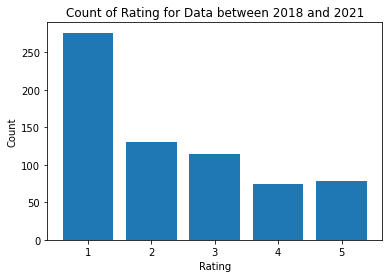

In [42]:
# Plot the count of different ratings for data between 2018 and 2021
snapchat_ios_ph_review_score_count = snapchat_ios_ph_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(snapchat_ios_ph_review_score_count.index,snapchat_ios_ph_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

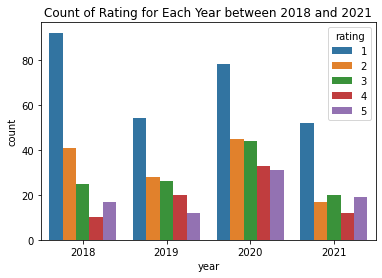

In [43]:
# Plot the count of different ratings for each year
snapchat_ios_ph_review_score_count_ByYear = (snapchat_ios_ph_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=snapchat_ios_ph_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [44]:
# Understand average ratings over year
snapchat_ios_ph_review_avg_score_ByYear = (snapchat_ios_ph_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

snapchat_ios_ph_review_avg_score_ByYear['count'] = snapchat_ios_ph_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
snapchat_ios_ph_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2018  2.021622    185
2019  2.342857    140
2020  2.541126    231
2021  2.408333    120

# Dataframe Preparation for Topic Modelling

In [45]:
# Dataframe with data between 2018 and 2021 without score or year filtering
snapchat_ios_ph_review_YearMonth.head()

review  \
2315  I really like snapchat but it messed up my phone everytime and i dont know why but everytime i open it while im at 9% my phone randomly shut down even if i open different apps it shut downs random...   
2316                 I love all the outfits! But can you add more "Work it" outfit options? Like an outfit for artists? What I'm trying to say is that make more job outfits that aren't mainstream and basic   
2317                                                                                                                           I just updated the app and it won't open!!!!! It's so frustrating and annoying   
2318  Why can't I update my Snapchat into a latest version?? I mean come on, some people had iPhone 4, 4s.. Including Me! Im on iOS 9.3.5.. And I cant update my iOS because it has reached its limit... A...   
2319                                                                                                                                             I redownloaded this app and then it wont open. Fix this asap   

                              title       date  isEdited  rating  \
2315                      Super bug 2018-01-04     False       1   
2316  Loving the Outfits! Butttt... 2018-01-13     False       3   
2317                        Really? 2018-01-14     False       1   
2318          So Very Disappointing 2018-01-20     False       1   
2319                      Cant open 2018-01-20     False       1   

                    userName  year  month  
2315                Shotie23  2018      1  
2316           Cuppycake Ira  2018      1  
2317               Sammm7655  2018      1  
2318            SGAgamer_101  2018      1  
2319  Karate kid storm rider  2018      1

In [46]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
snapchat_ios_ph_review_YearMonth_score1 = snapchat_ios_ph_review_YearMonth[snapchat_ios_ph_review_YearMonth['rating']==1]
snapchat_ios_ph_review_YearMonth_score2 = snapchat_ios_ph_review_YearMonth[snapchat_ios_ph_review_YearMonth['rating']==2]
snapchat_ios_ph_review_YearMonth_score3 = snapchat_ios_ph_review_YearMonth[snapchat_ios_ph_review_YearMonth['rating']==3]
snapchat_ios_ph_review_YearMonth_score4 = snapchat_ios_ph_review_YearMonth[snapchat_ios_ph_review_YearMonth['rating']==4]
snapchat_ios_ph_review_YearMonth_score5 = snapchat_ios_ph_review_YearMonth[snapchat_ios_ph_review_YearMonth['rating']==5]


In [47]:
# Prepare dataframe for grouped score
snapchat_ios_ph_review_YearMonth_score1N2N3 = snapchat_ios_ph_review_YearMonth[snapchat_ios_ph_review_YearMonth['rating'].isin([1,2,3])]
snapchat_ios_ph_review_YearMonth_score4N5 = snapchat_ios_ph_review_YearMonth[snapchat_ios_ph_review_YearMonth['rating'].isin([4,5])]


In [48]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
snapchat_ios_ph_review_YearMonth_2018_score1N2N3 = snapchat_ios_ph_review_YearMonth[(snapchat_ios_ph_review_YearMonth['year']==2018)&(snapchat_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
snapchat_ios_ph_review_YearMonth_2019_score1N2N3 = snapchat_ios_ph_review_YearMonth[(snapchat_ios_ph_review_YearMonth['year']==2019)&(snapchat_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
snapchat_ios_ph_review_YearMonth_2020_score1N2N3 = snapchat_ios_ph_review_YearMonth[(snapchat_ios_ph_review_YearMonth['year']==2020)&(snapchat_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
snapchat_ios_ph_review_YearMonth_2021_score1N2N3 = snapchat_ios_ph_review_YearMonth[(snapchat_ios_ph_review_YearMonth['year']==2021)&(snapchat_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [49]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_ph = snapchat_ios_ph_review_YearMonth.review.values.tolist()
review_words_ph = list(sent_to_words(review_ph))
print(review_words_ph[:1])

[['really', 'like', 'snapchat', 'but', 'it', 'messed', 'up', 'my', 'phone', 'everytime', 'and', 'dont', 'know', 'why', 'but', 'everytime', 'open', 'it', 'while', 'im', 'at', 'my', 'phone', 'randomly', 'shut', 'down', 'even', 'if', 'open', 'different', 'apps', 'it', 'shut', 'downs', 'randomly', 'but', 'when', 'deleted', 'it', 'everything', 'is', 'normal', 'don', 'know', 'why', 'this', 'happen']]


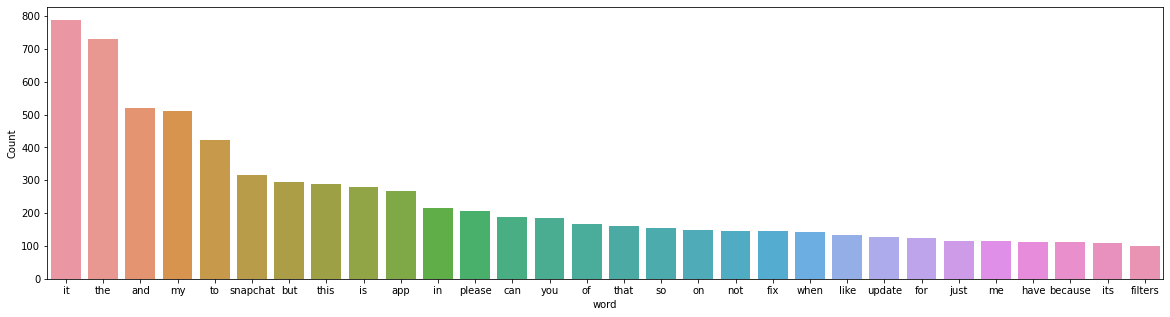

In [50]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph))

In [51]:
# Clean text
review_ph_ready = process_words(review_words_ph)  # processed Text Data! - move to each section

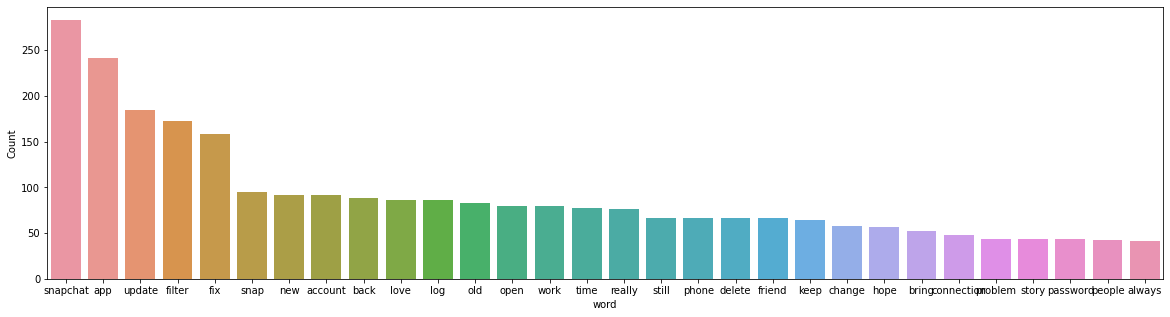

In [52]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready))

In [53]:
# Create Dictionary
id2word_ph = corpora.Dictionary(review_ph_ready)

2021-10-16 20:23:23,447 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:23:23,483 [INFO] gensim.corpora.dictionary - built Dictionary(1248 unique tokens: ['app', 'delete', 'different', 'everytime', 'happen']...) from 676 documents (total 7271 corpus positions)
2021-10-16 20:23:23,583 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1248 unique tokens: ['app', 'delete', 'different', 'everytime', 'happen']...) from 676 documents (total 7271 corpus positions)", 'datetime': '2021-10-16T20:23:23.484873', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [54]:
# Create Corpus: Term Document Frequency
corpus_ph = [id2word_ph.doc2bow(text) for text in review_ph_ready]

In [55]:
# Training LDA model
model_list_ph, coherence_values_ph = compute_coherence_values(dictionary=id2word_ph, corpus=corpus_ph, 
                                                              texts=review_ph_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-16 20:23:23,698 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:23:23,700 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:23:23,704 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:23:23,707 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 676 documents, updating model once every 676 documents, evaluating perplexity every 676 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:23:27,539 [INFO] gensim.models.ldamodel - -7.708 per-word bound, 209.1 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:23:27,541 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #676/676
2021-10-16 20:23:31,083 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"snapchat" + 0.028*"update" + 0.024*"filter" + 0.024*"fix" + 0.023*"app" + 0.014*"new" + 0.013*"sn

2021-10-16 20:23:57,927 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"app" + 0.027*"snapchat" + 0.020*"log" + 0.019*"fix" + 0.017*"account" + 0.015*"time" + 0.013*"snap" + 0.013*"keep" + 0.013*"work" + 0.012*"love"
2021-10-16 20:23:57,929 [INFO] gensim.models.ldamodel - topic diff=0.025425, rho=0.301511
2021-10-16 20:23:58,968 [INFO] gensim.models.ldamodel - -6.205 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:23:58,970 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #676/676
2021-10-16 20:23:59,792 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.041*"update" + 0.040*"snapchat" + 0.036*"filter" + 0.027*"app" + 0.020*"new" + 0.018*"fix" + 0.015*"back" + 0.014*"old" + 0.011*"phone" + 0.010*"story"
2021-10-16 20:23:59,794 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"app" + 0.027*"snapchat" + 0.020*"log" + 0.020*"fix" + 0.018*"account" + 0.015*"time" + 0.013*"snap" + 0.013*"keep" 

2021-10-16 20:24:15,655 [INFO] gensim.models.ldamodel - topic diff=0.013414, rho=0.218218
2021-10-16 20:24:17,173 [INFO] gensim.models.ldamodel - -6.181 per-word bound, 72.6 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:24:17,175 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #676/676
2021-10-16 20:24:18,223 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"update" + 0.041*"snapchat" + 0.040*"filter" + 0.026*"app" + 0.021*"new" + 0.018*"back" + 0.017*"old" + 0.014*"fix" + 0.012*"bring" + 0.011*"story"
2021-10-16 20:24:18,232 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"app" + 0.027*"snapchat" + 0.023*"fix" + 0.020*"log" + 0.019*"account" + 0.016*"time" + 0.014*"open" + 0.014*"snap" + 0.014*"keep" + 0.013*"work"
2021-10-16 20:24:18,238 [INFO] gensim.models.ldamodel - topic diff=0.012821, rho=0.213201
2021-10-16 20:24:19,541 [INFO] gensim.models.ldamodel - -6.179 per-word bound, 72.5 perplexity estimate ba

2021-10-16 20:24:38,786 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #676/676
2021-10-16 20:24:39,717 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"update" + 0.042*"filter" + 0.040*"snapchat" + 0.025*"app" + 0.022*"new" + 0.019*"back" + 0.018*"old" + 0.013*"bring" + 0.012*"fix" + 0.012*"love"
2021-10-16 20:24:39,719 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"app" + 0.027*"snapchat" + 0.024*"fix" + 0.020*"account" + 0.019*"log" + 0.016*"time" + 0.016*"open" + 0.015*"snap" + 0.014*"keep" + 0.014*"work"
2021-10-16 20:24:39,722 [INFO] gensim.models.ldamodel - topic diff=0.007773, rho=0.176777
2021-10-16 20:24:41,214 [INFO] gensim.models.ldamodel - -6.170 per-word bound, 72.0 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:24:41,216 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #676/676
2021-10-16 20:24:42,023 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"update" + 0.042*"fil

2021-10-16 20:24:57,083 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"app" + 0.027*"snapchat" + 0.025*"fix" + 0.020*"account" + 0.019*"log" + 0.017*"open" + 0.017*"time" + 0.015*"snap" + 0.014*"keep" + 0.014*"work"
2021-10-16 20:24:57,086 [INFO] gensim.models.ldamodel - topic diff=0.005647, rho=0.154303
2021-10-16 20:24:58,128 [INFO] gensim.models.ldamodel - -6.165 per-word bound, 71.7 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:24:58,129 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #676/676
2021-10-16 20:24:58,785 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"update" + 0.043*"filter" + 0.040*"snapchat" + 0.024*"app" + 0.022*"new" + 0.020*"back" + 0.019*"old" + 0.014*"love" + 0.013*"bring" + 0.011*"really"
2021-10-16 20:24:58,787 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"app" + 0.027*"snapchat" + 0.025*"fix" + 0.020*"account" + 0.019*"log" + 0.017*"open" + 0.017*"time" + 0.015*"snap

2021-10-16 20:25:17,848 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 611 virtual documents
2021-10-16 20:25:18,193 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:25:18,198 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:25:18,201 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:25:18,208 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 676 documents, updating model once every 676 documents, evaluating perplexity every 676 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:25:20,014 [INFO] gensim.models.ldamodel - -8.988 per-word bound, 507.7 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:25:20,034 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #676/676
2021-10-16 20:25

2021-10-16 20:25:30,304 [INFO] gensim.models.ldamodel - -6.488 per-word bound, 89.7 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:25:30,306 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #676/676
2021-10-16 20:25:30,922 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"snapchat" + 0.026*"filter" + 0.024*"update" + 0.014*"lock" + 0.014*"still" + 0.012*"account" + 0.011*"snap" + 0.011*"delete" + 0.010*"whenever" + 0.010*"keep"
2021-10-16 20:25:30,930 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"snapchat" + 0.028*"password" + 0.024*"app" + 0.022*"memory" + 0.020*"log" + 0.020*"keep" + 0.019*"time" + 0.016*"number" + 0.015*"account" + 0.014*"email"
2021-10-16 20:25:30,933 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"snapchat" + 0.028*"account" + 0.027*"connection" + 0.026*"fix" + 0.025*"log" + 0.019*"work" + 0.019*"problem" + 0.014*"app" + 0.013*"time" + 0.012*"happen"
2021-10-16 20:25:30,938 [INF

2021-10-16 20:25:39,296 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.031*"password" + 0.029*"snapchat" + 0.023*"memory" + 0.022*"app" + 0.020*"log" + 0.020*"keep" + 0.018*"number" + 0.018*"time" + 0.017*"account" + 0.016*"email"
2021-10-16 20:25:39,300 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.037*"log" + 0.036*"connection" + 0.032*"account" + 0.030*"fix" + 0.029*"snapchat" + 0.019*"problem" + 0.019*"work" + 0.014*"error" + 0.013*"app" + 0.013*"happen"
2021-10-16 20:25:39,302 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"black" + 0.023*"crash" + 0.023*"snapchat" + 0.022*"filter" + 0.022*"open" + 0.019*"fix" + 0.016*"video" + 0.015*"keep" + 0.013*"save" + 0.013*"message"
2021-10-16 20:25:39,304 [INFO] gensim.models.ldamodel - topic diff=0.026364, rho=0.288675
2021-10-16 20:25:40,211 [INFO] gensim.models.ldamodel - -6.444 per-word bound, 87.1 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:25:40,217 [INFO] gensim.m

2021-10-16 20:25:47,440 [INFO] gensim.models.ldamodel - topic diff=0.015337, rho=0.242536
2021-10-16 20:25:48,557 [INFO] gensim.models.ldamodel - -6.427 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:25:48,558 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #676/676
2021-10-16 20:25:49,275 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.031*"black" + 0.026*"snapchat" + 0.024*"crash" + 0.023*"open" + 0.021*"filter" + 0.019*"fix" + 0.017*"keep" + 0.016*"video" + 0.014*"white" + 0.013*"save"
2021-10-16 20:25:49,276 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.055*"update" + 0.050*"filter" + 0.043*"snapchat" + 0.032*"new" + 0.028*"app" + 0.024*"snap" + 0.022*"back" + 0.019*"old" + 0.016*"really" + 0.015*"love"
2021-10-16 20:25:49,278 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.051*"snapchat" + 0.027*"filter" + 0.018*"update" + 0.018*"lock" + 0.013*"account" + 0.013*"battery" + 0.012*"still

2021-10-16 20:25:57,710 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.056*"update" + 0.051*"filter" + 0.043*"snapchat" + 0.033*"new" + 0.028*"app" + 0.023*"snap" + 0.022*"back" + 0.019*"old" + 0.016*"really" + 0.015*"love"
2021-10-16 20:25:57,717 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.069*"app" + 0.033*"open" + 0.033*"fix" + 0.026*"delete" + 0.026*"still" + 0.023*"snapchat" + 0.021*"time" + 0.019*"love" + 0.017*"phone" + 0.014*"download"
2021-10-16 20:25:57,720 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"back" + 0.030*"old" + 0.028*"snapchat" + 0.027*"bring" + 0.027*"app" + 0.024*"update" + 0.015*"new" + 0.014*"interface" + 0.010*"still" + 0.010*"font"
2021-10-16 20:25:57,724 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.049*"snapchat" + 0.027*"filter" + 0.019*"lock" + 0.018*"update" + 0.013*"account" + 0.013*"battery" + 0.012*"still" + 0.011*"snap" + 0.011*"permanently" + 0.011*"guy"
2021-10-16 20:25:57,728 [INFO] gensim.models.ldamodel - topic di

2021-10-16 20:26:05,795 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.046*"log" + 0.041*"connection" + 0.037*"account" + 0.036*"fix" + 0.029*"snapchat" + 0.020*"problem" + 0.019*"work" + 0.017*"internet" + 0.017*"error" + 0.014*"app"
2021-10-16 20:26:05,797 [INFO] gensim.models.ldamodel - topic diff=0.006795, rho=0.188982
2021-10-16 20:26:06,816 [INFO] gensim.models.ldamodel - -6.409 per-word bound, 85.0 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:26:06,818 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #676/676
2021-10-16 20:26:07,573 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.046*"log" + 0.041*"connection" + 0.037*"account" + 0.036*"fix" + 0.029*"snapchat" + 0.020*"problem" + 0.019*"work" + 0.017*"internet" + 0.017*"error" + 0.014*"snap"
2021-10-16 20:26:07,575 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"back" + 0.031*"old" + 0.028*"bring" + 0.028*"snapchat" + 0.026*"app" + 0.023*"update" + 

2021-10-16 20:26:16,698 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.056*"update" + 0.053*"filter" + 0.043*"snapchat" + 0.034*"new" + 0.028*"app" + 0.023*"back" + 0.023*"snap" + 0.020*"old" + 0.016*"really" + 0.015*"love"
2021-10-16 20:26:16,701 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"black" + 0.029*"snapchat" + 0.024*"crash" + 0.022*"open" + 0.022*"filter" + 0.019*"fix" + 0.019*"keep" + 0.017*"screen" + 0.016*"whenever" + 0.016*"video"
2021-10-16 20:26:16,703 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.049*"snapchat" + 0.027*"filter" + 0.019*"lock" + 0.017*"update" + 0.014*"account" + 0.013*"battery" + 0.012*"still" + 0.011*"snap" + 0.011*"permanently" + 0.011*"guy"
2021-10-16 20:26:16,706 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.069*"app" + 0.033*"open" + 0.032*"fix" + 0.028*"delete" + 0.027*"still" + 0.024*"snapchat" + 0.021*"time" + 0.019*"love" + 0.018*"phone" + 0.015*"download"
2021-10-16 20:26:16,708 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:26:24,281 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"black" + 0.029*"snapchat" + 0.024*"crash" + 0.022*"filter" + 0.022*"open" + 0.019*"fix" + 0.019*"keep" + 0.018*"screen" + 0.017*"whenever" + 0.016*"video"
2021-10-16 20:26:24,284 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.048*"snapchat" + 0.027*"filter" + 0.019*"lock" + 0.017*"update" + 0.014*"account" + 0.013*"battery" + 0.011*"still" + 0.011*"permanently" + 0.011*"snap" + 0.011*"guy"
2021-10-16 20:26:24,286 [INFO] gensim.models.ldamodel - topic diff=0.003806, rho=0.160128
2021-10-16 20:26:25,062 [INFO] gensim.models.ldamodel - -6.402 per-word bound, 84.5 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:26:25,063 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #676/676
2021-10-16 20:26:25,628 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"black" + 0.029*"snapchat" + 0.024*"crash" + 0.022*"filter" + 0.022*"open" + 0.019*"fix" + 

2021-10-16 20:26:33,085 [INFO] gensim.models.ldamodel - -6.400 per-word bound, 84.4 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:26:33,086 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #676/676
2021-10-16 20:26:33,908 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"update" + 0.054*"filter" + 0.043*"snapchat" + 0.034*"new" + 0.028*"app" + 0.023*"back" + 0.022*"snap" + 0.020*"old" + 0.016*"really" + 0.015*"love"
2021-10-16 20:26:33,910 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"log" + 0.041*"connection" + 0.039*"account" + 0.037*"fix" + 0.029*"snapchat" + 0.020*"problem" + 0.019*"work" + 0.018*"internet" + 0.017*"error" + 0.015*"snap"
2021-10-16 20:26:33,911 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.048*"snapchat" + 0.027*"filter" + 0.019*"lock" + 0.017*"update" + 0.014*"account" + 0.013*"battery" + 0.011*"still" + 0.011*"permanently" + 0.011*"snap" + 0.011*"guy"
2021-10-16 20:26:33,916 [IN

2021-10-16 20:26:43,925 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.049*"snapchat" + 0.027*"filter" + 0.020*"lock" + 0.017*"update" + 0.014*"account" + 0.013*"battery" + 0.011*"still" + 0.011*"snap" + 0.011*"permanently" + 0.011*"guy"
2021-10-16 20:26:43,927 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.070*"app" + 0.032*"open" + 0.032*"fix" + 0.029*"delete" + 0.027*"still" + 0.025*"snapchat" + 0.020*"time" + 0.020*"phone" + 0.019*"love" + 0.016*"download"
2021-10-16 20:26:43,930 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.039*"black" + 0.030*"snapchat" + 0.023*"crash" + 0.022*"filter" + 0.022*"open" + 0.019*"fix" + 0.019*"screen" + 0.019*"keep" + 0.016*"video" + 0.016*"whenever"
2021-10-16 20:26:43,931 [INFO] gensim.models.ldamodel - topic diff=0.002513, rho=0.141421
2021-10-16 20:26:45,160 [INFO] gensim.models.ldamodel - -6.397 per-word bound, 84.3 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:26:45,161 [INFO] gens

2021-10-16 20:27:06,040 [INFO] gensim.models.ldamodel - -6.674 per-word bound, 102.1 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:27:06,046 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #676/676
2021-10-16 20:27:06,969 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.090*"back" + 0.079*"old" + 0.078*"bring" + 0.037*"new" + 0.034*"update" + 0.031*"snapchat" + 0.016*"version" + 0.015*"filter" + 0.014*"really" + 0.014*"interface"
2021-10-16 20:27:06,972 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.037*"app" + 0.036*"snapchat" + 0.022*"delete" + 0.021*"account" + 0.019*"open" + 0.017*"fix" + 0.014*"filter" + 0.013*"still" + 0.012*"friend" + 0.011*"ipad"
2021-10-16 20:27:06,975 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.044*"snapchat" + 0.034*"app" + 0.025*"account" + 0.018*"update" + 0.017*"filter" + 0.017*"really" + 0.012*"log" + 0.011*"open" + 0.010*"time" + 0.010*"lock"
2021-10-16 20:27:06,983 [INFO] ge

2021-10-16 20:27:20,757 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.021*"dark" + 0.021*"mode" + 0.020*"snapchat" + 0.014*"fix" + 0.013*"hope" + 0.013*"app" + 0.013*"filter" + 0.012*"message" + 0.011*"open" + 0.011*"time"
2021-10-16 20:27:20,760 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.057*"app" + 0.038*"crash" + 0.036*"filter" + 0.029*"still" + 0.028*"open" + 0.028*"keep" + 0.026*"time" + 0.025*"download" + 0.023*"work" + 0.021*"delete"
2021-10-16 20:27:20,762 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.034*"app" + 0.033*"filter" + 0.032*"snapchat" + 0.032*"love" + 0.027*"video" + 0.021*"fix" + 0.020*"really" + 0.019*"snap" + 0.019*"phone" + 0.017*"work"
2021-10-16 20:27:20,762 [INFO] gensim.models.ldamodel - topic diff=0.048365, rho=0.316228
2021-10-16 20:27:22,419 [INFO] gensim.models.ldamodel - -6.562 per-word bound, 94.5 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:27:22,420 [INFO] gensim.models.ldamodel -

2021-10-16 20:27:34,452 [INFO] gensim.models.ldamodel - topic diff=0.023237, rho=0.258199
2021-10-16 20:27:36,074 [INFO] gensim.models.ldamodel - -6.538 per-word bound, 93.0 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:27:36,076 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #676/676
2021-10-16 20:27:37,076 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"snapchat" + 0.039*"app" + 0.031*"account" + 0.020*"really" + 0.015*"filter" + 0.014*"lock" + 0.014*"log" + 0.012*"wrong" + 0.012*"hope" + 0.010*"time"
2021-10-16 20:27:37,093 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.117*"back" + 0.109*"old" + 0.085*"bring" + 0.059*"new" + 0.052*"update" + 0.033*"snapchat" + 0.026*"filter" + 0.019*"really" + 0.018*"version" + 0.015*"interface"
2021-10-16 20:27:37,100 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.022*"dark" + 0.022*"mode" + 0.020*"snapchat" + 0.014*"fix" + 0.013*"hope" + 0.013*"app" + 0.012*"messa

2021-10-16 20:27:46,087 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.047*"filter" + 0.042*"snapchat" + 0.032*"update" + 0.023*"new" + 0.019*"battery" + 0.016*"permanently" + 0.013*"lock" + 0.012*"love" + 0.011*"especially" + 0.011*"enjoy"
2021-10-16 20:27:46,089 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.067*"update" + 0.051*"snapchat" + 0.037*"app" + 0.037*"filter" + 0.029*"snap" + 0.024*"friend" + 0.024*"change" + 0.023*"new" + 0.020*"story" + 0.019*"fix"
2021-10-16 20:27:46,091 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.039*"app" + 0.038*"snapchat" + 0.032*"account" + 0.020*"really" + 0.016*"lock" + 0.015*"log" + 0.014*"filter" + 0.013*"wrong" + 0.012*"hope" + 0.010*"time"
2021-10-16 20:27:46,093 [INFO] gensim.models.ldamodel - topic diff=0.013073, rho=0.218218
2021-10-16 20:27:47,236 [INFO] gensim.models.ldamodel - -6.520 per-word bound, 91.8 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:27:47,237 [INFO] gens

2021-10-16 20:27:56,572 [INFO] gensim.models.ldamodel - topic diff=0.009185, rho=0.196116
2021-10-16 20:27:57,532 [INFO] gensim.models.ldamodel - -6.507 per-word bound, 91.0 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:27:57,538 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #676/676
2021-10-16 20:27:58,125 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.037*"snapchat" + 0.027*"fix" + 0.025*"zoom" + 0.016*"account" + 0.015*"chat" + 0.015*"happen" + 0.013*"time" + 0.013*"work" + 0.013*"snap" + 0.011*"friend"
2021-10-16 20:27:58,126 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.123*"back" + 0.115*"old" + 0.084*"bring" + 0.061*"new" + 0.053*"update" + 0.033*"snapchat" + 0.028*"filter" + 0.018*"version" + 0.017*"really" + 0.015*"hate"
2021-10-16 20:27:58,128 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.041*"snapchat" + 0.029*"delete" + 0.026*"app" + 0.022*"account" + 0.021*"open" + 0.019*"fix" + 0.016*"ipad" 

2021-10-16 20:28:05,563 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.027*"dark" + 0.027*"mode" + 0.019*"snapchat" + 0.015*"stay" + 0.014*"eye" + 0.014*"add" + 0.012*"lense" + 0.012*"app" + 0.012*"message" + 0.012*"hope"
2021-10-16 20:28:05,565 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.037*"app" + 0.035*"love" + 0.034*"filter" + 0.034*"snapchat" + 0.029*"video" + 0.023*"phone" + 0.022*"fix" + 0.021*"really" + 0.021*"snap" + 0.020*"work"
2021-10-16 20:28:05,568 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.123*"back" + 0.116*"old" + 0.083*"bring" + 0.061*"new" + 0.053*"update" + 0.033*"snapchat" + 0.029*"filter" + 0.017*"version" + 0.016*"really" + 0.015*"hate"
2021-10-16 20:28:05,572 [INFO] gensim.models.ldamodel - topic diff=0.007107, rho=0.176777
2021-10-16 20:28:06,494 [INFO] gensim.models.ldamodel - -6.497 per-word bound, 90.3 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:28:06,496 [INFO] gensim.models.ldamodel 

2021-10-16 20:28:13,091 [INFO] gensim.models.ldamodel - topic diff=0.005428, rho=0.164399
2021-10-16 20:28:13,934 [INFO] gensim.models.ldamodel - -6.492 per-word bound, 90.0 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:28:13,941 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #676/676
2021-10-16 20:28:14,555 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.071*"update" + 0.052*"snapchat" + 0.037*"app" + 0.037*"filter" + 0.028*"snap" + 0.025*"friend" + 0.024*"new" + 0.024*"change" + 0.021*"story" + 0.017*"fix"
2021-10-16 20:28:14,556 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"app" + 0.035*"snapchat" + 0.034*"account" + 0.019*"log" + 0.019*"really" + 0.018*"lock" + 0.015*"wrong" + 0.014*"filter" + 0.013*"hope" + 0.011*"feature"
2021-10-16 20:28:14,558 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.053*"fix" + 0.040*"snapchat" + 0.040*"connection" + 0.025*"log" + 0.021*"open" + 0.021*"account" + 0.020*"

2021-10-16 20:28:21,937 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.037*"app" + 0.035*"love" + 0.034*"filter" + 0.034*"snapchat" + 0.029*"video" + 0.024*"phone" + 0.022*"fix" + 0.022*"really" + 0.020*"snap" + 0.020*"work"
2021-10-16 20:28:21,938 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.037*"snapchat" + 0.027*"fix" + 0.026*"zoom" + 0.015*"happen" + 0.015*"account" + 0.014*"chat" + 0.013*"time" + 0.013*"work" + 0.012*"snap" + 0.012*"friend"
2021-10-16 20:28:21,939 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.068*"app" + 0.040*"crash" + 0.037*"open" + 0.031*"filter" + 0.031*"still" + 0.028*"keep" + 0.027*"download" + 0.026*"time" + 0.024*"delete" + 0.022*"work"
2021-10-16 20:28:21,941 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.071*"update" + 0.053*"snapchat" + 0.037*"filter" + 0.037*"app" + 0.027*"snap" + 0.025*"friend" + 0.024*"new" + 0.024*"change" + 0.022*"story" + 0.017*"fix"
2021-10-16 20:28:21,942 [INFO] gensim.models.ldamodel - topic diff=0.00390

2021-10-16 20:28:29,204 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.049*"password" + 0.035*"account" + 0.034*"memory" + 0.033*"log" + 0.028*"help" + 0.021*"snapchat" + 0.021*"keep" + 0.021*"number" + 0.021*"change" + 0.020*"username"
2021-10-16 20:28:29,208 [INFO] gensim.models.ldamodel - topic diff=0.002913, rho=0.144338
2021-10-16 20:28:30,196 [INFO] gensim.models.ldamodel - -6.485 per-word bound, 89.6 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:28:30,198 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #676/676
2021-10-16 20:28:30,803 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.056*"app" + 0.039*"log" + 0.021*"time" + 0.021*"bug" + 0.020*"email" + 0.019*"phone" + 0.018*"close" + 0.017*"open" + 0.016*"install" + 0.015*"number"
2021-10-16 20:28:30,808 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.028*"dark" + 0.028*"mode" + 0.018*"snapchat" + 0.016*"stay" + 0.016*"lense" + 0.014*"eye" + 0.014*"add" +

2021-10-16 20:28:48,087 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.029*"open" + 0.020*"app" + 0.019*"snap" + 0.016*"fix" + 0.016*"back" + 0.016*"message" + 0.014*"bring" + 0.011*"really" + 0.011*"add" + 0.011*"let"
2021-10-16 20:28:48,089 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.049*"snapchat" + 0.045*"old" + 0.042*"back" + 0.033*"update" + 0.030*"bring" + 0.025*"new" + 0.017*"log" + 0.014*"connection" + 0.014*"story" + 0.013*"remove"
2021-10-16 20:28:48,090 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.052*"snapchat" + 0.029*"update" + 0.028*"app" + 0.026*"back" + 0.024*"filter" + 0.013*"account" + 0.012*"love" + 0.012*"hope" + 0.011*"really" + 0.010*"bring"
2021-10-16 20:28:48,093 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.046*"snapchat" + 0.039*"app" + 0.017*"account" + 0.014*"email" + 0.013*"log" + 0.013*"new" + 0.013*"problem" + 0.012*"time" + 0.011*"story" + 0.011*"number"
2021-10-16 20:28:48,095 [INFO] gensim.models.ldamodel - topic diff=0.16

2021-10-16 20:28:57,368 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.040*"snapchat" + 0.039*"update" + 0.039*"app" + 0.035*"snap" + 0.032*"filter" + 0.029*"change" + 0.026*"new" + 0.019*"really" + 0.018*"friend" + 0.018*"username"
2021-10-16 20:28:57,370 [INFO] gensim.models.ldamodel - topic diff=0.069988, rho=0.353553
2021-10-16 20:28:58,561 [INFO] gensim.models.ldamodel - -6.703 per-word bound, 104.2 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:28:58,562 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #676/676
2021-10-16 20:28:59,688 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.055*"log" + 0.043*"app" + 0.041*"connection" + 0.037*"account" + 0.032*"fix" + 0.029*"snapchat" + 0.029*"delete" + 0.023*"error" + 0.023*"open" + 0.021*"phone"
2021-10-16 20:28:59,692 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.079*"filter" + 0.037*"love" + 0.025*"snapchat" + 0.020*"time" + 0.018*"fix" + 0.015*"save" + 0.015*

2021-10-16 20:29:11,080 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.042*"app" + 0.042*"snapchat" + 0.029*"filter" + 0.029*"love" + 0.025*"fix" + 0.024*"really" + 0.022*"video" + 0.021*"message" + 0.018*"whenever" + 0.017*"much"
2021-10-16 20:29:11,083 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.089*"app" + 0.056*"open" + 0.040*"black" + 0.038*"fix" + 0.035*"turn" + 0.029*"still" + 0.027*"snapchat" + 0.020*"everytime" + 0.020*"update" + 0.019*"install"
2021-10-16 20:29:11,087 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.098*"filter" + 0.027*"work" + 0.027*"snapchat" + 0.022*"video" + 0.022*"fix" + 0.020*"hate" + 0.018*"back" + 0.015*"iphone" + 0.015*"really" + 0.014*"face"
2021-10-16 20:29:11,092 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"snapchat" + 0.040*"app" + 0.018*"account" + 0.016*"problem" + 0.015*"log" + 0.012*"time" + 0.012*"story" + 0.012*"snap" + 0.011*"email" + 0.010*"connection"
2021-10-16 20:29:11,094 [INFO] gensim.models.ldamodel -

2021-10-16 20:29:25,267 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.040*"snapchat" + 0.020*"bitmoji" + 0.020*"happen" + 0.019*"datum" + 0.016*"lock" + 0.016*"cellular" + 0.013*"account" + 0.012*"snap" + 0.012*"delete" + 0.012*"eye"
2021-10-16 20:29:25,269 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.104*"filter" + 0.027*"snapchat" + 0.026*"work" + 0.024*"video" + 0.022*"fix" + 0.020*"hate" + 0.015*"face" + 0.014*"back" + 0.014*"iphone" + 0.014*"really"
2021-10-16 20:29:25,271 [INFO] gensim.models.ldamodel - topic diff=0.019065, rho=0.229416
2021-10-16 20:29:26,576 [INFO] gensim.models.ldamodel - -6.622 per-word bound, 98.5 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:29:26,578 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #676/676
2021-10-16 20:29:27,441 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.043*"snapchat" + 0.041*"app" + 0.030*"filter" + 0.029*"love" + 0.025*"fix" + 0.023*"really" + 0.023*

2021-10-16 20:29:36,965 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #676/676
2021-10-16 20:29:37,794 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.066*"log" + 0.048*"connection" + 0.040*"account" + 0.038*"app" + 0.038*"fix" + 0.033*"delete" + 0.030*"snapchat" + 0.023*"error" + 0.020*"phone" + 0.020*"internet"
2021-10-16 20:29:37,798 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.041*"chat" + 0.037*"send" + 0.025*"snap" + 0.023*"tell" + 0.023*"message" + 0.023*"app" + 0.015*"delete" + 0.014*"screenshot" + 0.013*"hot" + 0.013*"bug"
2021-10-16 20:29:37,802 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.096*"app" + 0.066*"open" + 0.046*"black" + 0.039*"fix" + 0.034*"turn" + 0.030*"still" + 0.029*"snapchat" + 0.021*"update" + 0.020*"everytime" + 0.019*"install"
2021-10-16 20:29:37,814 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.041*"snapchat" + 0.040*"change" + 0.040*"snap" + 0.039*"app" + 0.038*"update" + 0.033*"filter" + 0.026*"new" + 0.022*"rea

2021-10-16 20:29:49,230 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.059*"password" + 0.052*"account" + 0.045*"phone" + 0.037*"snapchat" + 0.028*"number" + 0.027*"log" + 0.027*"email" + 0.021*"new" + 0.019*"friend" + 0.018*"change"
2021-10-16 20:29:49,233 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.055*"app" + 0.047*"update" + 0.034*"crash" + 0.032*"download" + 0.031*"still" + 0.028*"time" + 0.028*"keep" + 0.024*"work" + 0.021*"fix" + 0.019*"problem"
2021-10-16 20:29:49,235 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.041*"snap" + 0.041*"snapchat" + 0.040*"change" + 0.039*"app" + 0.038*"update" + 0.033*"filter" + 0.025*"new" + 0.022*"really" + 0.021*"username" + 0.020*"friend"
2021-10-16 20:29:49,238 [INFO] gensim.models.ldamodel - topic diff=0.007871, rho=0.182574
2021-10-16 20:29:50,574 [INFO] gensim.models.ldamodel - -6.599 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:29:50,576 [INFO] gensim

2021-10-16 20:30:02,407 [INFO] gensim.models.ldamodel - topic diff=0.005467, rho=0.169031
2021-10-16 20:30:03,462 [INFO] gensim.models.ldamodel - -6.595 per-word bound, 96.6 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:30:03,464 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #676/676
2021-10-16 20:30:04,137 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.066*"log" + 0.048*"connection" + 0.041*"account" + 0.038*"app" + 0.038*"fix" + 0.035*"delete" + 0.031*"snapchat" + 0.023*"error" + 0.020*"internet" + 0.020*"phone"
2021-10-16 20:30:04,138 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.041*"snap" + 0.041*"snapchat" + 0.040*"change" + 0.039*"app" + 0.037*"update" + 0.033*"filter" + 0.025*"new" + 0.022*"really" + 0.021*"username" + 0.020*"friend"
2021-10-16 20:30:04,141 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.117*"filter" + 0.030*"work" + 0.027*"snapchat" + 0.026*"video" + 0.023*"fix" + 0.020*"hate" + 0

2021-10-16 20:30:16,078 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.035*"memory" + 0.030*"help" + 0.029*"snap" + 0.026*"snapchat" + 0.021*"keep" + 0.017*"delete" + 0.016*"put" + 0.015*"app" + 0.014*"work" + 0.014*"update"
2021-10-16 20:30:16,081 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.042*"snapchat" + 0.030*"filter" + 0.024*"friend" + 0.021*"update" + 0.021*"battery" + 0.018*"fix" + 0.017*"whenever" + 0.016*"hope" + 0.015*"app" + 0.014*"story"
2021-10-16 20:30:16,090 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.066*"log" + 0.048*"connection" + 0.041*"account" + 0.038*"fix" + 0.038*"app" + 0.035*"delete" + 0.031*"snapchat" + 0.023*"error" + 0.020*"internet" + 0.020*"phone"
2021-10-16 20:30:16,092 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.071*"filter" + 0.039*"love" + 0.021*"snapchat" + 0.021*"time" + 0.019*"face" + 0.018*"star" + 0.015*"save" + 0.015*"baby" + 0.014*"fix" + 0.013*"story"
2021-10-16 20:30:16,093 [INFO] gensim.models.ldamodel - topic d

2021-10-16 20:30:25,071 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.048*"snapchat" + 0.035*"update" + 0.026*"filter" + 0.025*"app" + 0.018*"back" + 0.017*"io" + 0.015*"love" + 0.014*"late" + 0.013*"hope" + 0.013*"phone"
2021-10-16 20:30:25,071 [INFO] gensim.models.ldamodel - topic diff=0.002653, rho=0.147442
2021-10-16 20:30:26,269 [INFO] gensim.models.ldamodel - -6.589 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:30:26,274 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #676/676
2021-10-16 20:30:27,577 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.048*"snapchat" + 0.035*"update" + 0.026*"filter" + 0.025*"app" + 0.018*"back" + 0.017*"io" + 0.015*"love" + 0.014*"late" + 0.013*"hope" + 0.013*"phone"
2021-10-16 20:30:27,579 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.054*"app" + 0.045*"update" + 0.034*"crash" + 0.033*"download" + 0.031*"still" + 0.028*"keep" + 0.026*"time" + 0.024*

2021-10-16 20:30:35,107 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:30:40,482 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:30:40,534 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 650 virtual documents
2021-10-16 20:30:45,211 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 20:30:45,212 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 20:30:45,218 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:30:45,226 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 676 documents, updating model once every 676 documents, evaluating perplexity every 676 documents, iterating 50x with a 

2021-10-16 20:30:54,985 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.051*"app" + 0.024*"fix" + 0.022*"snapchat" + 0.019*"open" + 0.019*"account" + 0.018*"still" + 0.017*"reinstall" + 0.016*"time" + 0.015*"work" + 0.015*"delete"
2021-10-16 20:30:54,986 [INFO] gensim.models.ldamodel - topic diff=0.132147, rho=0.408248
2021-10-16 20:30:55,985 [INFO] gensim.models.ldamodel - -6.840 per-word bound, 114.6 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:30:56,016 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #676/676
2021-10-16 20:30:56,710 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.038*"app" + 0.036*"love" + 0.029*"snapchat" + 0.026*"work" + 0.025*"filter" + 0.023*"phone" + 0.020*"message" + 0.020*"really" + 0.019*"much" + 0.018*"update"
2021-10-16 20:30:56,712 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.051*"app" + 0.023*"fix" + 0.022*"snapchat" + 0.019*"open" + 0.019*"account" + 0.019*"still" + 0.018*"re

2021-10-16 20:31:05,585 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.041*"snapchat" + 0.040*"hate" + 0.038*"filter" + 0.024*"fix" + 0.023*"people" + 0.017*"update" + 0.013*"still" + 0.012*"hope" + 0.011*"really" + 0.011*"story"
2021-10-16 20:31:05,586 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.037*"message" + 0.031*"mode" + 0.028*"dark" + 0.023*"snapchat" + 0.018*"really" + 0.017*"open" + 0.012*"save" + 0.012*"change" + 0.012*"username" + 0.012*"already"
2021-10-16 20:31:05,588 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.051*"snapchat" + 0.028*"account" + 0.026*"snap" + 0.017*"new" + 0.016*"love" + 0.015*"app" + 0.015*"filter" + 0.014*"time" + 0.014*"open" + 0.013*"update"
2021-10-16 20:31:05,591 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.112*"back" + 0.102*"old" + 0.093*"bring" + 0.067*"snapchat" + 0.031*"filter" + 0.024*"new" + 0.019*"look" + 0.013*"story" + 0.013*"create" + 0.013*"yet"
2021-10-16 20:31:05,593 [INFO] gensim.models.ldamodel - topic #1

2021-10-16 20:31:14,656 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.048*"snapchat" + 0.020*"people" + 0.018*"password" + 0.017*"phone" + 0.016*"fine" + 0.013*"fix" + 0.013*"old" + 0.013*"account" + 0.012*"email" + 0.012*"forgot"
2021-10-16 20:31:14,662 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.068*"app" + 0.046*"open" + 0.040*"iphone" + 0.036*"phone" + 0.029*"crash" + 0.028*"ipad" + 0.025*"update" + 0.023*"fix" + 0.022*"still" + 0.021*"reset"
2021-10-16 20:31:14,668 [INFO] gensim.models.ldamodel - topic diff=0.026535, rho=0.242536
2021-10-16 20:31:16,001 [INFO] gensim.models.ldamodel - -6.699 per-word bound, 103.9 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:31:16,002 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #676/676
2021-10-16 20:31:17,091 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.041*"app" + 0.041*"love" + 0.030*"snapchat" + 0.028*"work" + 0.024*"phone" + 0.021*"much" + 0.021*"filter" 

2021-10-16 20:31:25,975 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #676/676
2021-10-16 20:31:26,682 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.039*"password" + 0.038*"account" + 0.032*"snapchat" + 0.029*"really" + 0.028*"picture" + 0.027*"snap" + 0.022*"new" + 0.020*"phone" + 0.018*"change" + 0.017*"love"
2021-10-16 20:31:26,684 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.048*"snapchat" + 0.029*"account" + 0.026*"snap" + 0.017*"new" + 0.016*"app" + 0.014*"love" + 0.012*"open" + 0.012*"already" + 0.012*"filter" + 0.011*"time"
2021-10-16 20:31:26,688 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.149*"update" + 0.107*"new" + 0.051*"story" + 0.038*"friend" + 0.033*"snap" + 0.031*"back" + 0.026*"old" + 0.025*"version" + 0.024*"fix" + 0.021*"like"
2021-10-16 20:31:26,690 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.043*"app" + 0.042*"love" + 0.031*"snapchat" + 0.030*"work" + 0.024*"phone" + 0.021*"much" + 0.021*"message" + 0.020*"fix" + 0.

2021-10-16 20:31:35,708 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.038*"message" + 0.036*"mode" + 0.032*"dark" + 0.026*"snapchat" + 0.019*"really" + 0.013*"save" + 0.013*"username" + 0.013*"change" + 0.013*"already" + 0.013*"hairstyle"
2021-10-16 20:31:35,710 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.188*"filter" + 0.027*"face" + 0.026*"app" + 0.024*"really" + 0.023*"snapchat" + 0.020*"baby" + 0.019*"find" + 0.017*"love" + 0.017*"hope" + 0.014*"put"
2021-10-16 20:31:35,711 [INFO] gensim.models.ldamodel - topic diff=0.010841, rho=0.188982
2021-10-16 20:31:36,614 [INFO] gensim.models.ldamodel - -6.665 per-word bound, 101.5 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:31:36,617 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #676/676
2021-10-16 20:31:37,288 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.044*"hate" + 0.040*"snapchat" + 0.025*"effect" + 0.023*"people" + 0.022*"fix" + 0.022*"filter" + 0

2021-10-16 20:31:45,366 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #676/676
2021-10-16 20:31:45,975 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.045*"snapchat" + 0.023*"people" + 0.020*"password" + 0.017*"phone" + 0.016*"fine" + 0.016*"snap" + 0.014*"fix" + 0.013*"old" + 0.013*"account" + 0.012*"email"
2021-10-16 20:31:45,978 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.101*"connection" + 0.080*"log" + 0.057*"app" + 0.053*"internet" + 0.051*"account" + 0.041*"fix" + 0.040*"error" + 0.027*"check" + 0.018*"always" + 0.018*"wrong"
2021-10-16 20:31:45,983 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.045*"friend" + 0.040*"download" + 0.026*"snapchat" + 0.025*"username" + 0.024*"log" + 0.022*"keep" + 0.019*"password" + 0.018*"memory" + 0.015*"save" + 0.013*"time"
2021-10-16 20:31:45,989 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.039*"password" + 0.039*"account" + 0.032*"snapchat" + 0.030*"picture" + 0.028*"really" + 0.027*"snap" + 0.021*"ne

2021-10-16 20:31:54,887 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.159*"update" + 0.105*"new" + 0.056*"story" + 0.041*"friend" + 0.033*"snap" + 0.025*"back" + 0.025*"version" + 0.024*"fix" + 0.023*"old" + 0.023*"work"
2021-10-16 20:31:54,890 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.041*"snapchat" + 0.029*"save" + 0.024*"picture" + 0.023*"iphone" + 0.020*"filter" + 0.018*"fix" + 0.018*"let" + 0.017*"lie" + 0.017*"permanently" + 0.017*"lock"
2021-10-16 20:31:54,892 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.051*"update" + 0.033*"snapchat" + 0.029*"app" + 0.029*"hope" + 0.022*"ever" + 0.021*"late" + 0.020*"fix" + 0.019*"io" + 0.019*"time" + 0.014*"bad"
2021-10-16 20:31:54,895 [INFO] gensim.models.ldamodel - topic diff=0.005600, rho=0.160128
2021-10-16 20:31:56,061 [INFO] gensim.models.ldamodel - -6.654 per-word bound, 100.7 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:31:56,063 [INFO] gensim.models.ldamodel -

2021-10-16 20:32:03,844 [INFO] gensim.models.ldamodel - topic diff=0.004149, rho=0.150756
2021-10-16 20:32:04,892 [INFO] gensim.models.ldamodel - -6.651 per-word bound, 100.5 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:32:04,895 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #676/676
2021-10-16 20:32:05,513 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.045*"friend" + 0.042*"download" + 0.025*"username" + 0.024*"snapchat" + 0.023*"log" + 0.023*"keep" + 0.019*"memory" + 0.018*"password" + 0.016*"save" + 0.014*"time"
2021-10-16 20:32:05,514 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.063*"app" + 0.063*"crash" + 0.046*"keep" + 0.041*"delete" + 0.032*"still" + 0.031*"whenever" + 0.029*"time" + 0.025*"snapchat" + 0.023*"update" + 0.020*"happen"
2021-10-16 20:32:05,517 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.034*"anymore" + 0.031*"filter" + 0.023*"snapchat" + 0.021*"update" + 0.019*"fix" + 0.017*"play

2021-10-16 20:32:14,245 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.064*"open" + 0.054*"black" + 0.051*"snapchat" + 0.050*"app" + 0.049*"fix" + 0.029*"turn" + 0.028*"screen" + 0.026*"keep" + 0.022*"white" + 0.021*"still"
2021-10-16 20:32:14,248 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.164*"update" + 0.105*"new" + 0.058*"story" + 0.042*"friend" + 0.033*"snap" + 0.025*"fix" + 0.025*"version" + 0.023*"work" + 0.021*"back" + 0.021*"hard"
2021-10-16 20:32:14,250 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.039*"message" + 0.037*"mode" + 0.033*"dark" + 0.027*"snapchat" + 0.019*"really" + 0.017*"lense" + 0.014*"add" + 0.013*"save" + 0.013*"change" + 0.013*"username"
2021-10-16 20:32:14,252 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.067*"crash" + 0.064*"app" + 0.047*"keep" + 0.041*"delete" + 0.032*"still" + 0.031*"whenever" + 0.029*"time" + 0.025*"snapchat" + 0.023*"update" + 0.019*"happen"
2021-10-16 20:32:14,253 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 20:32:34,972 [INFO] gensim.models.ldamodel - topic diff=0.145393, rho=0.500000
2021-10-16 20:32:36,436 [INFO] gensim.models.ldamodel - -7.039 per-word bound, 131.5 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:32:36,438 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #676/676
2021-10-16 20:32:37,404 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.038*"snapchat" + 0.027*"filter" + 0.021*"message" + 0.019*"delete" + 0.018*"fix" + 0.018*"story" + 0.016*"help" + 0.015*"happen" + 0.014*"number" + 0.013*"old"
2021-10-16 20:32:37,416 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.099*"filter" + 0.044*"snapchat" + 0.033*"app" + 0.019*"love" + 0.019*"friend" + 0.019*"update" + 0.016*"save" + 0.014*"like" + 0.014*"really" + 0.014*"give"
2021-10-16 20:32:37,419 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.056*"log" + 0.054*"connection" + 0.048*"fix" + 0.038*"snapchat" + 0.032*"account" + 0.026*"internet" + 

2021-10-16 20:32:47,468 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.040*"snapchat" + 0.032*"app" + 0.031*"story" + 0.024*"update" + 0.019*"friend" + 0.019*"view" + 0.018*"fix" + 0.016*"new" + 0.016*"time" + 0.015*"hope"
2021-10-16 20:32:47,470 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.116*"filter" + 0.048*"snapchat" + 0.036*"app" + 0.020*"update" + 0.019*"friend" + 0.019*"love" + 0.016*"save" + 0.016*"give" + 0.014*"like" + 0.013*"look"
2021-10-16 20:32:47,475 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.092*"app" + 0.043*"fix" + 0.038*"open" + 0.028*"delete" + 0.027*"still" + 0.026*"snapchat" + 0.025*"phone" + 0.023*"account" + 0.020*"ipad" + 0.020*"update"
2021-10-16 20:32:47,477 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.049*"account" + 0.044*"snapchat" + 0.043*"lock" + 0.040*"fix" + 0.024*"permanently" + 0.024*"snap" + 0.021*"message" + 0.020*"first" + 0.019*"open" + 0.019*"reason"
2021-10-16 20:32:47,480 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 20:32:57,892 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.042*"app" + 0.041*"snapchat" + 0.040*"mode" + 0.037*"iphone" + 0.035*"dark" + 0.025*"datum" + 0.025*"email" + 0.020*"turn" + 0.020*"wish" + 0.015*"picture"
2021-10-16 20:32:57,893 [INFO] gensim.models.ldamodel - topic diff=0.035548, rho=0.258199
2021-10-16 20:32:58,847 [INFO] gensim.models.ldamodel - -6.820 per-word bound, 113.0 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:32:58,849 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #676/676
2021-10-16 20:32:59,629 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.049*"snapchat" + 0.028*"fix" + 0.027*"issue" + 0.019*"sticker" + 0.019*"redownloade" + 0.019*"guess" + 0.017*"screen" + 0.017*"black" + 0.013*"friend" + 0.013*"open"
2021-10-16 20:32:59,639 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.122*"filter" + 0.049*"snapchat" + 0.038*"app" + 0.020*"update" + 0.020*"friend" + 0.019*"love" + 

2021-10-16 20:33:09,938 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.075*"back" + 0.072*"old" + 0.063*"bring" + 0.059*"snapchat" + 0.023*"bitmoji" + 0.022*"yet" + 0.016*"pretty" + 0.016*"great" + 0.012*"love" + 0.012*"add"
2021-10-16 20:33:09,944 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.035*"eye" + 0.029*"dog" + 0.025*"snap" + 0.020*"filter" + 0.017*"put" + 0.014*"bring" + 0.013*"back" + 0.013*"old" + 0.012*"streak" + 0.012*"different"
2021-10-16 20:33:09,955 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.182*"filter" + 0.065*"snapchat" + 0.054*"face" + 0.032*"love" + 0.026*"baby" + 0.021*"look" + 0.020*"dog" + 0.019*"time" + 0.018*"fix" + 0.014*"boy"
2021-10-16 20:33:09,968 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.051*"snapchat" + 0.038*"snap" + 0.035*"change" + 0.025*"update" + 0.024*"username" + 0.024*"app" + 0.020*"new" + 0.017*"friend" + 0.013*"people" + 0.013*"delete"
2021-10-16 20:33:09,971 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.

2021-10-16 20:33:20,551 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.047*"update" + 0.046*"snapchat" + 0.042*"screen" + 0.042*"battery" + 0.034*"app" + 0.027*"life" + 0.021*"consume" + 0.020*"open" + 0.018*"black" + 0.017*"love"
2021-10-16 20:33:20,556 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.045*"work" + 0.024*"keep" + 0.024*"update" + 0.023*"still" + 0.022*"always" + 0.021*"fix" + 0.021*"snap" + 0.019*"connect" + 0.019*"datum" + 0.017*"lag"
2021-10-16 20:33:20,558 [INFO] gensim.models.ldamodel - topic diff=0.014424, rho=0.196116
2021-10-16 20:33:22,094 [INFO] gensim.models.ldamodel - -6.770 per-word bound, 109.2 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:33:22,098 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #676/676
2021-10-16 20:33:23,002 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.044*"app" + 0.038*"download" + 0.036*"love" + 0.033*"time" + 0.026*"really" + 0.021*"long" + 0.017*"recei

2021-10-16 20:33:33,168 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #676/676
2021-10-16 20:33:34,130 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.045*"snapchat" + 0.034*"account" + 0.031*"log" + 0.027*"app" + 0.022*"number" + 0.022*"time" + 0.020*"fix" + 0.019*"uninstall" + 0.018*"friend" + 0.017*"always"
2021-10-16 20:33:34,133 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.131*"filter" + 0.049*"snapchat" + 0.041*"app" + 0.021*"friend" + 0.020*"update" + 0.019*"love" + 0.015*"save" + 0.015*"give" + 0.015*"much" + 0.012*"phone"
2021-10-16 20:33:34,139 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.034*"snapchat" + 0.030*"update" + 0.028*"change" + 0.021*"blush" + 0.014*"delete" + 0.014*"hope" + 0.014*"guy" + 0.014*"whenever" + 0.014*"time" + 0.008*"download"
2021-10-16 20:33:34,141 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.051*"snapchat" + 0.039*"snap" + 0.036*"change" + 0.024*"username" + 0.024*"app" + 0.020*"update" + 0.018*"friend" + 0

2021-10-16 20:33:45,646 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.131*"filter" + 0.049*"snapchat" + 0.044*"app" + 0.021*"friend" + 0.020*"update" + 0.019*"love" + 0.015*"save" + 0.015*"give" + 0.015*"much" + 0.012*"cool"
2021-10-16 20:33:45,648 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.097*"app" + 0.052*"open" + 0.044*"fix" + 0.041*"delete" + 0.034*"snapchat" + 0.031*"update" + 0.029*"phone" + 0.029*"still" + 0.019*"ipad" + 0.019*"close"
2021-10-16 20:33:45,649 [INFO] gensim.models.ldamodel - topic diff=0.008410, rho=0.164399
2021-10-16 20:33:47,006 [INFO] gensim.models.ldamodel - -6.746 per-word bound, 107.3 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:33:47,008 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #676/676
2021-10-16 20:33:47,780 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.132*"filter" + 0.048*"snapchat" + 0.044*"app" + 0.021*"friend" + 0.021*"update" + 0.019*"love" + 0.015*"save"

2021-10-16 20:33:57,252 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #676/676
2021-10-16 20:33:58,010 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.098*"app" + 0.052*"open" + 0.044*"fix" + 0.041*"delete" + 0.034*"snapchat" + 0.033*"update" + 0.029*"phone" + 0.028*"still" + 0.019*"ipad" + 0.019*"close"
2021-10-16 20:33:58,014 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.024*"confusing" + 0.024*"conversation" + 0.022*"really" + 0.019*"message" + 0.019*"screenshot" + 0.015*"filter" + 0.015*"crash" + 0.014*"snap" + 0.014*"annoying" + 0.014*"annoy"
2021-10-16 20:33:58,017 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.074*"account" + 0.061*"lock" + 0.040*"snapchat" + 0.037*"fix" + 0.036*"permanently" + 0.029*"snap" + 0.024*"message" + 0.021*"first" + 0.020*"reason" + 0.017*"issue"
2021-10-16 20:33:58,019 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.045*"snapchat" + 0.032*"account" + 0.032*"log" + 0.028*"app" + 0.022*"time" + 0.022*"number" + 0.020

2021-10-16 20:34:07,071 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.049*"battery" + 0.048*"screen" + 0.046*"snapchat" + 0.044*"update" + 0.036*"app" + 0.027*"life" + 0.023*"io" + 0.023*"consume" + 0.021*"open" + 0.018*"white"
2021-10-16 20:34:07,075 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.069*"filter" + 0.042*"really" + 0.031*"snapchat" + 0.025*"find" + 0.017*"search" + 0.015*"hope" + 0.015*"iphone" + 0.014*"much" + 0.014*"people" + 0.013*"flower"
2021-10-16 20:34:07,082 [INFO] gensim.models.ldamodel - topic diff=0.005547, rho=0.144338
2021-10-16 20:34:08,248 [INFO] gensim.models.ldamodel - -6.731 per-word bound, 106.3 perplexity estimate based on a held-out corpus of 676 documents with 7271 words
2021-10-16 20:34:08,249 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #676/676
2021-10-16 20:34:08,985 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.088*"connection" + 0.071*"log" + 0.056*"fix" + 0.048*"account" + 0.039*"internet" + 0.036*"snapchat

In [56]:
%store model_list_ph
%store coherence_values_ph

Stored 'model_list_ph' (list)
Stored 'coherence_values_ph' (list)


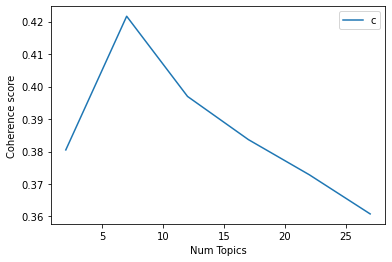

In [57]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3805
index: 1 | Num Topics = 7  has Coherence Value of 0.4217
index: 2 | Num Topics = 12  has Coherence Value of 0.397
index: 3 | Num Topics = 17  has Coherence Value of 0.3837
index: 4 | Num Topics = 22  has Coherence Value of 0.3728
index: 5 | Num Topics = 27  has Coherence Value of 0.3608


In [192]:
# Select optimal number of topics
optimal_model_ph = model_list_ph[1]

In [193]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph = pyLDAvis.gensim_models.prepare(optimal_model_ph, corpus_ph, id2word_ph)

In [194]:
print("pyLDAVis for overall ph topics:")
vis_ph

pyLDAVis for overall ph topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.158287  0.013713       1        1  26.997903
6     -0.074349 -0.105001       2        1  19.531357
3     -0.159087  0.051362       3        1  14.036149
1     -0.064689  0.151549       4        1  12.405169
4     -0.015614 -0.109222       5        1   9.986157
0      0.029003 -0.067685       6        1   9.134537
2      0.126449  0.065283       7        1   7.908728, topic_info=           Term        Freq       Total Category  logprob  loglift
25         back   75.000000   75.000000  Default  30.0000  30.0000
34       filter  150.000000  150.000000  Default  29.0000  29.0000
452         log   74.000000   74.000000  Default  28.0000  28.0000
396  connection   41.000000   41.000000  Default  27.0000  27.0000
65          new   80.000000   80.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
70       friend    3.946151   57.907157   Topic7  -4.9817  -0.1489
66         send    3.443132   27.180218   Topic7  -5.1181   0.4711
310     battery    3.062305   15.658103   Topic7  -5.2353   0.9054
84        thing    3.140912   22.061644   Topic7  -5.2099   0.5879
10       really    3.240653   66.614576   Topic7  -5.1787  -0.4859

[452 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
635       5  0.808197           acc
235       3  0.937099        accept
650       6  0.732090  accidentally
306       1  0.050251       account
306       2  0.138190       account
...     ...       ...           ...
162       1  0.132183           yet
162       2  0.264366           yet
162       5  0.132183           yet
162       6  0.396548           yet
600       5  0.854965          zoom

[730 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 4, 2, 5, 1, 3])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [62]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_ph_score1 = snapchat_ios_ph_review_YearMonth_score1.review.values.tolist()
review_words_ph_score1 = list(sent_to_words(review_ph_score1))
print(review_words_ph_score1[:1])

[['really', 'like', 'snapchat', 'but', 'it', 'messed', 'up', 'my', 'phone', 'everytime', 'and', 'dont', 'know', 'why', 'but', 'everytime', 'open', 'it', 'while', 'im', 'at', 'my', 'phone', 'randomly', 'shut', 'down', 'even', 'if', 'open', 'different', 'apps', 'it', 'shut', 'downs', 'randomly', 'but', 'when', 'deleted', 'it', 'everything', 'is', 'normal', 'don', 'know', 'why', 'this', 'happen']]


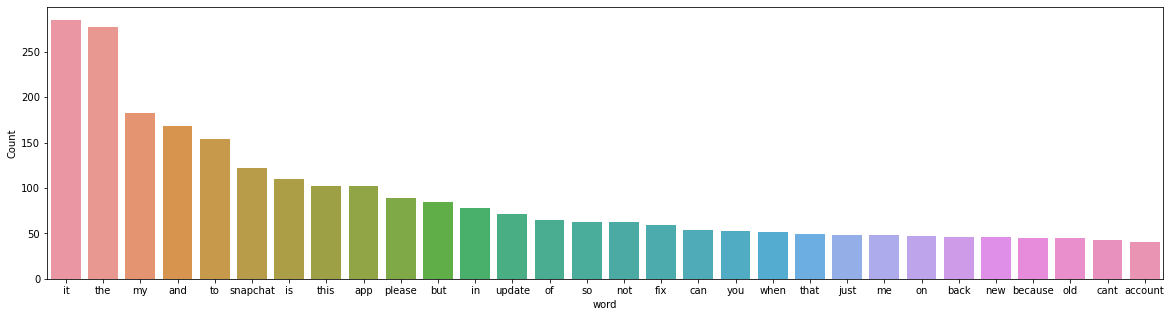

In [63]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score1))

In [64]:
# Clean text
review_ph_ready_score1 = process_words(review_words_ph_score1)  # processed Text Data! - move to each section


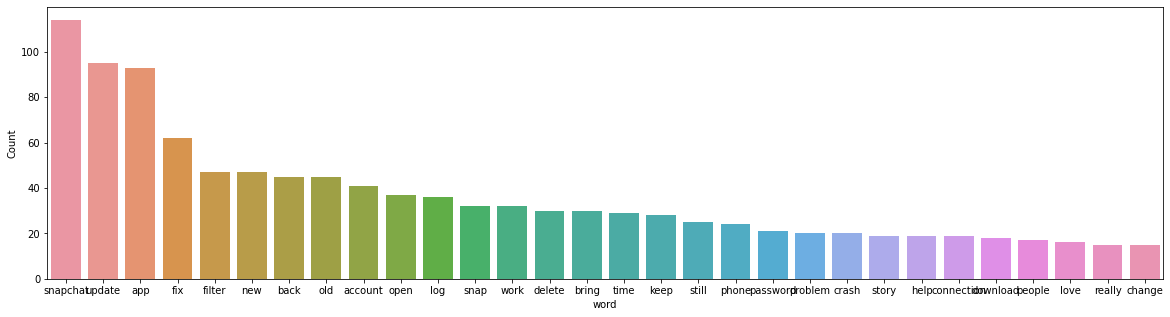

In [65]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score1))


In [66]:
# Create Dictionary
id2word_ph_score1 = corpora.Dictionary(review_ph_ready_score1)

2021-10-16 20:34:58,274 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:34:58,289 [INFO] gensim.corpora.dictionary - built Dictionary(671 unique tokens: ['app', 'delete', 'different', 'everytime', 'happen']...) from 276 documents (total 2622 corpus positions)
2021-10-16 20:34:58,292 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(671 unique tokens: ['app', 'delete', 'different', 'everytime', 'happen']...) from 276 documents (total 2622 corpus positions)", 'datetime': '2021-10-16T20:34:58.292603', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [67]:
# Create Corpus: Term Document Frequency
corpus_ph_score1 = [id2word_ph_score1.doc2bow(text) for text in review_ph_ready_score1]

In [68]:
# Training LDA model
model_list_ph_score1, coherence_values_ph_score1 = compute_coherence_values(dictionary=id2word_ph_score1, corpus=corpus_ph_score1, 
                                                              texts=review_ph_ready_score1, limit=30, start=2, step=5)


2021-10-16 20:34:59,156 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:34:59,159 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:34:59,161 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:34:59,164 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 276 documents, updating model once every 276 documents, evaluating perplexity every 276 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:35:00,870 [INFO] gensim.models.ldamodel - -7.135 per-word bound, 140.6 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:35:00,906 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #276/276
2021-10-16 20:35:02,146 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.044*"snapchat" + 0.041*"update" + 0.022*"new" + 0.017*"app" + 0.015*"fix" + 0.013*"delete" + 0.012*"ba

2021-10-16 20:35:14,883 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"app" + 0.028*"fix" + 0.022*"filter" + 0.021*"snapchat" + 0.018*"open" + 0.016*"log" + 0.016*"account" + 0.016*"time" + 0.013*"work" + 0.012*"connection"
2021-10-16 20:35:14,885 [INFO] gensim.models.ldamodel - topic diff=0.021824, rho=0.301511
2021-10-16 20:35:15,752 [INFO] gensim.models.ldamodel - -5.952 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:35:15,759 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #276/276
2021-10-16 20:35:16,611 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"snapchat" + 0.048*"update" + 0.028*"new" + 0.024*"back" + 0.023*"old" + 0.016*"bring" + 0.013*"delete" + 0.012*"app" + 0.012*"snap" + 0.011*"story"
2021-10-16 20:35:16,617 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"app" + 0.029*"fix" + 0.022*"filter" + 0.022*"snapchat" + 0.018*"open" + 0.017*"log" + 0.016*"account" + 0.

2021-10-16 20:35:26,274 [INFO] gensim.models.ldamodel - topic diff=0.011060, rho=0.218218
2021-10-16 20:35:26,754 [INFO] gensim.models.ldamodel - -5.923 per-word bound, 60.7 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:35:26,755 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #276/276
2021-10-16 20:35:27,125 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"update" + 0.048*"snapchat" + 0.030*"new" + 0.028*"back" + 0.028*"old" + 0.019*"bring" + 0.013*"snap" + 0.012*"delete" + 0.012*"story" + 0.011*"app"
2021-10-16 20:35:27,127 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"app" + 0.032*"fix" + 0.023*"snapchat" + 0.022*"filter" + 0.021*"open" + 0.020*"log" + 0.017*"time" + 0.016*"work" + 0.016*"account" + 0.012*"phone"
2021-10-16 20:35:27,151 [INFO] gensim.models.ldamodel - topic diff=0.010073, rho=0.213201
2021-10-16 20:35:27,577 [INFO] gensim.models.ldamodel - -5.921 per-word bound, 60.6 perplexity estimat

2021-10-16 20:35:35,602 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #276/276
2021-10-16 20:35:36,029 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"update" + 0.048*"snapchat" + 0.031*"new" + 0.029*"back" + 0.029*"old" + 0.020*"bring" + 0.014*"snap" + 0.012*"story" + 0.012*"delete" + 0.010*"account"
2021-10-16 20:35:36,034 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"app" + 0.033*"fix" + 0.023*"snapchat" + 0.022*"filter" + 0.021*"open" + 0.021*"log" + 0.017*"time" + 0.017*"work" + 0.015*"account" + 0.012*"phone"
2021-10-16 20:35:36,036 [INFO] gensim.models.ldamodel - topic diff=0.005518, rho=0.176777
2021-10-16 20:35:36,678 [INFO] gensim.models.ldamodel - -5.915 per-word bound, 60.3 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:35:36,688 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #276/276
2021-10-16 20:35:37,063 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"update" + 0

2021-10-16 20:35:45,217 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"update" + 0.047*"snapchat" + 0.031*"new" + 0.029*"old" + 0.029*"back" + 0.020*"bring" + 0.014*"snap" + 0.013*"story" + 0.012*"delete" + 0.010*"change"
2021-10-16 20:35:45,252 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"app" + 0.033*"fix" + 0.024*"snapchat" + 0.022*"filter" + 0.021*"open" + 0.021*"log" + 0.017*"work" + 0.017*"time" + 0.015*"account" + 0.013*"phone"
2021-10-16 20:35:45,260 [INFO] gensim.models.ldamodel - topic diff=0.004420, rho=0.154303
2021-10-16 20:35:45,682 [INFO] gensim.models.ldamodel - -5.911 per-word bound, 60.2 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:35:45,692 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #276/276
2021-10-16 20:35:46,011 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"update" + 0.047*"snapchat" + 0.031*"new" + 0.029*"old" + 0.029*"back" + 0.020*"bring" + 0.014*"snap" + 0.013

2021-10-16 20:35:52,891 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:35:59,287 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:35:59,349 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 251 virtual documents
2021-10-16 20:35:59,891 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:35:59,892 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:35:59,908 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:35:59,912 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 276 documents, updating model once every 276 documents, evaluating perplexity every 276 documents, iterating 50x with a con

2021-10-16 20:36:04,656 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.073*"update" + 0.066*"snapchat" + 0.042*"new" + 0.026*"back" + 0.023*"old" + 0.020*"delete" + 0.015*"bring" + 0.014*"still" + 0.013*"change" + 0.013*"app"
2021-10-16 20:36:04,658 [INFO] gensim.models.ldamodel - topic diff=0.051313, rho=0.408248
2021-10-16 20:36:05,282 [INFO] gensim.models.ldamodel - -6.246 per-word bound, 75.9 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:36:05,284 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #276/276
2021-10-16 20:36:05,658 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"snapchat" + 0.027*"phone" + 0.026*"work" + 0.023*"account" + 0.020*"filter" + 0.018*"app" + 0.015*"email" + 0.015*"iphone" + 0.015*"whenever" + 0.015*"keep"
2021-10-16 20:36:05,660 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.057*"filter" + 0.032*"app" + 0.029*"fix" + 0.020*"snapchat" + 0.017*"log" + 0.016*"work" + 0.015*"update" 

2021-10-16 20:36:10,791 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.054*"app" + 0.030*"download" + 0.029*"fix" + 0.024*"filter" + 0.020*"work" + 0.016*"snapchat" + 0.013*"delete" + 0.013*"snap" + 0.012*"phone" + 0.012*"keep"
2021-10-16 20:36:10,793 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.031*"password" + 0.024*"app" + 0.023*"log" + 0.021*"check" + 0.020*"internet" + 0.017*"connect" + 0.015*"let" + 0.015*"connection" + 0.014*"fix" + 0.013*"help"
2021-10-16 20:36:10,796 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.053*"app" + 0.041*"log" + 0.032*"fix" + 0.032*"connection" + 0.031*"account" + 0.029*"open" + 0.024*"crash" + 0.024*"time" + 0.023*"keep" + 0.021*"update"
2021-10-16 20:36:10,800 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.074*"update" + 0.066*"snapchat" + 0.046*"new" + 0.030*"back" + 0.027*"old" + 0.020*"delete" + 0.018*"bring" + 0.013*"change" + 0.013*"app" + 0.013*"still"
2021-10-16 20:36:10,802 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 20:36:15,268 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"filter" + 0.031*"app" + 0.029*"fix" + 0.022*"snapchat" + 0.018*"work" + 0.017*"log" + 0.014*"update" + 0.013*"really" + 0.013*"hard" + 0.012*"snap"
2021-10-16 20:36:15,270 [INFO] gensim.models.ldamodel - topic diff=0.009681, rho=0.242536
2021-10-16 20:36:15,907 [INFO] gensim.models.ldamodel - -6.213 per-word bound, 74.2 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:36:15,920 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #276/276
2021-10-16 20:36:16,391 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.074*"update" + 0.068*"snapchat" + 0.047*"new" + 0.035*"back" + 0.032*"old" + 0.022*"bring" + 0.019*"delete" + 0.013*"app" + 0.013*"change" + 0.012*"still"
2021-10-16 20:36:16,392 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.032*"password" + 0.024*"app" + 0.024*"log" + 0.021*"check" + 0.020*"internet" + 0.017*"connect" + 0.016*"let" + 0.

2021-10-16 20:36:21,766 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"password" + 0.025*"app" + 0.024*"log" + 0.021*"check" + 0.021*"internet" + 0.017*"connect" + 0.016*"let" + 0.016*"connection" + 0.015*"fix" + 0.014*"help"
2021-10-16 20:36:21,767 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"snapchat" + 0.026*"open" + 0.025*"fix" + 0.025*"black" + 0.024*"app" + 0.020*"old" + 0.020*"problem" + 0.019*"time" + 0.017*"screen" + 0.017*"phone"
2021-10-16 20:36:21,769 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"phone" + 0.029*"snapchat" + 0.028*"account" + 0.023*"work" + 0.018*"lock" + 0.018*"app" + 0.018*"email" + 0.017*"filter" + 0.016*"iphone" + 0.015*"permanently"
2021-10-16 20:36:21,771 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.054*"app" + 0.033*"download" + 0.026*"fix" + 0.025*"filter" + 0.020*"work" + 0.017*"snapchat" + 0.014*"delete" + 0.012*"phone" + 0.011*"snap" + 0.011*"update"
2021-10-16 20:36:21,772 [INFO] gensim.models.ldamodel - to

2021-10-16 20:36:26,954 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"phone" + 0.029*"account" + 0.028*"snapchat" + 0.023*"work" + 0.018*"lock" + 0.018*"email" + 0.018*"app" + 0.016*"filter" + 0.016*"iphone" + 0.015*"permanently"
2021-10-16 20:36:26,956 [INFO] gensim.models.ldamodel - topic diff=0.004509, rho=0.188982
2021-10-16 20:36:27,569 [INFO] gensim.models.ldamodel - -6.197 per-word bound, 73.4 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:36:27,571 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #276/276
2021-10-16 20:36:28,100 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"phone" + 0.029*"account" + 0.028*"snapchat" + 0.023*"work" + 0.018*"lock" + 0.018*"email" + 0.018*"app" + 0.016*"filter" + 0.016*"iphone" + 0.015*"permanently"
2021-10-16 20:36:28,126 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"snapchat" + 0.028*"black" + 0.027*"open" + 0.026*"fix" + 0.025*"app" + 0.020*"problem" 

2021-10-16 20:36:35,261 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"snapchat" + 0.029*"black" + 0.027*"open" + 0.027*"fix" + 0.025*"app" + 0.020*"problem" + 0.019*"time" + 0.019*"screen" + 0.017*"phone" + 0.014*"old"
2021-10-16 20:36:35,263 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.055*"app" + 0.037*"log" + 0.035*"fix" + 0.033*"open" + 0.032*"keep" + 0.029*"crash" + 0.029*"account" + 0.028*"connection" + 0.028*"time" + 0.020*"update"
2021-10-16 20:36:35,266 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.074*"update" + 0.068*"snapchat" + 0.047*"new" + 0.044*"back" + 0.039*"old" + 0.031*"bring" + 0.019*"delete" + 0.013*"snap" + 0.013*"change" + 0.013*"people"
2021-10-16 20:36:35,269 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.055*"app" + 0.034*"download" + 0.026*"fix" + 0.025*"filter" + 0.020*"work" + 0.017*"snapchat" + 0.013*"delete" + 0.013*"phone" + 0.011*"update" + 0.011*"snap"
2021-10-16 20:36:35,285 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 20:36:40,207 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"snapchat" + 0.029*"black" + 0.028*"fix" + 0.028*"open" + 0.025*"app" + 0.021*"problem" + 0.020*"time" + 0.019*"screen" + 0.017*"phone" + 0.013*"white"
2021-10-16 20:36:40,208 [INFO] gensim.models.ldamodel - topic diff=0.003349, rho=0.160128
2021-10-16 20:36:40,712 [INFO] gensim.models.ldamodel - -6.190 per-word bound, 73.0 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:36:40,716 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #276/276
2021-10-16 20:36:41,038 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"account" + 0.030*"phone" + 0.027*"snapchat" + 0.023*"work" + 0.019*"email" + 0.018*"lock" + 0.018*"app" + 0.016*"filter" + 0.015*"iphone" + 0.015*"permanently"
2021-10-16 20:36:41,041 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.055*"app" + 0.034*"download" + 0.026*"fix" + 0.025*"filter" + 0.020*"work" + 0.017*"snapchat" + 0.013

2021-10-16 20:36:45,102 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.072*"filter" + 0.031*"fix" + 0.023*"app" + 0.022*"snapchat" + 0.019*"work" + 0.015*"log" + 0.015*"snap" + 0.014*"update" + 0.013*"hard" + 0.013*"really"
2021-10-16 20:36:45,105 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"app" + 0.038*"log" + 0.035*"open" + 0.033*"fix" + 0.032*"keep" + 0.030*"account" + 0.029*"time" + 0.029*"crash" + 0.028*"connection" + 0.019*"update"
2021-10-16 20:36:45,107 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"snapchat" + 0.030*"black" + 0.029*"fix" + 0.028*"open" + 0.026*"app" + 0.022*"problem" + 0.020*"time" + 0.019*"screen" + 0.018*"phone" + 0.013*"white"
2021-10-16 20:36:45,110 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"password" + 0.025*"app" + 0.024*"log" + 0.022*"check" + 0.021*"internet" + 0.018*"connect" + 0.017*"let" + 0.016*"connection" + 0.015*"fix" + 0.014*"help"
2021-10-16 20:36:45,112 [INFO] gensim.models.ldamodel - topic diff=0.002

2021-10-16 20:36:49,242 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.073*"filter" + 0.031*"fix" + 0.022*"snapchat" + 0.022*"app" + 0.019*"work" + 0.015*"snap" + 0.015*"log" + 0.014*"update" + 0.014*"hard" + 0.013*"really"
2021-10-16 20:36:49,264 [INFO] gensim.models.ldamodel - topic diff=0.001990, rho=0.141421
2021-10-16 20:36:49,567 [INFO] gensim.models.ldamodel - -6.184 per-word bound, 72.7 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:36:49,574 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #276/276
2021-10-16 20:36:49,776 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.073*"filter" + 0.031*"fix" + 0.022*"snapchat" + 0.022*"app" + 0.019*"work" + 0.015*"snap" + 0.015*"log" + 0.014*"update" + 0.014*"hard" + 0.013*"really"
2021-10-16 20:36:49,778 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.058*"app" + 0.038*"log" + 0.035*"open" + 0.033*"fix" + 0.032*"keep" + 0.030*"crash" + 0.030*"account" + 0.030*"time"

2021-10-16 20:37:00,843 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.073*"update" + 0.065*"snapchat" + 0.063*"new" + 0.057*"back" + 0.051*"old" + 0.041*"bring" + 0.025*"change" + 0.016*"bad" + 0.015*"hate" + 0.014*"look"
2021-10-16 20:37:00,847 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.025*"play" + 0.025*"filter" + 0.023*"video" + 0.018*"fix" + 0.017*"open" + 0.017*"anymore" + 0.017*"happen" + 0.016*"crush" + 0.016*"ipad" + 0.015*"record"
2021-10-16 20:37:00,850 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"snapchat" + 0.030*"delete" + 0.027*"snap" + 0.025*"black" + 0.018*"app" + 0.017*"filter" + 0.017*"time" + 0.017*"people" + 0.015*"download" + 0.014*"name"
2021-10-16 20:37:00,854 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.053*"app" + 0.036*"snapchat" + 0.028*"update" + 0.025*"story" + 0.021*"hard" + 0.020*"old" + 0.019*"love" + 0.017*"work" + 0.017*"back" + 0.015*"really"
2021-10-16 20:37:00,859 [INFO] gensim.models.ldamodel - topic diff=0.07247

2021-10-16 20:37:04,057 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.078*"update" + 0.069*"back" + 0.069*"old" + 0.068*"new" + 0.064*"snapchat" + 0.051*"bring" + 0.024*"change" + 0.017*"bad" + 0.014*"hate" + 0.014*"look"
2021-10-16 20:37:04,058 [INFO] gensim.models.ldamodel - topic diff=0.029215, rho=0.316228
2021-10-16 20:37:04,270 [INFO] gensim.models.ldamodel - -6.333 per-word bound, 80.6 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:37:04,271 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #276/276
2021-10-16 20:37:04,684 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.036*"app" + 0.035*"fix" + 0.028*"snapchat" + 0.020*"filter" + 0.019*"snap" + 0.018*"iphone" + 0.014*"download" + 0.014*"fast" + 0.014*"wrong" + 0.011*"password"
2021-10-16 20:37:04,690 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.049*"snapchat" + 0.040*"delete" + 0.027*"snap" + 0.024*"black" + 0.020*"people" + 0.017*"app" + 0.016*"time" 

2021-10-16 20:37:08,362 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.050*"snapchat" + 0.044*"delete" + 0.028*"snap" + 0.023*"black" + 0.022*"people" + 0.017*"app" + 0.015*"time" + 0.014*"name" + 0.014*"screen" + 0.014*"let"
2021-10-16 20:37:08,370 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.026*"play" + 0.026*"filter" + 0.026*"video" + 0.017*"fix" + 0.017*"open" + 0.017*"anymore" + 0.017*"ipad" + 0.017*"crush" + 0.017*"record" + 0.010*"close"
2021-10-16 20:37:08,379 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.034*"fix" + 0.033*"app" + 0.027*"snapchat" + 0.020*"filter" + 0.019*"iphone" + 0.018*"snap" + 0.014*"download" + 0.014*"fast" + 0.014*"wrong" + 0.011*"password"
2021-10-16 20:37:08,382 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.142*"filter" + 0.043*"work" + 0.037*"snapchat" + 0.030*"fix" + 0.026*"time" + 0.026*"crash" + 0.024*"app" + 0.019*"still" + 0.018*"new" + 0.017*"face"
2021-10-16 20:37:08,385 [INFO] gensim.models.ldamodel - topic diff=0.0136

2021-10-16 20:37:12,971 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.034*"fix" + 0.031*"app" + 0.027*"snapchat" + 0.020*"filter" + 0.018*"snap" + 0.017*"iphone" + 0.015*"download" + 0.015*"fast" + 0.015*"wrong" + 0.011*"password"
2021-10-16 20:37:12,973 [INFO] gensim.models.ldamodel - topic diff=0.007806, rho=0.218218
2021-10-16 20:37:13,464 [INFO] gensim.models.ldamodel - -6.294 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:37:13,465 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #276/276
2021-10-16 20:37:13,722 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.082*"old" + 0.079*"update" + 0.076*"back" + 0.071*"new" + 0.063*"snapchat" + 0.056*"bring" + 0.023*"change" + 0.018*"bad" + 0.016*"version" + 0.014*"hate"
2021-10-16 20:37:13,749 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.083*"update" + 0.058*"app" + 0.044*"open" + 0.043*"snapchat" + 0.035*"fix" + 0.024*"download" + 0.022*"del

2021-10-16 20:37:16,852 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.041*"connect" + 0.040*"internet" + 0.038*"log" + 0.037*"connection" + 0.034*"check" + 0.020*"fix" + 0.015*"account" + 0.015*"app" + 0.014*"send" + 0.014*"really"
2021-10-16 20:37:16,861 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.148*"filter" + 0.050*"work" + 0.039*"snapchat" + 0.034*"fix" + 0.024*"iphone" + 0.022*"time" + 0.021*"app" + 0.018*"new" + 0.017*"crash" + 0.017*"face"
2021-10-16 20:37:16,864 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"app" + 0.042*"story" + 0.029*"snapchat" + 0.027*"hard" + 0.025*"love" + 0.024*"update" + 0.017*"friend" + 0.017*"send" + 0.016*"really" + 0.014*"snap"
2021-10-16 20:37:16,868 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.068*"account" + 0.066*"log" + 0.034*"snapchat" + 0.027*"password" + 0.024*"app" + 0.021*"fix" + 0.020*"connection" + 0.019*"help" + 0.019*"time" + 0.018*"number"
2021-10-16 20:37:16,870 [INFO] gensim.models.ldamodel - topic #

2021-10-16 20:37:20,451 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"app" + 0.042*"story" + 0.029*"snapchat" + 0.028*"hard" + 0.026*"love" + 0.024*"update" + 0.017*"friend" + 0.017*"send" + 0.016*"really" + 0.013*"snap"
2021-10-16 20:37:20,453 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.035*"fix" + 0.030*"app" + 0.027*"snapchat" + 0.020*"filter" + 0.019*"snap" + 0.015*"iphone" + 0.015*"download" + 0.015*"fast" + 0.015*"wrong" + 0.011*"password"
2021-10-16 20:37:20,457 [INFO] gensim.models.ldamodel - topic diff=0.002715, rho=0.176777
2021-10-16 20:37:20,842 [INFO] gensim.models.ldamodel - -6.285 per-word bound, 78.0 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:37:20,845 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #276/276
2021-10-16 20:37:21,003 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.082*"update" + 0.059*"app" + 0.048*"open" + 0.043*"snapchat" + 0.035*"fix" + 0.024*"download" + 0.022*"de

2021-10-16 20:37:24,043 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #276/276
2021-10-16 20:37:24,319 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.035*"fix" + 0.029*"app" + 0.027*"snapchat" + 0.020*"filter" + 0.019*"snap" + 0.015*"iphone" + 0.015*"download" + 0.015*"fast" + 0.015*"wrong" + 0.011*"password"
2021-10-16 20:37:24,321 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.032*"fix" + 0.031*"open" + 0.029*"app" + 0.027*"snapchat" + 0.025*"problem" + 0.021*"phone" + 0.021*"time" + 0.016*"message" + 0.016*"connection" + 0.013*"password"
2021-10-16 20:37:24,323 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.041*"connect" + 0.040*"internet" + 0.038*"log" + 0.037*"connection" + 0.034*"check" + 0.021*"fix" + 0.015*"account" + 0.015*"app" + 0.014*"send" + 0.014*"really"
2021-10-16 20:37:24,326 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.068*"account" + 0.066*"log" + 0.034*"snapchat" + 0.027*"password" + 0.024*"app" + 0.021*"fix" + 0.020*"connecti

2021-10-16 20:37:27,684 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.080*"update" + 0.061*"app" + 0.049*"open" + 0.044*"snapchat" + 0.035*"fix" + 0.023*"download" + 0.021*"delete" + 0.019*"still" + 0.017*"crash" + 0.017*"keep"
2021-10-16 20:37:27,687 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.032*"fix" + 0.031*"open" + 0.029*"app" + 0.027*"snapchat" + 0.025*"problem" + 0.021*"phone" + 0.021*"time" + 0.016*"message" + 0.016*"connection" + 0.013*"password"
2021-10-16 20:37:27,688 [INFO] gensim.models.ldamodel - topic diff=0.001603, rho=0.152499
2021-10-16 20:37:28,035 [INFO] gensim.models.ldamodel - -6.281 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:37:28,036 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #276/276
2021-10-16 20:37:28,330 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.053*"snapchat" + 0.051*"delete" + 0.031*"snap" + 0.025*"people" + 0.022*"black" + 0.017*"app" + 0.

2021-10-16 20:37:31,879 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #276/276
2021-10-16 20:37:32,211 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.055*"crash" + 0.051*"keep" + 0.030*"email" + 0.029*"app" + 0.024*"video" + 0.023*"whenever" + 0.023*"phone" + 0.018*"update" + 0.015*"work" + 0.012*"number"
2021-10-16 20:37:32,214 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.035*"fix" + 0.029*"app" + 0.027*"snapchat" + 0.020*"filter" + 0.019*"snap" + 0.015*"iphone" + 0.015*"download" + 0.015*"fast" + 0.015*"wrong" + 0.011*"password"
2021-10-16 20:37:32,217 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.052*"app" + 0.043*"story" + 0.028*"hard" + 0.027*"snapchat" + 0.026*"love" + 0.025*"update" + 0.018*"friend" + 0.018*"send" + 0.016*"really" + 0.013*"snap"
2021-10-16 20:37:32,220 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.080*"update" + 0.061*"app" + 0.049*"open" + 0.045*"snapchat" + 0.035*"fix" + 0.023*"download" + 0.021*"delete" + 0.019*"still"

2021-10-16 20:37:45,453 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.056*"filter" + 0.036*"app" + 0.031*"fix" + 0.028*"lock" + 0.028*"really" + 0.025*"permanently" + 0.021*"reason" + 0.021*"face" + 0.018*"new" + 0.017*"picture"
2021-10-16 20:37:45,455 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.048*"update" + 0.045*"app" + 0.034*"new" + 0.028*"back" + 0.028*"old" + 0.021*"open" + 0.021*"bring" + 0.017*"work" + 0.014*"whenever" + 0.014*"close"
2021-10-16 20:37:45,456 [INFO] gensim.models.ldamodel - topic diff=0.148091, rho=0.577350
2021-10-16 20:37:45,840 [INFO] gensim.models.ldamodel - -6.654 per-word bound, 100.7 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:37:45,841 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #276/276
2021-10-16 20:37:46,140 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.051*"snapchat" + 0.048*"new" + 0.031*"update" + 0.027*"hate" + 0.018*"change" + 0.017*"snap" + 0.012*"account"

2021-10-16 20:37:49,700 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #276/276
2021-10-16 20:37:50,164 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.037*"log" + 0.037*"fix" + 0.023*"delete" + 0.023*"people" + 0.023*"snapchat" + 0.023*"account" + 0.023*"hope" + 0.022*"filter" + 0.015*"app" + 0.015*"snap"
2021-10-16 20:37:50,166 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.093*"filter" + 0.031*"video" + 0.025*"iphone" + 0.025*"save" + 0.024*"work" + 0.018*"snapchat" + 0.017*"phone" + 0.017*"continue" + 0.017*"problem" + 0.017*"hate"
2021-10-16 20:37:50,168 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.057*"filter" + 0.037*"lock" + 0.036*"app" + 0.031*"fix" + 0.031*"face" + 0.030*"really" + 0.030*"permanently" + 0.023*"reason" + 0.017*"snapchat" + 0.016*"picture"
2021-10-16 20:37:50,170 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.099*"old" + 0.098*"back" + 0.091*"bring" + 0.054*"new" + 0.052*"snapchat" + 0.043*"update" + 0.023*"version" + 0.020

2021-10-16 20:37:54,627 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.076*"snapchat" + 0.056*"update" + 0.032*"new" + 0.025*"change" + 0.025*"fix" + 0.021*"bad" + 0.020*"delete" + 0.019*"black" + 0.017*"still" + 0.017*"back"
2021-10-16 20:37:54,630 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.051*"connect" + 0.043*"app" + 0.030*"snapchat" + 0.030*"help" + 0.029*"let" + 0.029*"connection" + 0.029*"log" + 0.027*"internet" + 0.022*"instal" + 0.022*"happen"
2021-10-16 20:37:54,632 [INFO] gensim.models.ldamodel - topic diff=0.021016, rho=0.267261
2021-10-16 20:37:55,005 [INFO] gensim.models.ldamodel - -6.458 per-word bound, 87.9 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:37:55,008 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #276/276
2021-10-16 20:37:55,232 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.037*"post" + 0.023*"fix" + 0.022*"filter" + 0.022*"play" + 0.022*"screenshot" + 0.021*"pic" + 0.020*"is

2021-10-16 20:37:58,209 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #276/276
2021-10-16 20:37:58,446 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.037*"post" + 0.023*"fix" + 0.022*"filter" + 0.022*"play" + 0.022*"screenshot" + 0.022*"pic" + 0.020*"issue" + 0.014*"update" + 0.011*"app" + 0.011*"damn"
2021-10-16 20:37:58,447 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.043*"memory" + 0.029*"snapchat" + 0.027*"open" + 0.026*"app" + 0.022*"keep" + 0.022*"update" + 0.016*"happen" + 0.016*"help" + 0.016*"close" + 0.016*"recover"
2021-10-16 20:37:58,449 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.042*"update" + 0.033*"open" + 0.033*"snap" + 0.033*"message" + 0.032*"app" + 0.029*"keep" + 0.022*"story" + 0.017*"view" + 0.010*"new" + 0.009*"fix"
2021-10-16 20:37:58,451 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.121*"filter" + 0.032*"video" + 0.031*"iphone" + 0.029*"work" + 0.026*"save" + 0.019*"snapchat" + 0.018*"phone" + 0.018*"continue" + 0.018

2021-10-16 20:38:02,429 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.082*"update" + 0.080*"app" + 0.044*"snapchat" + 0.042*"fix" + 0.038*"download" + 0.032*"open" + 0.023*"delete" + 0.020*"filter" + 0.019*"phone" + 0.015*"screen"
2021-10-16 20:38:02,431 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.056*"new" + 0.050*"snapchat" + 0.038*"update" + 0.033*"hate" + 0.022*"change" + 0.017*"snap" + 0.016*"like" + 0.011*"account" + 0.011*"everytime" + 0.011*"time"
2021-10-16 20:38:02,432 [INFO] gensim.models.ldamodel - topic diff=0.007218, rho=0.200000
2021-10-16 20:38:02,969 [INFO] gensim.models.ldamodel - -6.423 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:38:02,973 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #276/276
2021-10-16 20:38:03,296 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.043*"memory" + 0.029*"snapchat" + 0.027*"open" + 0.026*"app" + 0.022*"keep" + 0.022*"update" + 0.01

2021-10-16 20:38:06,323 [INFO] gensim.models.ldamodel - -6.415 per-word bound, 85.4 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:38:06,326 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #276/276
2021-10-16 20:38:06,529 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.075*"snapchat" + 0.055*"update" + 0.027*"fix" + 0.024*"bad" + 0.023*"ever" + 0.022*"new" + 0.022*"change" + 0.020*"delete" + 0.019*"black" + 0.018*"still"
2021-10-16 20:38:06,530 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.082*"update" + 0.081*"app" + 0.044*"snapchat" + 0.043*"fix" + 0.038*"download" + 0.032*"open" + 0.023*"delete" + 0.020*"filter" + 0.019*"phone" + 0.015*"screen"
2021-10-16 20:38:06,538 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.116*"back" + 0.115*"old" + 0.091*"bring" + 0.068*"new" + 0.058*"update" + 0.056*"snapchat" + 0.028*"version" + 0.019*"story" + 0.017*"email" + 0.014*"number"
2021-10-16 20:38:06,541 [INFO] gensim

2021-10-16 20:38:10,930 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.063*"filter" + 0.038*"lock" + 0.035*"app" + 0.031*"fix" + 0.031*"face" + 0.031*"permanently" + 0.030*"really" + 0.024*"reason" + 0.022*"find" + 0.017*"snapchat"
2021-10-16 20:38:10,932 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.038*"log" + 0.038*"fix" + 0.023*"delete" + 0.023*"people" + 0.023*"snapchat" + 0.023*"account" + 0.023*"hope" + 0.023*"filter" + 0.015*"app" + 0.015*"start"
2021-10-16 20:38:10,933 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.055*"app" + 0.030*"open" + 0.020*"work" + 0.020*"close" + 0.020*"log" + 0.020*"phone" + 0.020*"whenever" + 0.020*"update" + 0.011*"snapchat" + 0.010*"fine"
2021-10-16 20:38:10,934 [INFO] gensim.models.ldamodel - topic diff=0.003362, rho=0.166667
2021-10-16 20:38:11,626 [INFO] gensim.models.ldamodel - -6.411 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:38:11,665 [INFO] gensim.mode

2021-10-16 20:38:17,419 [INFO] gensim.models.ldamodel - topic diff=0.002540, rho=0.156174
2021-10-16 20:38:18,156 [INFO] gensim.models.ldamodel - -6.411 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:38:18,171 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #276/276
2021-10-16 20:38:18,505 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.028*"bad" + 0.028*"send" + 0.025*"app" + 0.025*"interface" + 0.021*"snap" + 0.021*"yet" + 0.021*"friend" + 0.021*"message" + 0.020*"story" + 0.019*"people"
2021-10-16 20:38:18,507 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.037*"post" + 0.023*"fix" + 0.022*"filter" + 0.022*"play" + 0.022*"screenshot" + 0.022*"pic" + 0.020*"issue" + 0.014*"update" + 0.011*"app" + 0.011*"damn"
2021-10-16 20:38:18,509 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.141*"filter" + 0.040*"work" + 0.031*"iphone" + 0.030*"video" + 0.026*"save" + 0.026*"snapchat" + 0.017*"phone" +

2021-10-16 20:38:23,351 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.044*"memory" + 0.029*"snapchat" + 0.023*"open" + 0.022*"keep" + 0.020*"app" + 0.019*"update" + 0.017*"happen" + 0.017*"help" + 0.017*"close" + 0.017*"crush"
2021-10-16 20:38:23,355 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.052*"connect" + 0.037*"help" + 0.037*"app" + 0.033*"snapchat" + 0.030*"log" + 0.030*"connection" + 0.030*"let" + 0.026*"internet" + 0.023*"happen" + 0.023*"instal"
2021-10-16 20:38:23,358 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.063*"filter" + 0.038*"lock" + 0.035*"app" + 0.032*"fix" + 0.032*"face" + 0.031*"permanently" + 0.030*"really" + 0.024*"reason" + 0.022*"find" + 0.017*"snapchat"
2021-10-16 20:38:23,360 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.038*"log" + 0.038*"fix" + 0.023*"delete" + 0.023*"snapchat" + 0.023*"people" + 0.023*"account" + 0.023*"hope" + 0.019*"filter" + 0.015*"let" + 0.015*"app"
2021-10-16 20:38:23,361 [INFO] gensim.models.ldamodel - to

2021-10-16 20:38:39,816 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 276 documents, updating model once every 276 documents, evaluating perplexity every 276 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:38:40,879 [INFO] gensim.models.ldamodel - -17.237 per-word bound, 154436.4 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:38:40,881 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #276/276
2021-10-16 20:38:41,476 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.028*"email" + 0.025*"filter" + 0.025*"phone" + 0.022*"account" + 0.022*"update" + 0.021*"password" + 0.019*"post" + 0.019*"sign" + 0.019*"fix" + 0.019*"connection"
2021-10-16 20:38:41,509 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.081*"snapchat" + 0.057*"back" + 0.053*"old" + 0.047*"bring" + 0.032*"filter" + 0.025*"fix" + 0.021*"update" + 0.018*"

2021-10-16 20:38:45,946 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.056*"new" + 0.055*"snapchat" + 0.044*"change" + 0.042*"hate" + 0.037*"update" + 0.032*"account" + 0.023*"help" + 0.020*"password" + 0.018*"back" + 0.018*"old"
2021-10-16 20:38:45,947 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.048*"app" + 0.021*"fix" + 0.021*"snapchat" + 0.021*"snap" + 0.020*"filter" + 0.016*"name" + 0.016*"download" + 0.016*"update" + 0.016*"iphone" + 0.014*"work"
2021-10-16 20:38:45,950 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.057*"memory" + 0.040*"help" + 0.035*"snapchat" + 0.032*"keep" + 0.023*"connection" + 0.022*"happen" + 0.020*"app" + 0.017*"sign" + 0.017*"literally" + 0.017*"find"
2021-10-16 20:38:45,951 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.059*"snapchat" + 0.032*"delete" + 0.024*"interface" + 0.024*"fix" + 0.024*"white" + 0.024*"still" + 0.023*"storage" + 0.023*"black" + 0.023*"time" + 0.023*"thick"
2021-10-16 20:38:45,953 [INFO] gensim.models.ldamo

2021-10-16 20:38:49,568 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.044*"snap" + 0.039*"snapchat" + 0.038*"app" + 0.026*"friend" + 0.025*"fix" + 0.020*"hard" + 0.020*"time" + 0.020*"people" + 0.020*"bad" + 0.014*"update"
2021-10-16 20:38:49,571 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.042*"phone" + 0.036*"email" + 0.029*"sign" + 0.029*"fix" + 0.028*"filter" + 0.022*"post" + 0.022*"connection" + 0.016*"password" + 0.016*"account" + 0.015*"app"
2021-10-16 20:38:49,572 [INFO] gensim.models.ldamodel - topic diff=0.030120, rho=0.288675
2021-10-16 20:38:49,930 [INFO] gensim.models.ldamodel - -6.520 per-word bound, 91.8 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:38:49,932 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #276/276
2021-10-16 20:38:50,190 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.048*"app" + 0.022*"fix" + 0.022*"snapchat" + 0.022*"snap" + 0.017*"name" + 0.017*"download" + 0.017*"filter

2021-10-16 20:38:54,060 [INFO] gensim.models.ldamodel - -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:38:54,061 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #276/276
2021-10-16 20:38:54,311 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.151*"filter" + 0.062*"work" + 0.055*"fix" + 0.035*"update" + 0.032*"snapchat" + 0.023*"app" + 0.022*"face" + 0.015*"female" + 0.015*"lens" + 0.015*"picture"
2021-10-16 20:38:54,313 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.047*"app" + 0.023*"fix" + 0.023*"snapchat" + 0.023*"snap" + 0.017*"download" + 0.017*"name" + 0.015*"filter" + 0.013*"update" + 0.013*"work" + 0.012*"iphone"
2021-10-16 20:38:54,314 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.117*"back" + 0.117*"old" + 0.093*"bring" + 0.077*"snapchat" + 0.050*"update" + 0.046*"new" + 0.030*"filter" + 0.026*"version" + 0.021*"story" + 0.015*"fix"
2021-10-16 20:38:54,318 [INFO] gensim.mo

2021-10-16 20:38:58,312 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.026*"screenshot" + 0.026*"conversation" + 0.020*"snapchat" + 0.020*"filter" + 0.019*"save" + 0.018*"update" + 0.013*"keep" + 0.013*"friend" + 0.013*"number" + 0.013*"clearly"
2021-10-16 20:38:58,315 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.051*"app" + 0.048*"connect" + 0.034*"update" + 0.028*"help" + 0.021*"internet" + 0.021*"log" + 0.021*"let" + 0.021*"io" + 0.015*"connection" + 0.015*"snapchat"
2021-10-16 20:38:58,317 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.054*"account" + 0.051*"log" + 0.039*"play" + 0.029*"app" + 0.026*"fix" + 0.026*"error" + 0.026*"connection" + 0.026*"wonder" + 0.013*"small" + 0.013*"galaxy"
2021-10-16 20:38:58,318 [INFO] gensim.models.ldamodel - topic diff=0.004917, rho=0.208514
2021-10-16 20:38:58,797 [INFO] gensim.models.ldamodel - -6.501 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:38:58,804 

2021-10-16 20:39:02,724 [INFO] gensim.models.ldamodel - topic diff=0.002391, rho=0.188982
2021-10-16 20:39:03,441 [INFO] gensim.models.ldamodel - -6.498 per-word bound, 90.4 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:39:03,442 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #276/276
2021-10-16 20:39:03,690 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.062*"password" + 0.038*"incorrect" + 0.026*"much" + 0.026*"time" + 0.026*"log" + 0.026*"correct" + 0.026*"snapchat" + 0.013*"email" + 0.013*"extremely" + 0.013*"disgusting"
2021-10-16 20:39:03,693 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.060*"snapchat" + 0.033*"update" + 0.024*"app" + 0.021*"phone" + 0.020*"snap" + 0.020*"uninstall" + 0.020*"chat" + 0.020*"camera" + 0.014*"new" + 0.013*"low"
2021-10-16 20:39:03,695 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.091*"update" + 0.050*"whenever" + 0.050*"snapchat" + 0.044*"work" + 0.034*"new" + 0.025*"a

2021-10-16 20:39:07,362 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.052*"account" + 0.051*"log" + 0.039*"play" + 0.029*"app" + 0.026*"fix" + 0.026*"error" + 0.026*"connection" + 0.026*"wonder" + 0.013*"small" + 0.013*"galaxy"
2021-10-16 20:39:07,368 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.056*"memory" + 0.046*"help" + 0.043*"keep" + 0.037*"snapchat" + 0.024*"happen" + 0.024*"recover" + 0.023*"connection" + 0.023*"app" + 0.021*"sign" + 0.016*"literally"
2021-10-16 20:39:07,369 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.062*"password" + 0.038*"incorrect" + 0.026*"much" + 0.026*"time" + 0.026*"log" + 0.026*"correct" + 0.026*"snapchat" + 0.013*"email" + 0.013*"application" + 0.013*"disgusting"
2021-10-16 20:39:07,373 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.041*"password" + 0.041*"wrong" + 0.021*"black" + 0.021*"pic" + 0.021*"website" + 0.021*"login" + 0.021*"change" + 0.021*"reset" + 0.021*"forgot" + 0.021*"always"
2021-10-16 20:39:07,375 [INFO] g

2021-10-16 20:39:11,391 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.151*"filter" + 0.063*"work" + 0.055*"fix" + 0.035*"update" + 0.032*"snapchat" + 0.023*"app" + 0.022*"face" + 0.015*"female" + 0.015*"lens" + 0.015*"picture"
2021-10-16 20:39:11,399 [INFO] gensim.models.ldamodel - topic diff=0.001082, rho=0.160128
2021-10-16 20:39:11,930 [INFO] gensim.models.ldamodel - -6.495 per-word bound, 90.2 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:39:11,931 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #276/276
2021-10-16 20:39:12,189 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.044*"snapchat" + 0.039*"problem" + 0.028*"fix" + 0.025*"app" + 0.022*"open" + 0.022*"update" + 0.018*"account" + 0.017*"old" + 0.017*"black" + 0.015*"people"
2021-10-16 20:39:12,193 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.026*"screenshot" + 0.026*"conversation" + 0.020*"snapchat" + 0.020*"filter" + 0.019*"save" + 0.017*"update

2021-10-16 20:39:15,749 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #276/276
2021-10-16 20:39:15,991 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.052*"account" + 0.051*"log" + 0.039*"play" + 0.029*"app" + 0.026*"fix" + 0.026*"error" + 0.026*"connection" + 0.026*"wonder" + 0.013*"small" + 0.013*"galaxy"
2021-10-16 20:39:15,999 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.041*"password" + 0.041*"wrong" + 0.021*"black" + 0.021*"pic" + 0.021*"website" + 0.021*"login" + 0.021*"change" + 0.021*"reset" + 0.021*"forgot" + 0.021*"always"
2021-10-16 20:39:16,016 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.086*"update" + 0.044*"new" + 0.040*"open" + 0.040*"message" + 0.020*"terrible" + 0.020*"send" + 0.020*"yet" + 0.020*"review" + 0.020*"glitch" + 0.020*"change"
2021-10-16 20:39:16,021 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.045*"snap" + 0.038*"snapchat" + 0.037*"app" + 0.027*"friend" + 0.026*"fix" + 0.020*"hard" + 0.020*"time" + 0.020*"peopl

2021-10-16 20:39:19,836 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.062*"password" + 0.038*"incorrect" + 0.026*"log" + 0.026*"time" + 0.026*"much" + 0.026*"correct" + 0.026*"snapchat" + 0.013*"email" + 0.013*"change" + 0.013*"response"
2021-10-16 20:39:19,840 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.087*"log" + 0.044*"account" + 0.040*"fix" + 0.027*"snapchat" + 0.025*"connection" + 0.021*"delete" + 0.021*"app" + 0.021*"snap" + 0.020*"time" + 0.018*"people"
2021-10-16 20:39:19,844 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.041*"password" + 0.041*"wrong" + 0.021*"black" + 0.021*"reset" + 0.021*"login" + 0.021*"website" + 0.021*"change" + 0.021*"forgot" + 0.021*"pic" + 0.021*"always"
2021-10-16 20:39:19,845 [INFO] gensim.models.ldamodel - topic diff=0.000582, rho=0.141421
2021-10-16 20:39:20,210 [INFO] gensim.models.ldamodel - -6.493 per-word bound, 90.1 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:39:20,211 [

2021-10-16 20:39:35,990 [INFO] gensim.models.ldamodel - topic diff=0.145059, rho=0.500000
2021-10-16 20:39:36,518 [INFO] gensim.models.ldamodel - -6.852 per-word bound, 115.5 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:39:36,530 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #276/276
2021-10-16 20:39:36,818 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.056*"memory" + 0.038*"help" + 0.033*"snapchat" + 0.033*"app" + 0.024*"keep" + 0.024*"connection" + 0.023*"sign" + 0.017*"error" + 0.017*"issue" + 0.016*"literally"
2021-10-16 20:39:36,820 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.051*"update" + 0.040*"app" + 0.038*"snapchat" + 0.035*"old" + 0.035*"new" + 0.032*"filter" + 0.032*"really" + 0.032*"fix" + 0.032*"face" + 0.030*"love"
2021-10-16 20:39:36,822 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.126*"back" + 0.105*"old" + 0.105*"bring" + 0.054*"snapchat" + 0.034*"update" + 0.029*"filter" + 0.028*"n

2021-10-16 20:39:41,524 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.035*"app" + 0.034*"asap" + 0.034*"fix" + 0.034*"redownloaded" + 0.034*"open" + 0.002*"memory" + 0.002*"snapchat" + 0.002*"happen" + 0.002*"really" + 0.002*"find"
2021-10-16 20:39:41,527 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.063*"memory" + 0.037*"help" + 0.036*"snapchat" + 0.030*"app" + 0.027*"keep" + 0.023*"sign" + 0.019*"connection" + 0.018*"issue" + 0.018*"literally" + 0.018*"recover"
2021-10-16 20:39:41,529 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.047*"update" + 0.046*"filter" + 0.046*"fix" + 0.023*"app" + 0.019*"snap" + 0.017*"snapchat" + 0.014*"today" + 0.013*"story" + 0.013*"ever" + 0.013*"play"
2021-10-16 20:39:41,531 [INFO] gensim.models.ldamodel - topic diff=0.044557, rho=0.316228
2021-10-16 20:39:42,080 [INFO] gensim.models.ldamodel - -6.696 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:39:42,084 [INFO] gen

2021-10-16 20:39:45,974 [INFO] gensim.models.ldamodel - topic diff=0.017297, rho=0.258199
2021-10-16 20:39:46,480 [INFO] gensim.models.ldamodel - -6.671 per-word bound, 101.9 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:39:46,481 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #276/276
2021-10-16 20:39:46,808 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.050*"update" + 0.047*"filter" + 0.046*"fix" + 0.023*"app" + 0.020*"snap" + 0.019*"today" + 0.016*"snapchat" + 0.014*"story" + 0.014*"ever" + 0.014*"account"
2021-10-16 20:39:46,831 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.035*"app" + 0.035*"asap" + 0.035*"redownloaded" + 0.035*"fix" + 0.035*"open" + 0.001*"memory" + 0.001*"snapchat" + 0.001*"happen" + 0.001*"really" + 0.001*"find"
2021-10-16 20:39:46,833 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.052*"filter" + 0.052*"save" + 0.027*"fix" + 0.027*"video" + 0.027*"snapchat" + 0.027*"keep" + 0.027*

2021-10-16 20:39:52,212 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.082*"update" + 0.041*"post" + 0.041*"filter" + 0.041*"video" + 0.028*"day" + 0.028*"record" + 0.014*"app" + 0.014*"fix" + 0.014*"natural" + 0.014*"especially"
2021-10-16 20:39:52,216 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.139*"new" + 0.138*"update" + 0.062*"change" + 0.050*"hate" + 0.026*"sign" + 0.022*"keep" + 0.022*"zoom" + 0.022*"let" + 0.021*"like" + 0.013*"app"
2021-10-16 20:39:52,219 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.071*"update" + 0.067*"snapchat" + 0.042*"new" + 0.025*"snap" + 0.022*"load" + 0.021*"problem" + 0.021*"fix" + 0.021*"story" + 0.018*"keep" + 0.017*"app"
2021-10-16 20:39:52,222 [INFO] gensim.models.ldamodel - topic diff=0.008091, rho=0.218218
2021-10-16 20:39:52,819 [INFO] gensim.models.ldamodel - -6.657 per-word bound, 100.9 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:39:52,822 [INFO] gensim.models.ldamodel - P

2021-10-16 20:39:57,984 [INFO] gensim.models.ldamodel - topic diff=0.004903, rho=0.196116
2021-10-16 20:39:58,397 [INFO] gensim.models.ldamodel - -6.650 per-word bound, 100.5 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:39:58,399 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #276/276
2021-10-16 20:39:58,781 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.065*"memory" + 0.037*"help" + 0.037*"snapchat" + 0.028*"app" + 0.028*"keep" + 0.019*"sign" + 0.019*"connection" + 0.019*"issue" + 0.019*"literally" + 0.019*"recover"
2021-10-16 20:39:58,782 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.041*"app" + 0.031*"download" + 0.031*"time" + 0.031*"log" + 0.026*"open" + 0.025*"snapchat" + 0.024*"fix" + 0.023*"number" + 0.023*"mobile" + 0.016*"old"
2021-10-16 20:39:58,790 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.086*"app" + 0.058*"open" + 0.029*"update" + 0.025*"fix" + 0.022*"black" + 0.020*"phone" + 0.019*"me

2021-10-16 20:40:03,207 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.044*"update" + 0.044*"new" + 0.023*"love" + 0.023*"look" + 0.023*"pls" + 0.023*"pleasing" + 0.023*"confuse" + 0.023*"hate" + 0.023*"change" + 0.023*"eye"
2021-10-16 20:40:03,209 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.071*"update" + 0.065*"snapchat" + 0.041*"new" + 0.025*"snap" + 0.022*"load" + 0.022*"fix" + 0.022*"problem" + 0.020*"story" + 0.019*"keep" + 0.017*"app"
2021-10-16 20:40:03,210 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.051*"app" + 0.045*"snapchat" + 0.033*"time" + 0.026*"update" + 0.020*"friend" + 0.020*"yet" + 0.020*"permanently" + 0.020*"lock" + 0.020*"filter" + 0.020*"instal"
2021-10-16 20:40:03,212 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.035*"app" + 0.035*"open" + 0.035*"asap" + 0.035*"redownloaded" + 0.035*"fix" + 0.001*"memory" + 0.001*"snapchat" + 0.001*"happen" + 0.001*"really" + 0.001*"find"
2021-10-16 20:40:03,214 [INFO] gensim.models.ldamodel - topic 

2021-10-16 20:40:07,095 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.041*"app" + 0.034*"time" + 0.031*"download" + 0.031*"log" + 0.025*"snapchat" + 0.024*"open" + 0.024*"fix" + 0.023*"number" + 0.023*"mobile" + 0.016*"old"
2021-10-16 20:40:07,097 [INFO] gensim.models.ldamodel - topic diff=0.002381, rho=0.164399
2021-10-16 20:40:07,583 [INFO] gensim.models.ldamodel - -6.642 per-word bound, 99.9 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:40:07,585 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #276/276
2021-10-16 20:40:07,976 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.071*"update" + 0.064*"snapchat" + 0.040*"new" + 0.027*"snap" + 0.024*"fix" + 0.022*"load" + 0.022*"problem" + 0.020*"story" + 0.019*"keep" + 0.017*"app"
2021-10-16 20:40:07,978 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.049*"fix" + 0.025*"filter" + 0.025*"time" + 0.025*"nga" + 0.025*"keep" + 0.025*"offline" + 0.014*"snap" + 0.012*"a

2021-10-16 20:40:13,814 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.046*"problem" + 0.037*"connection" + 0.034*"old" + 0.032*"account" + 0.032*"password" + 0.031*"number" + 0.027*"last" + 0.027*"still" + 0.026*"always" + 0.020*"open"
2021-10-16 20:40:13,815 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.050*"fix" + 0.025*"filter" + 0.025*"time" + 0.025*"nga" + 0.025*"keep" + 0.025*"offline" + 0.014*"snap" + 0.012*"app" + 0.012*"sign" + 0.012*"nakakalerka"
2021-10-16 20:40:13,817 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.067*"email" + 0.055*"password" + 0.046*"phone" + 0.037*"snapchat" + 0.027*"number" + 0.025*"account" + 0.023*"recover" + 0.023*"delete" + 0.018*"sign" + 0.013*"memory"
2021-10-16 20:40:13,819 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.159*"back" + 0.143*"old" + 0.113*"bring" + 0.059*"snapchat" + 0.054*"new" + 0.053*"update" + 0.023*"look" + 0.023*"filter" + 0.018*"version" + 0.016*"bad"
2021-10-16 20:40:13,820 [INFO] gensim.models.ldamo

2021-10-16 20:40:18,331 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.058*"snapchat" + 0.052*"log" + 0.037*"fix" + 0.033*"account" + 0.022*"delete" + 0.020*"still" + 0.020*"hope" + 0.019*"help" + 0.018*"connection" + 0.016*"internet"
2021-10-16 20:40:18,332 [INFO] gensim.models.ldamodel - topic diff=0.001565, rho=0.144338
2021-10-16 20:40:18,814 [INFO] gensim.models.ldamodel - -6.634 per-word bound, 99.3 perplexity estimate based on a held-out corpus of 276 documents with 2622 words
2021-10-16 20:40:18,816 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #276/276
2021-10-16 20:40:19,106 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.084*"app" + 0.059*"open" + 0.030*"update" + 0.028*"fix" + 0.023*"phone" + 0.023*"black" + 0.020*"message" + 0.019*"screen" + 0.018*"delete" + 0.016*"bug"
2021-10-16 20:40:19,109 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.082*"update" + 0.041*"filter" + 0.041*"post" + 0.041*"video" + 0.028*"day" + 0.028*"record" + 0.014*"d

In [69]:
%store model_list_ph_score1
%store coherence_values_ph_score1

Stored 'model_list_ph_score1' (list)
Stored 'coherence_values_ph_score1' (list)


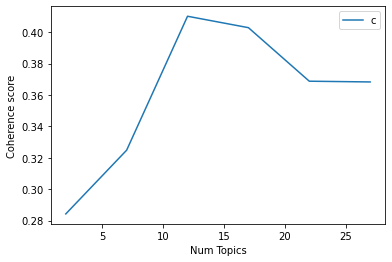

In [70]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.2842
index: 1 | Num Topics = 7  has Coherence Value of 0.3248
index: 2 | Num Topics = 12  has Coherence Value of 0.4101
index: 3 | Num Topics = 17  has Coherence Value of 0.4029
index: 4 | Num Topics = 22  has Coherence Value of 0.3688
index: 5 | Num Topics = 27  has Coherence Value of 0.3683


In [195]:
# Select optimal number of topics
optimal_model_ph_score1 = model_list_ph_score1[2]

In [196]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score1 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score1, corpus_ph_score1, id2word_ph_score1)

In [197]:
print("pyLDAVis for ph topics for score=1:")
vis_ph_score1

pyLDAVis for ph topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.284750 -0.041207       1        1  16.590278
11    -0.007205 -0.165521       2        1  14.026981
7      0.062377  0.041276       3        1  13.414529
1     -0.022918 -0.063077       4        1  10.357433
8      0.014437 -0.014570       5        1   8.692348
10    -0.021638  0.077624       6        1   6.703354
2      0.025336  0.146488       7        1   6.678538
4     -0.061600  0.094750       8        1   6.043597
5     -0.054194 -0.011710       9        1   6.010951
6     -0.062928 -0.000241      10        1   4.601242
3     -0.105080 -0.122998      11        1   4.000729
9     -0.051338  0.059184      12        1   2.880019, topic_info=           Term       Freq      Total Category  logprob  loglift
25       filter  36.000000  36.000000  Default  30.0000  30.0000
86          old  38.000000  38.000000  Default  29.0000  29.0000
16         back  38.000000  38.000000  Default  28.0000  28.0000
321         log  30.000000  30.000000  Default  27.0000  27.0000
64          new  39.000000  39.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
76   especially   0.680776   3.819531  Topic12  -4.7088   1.8227
184      become   0.680776   3.814718  Topic12  -4.7088   1.8240
251         dog   0.680776   3.807652  Topic12  -4.7088   1.8258
307       wrong   0.680776   6.164236  Topic12  -4.7088   1.3441
265        cute   0.680776   2.888094  Topic12  -4.7088   2.1023

[680 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
361       2  0.247612  accidentally
361       5  0.495224  accidentally
212       2  0.715674       account
212       3  0.085881       account
212       4  0.057254       account
...     ...       ...           ...
470      11  0.677109       youtube
647       9  0.649103            yt
338       6  0.643576          zoom
338       8  0.321788          zoom
352      12  0.714090         我信你个鬼

[923 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 12, 8, 2, 9, 11, 3, 5, 6, 7, 4, 10])

## LDA Topic Modelling (Rating = 2)

In [75]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_ph_score2 = snapchat_ios_ph_review_YearMonth_score2.review.values.tolist()
review_words_ph_score2 = list(sent_to_words(review_ph_score2))
print(review_words_ph_score2[:1])

[['the', 'new', 'update', 'is', 'extremely', 'messy', 'can', 'tell', 'who', 'updated', 'their', 'story', 'because', 'it', 'all', 'mixed', 'in', 'with', 'the', 'snaps', 'send']]


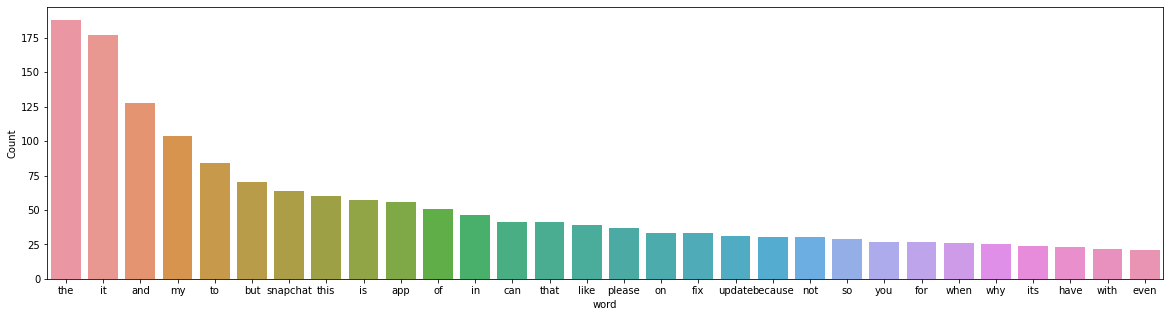

In [76]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score2))

In [77]:
# Clean text
review_ph_ready_score2 = process_words(review_words_ph_score2)  # processed Text Data! - move to each section


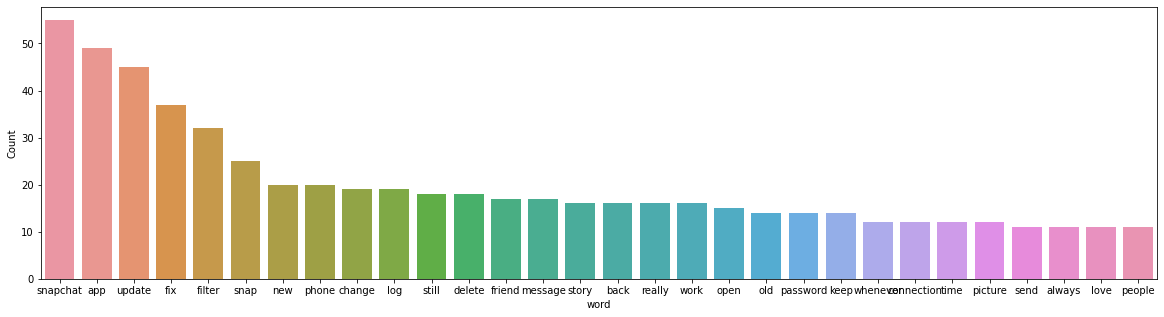

In [78]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score2))


In [79]:
# Create Dictionary
id2word_ph_score2 = corpora.Dictionary(review_ph_ready_score2)

2021-10-16 20:41:10,994 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:41:11,011 [INFO] gensim.corpora.dictionary - built Dictionary(525 unique tokens: ['extremely', 'messy', 'mix', 'new', 'send']...) from 131 documents (total 1622 corpus positions)
2021-10-16 20:41:11,013 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(525 unique tokens: ['extremely', 'messy', 'mix', 'new', 'send']...) from 131 documents (total 1622 corpus positions)", 'datetime': '2021-10-16T20:41:11.013607', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [80]:
# Create Corpus: Term Document Frequency
corpus_ph_score2 = [id2word_ph_score2.doc2bow(text) for text in review_ph_ready_score2]

In [81]:
# Training LDA model
model_list_ph_score2, coherence_values_ph_score2 = compute_coherence_values(dictionary=id2word_ph_score2, corpus=corpus_ph_score2, 
                                                              texts=review_ph_ready_score2, limit=30, start=2, step=5)


2021-10-16 20:41:11,049 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:41:11,052 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:41:11,056 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:41:11,064 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 131 documents, updating model once every 131 documents, evaluating perplexity every 131 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:41:11,641 [INFO] gensim.models.ldamodel - -6.906 per-word bound, 120.0 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:11,642 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #131/131
2021-10-16 20:41:12,522 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"update" + 0.023*"app" + 0.023*"snapchat" + 0.015*"fix" + 0.013*"new" + 0.013*"phone" + 0.012*"del

2021-10-16 20:41:19,083 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"snapchat" + 0.030*"filter" + 0.020*"app" + 0.019*"fix" + 0.015*"back" + 0.011*"old" + 0.011*"snap" + 0.011*"camera" + 0.011*"really" + 0.010*"save"
2021-10-16 20:41:19,084 [INFO] gensim.models.ldamodel - topic diff=0.011306, rho=0.301511
2021-10-16 20:41:19,580 [INFO] gensim.models.ldamodel - -5.995 per-word bound, 63.8 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:19,581 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #131/131
2021-10-16 20:41:19,869 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"update" + 0.026*"app" + 0.018*"snapchat" + 0.017*"fix" + 0.015*"log" + 0.015*"new" + 0.015*"still" + 0.015*"delete" + 0.014*"friend" + 0.013*"story"
2021-10-16 20:41:19,882 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"snapchat" + 0.031*"filter" + 0.020*"app" + 0.019*"fix" + 0.015*"back" + 0.012*"old" + 0.011*"camera" + 0.011*"

2021-10-16 20:41:26,268 [INFO] gensim.models.ldamodel - topic diff=0.005548, rho=0.218218
2021-10-16 20:41:26,558 [INFO] gensim.models.ldamodel - -5.985 per-word bound, 63.3 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:26,563 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #131/131
2021-10-16 20:41:26,728 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"update" + 0.027*"app" + 0.018*"fix" + 0.016*"snapchat" + 0.016*"log" + 0.015*"still" + 0.015*"delete" + 0.015*"new" + 0.014*"friend" + 0.013*"snap"
2021-10-16 20:41:26,730 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"snapchat" + 0.033*"filter" + 0.018*"app" + 0.017*"fix" + 0.015*"back" + 0.012*"camera" + 0.012*"old" + 0.011*"love" + 0.011*"really" + 0.010*"snap"
2021-10-16 20:41:26,732 [INFO] gensim.models.ldamodel - topic diff=0.005336, rho=0.213201
2021-10-16 20:41:26,953 [INFO] gensim.models.ldamodel - -5.984 per-word bound, 63.3 perplexity estimat

2021-10-16 20:41:31,021 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #131/131
2021-10-16 20:41:31,263 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"update" + 0.029*"app" + 0.019*"fix" + 0.016*"log" + 0.015*"still" + 0.015*"delete" + 0.015*"snapchat" + 0.015*"new" + 0.014*"friend" + 0.014*"snap"
2021-10-16 20:41:31,276 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"snapchat" + 0.034*"filter" + 0.016*"app" + 0.016*"fix" + 0.015*"back" + 0.012*"camera" + 0.012*"love" + 0.012*"old" + 0.011*"crash" + 0.011*"update"
2021-10-16 20:41:31,277 [INFO] gensim.models.ldamodel - topic diff=0.004252, rho=0.176777
2021-10-16 20:41:31,487 [INFO] gensim.models.ldamodel - -5.979 per-word bound, 63.1 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:31,489 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #131/131
2021-10-16 20:41:31,701 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"update" + 0.02

2021-10-16 20:41:35,729 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"snapchat" + 0.034*"filter" + 0.016*"fix" + 0.016*"app" + 0.015*"back" + 0.012*"camera" + 0.012*"crash" + 0.012*"love" + 0.012*"update" + 0.012*"old"
2021-10-16 20:41:35,732 [INFO] gensim.models.ldamodel - topic diff=0.003459, rho=0.154303
2021-10-16 20:41:35,942 [INFO] gensim.models.ldamodel - -5.975 per-word bound, 62.9 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:35,944 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #131/131
2021-10-16 20:41:36,130 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"app" + 0.029*"update" + 0.019*"fix" + 0.016*"log" + 0.015*"still" + 0.015*"delete" + 0.015*"new" + 0.015*"snap" + 0.014*"snapchat" + 0.014*"friend"
2021-10-16 20:41:36,136 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"snapchat" + 0.034*"filter" + 0.016*"fix" + 0.016*"app" + 0.015*"back" + 0.012*"camera" + 0.012*"crash" + 0.012

2021-10-16 20:41:46,894 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 124 virtual documents
2021-10-16 20:41:47,348 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:41:47,357 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:41:47,360 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:41:47,364 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 131 documents, updating model once every 131 documents, evaluating perplexity every 131 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:41:47,767 [INFO] gensim.models.ldamodel - -9.019 per-word bound, 519.0 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:47,769 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #131/131
2021-10-16 20:41

2021-10-16 20:41:49,594 [INFO] gensim.models.ldamodel - topic diff=0.050372, rho=0.408248
2021-10-16 20:41:49,773 [INFO] gensim.models.ldamodel - -6.323 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:49,774 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #131/131
2021-10-16 20:41:49,892 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"filter" + 0.029*"app" + 0.019*"snapchat" + 0.018*"fix" + 0.017*"face" + 0.016*"back" + 0.013*"bring" + 0.013*"iphone" + 0.012*"effect" + 0.012*"hope"
2021-10-16 20:41:49,932 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"snapchat" + 0.040*"change" + 0.034*"app" + 0.030*"message" + 0.028*"fix" + 0.022*"battery" + 0.019*"keep" + 0.019*"always" + 0.019*"update" + 0.018*"log"
2021-10-16 20:41:49,940 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.033*"new" + 0.028*"friend" + 0.023*"story" + 0.023*"update" + 0.021*"snap" + 0.021*"fix" + 0.018*"snapchat" +

2021-10-16 20:41:51,974 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"snapchat" + 0.041*"change" + 0.033*"app" + 0.030*"message" + 0.029*"fix" + 0.022*"battery" + 0.019*"update" + 0.019*"keep" + 0.019*"always" + 0.019*"log"
2021-10-16 20:41:51,976 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.043*"snapchat" + 0.030*"open" + 0.027*"filter" + 0.021*"app" + 0.020*"receive" + 0.020*"whenever" + 0.016*"update" + 0.016*"fix" + 0.016*"chat" + 0.014*"crash"
2021-10-16 20:41:51,979 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.034*"new" + 0.030*"friend" + 0.024*"story" + 0.023*"update" + 0.022*"snap" + 0.020*"fix" + 0.018*"snapchat" + 0.018*"camera" + 0.018*"view" + 0.017*"really"
2021-10-16 20:41:51,980 [INFO] gensim.models.ldamodel - topic diff=0.007980, rho=0.288675
2021-10-16 20:41:52,212 [INFO] gensim.models.ldamodel - -6.310 per-word bound, 79.3 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:52,216 [INFO] gensim.mode

2021-10-16 20:41:54,110 [INFO] gensim.models.ldamodel - topic diff=0.002271, rho=0.242536
2021-10-16 20:41:54,412 [INFO] gensim.models.ldamodel - -6.308 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:54,414 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #131/131
2021-10-16 20:41:54,606 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.043*"snapchat" + 0.031*"open" + 0.027*"filter" + 0.021*"app" + 0.020*"receive" + 0.020*"whenever" + 0.016*"update" + 0.016*"chat" + 0.016*"fix" + 0.015*"crash"
2021-10-16 20:41:54,610 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"snapchat" + 0.041*"change" + 0.033*"app" + 0.030*"message" + 0.029*"fix" + 0.022*"battery" + 0.020*"update" + 0.019*"keep" + 0.019*"always" + 0.019*"log"
2021-10-16 20:41:54,612 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"filter" + 0.028*"app" + 0.019*"snapchat" + 0.018*"fix" + 0.017*"face" + 0.016*"back" + 0.013*"brin

2021-10-16 20:41:56,631 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"app" + 0.029*"fix" + 0.025*"update" + 0.023*"filter" + 0.021*"delete" + 0.021*"crash" + 0.016*"hope" + 0.013*"look" + 0.013*"download" + 0.013*"anymore"
2021-10-16 20:41:56,635 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"snapchat" + 0.041*"change" + 0.033*"app" + 0.030*"message" + 0.029*"fix" + 0.022*"battery" + 0.020*"update" + 0.019*"always" + 0.019*"keep" + 0.019*"log"
2021-10-16 20:41:56,638 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"snapchat" + 0.028*"update" + 0.027*"phone" + 0.021*"password" + 0.019*"delete" + 0.019*"time" + 0.017*"snap" + 0.017*"app" + 0.017*"still" + 0.015*"log"
2021-10-16 20:41:56,639 [INFO] gensim.models.ldamodel - topic diff=0.000582, rho=0.208514
2021-10-16 20:41:56,839 [INFO] gensim.models.ldamodel - -6.308 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:56,841 [INFO] gensim.model

2021-10-16 20:41:58,714 [INFO] gensim.models.ldamodel - topic diff=0.000197, rho=0.188982
2021-10-16 20:41:58,930 [INFO] gensim.models.ldamodel - -6.308 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:41:58,933 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #131/131
2021-10-16 20:41:59,154 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"filter" + 0.028*"app" + 0.019*"snapchat" + 0.018*"fix" + 0.017*"face" + 0.016*"back" + 0.013*"hope" + 0.013*"bring" + 0.013*"effect" + 0.013*"place"
2021-10-16 20:41:59,158 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"snapchat" + 0.028*"update" + 0.027*"phone" + 0.021*"password" + 0.019*"delete" + 0.019*"time" + 0.017*"snap" + 0.017*"app" + 0.017*"still" + 0.015*"log"
2021-10-16 20:41:59,160 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"app" + 0.029*"fix" + 0.024*"update" + 0.023*"filter" + 0.021*"delete" + 0.021*"crash" + 0.016*"hope" + 0.

2021-10-16 20:42:01,612 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"app" + 0.029*"fix" + 0.024*"update" + 0.023*"filter" + 0.021*"delete" + 0.021*"crash" + 0.016*"hope" + 0.013*"look" + 0.013*"download" + 0.013*"anymore"
2021-10-16 20:42:01,615 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"snapchat" + 0.041*"change" + 0.033*"app" + 0.030*"message" + 0.029*"fix" + 0.022*"battery" + 0.020*"update" + 0.019*"always" + 0.019*"keep" + 0.019*"log"
2021-10-16 20:42:01,618 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.034*"new" + 0.030*"friend" + 0.024*"story" + 0.023*"update" + 0.022*"snap" + 0.020*"fix" + 0.018*"camera" + 0.018*"snapchat" + 0.018*"view" + 0.017*"really"
2021-10-16 20:42:01,620 [INFO] gensim.models.ldamodel - topic diff=0.000059, rho=0.171499
2021-10-16 20:42:01,847 [INFO] gensim.models.ldamodel - -6.308 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:01,848 [INFO] gensim.models

2021-10-16 20:42:03,506 [INFO] gensim.models.ldamodel - topic diff=0.000024, rho=0.160128
2021-10-16 20:42:03,718 [INFO] gensim.models.ldamodel - -6.308 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:03,719 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #131/131
2021-10-16 20:42:03,843 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"snapchat" + 0.041*"change" + 0.033*"app" + 0.030*"message" + 0.029*"fix" + 0.022*"battery" + 0.020*"update" + 0.019*"always" + 0.019*"log" + 0.019*"keep"
2021-10-16 20:42:03,848 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.043*"snapchat" + 0.031*"open" + 0.027*"filter" + 0.021*"app" + 0.020*"receive" + 0.020*"whenever" + 0.016*"chat" + 0.016*"update" + 0.016*"fix" + 0.015*"crash"
2021-10-16 20:42:03,851 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.034*"new" + 0.030*"friend" + 0.024*"story" + 0.023*"update" + 0.022*"snap" + 0.020*"fix" + 0.018*"camer

2021-10-16 20:42:05,748 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"filter" + 0.028*"app" + 0.019*"snapchat" + 0.018*"fix" + 0.017*"face" + 0.016*"back" + 0.013*"hope" + 0.013*"effect" + 0.013*"bring" + 0.013*"place"
2021-10-16 20:42:05,752 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"snapchat" + 0.028*"update" + 0.027*"phone" + 0.021*"password" + 0.019*"time" + 0.019*"delete" + 0.017*"snap" + 0.017*"app" + 0.017*"still" + 0.015*"log"
2021-10-16 20:42:05,754 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"snapchat" + 0.041*"change" + 0.033*"app" + 0.030*"message" + 0.029*"fix" + 0.022*"battery" + 0.020*"update" + 0.019*"always" + 0.019*"log" + 0.019*"keep"
2021-10-16 20:42:05,757 [INFO] gensim.models.ldamodel - topic diff=0.000008, rho=0.149071
2021-10-16 20:42:05,960 [INFO] gensim.models.ldamodel - -6.308 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:05,969 [INFO] gensim.models.ld

2021-10-16 20:42:07,871 [INFO] gensim.models.ldamodel - topic diff=0.000004, rho=0.141421
2021-10-16 20:42:08,254 [INFO] gensim.models.ldamodel - -6.308 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:08,256 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #131/131
2021-10-16 20:42:08,389 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"app" + 0.029*"fix" + 0.024*"update" + 0.023*"filter" + 0.021*"delete" + 0.021*"crash" + 0.016*"hope" + 0.013*"look" + 0.013*"download" + 0.013*"anymore"
2021-10-16 20:42:08,393 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.030*"update" + 0.020*"back" + 0.020*"snapchat" + 0.019*"old" + 0.015*"really" + 0.013*"still" + 0.013*"send" + 0.013*"happen" + 0.013*"bring"
2021-10-16 20:42:08,398 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"filter" + 0.028*"app" + 0.019*"snapchat" + 0.018*"fix" + 0.017*"face" + 0.016*"back" + 0.013*"hope" + 0

2021-10-16 20:42:19,528 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.043*"app" + 0.034*"open" + 0.027*"crash" + 0.018*"fix" + 0.018*"issue" + 0.018*"reinstall" + 0.018*"look" + 0.018*"log" + 0.014*"update" + 0.014*"story"
2021-10-16 20:42:19,534 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"receive" + 0.025*"open" + 0.025*"chat" + 0.019*"place" + 0.019*"fix" + 0.019*"message" + 0.014*"snapchat" + 0.013*"lense" + 0.013*"remove" + 0.013*"exit"
2021-10-16 20:42:19,538 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.044*"fix" + 0.026*"story" + 0.025*"update" + 0.023*"new" + 0.019*"video" + 0.019*"snapchat" + 0.016*"friend" + 0.014*"app" + 0.014*"still" + 0.014*"account"
2021-10-16 20:42:19,544 [INFO] gensim.models.ldamodel - topic diff=0.086165, rho=0.447214
2021-10-16 20:42:19,836 [INFO] gensim.models.ldamodel - -6.422 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:19,841 [INFO] gensim.models.ldam

2021-10-16 20:42:21,758 [INFO] gensim.models.ldamodel - topic diff=0.018354, rho=0.316228
2021-10-16 20:42:21,932 [INFO] gensim.models.ldamodel - -6.393 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:21,935 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #131/131
2021-10-16 20:42:22,120 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.044*"app" + 0.030*"snapchat" + 0.030*"fix" + 0.020*"update" + 0.020*"delete" + 0.020*"change" + 0.015*"keep" + 0.015*"snap" + 0.015*"message" + 0.015*"always"
2021-10-16 20:42:22,125 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.063*"log" + 0.039*"change" + 0.039*"snapchat" + 0.033*"filter" + 0.030*"time" + 0.026*"people" + 0.022*"app" + 0.020*"much" + 0.017*"send" + 0.015*"snap"
2021-10-16 20:42:22,126 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"save" + 0.036*"app" + 0.034*"message" + 0.030*"update" + 0.029*"keep" + 0.028*"snap" + 0.024*"friend" + 0

2021-10-16 20:42:24,496 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.034*"delete" + 0.033*"snapchat" + 0.031*"password" + 0.027*"phone" + 0.024*"update" + 0.016*"app" + 0.015*"number" + 0.015*"work" + 0.015*"snap" + 0.012*"still"
2021-10-16 20:42:24,498 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.097*"filter" + 0.070*"snapchat" + 0.044*"back" + 0.039*"bring" + 0.030*"update" + 0.030*"old" + 0.016*"battery" + 0.016*"crash" + 0.016*"quality" + 0.016*"life"
2021-10-16 20:42:24,500 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"save" + 0.036*"app" + 0.032*"message" + 0.030*"update" + 0.029*"keep" + 0.029*"snap" + 0.025*"friend" + 0.025*"wait" + 0.025*"camera" + 0.021*"send"
2021-10-16 20:42:24,502 [INFO] gensim.models.ldamodel - topic diff=0.004314, rho=0.250000
2021-10-16 20:42:24,684 [INFO] gensim.models.ldamodel - -6.384 per-word bound, 83.5 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:24,686 [INFO] gensim.mod

2021-10-16 20:42:26,688 [INFO] gensim.models.ldamodel - topic diff=0.001767, rho=0.218218
2021-10-16 20:42:27,033 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:27,034 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #131/131
2021-10-16 20:42:27,243 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.043*"update" + 0.035*"really" + 0.029*"new" + 0.024*"app" + 0.024*"story" + 0.019*"old" + 0.018*"snap" + 0.018*"interface" + 0.018*"change" + 0.012*"people"
2021-10-16 20:42:27,248 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.034*"delete" + 0.033*"snapchat" + 0.031*"password" + 0.027*"phone" + 0.024*"update" + 0.016*"app" + 0.015*"number" + 0.015*"work" + 0.015*"snap" + 0.012*"still"
2021-10-16 20:42:27,250 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.045*"app" + 0.036*"open" + 0.027*"crash" + 0.018*"reinstall" + 0.018*"fix" + 0.018*"issue" + 0.018*"look

2021-10-16 20:42:29,682 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.034*"delete" + 0.033*"snapchat" + 0.031*"password" + 0.027*"phone" + 0.024*"update" + 0.016*"app" + 0.015*"number" + 0.015*"work" + 0.015*"snap" + 0.012*"still"
2021-10-16 20:42:29,686 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.042*"snapchat" + 0.033*"app" + 0.033*"face" + 0.025*"iphone" + 0.021*"filter" + 0.020*"camera" + 0.020*"snap" + 0.020*"baby" + 0.016*"picture" + 0.015*"back"
2021-10-16 20:42:29,689 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"save" + 0.036*"app" + 0.030*"message" + 0.030*"update" + 0.030*"keep" + 0.029*"snap" + 0.025*"friend" + 0.025*"wait" + 0.025*"camera" + 0.020*"send"
2021-10-16 20:42:29,692 [INFO] gensim.models.ldamodel - topic diff=0.000644, rho=0.192450
2021-10-16 20:42:29,969 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:29,971 [INFO] gensim.models.

2021-10-16 20:42:32,366 [INFO] gensim.models.ldamodel - topic diff=0.000260, rho=0.176777
2021-10-16 20:42:32,575 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:32,577 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #131/131
2021-10-16 20:42:32,762 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.044*"update" + 0.039*"change" + 0.039*"username" + 0.027*"hope" + 0.027*"late" + 0.016*"new" + 0.014*"turn" + 0.014*"reason" + 0.014*"confuse" + 0.014*"yeaaaaaar"
2021-10-16 20:42:32,766 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"save" + 0.036*"app" + 0.030*"message" + 0.030*"update" + 0.030*"keep" + 0.029*"snap" + 0.025*"friend" + 0.025*"camera" + 0.025*"wait" + 0.020*"send"
2021-10-16 20:42:32,768 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.043*"update" + 0.035*"really" + 0.029*"new" + 0.024*"app" + 0.024*"story" + 0.019*"old" + 0.018*"snap" +

2021-10-16 20:42:34,565 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.044*"update" + 0.039*"change" + 0.039*"username" + 0.027*"hope" + 0.027*"late" + 0.016*"new" + 0.014*"turn" + 0.014*"reason" + 0.014*"typo" + 0.014*"yeaaaaaar"
2021-10-16 20:42:34,569 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.064*"log" + 0.039*"snapchat" + 0.039*"change" + 0.033*"filter" + 0.031*"time" + 0.026*"people" + 0.023*"app" + 0.020*"much" + 0.019*"send" + 0.016*"snap"
2021-10-16 20:42:34,571 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.043*"update" + 0.035*"really" + 0.029*"new" + 0.024*"app" + 0.024*"story" + 0.019*"old" + 0.018*"snap" + 0.018*"interface" + 0.018*"change" + 0.012*"people"
2021-10-16 20:42:34,572 [INFO] gensim.models.ldamodel - topic diff=0.000090, rho=0.162221
2021-10-16 20:42:34,789 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:34,791 [INFO] gensim.models.l

2021-10-16 20:42:36,259 [INFO] gensim.models.ldamodel - topic diff=0.000039, rho=0.152499
2021-10-16 20:42:36,405 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:36,407 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #131/131
2021-10-16 20:42:36,555 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.064*"log" + 0.039*"snapchat" + 0.039*"change" + 0.033*"filter" + 0.031*"time" + 0.026*"people" + 0.023*"app" + 0.020*"much" + 0.019*"send" + 0.016*"snap"
2021-10-16 20:42:36,556 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.042*"snapchat" + 0.033*"app" + 0.033*"face" + 0.025*"iphone" + 0.021*"filter" + 0.020*"snap" + 0.020*"camera" + 0.020*"baby" + 0.016*"picture" + 0.015*"back"
2021-10-16 20:42:36,558 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.096*"filter" + 0.070*"snapchat" + 0.048*"back" + 0.042*"bring" + 0.034*"old" + 0.030*"update" + 0.016*"batter

2021-10-16 20:42:38,483 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.044*"app" + 0.030*"fix" + 0.030*"snapchat" + 0.020*"change" + 0.020*"delete" + 0.020*"update" + 0.015*"keep" + 0.015*"always" + 0.015*"message" + 0.015*"phone"
2021-10-16 20:42:38,486 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.045*"app" + 0.036*"open" + 0.027*"crash" + 0.018*"reinstall" + 0.018*"fix" + 0.018*"issue" + 0.018*"look" + 0.018*"log" + 0.010*"filter" + 0.010*"update"
2021-10-16 20:42:38,490 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.056*"connection" + 0.048*"error" + 0.026*"app" + 0.025*"log" + 0.024*"always" + 0.024*"crash" + 0.024*"fix" + 0.024*"slow" + 0.015*"keep" + 0.013*"whenever"
2021-10-16 20:42:38,495 [INFO] gensim.models.ldamodel - topic diff=0.000016, rho=0.142857
2021-10-16 20:42:38,678 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:38,680 [INFO] gensim.models.ld

2021-10-16 20:42:50,481 [INFO] gensim.models.ldamodel - -6.679 per-word bound, 102.4 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:50,483 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #131/131
2021-10-16 20:42:50,608 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.022*"update" + 0.017*"message" + 0.017*"open" + 0.016*"whenever" + 0.016*"delete" + 0.016*"still" + 0.016*"keep" + 0.016*"app" + 0.016*"snapchat" + 0.014*"place"
2021-10-16 20:42:50,611 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.060*"password" + 0.051*"work" + 0.029*"time" + 0.023*"sad" + 0.023*"fix" + 0.021*"put" + 0.020*"turn" + 0.020*"everytime" + 0.020*"app" + 0.019*"still"
2021-10-16 20:42:50,615 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.028*"snapchat" + 0.027*"irritate" + 0.027*"version" + 0.027*"change" + 0.027*"work" + 0.027*"super" + 0.027*"slow" + 0.003*"bug" + 0.002*"snap" + 0.002*"friend"
2021-10-16 20:42:50,618 [INFO] gens

2021-10-16 20:42:52,636 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.040*"app" + 0.040*"start" + 0.040*"connection" + 0.020*"fix" + 0.020*"slow" + 0.020*"tho" + 0.020*"send" + 0.020*"lose" + 0.020*"energy" + 0.020*"snapstreak"
2021-10-16 20:42:52,639 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.035*"fix" + 0.035*"app" + 0.035*"crash" + 0.024*"great" + 0.024*"hope" + 0.024*"update" + 0.024*"message" + 0.024*"reinstall" + 0.016*"archive" + 0.012*"snap"
2021-10-16 20:42:52,642 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.071*"update" + 0.041*"change" + 0.031*"app" + 0.031*"new" + 0.021*"ever" + 0.021*"thing" + 0.021*"username" + 0.021*"really" + 0.020*"log" + 0.011*"happen"
2021-10-16 20:42:52,645 [INFO] gensim.models.ldamodel - topic diff=0.034245, rho=0.333333
2021-10-16 20:42:52,968 [INFO] gensim.models.ldamodel - -6.529 per-word bound, 92.3 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:52,969 [INFO] gensim.models

2021-10-16 20:42:54,504 [INFO] gensim.models.ldamodel - topic diff=0.009873, rho=0.267261
2021-10-16 20:42:54,664 [INFO] gensim.models.ldamodel - -6.514 per-word bound, 91.4 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:54,667 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #131/131
2021-10-16 20:42:54,854 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.044*"snapchat" + 0.044*"face" + 0.033*"app" + 0.033*"filter" + 0.022*"fix" + 0.022*"rate" + 0.022*"star" + 0.022*"baby" + 0.022*"back" + 0.022*"keep"
2021-10-16 20:42:54,857 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.081*"filter" + 0.046*"snapchat" + 0.026*"back" + 0.021*"phone" + 0.020*"quality" + 0.020*"app" + 0.020*"crash" + 0.016*"update" + 0.015*"look" + 0.015*"picture"
2021-10-16 20:42:54,859 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.052*"old" + 0.045*"back" + 0.044*"snapchat" + 0.044*"snap" + 0.037*"bring" + 0.030*"really" + 0.015*"update" +

2021-10-16 20:42:56,668 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.046*"app" + 0.034*"message" + 0.026*"snapchat" + 0.026*"save" + 0.026*"fix" + 0.022*"still" + 0.017*"camera" + 0.017*"photo" + 0.017*"filter" + 0.017*"picture"
2021-10-16 20:42:56,670 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.069*"password" + 0.052*"work" + 0.026*"time" + 0.026*"sad" + 0.026*"put" + 0.026*"fix" + 0.018*"turn" + 0.018*"everytime" + 0.018*"app" + 0.018*"still"
2021-10-16 20:42:56,680 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.035*"app" + 0.035*"fix" + 0.035*"crash" + 0.023*"hope" + 0.023*"reinstall" + 0.023*"great" + 0.023*"message" + 0.023*"update" + 0.023*"archive" + 0.012*"snap"
2021-10-16 20:42:56,682 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.044*"face" + 0.044*"snapchat" + 0.033*"app" + 0.033*"filter" + 0.022*"fix" + 0.022*"rate" + 0.022*"star" + 0.022*"baby" + 0.022*"back" + 0.022*"keep"
2021-10-16 20:42:56,695 [INFO] gensim.models.ldamodel - topic diff=0.00313

2021-10-16 20:42:58,519 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.048*"wait" + 0.032*"snap" + 0.032*"update" + 0.017*"snapchat" + 0.017*"app" + 0.017*"last" + 0.017*"fail" + 0.017*"open" + 0.017*"reason" + 0.017*"connection"
2021-10-16 20:42:58,521 [INFO] gensim.models.ldamodel - topic diff=0.001599, rho=0.200000
2021-10-16 20:42:58,728 [INFO] gensim.models.ldamodel - -6.507 per-word bound, 91.0 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:42:58,732 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #131/131
2021-10-16 20:42:58,901 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.081*"filter" + 0.046*"snapchat" + 0.026*"back" + 0.021*"phone" + 0.020*"quality" + 0.020*"app" + 0.020*"crash" + 0.016*"update" + 0.015*"look" + 0.015*"picture"
2021-10-16 20:42:58,905 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.048*"wait" + 0.032*"snap" + 0.032*"update" + 0.017*"snapchat" + 0.017*"app" + 0.017*"last" + 0.017*

2021-10-16 20:43:00,585 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.048*"wait" + 0.032*"snap" + 0.032*"update" + 0.017*"snapchat" + 0.017*"app" + 0.017*"fail" + 0.017*"last" + 0.017*"open" + 0.017*"reason" + 0.017*"network"
2021-10-16 20:43:00,588 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"people" + 0.023*"story" + 0.023*"vanity" + 0.023*"filter" + 0.023*"influence" + 0.023*"article" + 0.023*"usually" + 0.023*"disappoint" + 0.023*"feature" + 0.023*"swipe"
2021-10-16 20:43:00,590 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.044*"face" + 0.044*"snapchat" + 0.033*"app" + 0.033*"filter" + 0.022*"fix" + 0.022*"star" + 0.022*"rate" + 0.022*"baby" + 0.022*"back" + 0.022*"man"
2021-10-16 20:43:00,594 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.075*"password" + 0.051*"work" + 0.026*"time" + 0.026*"sad" + 0.026*"put" + 0.025*"fix" + 0.023*"forgot" + 0.017*"turn" + 0.017*"everytime" + 0.017*"app"
2021-10-16 20:43:00,599 [INFO] gensim.models.ldamodel - topic

2021-10-16 20:43:02,744 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.028*"snapchat" + 0.028*"work" + 0.028*"change" + 0.028*"slow" + 0.028*"super" + 0.028*"version" + 0.028*"irritate" + 0.002*"bug" + 0.002*"snap" + 0.002*"friend"
2021-10-16 20:43:02,749 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.074*"update" + 0.043*"change" + 0.032*"app" + 0.032*"new" + 0.022*"thing" + 0.022*"ever" + 0.022*"username" + 0.022*"really" + 0.011*"happen" + 0.011*"confuse"
2021-10-16 20:43:02,751 [INFO] gensim.models.ldamodel - topic diff=0.000528, rho=0.166667
2021-10-16 20:43:02,915 [INFO] gensim.models.ldamodel - -6.504 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:43:02,916 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #131/131
2021-10-16 20:43:03,041 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.044*"face" + 0.044*"snapchat" + 0.033*"app" + 0.033*"filter" + 0.022*"fix" + 0.022*"star" + 0.022*"

2021-10-16 20:43:04,633 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #131/131
2021-10-16 20:43:04,792 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.048*"wait" + 0.032*"snap" + 0.032*"update" + 0.017*"snapchat" + 0.017*"app" + 0.017*"fail" + 0.017*"reason" + 0.017*"net" + 0.017*"slow" + 0.017*"always"
2021-10-16 20:43:04,795 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.076*"password" + 0.051*"work" + 0.026*"time" + 0.026*"sad" + 0.026*"put" + 0.025*"fix" + 0.025*"forgot" + 0.017*"turn" + 0.017*"everytime" + 0.017*"app"
2021-10-16 20:43:04,797 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.081*"filter" + 0.046*"snapchat" + 0.026*"back" + 0.021*"phone" + 0.020*"quality" + 0.020*"app" + 0.020*"crash" + 0.016*"update" + 0.015*"snap" + 0.015*"look"
2021-10-16 20:43:04,800 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.051*"new" + 0.042*"friend" + 0.039*"update" + 0.034*"fix" + 0.034*"story" + 0.026*"snapchat" + 0.026*"view" + 0.021*"really" + 0.017

2021-10-16 20:43:06,784 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"people" + 0.023*"story" + 0.023*"filter" + 0.023*"vanity" + 0.023*"influence" + 0.023*"usually" + 0.023*"swipe" + 0.023*"feature" + 0.023*"disappoint" + 0.023*"article"
2021-10-16 20:43:06,786 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.081*"filter" + 0.046*"snapchat" + 0.026*"back" + 0.021*"phone" + 0.020*"quality" + 0.020*"app" + 0.020*"crash" + 0.016*"update" + 0.015*"snap" + 0.015*"camera"
2021-10-16 20:43:06,786 [INFO] gensim.models.ldamodel - topic diff=0.000241, rho=0.145865
2021-10-16 20:43:07,000 [INFO] gensim.models.ldamodel - -6.503 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:43:07,002 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #131/131
2021-10-16 20:43:07,121 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"people" + 0.023*"story" + 0.023*"filter" + 0.023*"vanity" + 0.023*"influence" + 

2021-10-16 20:43:22,016 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #131/131
2021-10-16 20:43:22,637 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.061*"work" + 0.060*"password" + 0.045*"fix" + 0.032*"keep" + 0.028*"picture" + 0.028*"correct" + 0.028*"sad" + 0.028*"put" + 0.014*"problem" + 0.014*"regular"
2021-10-16 20:43:22,638 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.043*"phone" + 0.033*"back" + 0.032*"snap" + 0.027*"still" + 0.024*"camera" + 0.021*"picture" + 0.016*"perfectly" + 0.016*"front" + 0.016*"iphone" + 0.016*"filter"
2021-10-16 20:43:22,640 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.039*"turn" + 0.039*"update" + 0.039*"fix" + 0.020*"help" + 0.020*"version" + 0.020*"black" + 0.020*"click" + 0.020*"suddenly" + 0.020*"ever" + 0.020*"automatically"
2021-10-16 20:43:22,641 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.049*"app" + 0.039*"connection" + 0.039*"error" + 0.034*"fix" + 0.033*"log" + 0.032*"always" + 0.020*"play" + 0.

2021-10-16 20:43:25,379 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.062*"app" + 0.042*"update" + 0.038*"wait" + 0.034*"filter" + 0.033*"reinstall" + 0.032*"fix" + 0.031*"still" + 0.025*"story" + 0.023*"great" + 0.023*"snap"
2021-10-16 20:43:25,382 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.054*"message" + 0.032*"snapchat" + 0.032*"really" + 0.027*"update" + 0.024*"back" + 0.024*"old" + 0.024*"save" + 0.023*"person" + 0.021*"people" + 0.020*"send"
2021-10-16 20:43:25,386 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.045*"filter" + 0.031*"people" + 0.030*"feature" + 0.030*"capture" + 0.016*"app" + 0.016*"story" + 0.016*"usually" + 0.016*"influence" + 0.016*"article" + 0.016*"vanity"
2021-10-16 20:43:25,389 [INFO] gensim.models.ldamodel - topic diff=0.072137, rho=0.377964
2021-10-16 20:43:25,636 [INFO] gensim.models.ldamodel - -6.612 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:43:25,658 [INFO] g

2021-10-16 20:43:27,491 [INFO] gensim.models.ldamodel - topic diff=0.024243, rho=0.288675
2021-10-16 20:43:27,727 [INFO] gensim.models.ldamodel - -6.565 per-word bound, 94.7 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:43:27,728 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #131/131
2021-10-16 20:43:27,866 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.037*"place" + 0.026*"problem" + 0.022*"app" + 0.020*"snappy" + 0.020*"lense" + 0.020*"eye" + 0.020*"fix" + 0.020*"reinstall" + 0.020*"iphone" + 0.020*"selfie"
2021-10-16 20:43:27,871 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.045*"app" + 0.023*"show" + 0.023*"exit" + 0.023*"already" + 0.023*"still" + 0.019*"open" + 0.016*"keep" + 0.013*"snapchat" + 0.012*"message" + 0.012*"change"
2021-10-16 20:43:27,873 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.045*"filter" + 0.040*"feature" + 0.030*"people" + 0.030*"capture" + 0.016*"app" + 0.015*"story" + 0.015*

2021-10-16 20:43:29,795 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.051*"snapchat" + 0.042*"update" + 0.042*"receive" + 0.042*"battery" + 0.034*"message" + 0.034*"phone" + 0.025*"life" + 0.025*"chat" + 0.025*"people" + 0.025*"consume"
2021-10-16 20:43:29,799 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.056*"snapchat" + 0.034*"camera" + 0.034*"save" + 0.034*"memory" + 0.034*"photo" + 0.023*"matter" + 0.023*"work" + 0.023*"picture" + 0.023*"choose" + 0.023*"love"
2021-10-16 20:43:29,804 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.052*"message" + 0.030*"snapchat" + 0.030*"really" + 0.026*"update" + 0.023*"back" + 0.023*"old" + 0.023*"save" + 0.023*"person" + 0.023*"people" + 0.023*"sometimes"
2021-10-16 20:43:29,818 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.071*"app" + 0.043*"still" + 0.041*"update" + 0.038*"fix" + 0.038*"wait" + 0.033*"filter" + 0.033*"reinstall" + 0.024*"story" + 0.022*"great" + 0.022*"snap"
2021-10-16 20:43:29,822 [INFO] gensim.models.l

2021-10-16 20:43:31,422 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.050*"late" + 0.040*"update" + 0.037*"fix" + 0.037*"turn" + 0.037*"close" + 0.032*"version" + 0.020*"app" + 0.020*"snap" + 0.019*"suddenly" + 0.019*"click"
2021-10-16 20:43:31,423 [INFO] gensim.models.ldamodel - topic diff=0.003506, rho=0.208514
2021-10-16 20:43:31,622 [INFO] gensim.models.ldamodel - -6.545 per-word bound, 93.4 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:43:31,623 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #131/131
2021-10-16 20:43:31,758 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.069*"change" + 0.057*"filter" + 0.057*"snapchat" + 0.035*"people" + 0.023*"anymore" + 0.023*"much" + 0.023*"username" + 0.023*"beautify" + 0.023*"look" + 0.023*"time"
2021-10-16 20:43:31,760 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.064*"change" + 0.064*"username" + 0.033*"update" + 0.033*"hope" + 0.033*"planning" + 0.033*"sc" + 

2021-10-16 20:43:34,229 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.053*"late" + 0.039*"update" + 0.037*"fix" + 0.037*"turn" + 0.037*"close" + 0.035*"version" + 0.019*"app" + 0.019*"snap" + 0.019*"suddenly" + 0.019*"click"
2021-10-16 20:43:34,232 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.045*"app" + 0.023*"show" + 0.023*"exit" + 0.023*"already" + 0.023*"still" + 0.019*"open" + 0.016*"keep" + 0.013*"snapchat" + 0.012*"message" + 0.012*"change"
2021-10-16 20:43:34,233 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.050*"update" + 0.038*"log" + 0.025*"hope" + 0.025*"video" + 0.025*"snapchat" + 0.025*"new" + 0.013*"wrong" + 0.013*"send" + 0.013*"error" + 0.013*"app"
2021-10-16 20:43:34,236 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.056*"phone" + 0.037*"back" + 0.037*"snap" + 0.037*"picture" + 0.032*"still" + 0.028*"camera" + 0.028*"month" + 0.019*"iphone" + 0.019*"front" + 0.019*"perfectly"
2021-10-16 20:43:34,238 [INFO] gensim.models.ldamodel - topic #5 (

2021-10-16 20:43:37,060 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.069*"change" + 0.057*"filter" + 0.057*"snapchat" + 0.035*"people" + 0.023*"anymore" + 0.023*"much" + 0.023*"username" + 0.023*"beautify" + 0.023*"look" + 0.023*"time"
2021-10-16 20:43:37,063 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.041*"snapchat" + 0.030*"face" + 0.030*"filter" + 0.030*"bring" + 0.030*"back" + 0.020*"star" + 0.020*"rate" + 0.020*"love" + 0.020*"keep" + 0.020*"old"
2021-10-16 20:43:37,064 [INFO] gensim.models.ldamodel - topic diff=0.000766, rho=0.171499
2021-10-16 20:43:37,426 [INFO] gensim.models.ldamodel - -6.542 per-word bound, 93.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:43:37,430 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #131/131
2021-10-16 20:43:37,655 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.039*"place" + 0.029*"problem" + 0.022*"app" + 0.020*"eye" + 0.020*"lense" + 0.020*"snappy" + 0.020*"fi

2021-10-16 20:43:41,001 [INFO] gensim.models.ldamodel - -6.542 per-word bound, 93.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:43:41,002 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #131/131
2021-10-16 20:43:41,222 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.056*"phone" + 0.037*"back" + 0.037*"snap" + 0.037*"picture" + 0.031*"still" + 0.028*"camera" + 0.028*"month" + 0.019*"iphone" + 0.019*"front" + 0.019*"perfectly"
2021-10-16 20:43:41,228 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.041*"snapchat" + 0.030*"face" + 0.030*"filter" + 0.030*"bring" + 0.030*"back" + 0.020*"star" + 0.020*"rate" + 0.020*"love" + 0.020*"keep" + 0.020*"old"
2021-10-16 20:43:41,230 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.054*"late" + 0.039*"update" + 0.036*"fix" + 0.036*"turn" + 0.036*"close" + 0.036*"version" + 0.019*"app" + 0.019*"snap" + 0.019*"suddenly" + 0.019*"click"
2021-10-16 20:43:41,243 [INFO] gensim.mo

2021-10-16 20:43:43,243 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.059*"app" + 0.059*"fix" + 0.030*"download" + 0.030*"delete" + 0.030*"issue" + 0.015*"feature" + 0.015*"screen" + 0.015*"time" + 0.015*"kidly" + 0.015*"third"
2021-10-16 20:43:43,245 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.111*"log" + 0.079*"connection" + 0.062*"app" + 0.056*"always" + 0.056*"error" + 0.042*"fix" + 0.015*"however" + 0.015*"month" + 0.015*"everytime" + 0.015*"already"
2021-10-16 20:43:43,247 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.045*"filter" + 0.045*"feature" + 0.030*"people" + 0.030*"capture" + 0.015*"app" + 0.015*"story" + 0.015*"influence" + 0.015*"swipe" + 0.015*"disappoint" + 0.015*"young"
2021-10-16 20:43:43,248 [INFO] gensim.models.ldamodel - topic diff=0.000190, rho=0.149071
2021-10-16 20:43:43,422 [INFO] gensim.models.ldamodel - -6.542 per-word bound, 93.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:43:43,424 [

2021-10-16 20:43:45,193 [INFO] gensim.models.ldamodel - topic diff=0.000123, rho=0.141421
2021-10-16 20:43:45,383 [INFO] gensim.models.ldamodel - -6.541 per-word bound, 93.1 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:43:45,386 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #131/131
2021-10-16 20:43:45,502 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.112*"password" + 0.071*"work" + 0.055*"keep" + 0.048*"fix" + 0.046*"put" + 0.036*"sad" + 0.024*"correct" + 0.024*"picture" + 0.024*"memory" + 0.017*"forgot"
2021-10-16 20:43:45,504 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.099*"filter" + 0.076*"snapchat" + 0.033*"app" + 0.033*"crash" + 0.022*"quality" + 0.022*"look" + 0.022*"team" + 0.022*"fix" + 0.022*"snap" + 0.022*"profile"
2021-10-16 20:43:45,507 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.072*"app" + 0.050*"still" + 0.040*"update" + 0.039*"fix" + 0.038*"wait" + 0.032*"filter" + 0.032*"reinstal

2021-10-16 20:43:59,495 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.078*"snap" + 0.046*"message" + 0.033*"snapchat" + 0.033*"delete" + 0.032*"archive" + 0.031*"log" + 0.031*"keep" + 0.029*"send" + 0.028*"app" + 0.017*"time"
2021-10-16 20:43:59,496 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.058*"receive" + 0.045*"open" + 0.044*"chat" + 0.031*"whenever" + 0.031*"crash" + 0.029*"message" + 0.029*"long" + 0.029*"unread" + 0.029*"read" + 0.016*"frustrating"
2021-10-16 20:43:59,498 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.002*"accept" + 0.002*"application" + 0.002*"fall" + 0.002*"incorrect" + 0.002*"tap" + 0.002*"type" + 0.002*"create" + 0.002*"cat" + 0.002*"desire" + 0.002*"ibe"
2021-10-16 20:43:59,499 [INFO] gensim.models.ldamodel - topic diff=0.118210, rho=0.447214
2021-10-16 20:43:59,762 [INFO] gensim.models.ldamodel - -6.754 per-word bound, 108.0 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:43:59,763 [INFO] g

2021-10-16 20:44:01,498 [INFO] gensim.models.ldamodel - topic diff=0.037256, rho=0.316228
2021-10-16 20:44:01,656 [INFO] gensim.models.ldamodel - -6.675 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:44:01,658 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #131/131
2021-10-16 20:44:01,716 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.062*"filter" + 0.046*"face" + 0.031*"app" + 0.031*"star" + 0.031*"rate" + 0.031*"much" + 0.031*"beautify" + 0.031*"look" + 0.016*"phone" + 0.016*"hot"
2021-10-16 20:44:01,718 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.002*"accept" + 0.002*"application" + 0.002*"fall" + 0.002*"incorrect" + 0.002*"tap" + 0.002*"type" + 0.002*"create" + 0.002*"cat" + 0.002*"desire" + 0.002*"ibe"
2021-10-16 20:44:01,719 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.041*"snap" + 0.041*"camera" + 0.031*"iphone" + 0.031*"back" + 0.031*"picture" + 0.021*"snapchat" + 0.021*"rea

2021-10-16 20:44:03,482 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.060*"receive" + 0.045*"open" + 0.045*"chat" + 0.030*"whenever" + 0.030*"crash" + 0.030*"message" + 0.030*"long" + 0.030*"unread" + 0.030*"read" + 0.015*"video"
2021-10-16 20:44:03,485 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.042*"snapchat" + 0.040*"app" + 0.033*"log" + 0.033*"update" + 0.028*"snap" + 0.027*"connection" + 0.024*"filter" + 0.022*"really" + 0.019*"change" + 0.015*"time"
2021-10-16 20:44:03,488 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.059*"snapchat" + 0.033*"app" + 0.026*"filter" + 0.026*"team" + 0.026*"snap" + 0.026*"bug" + 0.018*"video" + 0.018*"thing" + 0.018*"day" + 0.018*"duplicate"
2021-10-16 20:44:03,489 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.042*"old" + 0.042*"back" + 0.042*"bring" + 0.042*"doggo" + 0.042*"icon" + 0.002*"still" + 0.002*"people" + 0.002*"problem" + 0.002*"app" + 0.002*"sometimes"
2021-10-16 20:44:03,491 [INFO] gensim.models.ldamodel - t

2021-10-16 20:44:05,378 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.146*"password" + 0.098*"work" + 0.045*"sad" + 0.045*"put" + 0.031*"fix" + 0.030*"picture" + 0.030*"correct" + 0.030*"forgot" + 0.029*"anymore" + 0.023*"problem"
2021-10-16 20:44:05,379 [INFO] gensim.models.ldamodel - topic diff=0.004089, rho=0.218218
2021-10-16 20:44:05,586 [INFO] gensim.models.ldamodel - -6.647 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:44:05,588 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #131/131
2021-10-16 20:44:05,772 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.051*"zoom" + 0.002*"accept" + 0.002*"ask" + 0.002*"incorrect" + 0.002*"tap" + 0.002*"type" + 0.002*"create" + 0.002*"correct" + 0.002*"application" + 0.002*"information"
2021-10-16 20:44:05,779 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.042*"old" + 0.042*"back" + 0.042*"bring" + 0.042*"doggo" + 0.042*"icon" + 0.002*"still"

2021-10-16 20:44:07,497 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.080*"snapchat" + 0.059*"change" + 0.036*"people" + 0.036*"filter" + 0.024*"snap" + 0.024*"app" + 0.024*"username" + 0.024*"put" + 0.024*"fail" + 0.024*"love"
2021-10-16 20:44:07,498 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.048*"delete" + 0.036*"account" + 0.036*"phone" + 0.024*"email" + 0.024*"fix" + 0.024*"add" + 0.024*"still" + 0.024*"quick" + 0.024*"happen" + 0.024*"show"
2021-10-16 20:44:07,500 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.002*"accept" + 0.002*"application" + 0.002*"fall" + 0.002*"incorrect" + 0.002*"tap" + 0.002*"type" + 0.002*"create" + 0.002*"cat" + 0.002*"desire" + 0.002*"ibe"
2021-10-16 20:44:07,500 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.042*"snapchat" + 0.040*"app" + 0.038*"log" + 0.033*"update" + 0.028*"snap" + 0.028*"connection" + 0.023*"filter" + 0.022*"really" + 0.019*"change" + 0.014*"time"
2021-10-16 20:44:07,502 [INFO] gensim.models.ldamodel - top

2021-10-16 20:44:09,266 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.080*"snapchat" + 0.059*"change" + 0.036*"people" + 0.036*"filter" + 0.024*"snap" + 0.024*"app" + 0.024*"username" + 0.024*"put" + 0.024*"fail" + 0.024*"love"
2021-10-16 20:44:09,268 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.069*"update" + 0.050*"app" + 0.038*"delete" + 0.028*"new" + 0.025*"message" + 0.025*"ever" + 0.025*"thing" + 0.025*"really" + 0.025*"change" + 0.013*"time"
2021-10-16 20:44:09,269 [INFO] gensim.models.ldamodel - topic diff=0.001124, rho=0.176777
2021-10-16 20:44:09,651 [INFO] gensim.models.ldamodel - -6.641 per-word bound, 99.8 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:44:09,669 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #131/131
2021-10-16 20:44:09,856 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.042*"fix" + 0.032*"phone" + 0.032*"app" + 0.021*"update" + 0.021*"recovery" + 0.021*"email" + 0.021*"hope"

2021-10-16 20:44:11,884 [INFO] gensim.models.ldamodel - -6.641 per-word bound, 99.8 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:44:11,886 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #131/131
2021-10-16 20:44:11,957 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.058*"snapchat" + 0.033*"app" + 0.026*"filter" + 0.026*"team" + 0.026*"snap" + 0.026*"bug" + 0.018*"video" + 0.018*"day" + 0.018*"thing" + 0.018*"duplicate"
2021-10-16 20:44:11,960 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.064*"bring" + 0.064*"back" + 0.048*"snapchat" + 0.046*"filter" + 0.032*"exit" + 0.032*"old" + 0.016*"weird" + 0.016*"doggy" + 0.016*"tho" + 0.016*"kind"
2021-10-16 20:44:11,965 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.041*"snap" + 0.041*"camera" + 0.031*"iphone" + 0.031*"back" + 0.031*"picture" + 0.021*"really" + 0.021*"snapchat" + 0.021*"front" + 0.021*"phone" + 0.011*"app"
2021-10-16 20:44:11,973 [INFO] gensim.mode

2021-10-16 20:44:13,789 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.062*"filter" + 0.046*"face" + 0.031*"rate" + 0.031*"star" + 0.031*"app" + 0.031*"much" + 0.031*"beautify" + 0.031*"look" + 0.016*"fully" + 0.016*"baby"
2021-10-16 20:44:13,791 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.073*"app" + 0.065*"fix" + 0.045*"still" + 0.035*"month" + 0.025*"open" + 0.025*"time" + 0.023*"update" + 0.022*"delete" + 0.022*"reinstall" + 0.022*"issue"
2021-10-16 20:44:13,795 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.093*"snapchat" + 0.037*"version" + 0.037*"late" + 0.019*"last" + 0.019*"well" + 0.019*"hope" + 0.019*"keep" + 0.019*"love" + 0.019*"stay" + 0.019*"phone"
2021-10-16 20:44:13,797 [INFO] gensim.models.ldamodel - topic diff=0.000387, rho=0.152499
2021-10-16 20:44:14,007 [INFO] gensim.models.ldamodel - -6.640 per-word bound, 99.7 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:44:14,009 [INFO] gensim.models.ldamodel

2021-10-16 20:44:15,723 [INFO] gensim.models.ldamodel - topic diff=0.000233, rho=0.144338
2021-10-16 20:44:15,885 [INFO] gensim.models.ldamodel - -6.640 per-word bound, 99.7 perplexity estimate based on a held-out corpus of 131 documents with 1622 words
2021-10-16 20:44:15,886 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #131/131
2021-10-16 20:44:16,017 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.064*"bring" + 0.064*"back" + 0.048*"snapchat" + 0.046*"filter" + 0.032*"exit" + 0.032*"old" + 0.016*"already" + 0.016*"downloaded" + 0.016*"apple" + 0.016*"especially"
2021-10-16 20:44:16,023 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.079*"snap" + 0.048*"message" + 0.032*"snapchat" + 0.032*"delete" + 0.032*"archive" + 0.032*"log" + 0.032*"keep" + 0.031*"send" + 0.031*"app" + 0.016*"time"
2021-10-16 20:44:16,024 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.025*"whenever" + 0.025*"person" + 0.025*"sometimes" + 0.025*"people" + 0.025*"interface" + 0.024*"

In [82]:
%store model_list_ph_score2
%store coherence_values_ph_score2

Stored 'model_list_ph_score2' (list)
Stored 'coherence_values_ph_score2' (list)


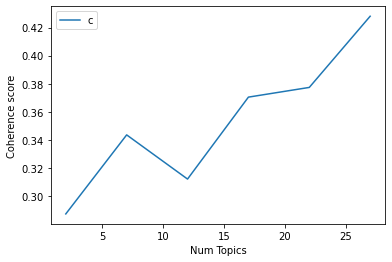

In [83]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [198]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2871
index: 1 | Num Topics = 7  has Coherence Value of 0.3435
index: 2 | Num Topics = 12  has Coherence Value of 0.312
index: 3 | Num Topics = 17  has Coherence Value of 0.3704
index: 4 | Num Topics = 22  has Coherence Value of 0.3773
index: 5 | Num Topics = 27  has Coherence Value of 0.4281


In [199]:
# Select optimal number of topics
optimal_model_ph_score2 = model_list_ph_score2[5]

In [200]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score2 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score2, corpus_ph_score2, id2word_ph_score2)

In [201]:
print("pyLDAVis for ph topics for score=2:")
vis_ph_score2

pyLDAVis for ph topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
23     0.090313 -0.152223       1        1  11.504254
2     -0.046129 -0.117316       2        1   7.446786
13     0.225081 -0.037333       3        1   7.101460
11    -0.037766 -0.091849       4        1   7.033255
3      0.077178  0.040076       5        1   6.401963
21    -0.016167 -0.093124       6        1   5.902406
8      0.022566  0.012120       7        1   5.263456
1     -0.103465 -0.030126       8        1   4.703760
24     0.118564  0.016899       9        1   4.505054
9     -0.036100 -0.116438      10        1   4.056773
0      0.151290  0.061110      11        1   3.939415
20     0.139897  0.020547      12        1   3.932071
4     -0.010519  0.050136      13        1   3.857171
16     0.060041 -0.045423      14        1   3.751789
15    -0.007257  0.234804      15        1   3.177487
19    -0.014567  0.081895      16        1   3.062595
17    -0.090134  0.021756      17        1   2.892835
7     -0.133879 -0.044309      18        1   2.772094
5      0.108023 -0.008714      19        1   2.664925
14    -0.061560  0.022658      20        1   2.145992
12    -0.087299 -0.052137      21        1   1.857947
22    -0.085232  0.038585      22        1   0.489827
18    -0.055523  0.006023      23        1   0.459001
10    -0.053292  0.046906      24        1   0.292540
6     -0.051355  0.045160      25        1   0.261714
25    -0.051357  0.045155      26        1   0.261714
26    -0.051355  0.045160      27        1   0.261714, topic_info=          Term       Freq      Total Category  logprob  loglift
8       update  36.000000  36.000000  Default  30.0000  30.0000
34    snapchat  44.000000  44.000000  Default  29.0000  29.0000
3          new  16.000000  16.000000  Default  28.0000  28.0000
52      filter  25.000000  25.000000  Default  27.0000  27.0000
144   password  11.000000  11.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
25         old   0.008086  11.217481  Topic27  -6.2634  -1.2895
26     confuse   0.008086   3.062275  Topic27  -6.2634   0.0089
27   difficult   0.008086   2.255193  Topic27  -6.2634   0.3148
28         fix   0.008086  30.071431  Topic27  -6.2634  -2.2756
29        hard   0.008086   2.255192  Topic27  -6.2634   0.3148

[1257 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
400       9  0.917167   access
136       1  0.117396  account
136       3  0.352189  account
136       9  0.117396  account
136      10  0.117396  account
...     ...       ...      ...
205      21  0.479499    young
496       1  0.657941  youtube
443       3  0.672264   youuuu
292       2  0.389018     zoom
292       3  0.389018     zoom

[1066 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 3, 14, 12, 4, 22, 9, 2, 25, 10, 1, 21, 5, 17, 16, 20, 18, 8, 6, 15, 13, 23, 19, 11, 7, 26, 27])

## LDA Topic Modelling (Rating = 3)

In [88]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_ph_score3 = snapchat_ios_ph_review_YearMonth_score3.review.values.tolist()
review_words_ph_score3 = list(sent_to_words(review_ph_score3))
print(review_words_ph_score3[:1])

[['love', 'all', 'the', 'outfits', 'but', 'can', 'you', 'add', 'more', 'work', 'it', 'outfit', 'options', 'like', 'an', 'outfit', 'for', 'artists', 'what', 'im', 'trying', 'to', 'say', 'is', 'that', 'make', 'more', 'job', 'outfits', 'that', 'arent', 'mainstream', 'and', 'basic']]


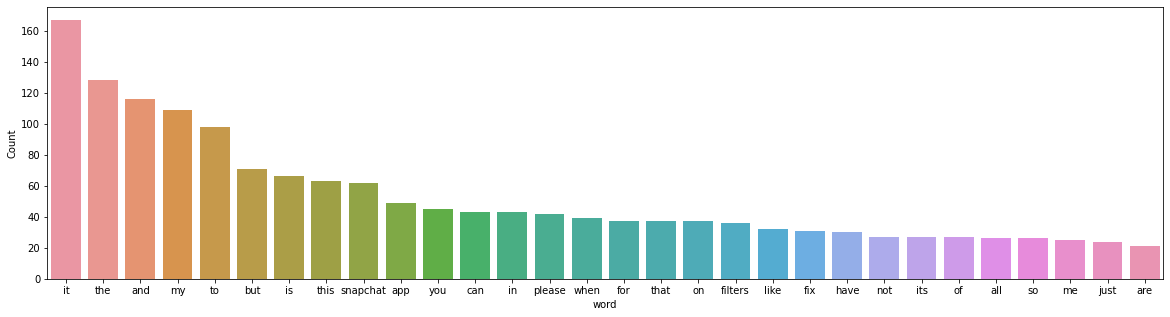

In [89]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score3))

In [90]:
# Clean text
review_ph_ready_score3 = process_words(review_words_ph_score3)  # processed Text Data! - move to each section


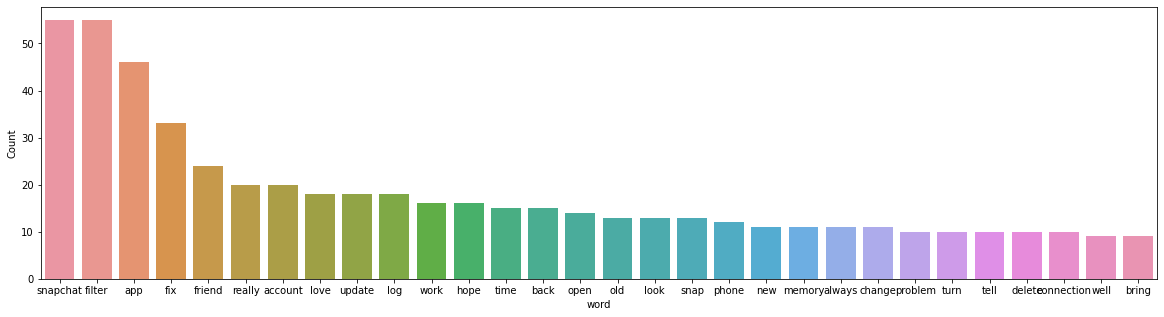

In [91]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score3))


In [92]:
# Create Dictionary
id2word_ph_score3 = corpora.Dictionary(review_ph_ready_score3)

2021-10-16 20:44:44,755 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:44:44,763 [INFO] gensim.corpora.dictionary - built Dictionary(535 unique tokens: ['add', 'artist', 'basic', 'job', 'love']...) from 115 documents (total 1529 corpus positions)
2021-10-16 20:44:44,765 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(535 unique tokens: ['add', 'artist', 'basic', 'job', 'love']...) from 115 documents (total 1529 corpus positions)", 'datetime': '2021-10-16T20:44:44.765164', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [93]:
# Create Corpus: Term Document Frequency
corpus_ph_score3 = [id2word_ph_score3.doc2bow(text) for text in review_ph_ready_score3]

In [94]:
# Training LDA model
model_list_ph_score3, coherence_values_ph_score3 = compute_coherence_values(dictionary=id2word_ph_score3, corpus=corpus_ph_score3, 
                                                              texts=review_ph_ready_score3, limit=30, start=2, step=5)


2021-10-16 20:44:44,790 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:44:44,792 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:44:44,795 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:44:44,798 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 115 documents, updating model once every 115 documents, evaluating perplexity every 115 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:44:45,407 [INFO] gensim.models.ldamodel - -6.933 per-word bound, 122.2 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:44:45,408 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #115/115
2021-10-16 20:44:45,991 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"filter" + 0.018*"account" + 0.018*"friend" + 0.018*"app" + 0.018*"snapchat" + 0.017*"fix" + 0.014

2021-10-16 20:44:50,462 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"filter" + 0.030*"snapchat" + 0.020*"app" + 0.016*"fix" + 0.012*"love" + 0.012*"back" + 0.011*"old" + 0.010*"time" + 0.010*"hope" + 0.010*"always"
2021-10-16 20:44:50,464 [INFO] gensim.models.ldamodel - topic diff=0.007764, rho=0.301511
2021-10-16 20:44:50,777 [INFO] gensim.models.ldamodel - -6.056 per-word bound, 66.5 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:44:50,779 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #115/115
2021-10-16 20:44:50,913 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"app" + 0.024*"friend" + 0.024*"snapchat" + 0.022*"account" + 0.018*"log" + 0.018*"fix" + 0.013*"filter" + 0.012*"work" + 0.012*"really" + 0.010*"tell"
2021-10-16 20:44:50,915 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"filter" + 0.030*"snapchat" + 0.019*"app" + 0.016*"fix" + 0.012*"love" + 0.012*"back" + 0.011*"old" + 0.010*"ti

2021-10-16 20:44:55,040 [INFO] gensim.models.ldamodel - topic diff=0.001634, rho=0.218218
2021-10-16 20:44:55,369 [INFO] gensim.models.ldamodel - -6.055 per-word bound, 66.5 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:44:55,370 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #115/115
2021-10-16 20:44:55,520 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"app" + 0.024*"snapchat" + 0.024*"friend" + 0.023*"account" + 0.018*"log" + 0.017*"fix" + 0.013*"filter" + 0.013*"work" + 0.012*"really" + 0.010*"tell"
2021-10-16 20:44:55,522 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"filter" + 0.029*"snapchat" + 0.019*"app" + 0.016*"fix" + 0.012*"love" + 0.012*"back" + 0.011*"old" + 0.010*"time" + 0.010*"hope" + 0.010*"always"
2021-10-16 20:44:55,525 [INFO] gensim.models.ldamodel - topic diff=0.001553, rho=0.213201
2021-10-16 20:44:55,732 [INFO] gensim.models.ldamodel - -6.055 per-word bound, 66.5 perplexity estima

2021-10-16 20:44:59,541 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #115/115
2021-10-16 20:44:59,671 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"app" + 0.025*"snapchat" + 0.024*"friend" + 0.023*"account" + 0.019*"log" + 0.017*"fix" + 0.013*"work" + 0.013*"filter" + 0.013*"really" + 0.010*"tell"
2021-10-16 20:44:59,673 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"filter" + 0.029*"snapchat" + 0.019*"app" + 0.016*"fix" + 0.012*"love" + 0.012*"back" + 0.011*"old" + 0.010*"time" + 0.010*"hope" + 0.010*"always"
2021-10-16 20:44:59,674 [INFO] gensim.models.ldamodel - topic diff=0.001286, rho=0.176777
2021-10-16 20:45:00,048 [INFO] gensim.models.ldamodel - -6.054 per-word bound, 66.4 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:00,051 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #115/115
2021-10-16 20:45:00,366 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"app" + 0.025*"

2021-10-16 20:45:04,556 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"filter" + 0.029*"snapchat" + 0.019*"app" + 0.016*"fix" + 0.012*"love" + 0.012*"back" + 0.011*"old" + 0.010*"time" + 0.010*"hope" + 0.010*"always"
2021-10-16 20:45:04,557 [INFO] gensim.models.ldamodel - topic diff=0.001200, rho=0.154303
2021-10-16 20:45:04,806 [INFO] gensim.models.ldamodel - -6.053 per-word bound, 66.4 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:04,808 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #115/115
2021-10-16 20:45:05,006 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"app" + 0.025*"snapchat" + 0.024*"friend" + 0.023*"account" + 0.019*"log" + 0.017*"fix" + 0.014*"work" + 0.013*"filter" + 0.013*"really" + 0.011*"tell"
2021-10-16 20:45:05,008 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"filter" + 0.029*"snapchat" + 0.019*"app" + 0.016*"fix" + 0.012*"love" + 0.012*"back" + 0.011*"old" + 0.010*"ti

2021-10-16 20:45:14,713 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 106 virtual documents
2021-10-16 20:45:15,285 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:45:15,286 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:45:15,289 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:45:15,293 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 115 documents, updating model once every 115 documents, evaluating perplexity every 115 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:45:15,647 [INFO] gensim.models.ldamodel - -9.190 per-word bound, 583.9 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:15,649 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #115/115
2021-10-16 20:45

2021-10-16 20:45:17,774 [INFO] gensim.models.ldamodel - topic diff=0.049238, rho=0.408248
2021-10-16 20:45:18,007 [INFO] gensim.models.ldamodel - -6.280 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:18,014 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #115/115
2021-10-16 20:45:18,219 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"much" + 0.026*"snapchat" + 0.022*"snap" + 0.018*"story" + 0.018*"datum" + 0.017*"well" + 0.016*"fix" + 0.014*"update" + 0.014*"crash" + 0.013*"wifi"
2021-10-16 20:45:18,236 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"snapchat" + 0.033*"fix" + 0.018*"log" + 0.018*"picture" + 0.018*"time" + 0.018*"ipad" + 0.015*"app" + 0.013*"filter" + 0.012*"bug" + 0.012*"first"
2021-10-16 20:45:18,245 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"friend" + 0.032*"filter" + 0.029*"account" + 0.026*"snapchat" + 0.023*"log" + 0.018*"app" + 0.018*"work" + 0.015

2021-10-16 20:45:20,192 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.027*"much" + 0.025*"snapchat" + 0.022*"snap" + 0.018*"story" + 0.018*"datum" + 0.018*"well" + 0.015*"fix" + 0.014*"update" + 0.014*"wifi" + 0.014*"crash"
2021-10-16 20:45:20,194 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.042*"snapchat" + 0.031*"fix" + 0.018*"log" + 0.018*"picture" + 0.018*"time" + 0.018*"ipad" + 0.013*"app" + 0.013*"filter" + 0.013*"bug" + 0.013*"first"
2021-10-16 20:45:20,198 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"friend" + 0.032*"filter" + 0.029*"account" + 0.025*"snapchat" + 0.023*"log" + 0.018*"app" + 0.018*"work" + 0.015*"new" + 0.015*"username" + 0.012*"update"
2021-10-16 20:45:20,201 [INFO] gensim.models.ldamodel - topic diff=0.006939, rho=0.288675
2021-10-16 20:45:20,506 [INFO] gensim.models.ldamodel - -6.269 per-word bound, 77.1 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:20,508 [INFO] gensim.models.ldamode

2021-10-16 20:45:22,425 [INFO] gensim.models.ldamodel - topic diff=0.002448, rho=0.242536
2021-10-16 20:45:22,648 [INFO] gensim.models.ldamodel - -6.267 per-word bound, 77.0 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:22,649 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #115/115
2021-10-16 20:45:22,858 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"snapchat" + 0.025*"memory" + 0.022*"app" + 0.019*"really" + 0.018*"fix" + 0.016*"delete" + 0.016*"save" + 0.013*"work" + 0.013*"tell" + 0.013*"account"
2021-10-16 20:45:22,869 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.027*"app" + 0.015*"time" + 0.015*"snap" + 0.015*"happen" + 0.015*"still" + 0.012*"download" + 0.012*"chat" + 0.012*"change" + 0.012*"bitmoji" + 0.012*"reinstall"
2021-10-16 20:45:22,871 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"look" + 0.026*"filter" + 0.026*"snapchat" + 0.026*"update" + 0.026*"boy" + 0.020*"hairstyle" + 0.0

2021-10-16 20:45:24,822 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.027*"app" + 0.015*"time" + 0.015*"snap" + 0.015*"happen" + 0.015*"still" + 0.012*"download" + 0.012*"change" + 0.012*"chat" + 0.012*"bitmoji" + 0.012*"reinstall"
2021-10-16 20:45:24,823 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"look" + 0.026*"filter" + 0.026*"update" + 0.026*"snapchat" + 0.026*"boy" + 0.020*"hairstyle" + 0.020*"app" + 0.014*"feature" + 0.014*"face" + 0.014*"sometimes"
2021-10-16 20:45:24,828 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.075*"filter" + 0.037*"snapchat" + 0.034*"app" + 0.022*"fix" + 0.022*"love" + 0.018*"turn" + 0.018*"open" + 0.016*"old" + 0.016*"back" + 0.015*"connection"
2021-10-16 20:45:24,829 [INFO] gensim.models.ldamodel - topic diff=0.000993, rho=0.208514
2021-10-16 20:45:25,050 [INFO] gensim.models.ldamodel - -6.266 per-word bound, 77.0 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:25,052 [INFO] gensi

2021-10-16 20:45:26,642 [INFO] gensim.models.ldamodel - topic diff=0.000555, rho=0.188982
2021-10-16 20:45:26,858 [INFO] gensim.models.ldamodel - -6.266 per-word bound, 77.0 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:26,860 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #115/115
2021-10-16 20:45:27,007 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.027*"much" + 0.024*"snapchat" + 0.023*"snap" + 0.018*"story" + 0.018*"datum" + 0.016*"well" + 0.015*"fix" + 0.014*"wifi" + 0.014*"update" + 0.014*"crash"
2021-10-16 20:45:27,009 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.075*"filter" + 0.037*"snapchat" + 0.034*"app" + 0.022*"fix" + 0.022*"love" + 0.018*"turn" + 0.018*"open" + 0.016*"old" + 0.016*"back" + 0.014*"connection"
2021-10-16 20:45:27,014 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"snapchat" + 0.025*"memory" + 0.022*"app" + 0.019*"really" + 0.018*"fix" + 0.016*"delete" + 0.016*"save" + 0.

2021-10-16 20:45:28,881 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"look" + 0.026*"filter" + 0.026*"update" + 0.026*"snapchat" + 0.026*"boy" + 0.020*"hairstyle" + 0.020*"app" + 0.014*"feature" + 0.014*"sometimes" + 0.014*"face"
2021-10-16 20:45:28,886 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.027*"much" + 0.024*"snapchat" + 0.023*"snap" + 0.018*"story" + 0.018*"datum" + 0.016*"well" + 0.015*"fix" + 0.014*"wifi" + 0.014*"update" + 0.014*"crash"
2021-10-16 20:45:28,891 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.042*"snapchat" + 0.030*"fix" + 0.018*"time" + 0.018*"log" + 0.018*"picture" + 0.018*"ipad" + 0.013*"bug" + 0.013*"first" + 0.013*"screen" + 0.013*"happen"
2021-10-16 20:45:28,893 [INFO] gensim.models.ldamodel - topic diff=0.001163, rho=0.171499
2021-10-16 20:45:29,053 [INFO] gensim.models.ldamodel - -6.266 per-word bound, 76.9 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:29,055 [INFO] gensim.models

2021-10-16 20:45:30,644 [INFO] gensim.models.ldamodel - topic diff=0.000981, rho=0.160128
2021-10-16 20:45:30,810 [INFO] gensim.models.ldamodel - -6.264 per-word bound, 76.9 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:30,812 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #115/115
2021-10-16 20:45:30,925 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.042*"snapchat" + 0.030*"fix" + 0.018*"time" + 0.018*"log" + 0.018*"picture" + 0.018*"ipad" + 0.013*"bug" + 0.013*"first" + 0.013*"screen" + 0.013*"happen"
2021-10-16 20:45:30,927 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.027*"much" + 0.024*"snapchat" + 0.023*"snap" + 0.019*"story" + 0.019*"datum" + 0.016*"well" + 0.015*"fix" + 0.014*"wifi" + 0.014*"update" + 0.014*"crash"
2021-10-16 20:45:30,931 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.075*"filter" + 0.037*"snapchat" + 0.036*"app" + 0.023*"fix" + 0.021*"love" + 0.018*"turn" + 0.018*"open" + 0.016*

2021-10-16 20:45:32,493 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"friend" + 0.031*"filter" + 0.030*"account" + 0.024*"snapchat" + 0.024*"log" + 0.018*"work" + 0.015*"username" + 0.015*"new" + 0.013*"app" + 0.012*"really"
2021-10-16 20:45:32,498 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"snapchat" + 0.025*"memory" + 0.022*"app" + 0.019*"really" + 0.018*"fix" + 0.016*"delete" + 0.016*"save" + 0.013*"work" + 0.013*"tell" + 0.013*"thing"
2021-10-16 20:45:32,503 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.042*"snapchat" + 0.030*"fix" + 0.018*"time" + 0.018*"log" + 0.018*"picture" + 0.018*"ipad" + 0.013*"bug" + 0.013*"first" + 0.013*"screen" + 0.013*"happen"
2021-10-16 20:45:32,505 [INFO] gensim.models.ldamodel - topic diff=0.000850, rho=0.149071
2021-10-16 20:45:32,688 [INFO] gensim.models.ldamodel - -6.263 per-word bound, 76.8 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:32,693 [INFO] gensim.models.lda

2021-10-16 20:45:34,282 [INFO] gensim.models.ldamodel - topic diff=0.000701, rho=0.141421
2021-10-16 20:45:34,502 [INFO] gensim.models.ldamodel - -6.262 per-word bound, 76.7 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:34,504 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #115/115
2021-10-16 20:45:34,594 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"look" + 0.026*"filter" + 0.026*"update" + 0.026*"snapchat" + 0.026*"boy" + 0.020*"hairstyle" + 0.020*"app" + 0.014*"feature" + 0.014*"sometimes" + 0.014*"face"
2021-10-16 20:45:34,596 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.027*"app" + 0.015*"time" + 0.015*"snap" + 0.015*"happen" + 0.015*"still" + 0.012*"download" + 0.012*"change" + 0.012*"chat" + 0.012*"bitmoji" + 0.012*"reinstall"
2021-10-16 20:45:34,598 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"snapchat" + 0.025*"memory" + 0.022*"app" + 0.019*"really" + 0.018*"fix" + 0.016*"delete" +

2021-10-16 20:45:44,139 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"tell" + 0.034*"really" + 0.021*"filter" + 0.020*"work" + 0.020*"app" + 0.020*"friend" + 0.020*"snapchat" + 0.014*"chat" + 0.014*"account" + 0.014*"snap"
2021-10-16 20:45:44,142 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"open" + 0.034*"fix" + 0.032*"connection" + 0.029*"snapchat" + 0.029*"phone" + 0.027*"change" + 0.023*"username" + 0.022*"friend" + 0.022*"love" + 0.021*"always"
2021-10-16 20:45:44,145 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.039*"app" + 0.030*"fix" + 0.027*"snapchat" + 0.026*"everytime" + 0.018*"appear" + 0.018*"face" + 0.018*"filter" + 0.018*"white" + 0.018*"black" + 0.018*"always"
2021-10-16 20:45:44,147 [INFO] gensim.models.ldamodel - topic diff=0.088583, rho=0.447214
2021-10-16 20:45:44,276 [INFO] gensim.models.ldamodel - -6.422 per-word bound, 85.7 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:44,277 [INFO] 

2021-10-16 20:45:46,014 [INFO] gensim.models.ldamodel - topic diff=0.016375, rho=0.316228
2021-10-16 20:45:46,293 [INFO] gensim.models.ldamodel - -6.398 per-word bound, 84.3 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:46,294 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #115/115
2021-10-16 20:45:46,517 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"friend" + 0.047*"account" + 0.042*"log" + 0.031*"username" + 0.027*"snapchat" + 0.022*"really" + 0.022*"remember" + 0.017*"io" + 0.017*"new" + 0.017*"click"
2021-10-16 20:45:46,544 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.041*"app" + 0.039*"fix" + 0.029*"snapchat" + 0.028*"black" + 0.026*"turn" + 0.025*"everytime" + 0.022*"open" + 0.017*"appear" + 0.017*"face" + 0.017*"filter"
2021-10-16 20:45:46,556 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"tell" + 0.038*"really" + 0.023*"snapchat" + 0.022*"friend" + 0.021*"chat" + 0.020*"app" + 0.020*"

2021-10-16 20:45:48,679 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.031*"filter" + 0.031*"fix" + 0.031*"outfit" + 0.031*"snapchat" + 0.023*"app" + 0.023*"log" + 0.016*"first" + 0.016*"happen" + 0.016*"picture" + 0.016*"bug"
2021-10-16 20:45:48,685 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.041*"app" + 0.040*"fix" + 0.031*"black" + 0.030*"snapchat" + 0.029*"turn" + 0.025*"everytime" + 0.023*"open" + 0.017*"appear" + 0.017*"face" + 0.017*"filter"
2021-10-16 20:45:48,690 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"filter" + 0.051*"update" + 0.051*"snapchat" + 0.021*"crash" + 0.021*"app" + 0.021*"fix" + 0.021*"mode" + 0.021*"dark" + 0.011*"minute" + 0.011*"great"
2021-10-16 20:45:48,691 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"snap" + 0.028*"app" + 0.028*"datum" + 0.021*"wifi" + 0.021*"ipad" + 0.021*"connect" + 0.021*"compatible" + 0.014*"memory" + 0.014*"game" + 0.014*"fix"
2021-10-16 20:45:48,695 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 20:45:50,746 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"tell" + 0.037*"really" + 0.035*"chat" + 0.028*"friend" + 0.023*"snapchat" + 0.021*"app" + 0.020*"work" + 0.019*"filter" + 0.016*"snap" + 0.013*"account"
2021-10-16 20:45:50,766 [INFO] gensim.models.ldamodel - topic diff=0.002202, rho=0.218218
2021-10-16 20:45:51,099 [INFO] gensim.models.ldamodel - -6.388 per-word bound, 83.7 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:51,101 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #115/115
2021-10-16 20:45:51,281 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"snap" + 0.028*"app" + 0.028*"datum" + 0.021*"wifi" + 0.021*"ipad" + 0.021*"connect" + 0.021*"compatible" + 0.014*"memory" + 0.014*"game" + 0.014*"fix"
2021-10-16 20:45:51,283 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"open" + 0.035*"phone" + 0.035*"connection" + 0.035*"fix" + 0.029*"snapchat" + 0.028*"change" + 0.024*"

2021-10-16 20:45:52,834 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"snap" + 0.028*"app" + 0.028*"datum" + 0.021*"wifi" + 0.021*"ipad" + 0.021*"connect" + 0.021*"compatible" + 0.014*"memory" + 0.014*"game" + 0.014*"fix"
2021-10-16 20:45:52,837 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"filter" + 0.051*"update" + 0.051*"snapchat" + 0.021*"crash" + 0.021*"app" + 0.021*"fix" + 0.021*"mode" + 0.021*"dark" + 0.011*"great" + 0.011*"minute"
2021-10-16 20:45:52,839 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"friend" + 0.049*"account" + 0.043*"log" + 0.031*"username" + 0.027*"snapchat" + 0.022*"really" + 0.022*"remember" + 0.017*"io" + 0.017*"new" + 0.017*"click"
2021-10-16 20:45:52,841 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.031*"memory" + 0.025*"app" + 0.025*"thing" + 0.025*"old" + 0.025*"back" + 0.019*"well" + 0.019*"load" + 0.019*"love" + 0.019*"really" + 0.019*"snapchat"
2021-10-16 20:45:52,843 [INFO] gensim.models.ldamodel - topic #1 (0.0

2021-10-16 20:45:54,562 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.086*"filter" + 0.039*"snapchat" + 0.032*"app" + 0.025*"back" + 0.022*"bring" + 0.021*"love" + 0.019*"old" + 0.016*"turn" + 0.015*"hope" + 0.015*"update"
2021-10-16 20:45:54,564 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"friend" + 0.049*"account" + 0.043*"log" + 0.031*"username" + 0.027*"snapchat" + 0.022*"remember" + 0.022*"really" + 0.017*"io" + 0.017*"new" + 0.017*"click"
2021-10-16 20:45:54,565 [INFO] gensim.models.ldamodel - topic diff=0.000806, rho=0.176777
2021-10-16 20:45:54,752 [INFO] gensim.models.ldamodel - -6.385 per-word bound, 83.6 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:54,755 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #115/115
2021-10-16 20:45:54,877 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.023*"snapchat" + 0.023*"people" + 0.019*"time" + 0.016*"account" + 0.016*"delete" + 0.016*"issue" + 0.016*"

2021-10-16 20:45:56,025 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #115/115
2021-10-16 20:45:56,170 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.031*"filter" + 0.031*"fix" + 0.031*"outfit" + 0.031*"snapchat" + 0.023*"app" + 0.023*"log" + 0.016*"first" + 0.016*"happen" + 0.016*"bug" + 0.016*"almost"
2021-10-16 20:45:56,175 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"snap" + 0.028*"datum" + 0.027*"app" + 0.021*"wifi" + 0.021*"connect" + 0.021*"compatible" + 0.021*"ipad" + 0.014*"hope" + 0.014*"always" + 0.014*"keep"
2021-10-16 20:45:56,178 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.035*"app" + 0.024*"download" + 0.018*"still" + 0.018*"snapchat" + 0.018*"annoying" + 0.018*"keep" + 0.018*"start" + 0.018*"message" + 0.012*"fix" + 0.012*"time"
2021-10-16 20:45:56,182 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.045*"fix" + 0.041*"app" + 0.038*"black" + 0.035*"snapchat" + 0.029*"turn" + 0.029*"open" + 0.024*"everytime" + 0.022*"white" +

2021-10-16 20:45:57,895 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"friend" + 0.049*"account" + 0.043*"log" + 0.031*"username" + 0.027*"snapchat" + 0.022*"remember" + 0.022*"really" + 0.017*"new" + 0.017*"io" + 0.017*"password"
2021-10-16 20:45:57,898 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.067*"filter" + 0.037*"look" + 0.030*"boy" + 0.023*"snapchat" + 0.015*"sometimes" + 0.015*"update" + 0.015*"awful" + 0.015*"blush" + 0.015*"snap" + 0.015*"almost"
2021-10-16 20:45:57,899 [INFO] gensim.models.ldamodel - topic diff=0.001429, rho=0.152499
2021-10-16 20:45:58,048 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:45:58,063 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #115/115
2021-10-16 20:45:58,161 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.023*"snapchat" + 0.023*"people" + 0.019*"time" + 0.016*"issue" + 0.016*"problem" + 0.016*"hope"

2021-10-16 20:45:59,539 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #115/115
2021-10-16 20:45:59,665 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"open" + 0.035*"phone" + 0.035*"connection" + 0.035*"fix" + 0.029*"snapchat" + 0.028*"change" + 0.024*"username" + 0.021*"love" + 0.021*"always" + 0.021*"error"
2021-10-16 20:45:59,728 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.087*"filter" + 0.036*"snapchat" + 0.033*"app" + 0.025*"back" + 0.022*"bring" + 0.022*"love" + 0.019*"old" + 0.017*"turn" + 0.015*"hope" + 0.015*"update"
2021-10-16 20:45:59,742 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.035*"app" + 0.024*"download" + 0.018*"still" + 0.018*"annoying" + 0.018*"keep" + 0.018*"start" + 0.018*"message" + 0.018*"snapchat" + 0.012*"bug" + 0.012*"snap"
2021-10-16 20:45:59,746 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.067*"filter" + 0.037*"look" + 0.030*"boy" + 0.023*"snapchat" + 0.015*"sometimes" + 0.015*"update" + 0.015*"awful" + 0.01

2021-10-16 20:46:14,976 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.070*"filter" + 0.065*"look" + 0.052*"boy" + 0.027*"snapchat" + 0.026*"awful" + 0.026*"sometimes" + 0.014*"face" + 0.014*"immediately" + 0.014*"add" + 0.014*"intentional"
2021-10-16 20:46:14,982 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.025*"snapchat" + 0.024*"clear" + 0.024*"streak" + 0.024*"open" + 0.024*"much" + 0.024*"memory" + 0.024*"send" + 0.016*"snap" + 0.015*"app" + 0.015*"time"
2021-10-16 20:46:14,984 [INFO] gensim.models.ldamodel - topic diff=0.181588, rho=0.577350
2021-10-16 20:46:15,205 [INFO] gensim.models.ldamodel - -6.652 per-word bound, 100.6 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:15,206 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #115/115
2021-10-16 20:46:15,307 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.046*"update" + 0.046*"friend" + 0.034*"really" + 0.028*"delete" + 0.028*"account" + 0.026*"usern

2021-10-16 20:46:16,820 [INFO] gensim.models.ldamodel - -6.521 per-word bound, 91.9 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:16,822 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #115/115
2021-10-16 20:46:16,908 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.036*"send" + 0.025*"snapchat" + 0.025*"clear" + 0.025*"open" + 0.025*"streak" + 0.025*"memory" + 0.025*"much" + 0.023*"day" + 0.014*"love" + 0.014*"snap"
2021-10-16 20:46:16,909 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.045*"snapchat" + 0.036*"filter" + 0.031*"fix" + 0.027*"app" + 0.023*"time" + 0.018*"love" + 0.014*"story" + 0.014*"io" + 0.014*"crash" + 0.014*"log"
2021-10-16 20:46:16,912 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.033*"username" + 0.027*"friend" + 0.027*"snapchat" + 0.022*"log" + 0.022*"account" + 0.022*"remember" + 0.016*"click" + 0.011*"really" + 0.011*"let" + 0.011*"work"
2021-10-16 20:46:16,916 [INFO] gensim.model

2021-10-16 20:46:18,207 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.041*"work" + 0.041*"snapchat" + 0.031*"issue" + 0.021*"problem" + 0.021*"picture" + 0.021*"redownloade" + 0.021*"sticker" + 0.021*"delete" + 0.021*"year" + 0.021*"story"
2021-10-16 20:46:18,208 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.064*"filter" + 0.033*"snapchat" + 0.032*"eye" + 0.032*"delete" + 0.027*"fix" + 0.022*"recover" + 0.022*"help" + 0.022*"pic" + 0.022*"dark" + 0.022*"mode"
2021-10-16 20:46:18,210 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.085*"filter" + 0.035*"blush" + 0.018*"finder" + 0.018*"swap" + 0.018*"gender" + 0.018*"thingy" + 0.018*"icon" + 0.018*"face" + 0.018*"appear" + 0.018*"downloaded"
2021-10-16 20:46:18,212 [INFO] gensim.models.ldamodel - topic diff=0.007572, rho=0.267261
2021-10-16 20:46:18,406 [INFO] gensim.models.ldamodel - -6.507 per-word bound, 91.0 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:18,407 [INFO

2021-10-16 20:46:19,887 [INFO] gensim.models.ldamodel - topic diff=0.002151, rho=0.229416
2021-10-16 20:46:20,019 [INFO] gensim.models.ldamodel - -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:20,021 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #115/115
2021-10-16 20:46:20,142 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.069*"filter" + 0.069*"look" + 0.055*"boy" + 0.028*"snapchat" + 0.028*"sometimes" + 0.028*"awful" + 0.014*"face" + 0.014*"immediately" + 0.014*"add" + 0.014*"man"
2021-10-16 20:46:20,144 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.060*"memory" + 0.040*"thing" + 0.040*"load" + 0.030*"old" + 0.030*"way" + 0.030*"video" + 0.030*"back" + 0.027*"save" + 0.023*"snapchat" + 0.020*"look"
2021-10-16 20:46:20,145 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.043*"filter" + 0.043*"tell" + 0.035*"really" + 0.035*"snapchat" + 0.035*"work" + 0.026*"app" + 0.018*"chat" 

2021-10-16 20:46:21,642 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.045*"snapchat" + 0.037*"filter" + 0.031*"fix" + 0.027*"app" + 0.023*"time" + 0.018*"love" + 0.014*"story" + 0.014*"crash" + 0.014*"io" + 0.014*"log"
2021-10-16 20:46:21,643 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.085*"filter" + 0.035*"blush" + 0.018*"appear" + 0.018*"finder" + 0.018*"swap" + 0.018*"gender" + 0.018*"thingy" + 0.018*"icon" + 0.018*"face" + 0.018*"stay"
2021-10-16 20:46:21,644 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.054*"snap" + 0.043*"datum" + 0.033*"connect" + 0.033*"wifi" + 0.033*"wrong" + 0.022*"memory" + 0.022*"old" + 0.022*"fix" + 0.022*"hope" + 0.022*"keep"
2021-10-16 20:46:21,645 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.033*"username" + 0.027*"friend" + 0.027*"snapchat" + 0.022*"log" + 0.022*"account" + 0.022*"remember" + 0.016*"click" + 0.011*"really" + 0.011*"work" + 0.011*"let"
2021-10-16 20:46:21,646 [INFO] gensim.models.ldamodel - topic diff=0.000

2021-10-16 20:46:23,029 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.049*"app" + 0.024*"download" + 0.018*"bitmoji" + 0.018*"keep" + 0.018*"still" + 0.018*"annoying" + 0.018*"hairstyle" + 0.018*"game" + 0.012*"friend" + 0.012*"snapchat"
2021-10-16 20:46:23,031 [INFO] gensim.models.ldamodel - topic diff=0.000167, rho=0.182574
2021-10-16 20:46:23,217 [INFO] gensim.models.ldamodel - -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:23,220 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #115/115
2021-10-16 20:46:23,328 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.067*"filter" + 0.039*"snapchat" + 0.029*"app" + 0.028*"turn" + 0.024*"update" + 0.024*"old" + 0.023*"hope" + 0.020*"back" + 0.020*"bring" + 0.018*"fix"
2021-10-16 20:46:23,333 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.045*"snapchat" + 0.037*"filter" + 0.031*"fix" + 0.027*"app" + 0.023*"time" + 0.018*"love" + 0.014*"st

2021-10-16 20:46:24,923 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.085*"filter" + 0.035*"blush" + 0.018*"snapchat" + 0.018*"thingy" + 0.018*"hate" + 0.018*"face" + 0.018*"finder" + 0.018*"gender" + 0.018*"icon" + 0.018*"appear"
2021-10-16 20:46:24,925 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.033*"username" + 0.027*"friend" + 0.027*"snapchat" + 0.022*"log" + 0.022*"account" + 0.022*"remember" + 0.016*"click" + 0.011*"really" + 0.011*"work" + 0.011*"woman"
2021-10-16 20:46:24,929 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.060*"memory" + 0.040*"thing" + 0.040*"load" + 0.030*"old" + 0.030*"way" + 0.030*"video" + 0.030*"back" + 0.027*"save" + 0.023*"snapchat" + 0.020*"look"
2021-10-16 20:46:24,931 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.045*"snapchat" + 0.037*"filter" + 0.031*"fix" + 0.027*"app" + 0.023*"time" + 0.018*"love" + 0.014*"story" + 0.014*"crash" + 0.014*"io" + 0.014*"log"
2021-10-16 20:46:24,934 [INFO] gensim.models.ldamodel - topic #9 

2021-10-16 20:46:26,673 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.045*"friend" + 0.045*"update" + 0.036*"really" + 0.027*"account" + 0.027*"delete" + 0.027*"username" + 0.027*"change" + 0.018*"snapchat" + 0.018*"download" + 0.018*"always"
2021-10-16 20:46:26,678 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.049*"app" + 0.024*"download" + 0.018*"annoying" + 0.018*"keep" + 0.018*"still" + 0.018*"bitmoji" + 0.018*"hairstyle" + 0.018*"game" + 0.012*"friend" + 0.012*"load"
2021-10-16 20:46:26,679 [INFO] gensim.models.ldamodel - topic diff=0.000248, rho=0.156174
2021-10-16 20:46:26,889 [INFO] gensim.models.ldamodel - -6.505 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:26,891 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #115/115
2021-10-16 20:46:26,965 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.037*"send" + 0.025*"snapchat" + 0.025*"open" + 0.025*"memory" + 0.025*"clear" + 0.0

2021-10-16 20:46:28,656 [INFO] gensim.models.ldamodel - -6.505 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:28,664 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #115/115
2021-10-16 20:46:28,774 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.043*"filter" + 0.043*"tell" + 0.039*"snapchat" + 0.039*"work" + 0.035*"really" + 0.026*"app" + 0.018*"chat" + 0.018*"friend" + 0.018*"iphone" + 0.018*"guy"
2021-10-16 20:46:28,776 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.067*"filter" + 0.039*"snapchat" + 0.029*"app" + 0.028*"turn" + 0.024*"update" + 0.024*"old" + 0.023*"hope" + 0.020*"back" + 0.020*"bring" + 0.018*"fix"
2021-10-16 20:46:28,785 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.033*"username" + 0.027*"friend" + 0.027*"snapchat" + 0.022*"log" + 0.022*"account" + 0.022*"remember" + 0.016*"click" + 0.011*"work" + 0.011*"filter" + 0.011*"text"
2021-10-16 20:46:28,791 [INFO] gensim.

2021-10-16 20:46:35,909 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:46:35,986 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 114 virtual documents
2021-10-16 20:46:39,966 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 20:46:39,970 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 20:46:39,975 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:46:39,982 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 115 documents, updating model once every 115 documents, evaluating perplexity every 115 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:46:40,264 [INFO] gensim.models.ldamodel - -20.481 per-word bound, 1463562.1 perplexity estimate based on a held-out corpus of 115 documents with 1

2021-10-16 20:46:41,531 [INFO] gensim.models.ldamodel - topic diff=0.073734, rho=0.408248
2021-10-16 20:46:41,659 [INFO] gensim.models.ldamodel - -6.618 per-word bound, 98.2 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:41,660 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #115/115
2021-10-16 20:46:41,788 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.039*"filter" + 0.039*"chat" + 0.039*"work" + 0.026*"app" + 0.026*"cat" + 0.026*"bring" + 0.026*"back" + 0.014*"love" + 0.014*"access" + 0.014*"ear"
2021-10-16 20:46:41,789 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.080*"filter" + 0.027*"update" + 0.018*"first" + 0.018*"one" + 0.018*"change" + 0.018*"time" + 0.018*"face" + 0.018*"fave" + 0.018*"available" + 0.018*"app"
2021-10-16 20:46:41,795 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.035*"show" + 0.035*"crash" + 0.035*"message" + 0.034*"annoying" + 0.018*"set" + 0.018*"story" + 0.018*"man" + 0.018*"

2021-10-16 20:46:43,285 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.032*"snapchat" + 0.032*"snap" + 0.032*"datum" + 0.024*"work" + 0.024*"ipad" + 0.024*"connect" + 0.024*"compatible" + 0.024*"fix" + 0.016*"sometimes" + 0.016*"wifi"
2021-10-16 20:46:43,287 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.080*"filter" + 0.027*"update" + 0.018*"first" + 0.018*"one" + 0.018*"change" + 0.018*"time" + 0.018*"face" + 0.018*"fave" + 0.018*"available" + 0.018*"app"
2021-10-16 20:46:43,288 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.039*"eye" + 0.039*"filter" + 0.026*"pic" + 0.026*"sticker" + 0.026*"issue" + 0.026*"delete" + 0.026*"fix" + 0.026*"recover" + 0.026*"help" + 0.026*"redownloade"
2021-10-16 20:46:43,289 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.045*"people" + 0.045*"change" + 0.034*"time" + 0.023*"leave" + 0.023*"deliver" + 0.023*"name" + 0.023*"hope" + 0.023*"problem" + 0.023*"accept" + 0.023*"hoop"
2021-10-16 20:46:43,290 [INFO] gensim.models.ldamodel 

2021-10-16 20:46:44,753 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.041*"day" + 0.041*"send" + 0.041*"streak" + 0.021*"tho" + 0.021*"internet" + 0.021*"connection" + 0.021*"message" + 0.021*"stable" + 0.021*"app" + 0.021*"super"
2021-10-16 20:46:44,756 [INFO] gensim.models.ldamodel - topic diff=0.002188, rho=0.242536
2021-10-16 20:46:44,904 [INFO] gensim.models.ldamodel - -6.598 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:44,905 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #115/115
2021-10-16 20:46:45,024 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.041*"memory" + 0.033*"app" + 0.033*"thing" + 0.024*"tell" + 0.024*"look" + 0.024*"snap" + 0.024*"video" + 0.024*"save" + 0.016*"load" + 0.016*"back"
2021-10-16 20:46:45,025 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.035*"filter" + 0.035*"snapchat" + 0.027*"io" + 0.027*"appear" + 0.027*"way" + 0.018*"app" + 0.018*"story" + 0

2021-10-16 20:46:46,291 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.049*"filter" + 0.037*"friend" + 0.037*"story" + 0.025*"snapchat" + 0.025*"favourite" + 0.025*"blush" + 0.025*"new" + 0.025*"phone" + 0.025*"find" + 0.025*"love"
2021-10-16 20:46:46,293 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.035*"crash" + 0.035*"message" + 0.035*"show" + 0.035*"annoying" + 0.018*"set" + 0.018*"blue" + 0.018*"circle" + 0.018*"though" + 0.018*"story" + 0.018*"girl"
2021-10-16 20:46:46,294 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.081*"filter" + 0.027*"update" + 0.018*"first" + 0.018*"one" + 0.018*"change" + 0.018*"time" + 0.018*"face" + 0.018*"fave" + 0.018*"available" + 0.018*"app"
2021-10-16 20:46:46,296 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.041*"day" + 0.041*"send" + 0.041*"streak" + 0.021*"tho" + 0.021*"internet" + 0.021*"connection" + 0.021*"message" + 0.021*"super" + 0.021*"stable" + 0.021*"fast"
2021-10-16 20:46:46,298 [INFO] gensim.models.ldamodel -

2021-10-16 20:46:47,709 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.085*"filter" + 0.043*"snapchat" + 0.022*"give" + 0.022*"touch" + 0.022*"please" + 0.022*"ipod" + 0.022*"laggy" + 0.022*"picture" + 0.022*"post" + 0.022*"story"
2021-10-16 20:46:47,714 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.041*"memory" + 0.033*"app" + 0.033*"thing" + 0.024*"look" + 0.024*"snap" + 0.024*"tell" + 0.024*"video" + 0.024*"save" + 0.016*"load" + 0.016*"back"
2021-10-16 20:46:47,717 [INFO] gensim.models.ldamodel - topic diff=0.000165, rho=0.188982
2021-10-16 20:46:47,902 [INFO] gensim.models.ldamodel - -6.598 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:47,903 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #115/115
2021-10-16 20:46:47,941 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.039*"friend" + 0.039*"filter" + 0.026*"account" + 0.026*"woman" + 0.026*"download" + 0.026*"delete" + 0.026*"co

2021-10-16 20:46:49,326 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #115/115
2021-10-16 20:46:49,432 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.042*"keep" + 0.042*"memory" + 0.042*"wifi" + 0.022*"snapchat" + 0.022*"wrong" + 0.022*"save" + 0.022*"useless" + 0.022*"load" + 0.022*"download" + 0.022*"give"
2021-10-16 20:46:49,436 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.052*"look" + 0.052*"filter" + 0.052*"snapchat" + 0.042*"boy" + 0.032*"hairstyle" + 0.021*"awful" + 0.021*"sometimes" + 0.021*"clothe" + 0.021*"username" + 0.011*"old"
2021-10-16 20:46:49,438 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.039*"filter" + 0.039*"chat" + 0.039*"work" + 0.026*"app" + 0.026*"bring" + 0.026*"back" + 0.026*"cat" + 0.014*"love" + 0.014*"ear" + 0.014*"diamond"
2021-10-16 20:46:49,440 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.039*"friend" + 0.039*"filter" + 0.026*"account" + 0.026*"woman" + 0.026*"download" + 0.026*"delete" + 0.026*"contact" + 0.0

2021-10-16 20:46:50,865 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.085*"app" + 0.043*"fix" + 0.036*"friend" + 0.028*"filter" + 0.024*"great" + 0.024*"offline" + 0.024*"chat" + 0.024*"active" + 0.024*"fast" + 0.022*"cool"
2021-10-16 20:46:50,867 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.066*"really" + 0.053*"tell" + 0.040*"app" + 0.040*"snapchat" + 0.027*"friend" + 0.027*"work" + 0.014*"delete" + 0.014*"likely" + 0.014*"minute" + 0.014*"conversation"
2021-10-16 20:46:50,871 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.085*"filter" + 0.043*"snapchat" + 0.022*"give" + 0.022*"touch" + 0.022*"please" + 0.022*"ipod" + 0.022*"laggy" + 0.022*"picture" + 0.022*"post" + 0.022*"story"
2021-10-16 20:46:50,872 [INFO] gensim.models.ldamodel - topic diff=0.000018, rho=0.160128
2021-10-16 20:46:51,031 [INFO] gensim.models.ldamodel - -6.598 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:51,032 [INFO] gens

2021-10-16 20:46:52,188 [INFO] gensim.models.ldamodel - topic diff=0.000007, rho=0.150756
2021-10-16 20:46:52,320 [INFO] gensim.models.ldamodel - -6.598 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:46:52,322 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #115/115
2021-10-16 20:46:52,443 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.053*"snapchat" + 0.049*"filter" + 0.035*"turn" + 0.034*"app" + 0.029*"fix" + 0.027*"open" + 0.027*"connection" + 0.023*"hope" + 0.020*"always" + 0.020*"update"
2021-10-16 20:46:52,448 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.039*"chat" + 0.039*"filter" + 0.039*"work" + 0.026*"back" + 0.026*"bring" + 0.026*"app" + 0.026*"cat" + 0.014*"display" + 0.014*"contact" + 0.014*"bitmoji"
2021-10-16 20:46:52,454 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.035*"filter" + 0.035*"snapchat" + 0.027*"io" + 0.027*"appear" + 0.027*"way" + 0.018*"story" + 0.018*"view

2021-10-16 20:46:53,908 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.032*"snapchat" + 0.032*"datum" + 0.032*"snap" + 0.024*"work" + 0.024*"ipad" + 0.024*"connect" + 0.024*"compatible" + 0.024*"fix" + 0.016*"sometimes" + 0.016*"hope"
2021-10-16 20:46:53,909 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.044*"snapchat" + 0.030*"time" + 0.030*"happen" + 0.030*"black" + 0.030*"lense" + 0.030*"old" + 0.015*"messy" + 0.015*"site" + 0.015*"long" + 0.015*"feature"
2021-10-16 20:46:53,911 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.061*"snapchat" + 0.049*"outfit" + 0.037*"filter" + 0.037*"fix" + 0.037*"work" + 0.025*"log" + 0.025*"love" + 0.025*"really" + 0.013*"hope" + 0.013*"sometimes"
2021-10-16 20:46:53,913 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.041*"memory" + 0.033*"thing" + 0.033*"app" + 0.024*"look" + 0.024*"snap" + 0.024*"tell" + 0.024*"video" + 0.024*"save" + 0.016*"load" + 0.016*"back"
2021-10-16 20:46:53,915 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 20:47:07,454 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.082*"filter" + 0.028*"stay" + 0.028*"replace" + 0.028*"much" + 0.028*"flower" + 0.028*"well" + 0.028*"almost" + 0.028*"man" + 0.028*"one" + 0.028*"baby"
2021-10-16 20:47:07,457 [INFO] gensim.models.ldamodel - topic diff=0.110283, rho=0.500000
2021-10-16 20:47:07,645 [INFO] gensim.models.ldamodel - -6.704 per-word bound, 104.3 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:47:07,646 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #115/115
2021-10-16 20:47:07,712 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.044*"keep" + 0.044*"friend" + 0.044*"memory" + 0.044*"find" + 0.023*"useless" + 0.023*"cause" + 0.023*"thing" + 0.023*"wifi" + 0.023*"save" + 0.023*"give"
2021-10-16 20:47:07,714 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.042*"log" + 0.032*"fix" + 0.032*"account" + 0.032*"app" + 0.022*"issue" + 0.022*"view" + 0.022*"appreciate" + 0.

2021-10-16 20:47:09,078 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.048*"friend" + 0.030*"account" + 0.030*"username" + 0.024*"memory" + 0.024*"click" + 0.024*"snapchat" + 0.024*"log" + 0.024*"remember" + 0.018*"update" + 0.018*"ipad"
2021-10-16 20:47:09,144 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.053*"update" + 0.040*"time" + 0.027*"change" + 0.027*"always" + 0.027*"snapchat" + 0.027*"soon" + 0.027*"hoop" + 0.027*"people" + 0.027*"accept" + 0.027*"problem"
2021-10-16 20:47:09,146 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.036*"story" + 0.025*"really" + 0.024*"change" + 0.024*"app" + 0.024*"love" + 0.024*"view" + 0.024*"number" + 0.024*"woman" + 0.024*"much" + 0.024*"filter"
2021-10-16 20:47:09,148 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.044*"keep" + 0.044*"memory" + 0.044*"friend" + 0.044*"find" + 0.023*"useless" + 0.023*"wifi" + 0.023*"save" + 0.023*"thing" + 0.023*"cause" + 0.023*"give"
2021-10-16 20:47:09,149 [INFO] gensim.models.ldamodel 

2021-10-16 20:47:10,580 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.080*"filter" + 0.027*"point" + 0.027*"new" + 0.027*"favourite" + 0.027*"explore" + 0.027*"button" + 0.027*"access" + 0.027*"shoot" + 0.027*"search" + 0.027*"hope"
2021-10-16 20:47:10,586 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.055*"snapchat" + 0.044*"fix" + 0.033*"happen" + 0.033*"hairstyle" + 0.022*"connection" + 0.022*"really" + 0.022*"turn" + 0.022*"guess" + 0.022*"still" + 0.022*"clothe"
2021-10-16 20:47:10,590 [INFO] gensim.models.ldamodel - topic diff=0.006653, rho=0.258199
2021-10-16 20:47:10,727 [INFO] gensim.models.ldamodel - -6.621 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:47:10,729 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #115/115
2021-10-16 20:47:10,806 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.113*"filter" + 0.046*"snapchat" + 0.043*"app" + 0.029*"turn" + 0.029*"hope" + 0.029*"updat

2021-10-16 20:47:12,053 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #115/115
2021-10-16 20:47:12,179 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.044*"memory" + 0.044*"keep" + 0.044*"friend" + 0.044*"find" + 0.023*"definitely" + 0.023*"cause" + 0.023*"download" + 0.023*"choice" + 0.023*"wifi" + 0.023*"save"
2021-10-16 20:47:12,184 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.099*"filter" + 0.076*"snapchat" + 0.074*"look" + 0.050*"boy" + 0.036*"work" + 0.025*"sometimes" + 0.025*"awful" + 0.025*"iphone" + 0.017*"white" + 0.013*"immediately"
2021-10-16 20:47:12,188 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.040*"picture" + 0.040*"app" + 0.040*"problem" + 0.040*"download" + 0.040*"solve" + 0.040*"snapchat" + 0.001*"today" + 0.001*"frustrated" + 0.001*"yr" + 0.001*"data"
2021-10-16 20:47:12,191 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"picture" + 0.032*"happen" + 0.016*"video" + 0.016*"app" + 0.016*"time" + 0.016*"fix" + 0.016*"appare

2021-10-16 20:47:13,669 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"happen" + 0.032*"picture" + 0.016*"video" + 0.016*"app" + 0.016*"time" + 0.016*"fix" + 0.016*"screen" + 0.016*"snapchat" + 0.016*"lose" + 0.016*"first"
2021-10-16 20:47:13,672 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.061*"account" + 0.051*"connection" + 0.041*"friend" + 0.041*"download" + 0.039*"snapchat" + 0.037*"filter" + 0.031*"error" + 0.031*"log" + 0.020*"umm" + 0.020*"contact"
2021-10-16 20:47:13,673 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.112*"filter" + 0.047*"snapchat" + 0.043*"app" + 0.029*"turn" + 0.029*"hope" + 0.029*"update" + 0.021*"favorite" + 0.021*"datum" + 0.020*"back" + 0.014*"zoom"
2021-10-16 20:47:13,678 [INFO] gensim.models.ldamodel - topic diff=0.001473, rho=0.196116
2021-10-16 20:47:13,897 [INFO] gensim.models.ldamodel - -6.611 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:47:13,898 [INFO] ge

2021-10-16 20:47:15,155 [INFO] gensim.models.ldamodel - topic diff=0.000725, rho=0.179605
2021-10-16 20:47:15,317 [INFO] gensim.models.ldamodel - -6.610 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:47:15,318 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #115/115
2021-10-16 20:47:15,469 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.061*"account" + 0.051*"connection" + 0.041*"friend" + 0.041*"download" + 0.039*"snapchat" + 0.037*"filter" + 0.031*"error" + 0.031*"log" + 0.021*"umm" + 0.021*"delete"
2021-10-16 20:47:15,501 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.112*"filter" + 0.047*"snapchat" + 0.043*"app" + 0.029*"turn" + 0.029*"update" + 0.029*"hope" + 0.021*"favorite" + 0.021*"datum" + 0.020*"back" + 0.014*"old"
2021-10-16 20:47:15,510 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.063*"really" + 0.049*"snapchat" + 0.036*"app" + 0.036*"tell" + 0.027*"sometimes" + 0.024*"bring

2021-10-16 20:47:17,048 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.053*"filter" + 0.040*"io" + 0.027*"fix" + 0.027*"snapchat" + 0.027*"leave" + 0.027*"people" + 0.027*"deliver" + 0.027*"blush" + 0.027*"allow" + 0.027*"bug"
2021-10-16 20:47:17,051 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.057*"old" + 0.029*"face" + 0.029*"ai" + 0.029*"confuse" + 0.029*"new" + 0.029*"really" + 0.029*"well" + 0.029*"filter" + 0.029*"update" + 0.029*"gender"
2021-10-16 20:47:17,056 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.102*"filter" + 0.074*"snapchat" + 0.074*"look" + 0.050*"boy" + 0.039*"work" + 0.025*"awful" + 0.025*"sometimes" + 0.025*"iphone" + 0.016*"white" + 0.013*"face"
2021-10-16 20:47:17,059 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.061*"account" + 0.051*"connection" + 0.041*"friend" + 0.041*"download" + 0.038*"snapchat" + 0.037*"filter" + 0.031*"error" + 0.031*"log" + 0.021*"umm" + 0.021*"contact"
2021-10-16 20:47:17,060 [INFO] gensim.models.ldamodel -

2021-10-16 20:47:18,791 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.055*"snapchat" + 0.044*"fix" + 0.033*"happen" + 0.033*"hairstyle" + 0.022*"connection" + 0.022*"really" + 0.022*"clothe" + 0.022*"still" + 0.022*"guess" + 0.022*"turn"
2021-10-16 20:47:18,792 [INFO] gensim.models.ldamodel - topic diff=0.000334, rho=0.154303
2021-10-16 20:47:18,922 [INFO] gensim.models.ldamodel - -6.610 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 115 documents with 1529 words
2021-10-16 20:47:18,924 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #115/115
2021-10-16 20:47:19,043 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.080*"filter" + 0.027*"point" + 0.027*"new" + 0.027*"favourite" + 0.027*"certain" + 0.027*"explore" + 0.027*"add" + 0.027*"button" + 0.027*"hope" + 0.027*"shoot"
2021-10-16 20:47:19,046 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.048*"friend" + 0.030*"account" + 0.030*"username" + 0.024*"click" + 0.024*"log" + 0.024*"sna

2021-10-16 20:47:20,669 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.057*"old" + 0.029*"face" + 0.029*"ai" + 0.029*"confuse" + 0.029*"new" + 0.029*"really" + 0.029*"well" + 0.029*"filter" + 0.029*"update" + 0.029*"gender"
2021-10-16 20:47:20,671 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.065*"username" + 0.049*"change" + 0.033*"chat" + 0.017*"suddenly" + 0.017*"time" + 0.017*"snapchat" + 0.017*"fix" + 0.017*"login" + 0.017*"message" + 0.017*"error"
2021-10-16 20:47:20,674 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.043*"log" + 0.033*"fix" + 0.033*"app" + 0.033*"account" + 0.022*"issue" + 0.022*"story" + 0.022*"view" + 0.022*"appreciate" + 0.022*"snapchat" + 0.022*"hope"
2021-10-16 20:47:20,680 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.032*"way" + 0.032*"old" + 0.032*"app" + 0.032*"download" + 0.017*"filter" + 0.017*"recently" + 0.017*"snapchat" + 0.017*"happy" + 0.017*"dislike" + 0.017*"tayong"
2021-10-16 20:47:20,682 [INFO] gensim.models.ldamodel 

In [95]:
%store model_list_ph_score3
%store coherence_values_ph_score3

Stored 'model_list_ph_score3' (list)
Stored 'coherence_values_ph_score3' (list)


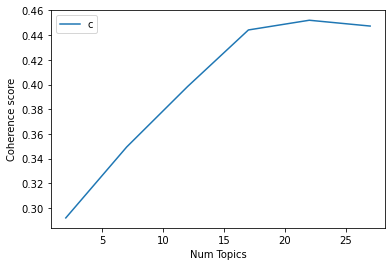

In [96]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [97]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.292
index: 1 | Num Topics = 7  has Coherence Value of 0.3494
index: 2 | Num Topics = 12  has Coherence Value of 0.3984
index: 3 | Num Topics = 17  has Coherence Value of 0.4442
index: 4 | Num Topics = 22  has Coherence Value of 0.4521
index: 5 | Num Topics = 27  has Coherence Value of 0.4474


In [98]:
# Select optimal number of topics
optimal_model_ph_score3 = model_list_ph_score3[4]

In [99]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score3, corpus_ph_score3, id2word_ph_score3)

In [100]:
print("pyLDAVis for ph topics for score=3:")
vis_ph_score3

pyLDAVis for ph topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.076681 -0.163616       1        1  14.704060
0     -0.077424 -0.074978       2        1   6.746291
6     -0.015980  0.012580       3        1   6.501249
21    -0.132064  0.132125       4        1   6.436333
5     -0.128545 -0.045781       5        1   5.884499
17     0.112527 -0.016685       6        1   5.756173
14     0.075033  0.040235       7        1   5.676465
7      0.172535  0.092176       8        1   4.663418
20    -0.053013 -0.044166       9        1   4.364285
12    -0.026805 -0.047681      10        1   4.013213
10     0.068823 -0.081408      11        1   3.866037
19     0.018208 -0.088021      12        1   3.754344
2      0.043398  0.089095      13        1   3.591359
13    -0.069794 -0.051010      14        1   3.585560
15     0.005599  0.042858      15        1   3.552865
9     -0.042065 -0.042537      16        1   3.433488
3      0.058925  0.000325      17        1   3.062374
11    -0.046346  0.005457      18        1   2.973307
16     0.004072  0.053200      19        1   2.347555
18    -0.081682  0.022960      20        1   1.788906
8     -0.052000  0.122193      21        1   1.709698
4      0.089916  0.042680      22        1   1.588521, topic_info=         Term       Freq      Total Category  logprob  loglift
31     filter  41.000000  41.000000  Default  30.0000  30.0000
21   snapchat  42.000000  42.000000  Default  29.0000  29.0000
148    friend  18.000000  18.000000  Default  28.0000  28.0000
9         app  35.000000  35.000000  Default  27.0000  27.0000
8        work  12.000000  12.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
28        old   0.023332  10.739774  Topic22  -6.9479  -1.9895
162     aside   0.023332   1.578110  Topic22  -6.9479  -0.0718
171  feedback   0.023332   1.578110  Topic22  -6.9479  -0.0718
30       well   0.023332   7.890341  Topic22  -6.9479  -1.6812
166   buttong   0.023332   1.578110  Topic22  -6.9479  -0.0718

[973 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
504      18  0.730703    able
410       9  0.910094  accept
207       3  0.230321  access
207       6  0.230321  access
207      11  0.230321  access
...     ...       ...     ...
398      16  0.443048     yet
393       8  0.690792   young
359      17  0.723163      yr
431       1  0.675166    zoom
431      22  0.337583    zoom

[1064 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 7, 22, 6, 18, 15, 8, 21, 13, 11, 20, 3, 14, 16, 10, 4, 12, 17, 19, 9, 5])

## LDA Topic Modelling (Rating = 4)

In [101]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_ph_score4 = snapchat_ios_ph_review_YearMonth_score4.review.values.tolist()
review_words_ph_score4 = list(sent_to_words(review_ph_score4))
print(review_words_ph_score4[2:3])

[['like', 'the', 'app', 'but', 'really', 'liked', 'the', 'minnie', 'mouse', 'filter', 'please', 'bring', 'it', 'back', 'because', 'me', 'and', 'other', 'people', 'really', 'liked', 'that', 'filter', 'so', 'please', 'bring', 'it', 'back', 'because', 'liked', 'it', 'so', 'much', 'it', 'actually', 'my', 'fave']]


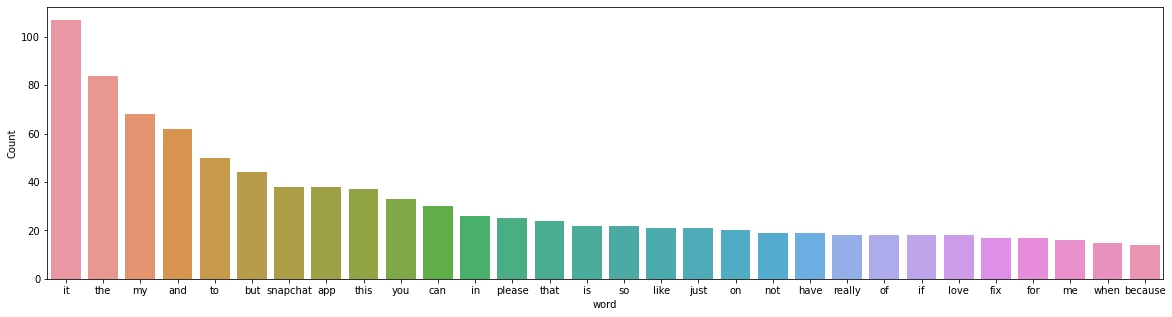

In [102]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score4))

In [103]:
# Clean text
review_ph_ready_score4 = process_words(review_words_ph_score4)  # processed Text Data! - move to each section

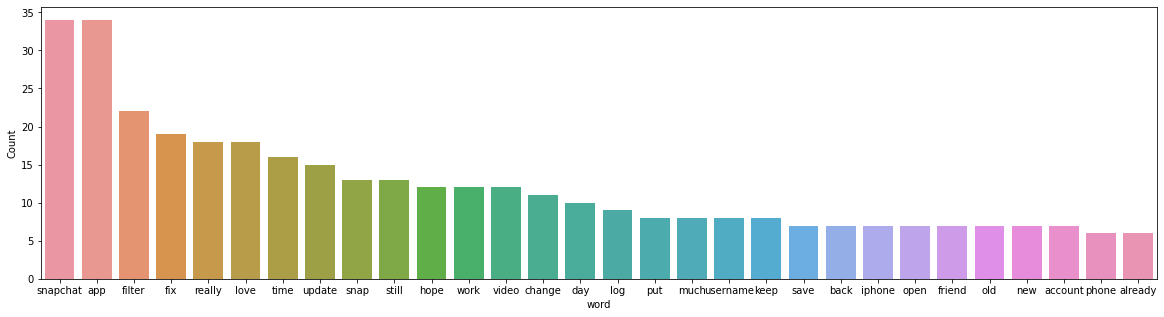

In [104]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score4))


In [105]:
# Create Dictionary
id2word_ph_score4 = corpora.Dictionary(review_ph_ready_score4)

2021-10-16 20:47:46,547 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:47:46,555 [INFO] gensim.corpora.dictionary - built Dictionary(352 unique tokens: ['choose', 'emoji', 'emojis', 'favorite', 'hope']...) from 75 documents (total 903 corpus positions)
2021-10-16 20:47:46,558 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(352 unique tokens: ['choose', 'emoji', 'emojis', 'favorite', 'hope']...) from 75 documents (total 903 corpus positions)", 'datetime': '2021-10-16T20:47:46.558021', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [106]:
# Create Corpus: Term Document Frequency
corpus_ph_score4 = [id2word_ph_score4.doc2bow(text) for text in review_ph_ready_score4]

In [107]:
# Training LDA model
model_list_ph_score4, coherence_values_ph_score4 = compute_coherence_values(dictionary=id2word_ph_score4, corpus=corpus_ph_score4, 
                                                              texts=review_ph_ready_score4, limit=30, start=2, step=5)


2021-10-16 20:47:46,582 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:47:46,583 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:47:46,586 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:47:46,589 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 75 documents, updating model once every 75 documents, evaluating perplexity every 75 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:47:46,915 [INFO] gensim.models.ldamodel - -6.555 per-word bound, 94.1 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:47:46,973 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #75/75
2021-10-16 20:47:47,287 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.039*"app" + 0.031*"snapchat" + 0.022*"filter" + 0.018*"love" + 0.016*"update" + 0.014*"time" + 0.014*"fix" + 0

2021-10-16 20:47:49,818 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"snapchat" + 0.019*"fix" + 0.015*"change" + 0.014*"really" + 0.013*"username" + 0.013*"old" + 0.013*"filter" + 0.012*"new" + 0.012*"account" + 0.012*"snap"
2021-10-16 20:47:49,828 [INFO] gensim.models.ldamodel - topic diff=0.011514, rho=0.301511
2021-10-16 20:47:49,933 [INFO] gensim.models.ldamodel - -5.772 per-word bound, 54.6 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:47:49,934 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #75/75
2021-10-16 20:47:50,102 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"app" + 0.031*"snapchat" + 0.023*"filter" + 0.020*"love" + 0.018*"video" + 0.017*"update" + 0.016*"really" + 0.016*"time" + 0.014*"work" + 0.014*"fix"
2021-10-16 20:47:50,106 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"snapchat" + 0.018*"fix" + 0.015*"change" + 0.014*"username" + 0.014*"really" + 0.013*"old" + 0.013*"filter

2021-10-16 20:47:52,231 [INFO] gensim.models.ldamodel - topic diff=0.004012, rho=0.218218
2021-10-16 20:47:52,410 [INFO] gensim.models.ldamodel - -5.766 per-word bound, 54.4 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:47:52,418 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #75/75
2021-10-16 20:47:52,548 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.041*"app" + 0.030*"snapchat" + 0.023*"filter" + 0.020*"love" + 0.019*"video" + 0.017*"time" + 0.016*"really" + 0.015*"update" + 0.014*"fix" + 0.014*"work"
2021-10-16 20:47:52,555 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"snapchat" + 0.018*"fix" + 0.016*"change" + 0.014*"username" + 0.014*"really" + 0.013*"old" + 0.013*"new" + 0.013*"app" + 0.013*"filter" + 0.013*"account"
2021-10-16 20:47:52,560 [INFO] gensim.models.ldamodel - topic diff=0.003719, rho=0.213201
2021-10-16 20:47:52,707 [INFO] gensim.models.ldamodel - -5.765 per-word bound, 54.4 perplexity est

2021-10-16 20:47:54,822 [INFO] gensim.models.ldamodel - -5.763 per-word bound, 54.3 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:47:54,823 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #75/75
2021-10-16 20:47:54,869 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.029*"snapchat" + 0.024*"filter" + 0.020*"love" + 0.019*"video" + 0.017*"time" + 0.016*"really" + 0.015*"update" + 0.015*"fix" + 0.014*"work"
2021-10-16 20:47:54,870 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"snapchat" + 0.017*"fix" + 0.016*"change" + 0.014*"username" + 0.014*"app" + 0.014*"really" + 0.013*"old" + 0.013*"new" + 0.013*"account" + 0.012*"filter"
2021-10-16 20:47:54,872 [INFO] gensim.models.ldamodel - topic diff=0.003375, rho=0.176777
2021-10-16 20:47:55,115 [INFO] gensim.models.ldamodel - -5.762 per-word bound, 54.3 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:47:55,116 [I

2021-10-16 20:47:57,419 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #75/75
2021-10-16 20:47:57,573 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.039*"app" + 0.029*"snapchat" + 0.024*"filter" + 0.021*"love" + 0.019*"video" + 0.017*"time" + 0.016*"really" + 0.015*"update" + 0.015*"fix" + 0.014*"work"
2021-10-16 20:47:57,583 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"snapchat" + 0.017*"fix" + 0.016*"change" + 0.015*"app" + 0.014*"really" + 0.014*"username" + 0.013*"log" + 0.013*"old" + 0.013*"new" + 0.012*"account"
2021-10-16 20:47:57,588 [INFO] gensim.models.ldamodel - topic diff=0.001194, rho=0.154303
2021-10-16 20:47:57,796 [INFO] gensim.models.ldamodel - -5.761 per-word bound, 54.2 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:47:57,799 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #75/75
2021-10-16 20:47:57,919 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.039*"app" + 0.029*"sn

2021-10-16 20:47:59,923 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:48:06,024 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:48:06,055 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 71 virtual documents
2021-10-16 20:48:06,468 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:48:06,469 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:48:06,472 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:48:06,474 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 75 documents, updating model once every 75 documents, evaluating perplexity every 75 documents, iterating 50x with a converg

2021-10-16 20:48:08,049 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"snapchat" + 0.016*"fix" + 0.016*"find" + 0.016*"work" + 0.016*"friend" + 0.016*"love" + 0.016*"problem" + 0.016*"guy" + 0.016*"happen" + 0.016*"eye"
2021-10-16 20:48:08,050 [INFO] gensim.models.ldamodel - topic diff=0.043028, rho=0.408248
2021-10-16 20:48:08,180 [INFO] gensim.models.ldamodel - -6.152 per-word bound, 71.1 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:08,182 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #75/75
2021-10-16 20:48:08,211 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.058*"snapchat" + 0.035*"filter" + 0.030*"app" + 0.024*"love" + 0.024*"update" + 0.018*"video" + 0.018*"fix" + 0.018*"face" + 0.018*"really" + 0.018*"internet"
2021-10-16 20:48:08,213 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"phone" + 0.027*"update" + 0.026*"filter" + 0.026*"like" + 0.026*"back" + 0.021*"app" + 0.018*"username" + 0.0

2021-10-16 20:48:09,165 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"snapchat" + 0.016*"work" + 0.016*"friend" + 0.016*"fix" + 0.016*"problem" + 0.016*"love" + 0.016*"find" + 0.016*"eye" + 0.016*"guy" + 0.016*"happen"
2021-10-16 20:48:09,166 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"app" + 0.023*"fix" + 0.023*"time" + 0.023*"love" + 0.019*"log" + 0.019*"save" + 0.019*"account" + 0.019*"really" + 0.015*"hope" + 0.015*"filter"
2021-10-16 20:48:09,167 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"phone" + 0.026*"update" + 0.026*"filter" + 0.026*"like" + 0.026*"back" + 0.022*"app" + 0.018*"username" + 0.018*"change" + 0.018*"old" + 0.018*"love"
2021-10-16 20:48:09,168 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.037*"video" + 0.032*"still" + 0.030*"app" + 0.020*"work" + 0.020*"snap" + 0.017*"snapchat" + 0.017*"filter" + 0.017*"much" + 0.017*"really" + 0.017*"time"
2021-10-16 20:48:09,169 [INFO] gensim.models.ldamodel - topic diff=0.006533, rho=0

2021-10-16 20:48:10,209 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.058*"snapchat" + 0.035*"filter" + 0.030*"app" + 0.024*"love" + 0.024*"update" + 0.018*"fix" + 0.018*"video" + 0.018*"face" + 0.018*"internet" + 0.018*"really"
2021-10-16 20:48:10,211 [INFO] gensim.models.ldamodel - topic diff=0.001558, rho=0.242536
2021-10-16 20:48:10,293 [INFO] gensim.models.ldamodel - -6.140 per-word bound, 70.5 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:10,297 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #75/75
2021-10-16 20:48:10,415 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"snapchat" + 0.029*"app" + 0.022*"update" + 0.020*"help" + 0.020*"hope" + 0.016*"really" + 0.016*"picture" + 0.016*"wait" + 0.013*"still" + 0.012*"add"
2021-10-16 20:48:10,417 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"app" + 0.023*"fix" + 0.023*"time" + 0.023*"love" + 0.019*"log" + 0.019*"save" + 0.019*"really" + 0.019*"ac

2021-10-16 20:48:11,621 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.037*"video" + 0.032*"still" + 0.030*"app" + 0.020*"work" + 0.020*"snap" + 0.017*"snapchat" + 0.017*"much" + 0.017*"really" + 0.017*"time" + 0.017*"filter"
2021-10-16 20:48:11,624 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"snapchat" + 0.016*"friend" + 0.016*"work" + 0.016*"fix" + 0.016*"problem" + 0.016*"love" + 0.016*"eye" + 0.016*"guy" + 0.016*"happen" + 0.016*"idk"
2021-10-16 20:48:11,627 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"snapchat" + 0.029*"app" + 0.022*"update" + 0.020*"help" + 0.020*"hope" + 0.016*"really" + 0.016*"picture" + 0.016*"wait" + 0.013*"still" + 0.012*"add"
2021-10-16 20:48:11,630 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"app" + 0.023*"fix" + 0.023*"time" + 0.023*"love" + 0.019*"log" + 0.019*"save" + 0.019*"really" + 0.019*"account" + 0.015*"let" + 0.015*"keep"
2021-10-16 20:48:11,632 [INFO] gensim.models.ldamodel - topic diff=0.000323, rho=0.20

2021-10-16 20:48:13,073 [INFO] gensim.models.ldamodel - topic diff=0.000100, rho=0.188982
2021-10-16 20:48:13,126 [INFO] gensim.models.ldamodel - -6.140 per-word bound, 70.5 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:13,127 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #75/75
2021-10-16 20:48:13,337 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"snapchat" + 0.029*"app" + 0.022*"update" + 0.020*"help" + 0.020*"hope" + 0.016*"really" + 0.016*"picture" + 0.016*"wait" + 0.013*"still" + 0.012*"add"
2021-10-16 20:48:13,340 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"snapchat" + 0.016*"friend" + 0.016*"work" + 0.016*"problem" + 0.016*"fix" + 0.016*"love" + 0.016*"eye" + 0.016*"guy" + 0.016*"happen" + 0.016*"idk"
2021-10-16 20:48:13,342 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"phone" + 0.026*"update" + 0.026*"filter" + 0.026*"back" + 0.026*"like" + 0.022*"app" + 0.018*"username" + 0.018*

2021-10-16 20:48:14,910 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.018*"love" + 0.018*"time" + 0.018*"filter" + 0.018*"day" + 0.018*"old" + 0.018*"amazing" + 0.018*"lock" + 0.018*"back" + 0.018*"account" + 0.018*"temporarily"
2021-10-16 20:48:14,912 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"app" + 0.023*"fix" + 0.023*"time" + 0.023*"love" + 0.019*"log" + 0.019*"save" + 0.019*"really" + 0.019*"account" + 0.015*"let" + 0.015*"keep"
2021-10-16 20:48:14,914 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"phone" + 0.026*"update" + 0.026*"filter" + 0.026*"back" + 0.026*"like" + 0.022*"app" + 0.018*"username" + 0.018*"change" + 0.018*"old" + 0.018*"really"
2021-10-16 20:48:14,915 [INFO] gensim.models.ldamodel - topic diff=0.000040, rho=0.171499
2021-10-16 20:48:14,974 [INFO] gensim.models.ldamodel - -6.140 per-word bound, 70.5 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:14,975 [INFO] gensim.models.ldamodel - P

2021-10-16 20:48:16,306 [INFO] gensim.models.ldamodel - topic diff=0.000031, rho=0.160128
2021-10-16 20:48:16,359 [INFO] gensim.models.ldamodel - -6.140 per-word bound, 70.5 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:16,465 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #75/75
2021-10-16 20:48:16,518 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.037*"video" + 0.032*"still" + 0.030*"app" + 0.020*"snap" + 0.020*"work" + 0.017*"snapchat" + 0.017*"much" + 0.017*"really" + 0.017*"already" + 0.017*"time"
2021-10-16 20:48:16,520 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"phone" + 0.026*"update" + 0.026*"filter" + 0.026*"back" + 0.026*"like" + 0.022*"app" + 0.018*"username" + 0.018*"change" + 0.018*"old" + 0.018*"really"
2021-10-16 20:48:16,522 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"app" + 0.023*"fix" + 0.023*"time" + 0.023*"love" + 0.019*"log" + 0.019*"save" + 0.019*"really" + 0.019*"acco

2021-10-16 20:48:17,821 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"snapchat" + 0.029*"app" + 0.023*"update" + 0.020*"help" + 0.020*"hope" + 0.016*"picture" + 0.016*"really" + 0.016*"wait" + 0.013*"still" + 0.012*"add"
2021-10-16 20:48:17,822 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"app" + 0.023*"time" + 0.023*"fix" + 0.023*"love" + 0.019*"log" + 0.019*"save" + 0.019*"really" + 0.019*"account" + 0.015*"let" + 0.015*"keep"
2021-10-16 20:48:17,824 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.037*"video" + 0.032*"still" + 0.030*"app" + 0.020*"snap" + 0.020*"work" + 0.017*"snapchat" + 0.017*"much" + 0.017*"really" + 0.017*"already" + 0.017*"time"
2021-10-16 20:48:17,825 [INFO] gensim.models.ldamodel - topic diff=0.000035, rho=0.149071
2021-10-16 20:48:17,947 [INFO] gensim.models.ldamodel - -6.140 per-word bound, 70.5 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:17,953 [INFO] gensim.models.ldamodel - PROGR

2021-10-16 20:48:18,850 [INFO] gensim.models.ldamodel - topic diff=0.000045, rho=0.141421
2021-10-16 20:48:18,917 [INFO] gensim.models.ldamodel - -6.140 per-word bound, 70.5 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:18,924 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #75/75
2021-10-16 20:48:19,039 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"snapchat" + 0.016*"friend" + 0.016*"work" + 0.016*"problem" + 0.016*"fix" + 0.016*"love" + 0.016*"eye" + 0.016*"guy" + 0.016*"happen" + 0.016*"idk"
2021-10-16 20:48:19,042 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.037*"video" + 0.032*"still" + 0.030*"app" + 0.020*"snap" + 0.020*"work" + 0.017*"snapchat" + 0.017*"much" + 0.017*"really" + 0.017*"already" + 0.017*"time"
2021-10-16 20:48:19,052 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.018*"love" + 0.018*"time" + 0.018*"filter" + 0.018*"day" + 0.018*"old" + 0.018*"amazing" + 0.018*"lock" + 0.018*"back

2021-10-16 20:48:27,715 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.031*"fix" + 0.030*"issue" + 0.022*"app" + 0.021*"love" + 0.021*"time" + 0.021*"temporarily" + 0.021*"account" + 0.021*"lock" + 0.021*"day" + 0.020*"snap"
2021-10-16 20:48:27,717 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.057*"face" + 0.055*"filter" + 0.040*"app" + 0.028*"snapchat" + 0.027*"give" + 0.025*"baby" + 0.014*"download" + 0.014*"update" + 0.014*"hope" + 0.014*"log"
2021-10-16 20:48:27,721 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.057*"app" + 0.042*"filter" + 0.040*"snapchat" + 0.037*"video" + 0.032*"love" + 0.031*"change" + 0.024*"really" + 0.022*"time" + 0.020*"much" + 0.019*"iphone"
2021-10-16 20:48:27,725 [INFO] gensim.models.ldamodel - topic diff=0.091987, rho=0.447214
2021-10-16 20:48:27,909 [INFO] gensim.models.ldamodel - -6.271 per-word bound, 77.2 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:27,910 [INFO] gensim.models.ldamode

2021-10-16 20:48:28,932 [INFO] gensim.models.ldamodel - -6.237 per-word bound, 75.4 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:28,938 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #75/75
2021-10-16 20:48:28,989 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.042*"snapchat" + 0.032*"really" + 0.032*"fix" + 0.032*"like" + 0.031*"people" + 0.031*"love" + 0.027*"let" + 0.026*"username" + 0.021*"filter" + 0.021*"back"
2021-10-16 20:48:28,991 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.037*"update" + 0.025*"app" + 0.025*"filter" + 0.025*"old" + 0.025*"bring" + 0.025*"miss" + 0.025*"next" + 0.025*"snapchat" + 0.025*"emoji" + 0.025*"mask"
2021-10-16 20:48:28,995 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.062*"internet" + 0.037*"snap" + 0.037*"connection" + 0.025*"work" + 0.025*"fix" + 0.025*"new" + 0.025*"open" + 0.025*"black" + 0.025*"create" + 0.025*"connected"
2021-10-16 20:48:28,998 [INFO] gensim.mode

2021-10-16 20:48:29,933 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.074*"filter" + 0.066*"face" + 0.040*"app" + 0.027*"give" + 0.027*"baby" + 0.017*"snapchat" + 0.014*"download" + 0.014*"hope" + 0.014*"log" + 0.014*"love"
2021-10-16 20:48:29,934 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.058*"app" + 0.044*"filter" + 0.042*"snapchat" + 0.039*"video" + 0.033*"love" + 0.025*"really" + 0.023*"change" + 0.022*"time" + 0.022*"much" + 0.020*"iphone"
2021-10-16 20:48:29,939 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.062*"snapchat" + 0.027*"update" + 0.025*"app" + 0.022*"help" + 0.022*"still" + 0.017*"back" + 0.017*"snapscore" + 0.017*"hope" + 0.017*"picture" + 0.017*"mode"
2021-10-16 20:48:29,941 [INFO] gensim.models.ldamodel - topic diff=0.003024, rho=0.250000
2021-10-16 20:48:30,069 [INFO] gensim.models.ldamodel - -6.231 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:30,071 [INFO] gensim.models.lda

2021-10-16 20:48:30,964 [INFO] gensim.models.ldamodel - topic diff=0.000985, rho=0.218218
2021-10-16 20:48:31,067 [INFO] gensim.models.ldamodel - -6.230 per-word bound, 75.0 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:31,076 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #75/75
2021-10-16 20:48:31,175 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.031*"fix" + 0.031*"issue" + 0.021*"app" + 0.021*"love" + 0.021*"time" + 0.021*"day" + 0.021*"lock" + 0.021*"account" + 0.021*"temporarily" + 0.021*"snap"
2021-10-16 20:48:31,176 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.063*"snapchat" + 0.028*"update" + 0.025*"app" + 0.022*"help" + 0.022*"still" + 0.017*"back" + 0.017*"snapscore" + 0.017*"hope" + 0.017*"picture" + 0.017*"mode"
2021-10-16 20:48:31,178 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.058*"app" + 0.044*"filter" + 0.042*"snapchat" + 0.039*"video" + 0.033*"love" + 0.025*"really" + 0.022*"change" +

2021-10-16 20:48:32,180 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.031*"fix" + 0.031*"issue" + 0.021*"app" + 0.021*"love" + 0.021*"time" + 0.021*"day" + 0.021*"lock" + 0.021*"account" + 0.021*"temporarily" + 0.021*"snap"
2021-10-16 20:48:32,183 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.041*"snapchat" + 0.031*"really" + 0.031*"fix" + 0.031*"like" + 0.031*"people" + 0.031*"love" + 0.031*"let" + 0.031*"username" + 0.021*"filter" + 0.021*"back"
2021-10-16 20:48:32,186 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.062*"internet" + 0.037*"snap" + 0.037*"connection" + 0.025*"work" + 0.025*"fix" + 0.025*"new" + 0.025*"open" + 0.025*"black" + 0.025*"create" + 0.025*"connected"
2021-10-16 20:48:32,188 [INFO] gensim.models.ldamodel - topic diff=0.000295, rho=0.192450
2021-10-16 20:48:32,308 [INFO] gensim.models.ldamodel - -6.229 per-word bound, 75.0 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:32,309 [INFO] gensim.models.

2021-10-16 20:48:33,298 [INFO] gensim.models.ldamodel - topic diff=0.000108, rho=0.176777
2021-10-16 20:48:33,426 [INFO] gensim.models.ldamodel - -6.229 per-word bound, 75.0 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:33,430 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #75/75
2021-10-16 20:48:33,547 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.063*"snapchat" + 0.028*"update" + 0.025*"app" + 0.022*"help" + 0.022*"still" + 0.017*"back" + 0.017*"snapscore" + 0.017*"hope" + 0.017*"picture" + 0.017*"mode"
2021-10-16 20:48:33,550 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.077*"filter" + 0.067*"face" + 0.040*"app" + 0.027*"give" + 0.027*"baby" + 0.015*"snapchat" + 0.014*"download" + 0.014*"hope" + 0.014*"love" + 0.014*"find"
2021-10-16 20:48:33,552 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.041*"snapchat" + 0.028*"love" + 0.028*"old" + 0.028*"user" + 0.028*"fix" + 0.014*"username" + 0.014*"change" + 

2021-10-16 20:48:34,564 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.046*"update" + 0.024*"hope" + 0.024*"day" + 0.024*"change" + 0.024*"old" + 0.024*"snapchat" + 0.024*"still" + 0.024*"happen" + 0.024*"week" + 0.024*"time"
2021-10-16 20:48:34,567 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.041*"snapchat" + 0.028*"love" + 0.028*"old" + 0.028*"user" + 0.028*"fix" + 0.014*"username" + 0.014*"change" + 0.014*"update" + 0.014*"mode" + 0.014*"fast"
2021-10-16 20:48:34,571 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.031*"fix" + 0.031*"issue" + 0.021*"app" + 0.021*"love" + 0.021*"time" + 0.021*"day" + 0.021*"account" + 0.021*"lock" + 0.021*"temporarily" + 0.021*"iphone"
2021-10-16 20:48:34,573 [INFO] gensim.models.ldamodel - topic diff=0.000366, rho=0.162221
2021-10-16 20:48:34,660 [INFO] gensim.models.ldamodel - -6.230 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:34,665 [INFO] gensim.models.ldamodel

2021-10-16 20:48:35,601 [INFO] gensim.models.ldamodel - topic diff=0.000381, rho=0.152499
2021-10-16 20:48:35,776 [INFO] gensim.models.ldamodel - -6.229 per-word bound, 75.0 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:35,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #75/75
2021-10-16 20:48:35,819 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.044*"put" + 0.030*"filter" + 0.030*"really" + 0.030*"font" + 0.030*"photo" + 0.030*"phone" + 0.015*"hope" + 0.015*"lag" + 0.015*"camera" + 0.015*"idea"
2021-10-16 20:48:35,824 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.046*"update" + 0.024*"change" + 0.024*"hope" + 0.024*"old" + 0.024*"day" + 0.024*"snapchat" + 0.024*"still" + 0.024*"happen" + 0.024*"week" + 0.024*"time"
2021-10-16 20:48:35,826 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.062*"internet" + 0.037*"snap" + 0.037*"connection" + 0.025*"work" + 0.025*"fix" + 0.025*"new" + 0.025*"open" + 0.025*"

2021-10-16 20:48:36,802 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.059*"app" + 0.045*"filter" + 0.042*"snapchat" + 0.039*"video" + 0.034*"love" + 0.026*"really" + 0.023*"time" + 0.023*"much" + 0.021*"iphone" + 0.020*"change"
2021-10-16 20:48:36,804 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.062*"internet" + 0.037*"snap" + 0.037*"connection" + 0.025*"work" + 0.025*"fix" + 0.025*"new" + 0.025*"open" + 0.025*"black" + 0.025*"create" + 0.025*"connected"
2021-10-16 20:48:36,806 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.077*"filter" + 0.067*"face" + 0.040*"app" + 0.027*"give" + 0.027*"baby" + 0.015*"snapchat" + 0.014*"love" + 0.014*"hope" + 0.014*"find" + 0.014*"instal"
2021-10-16 20:48:36,807 [INFO] gensim.models.ldamodel - topic diff=0.000321, rho=0.142857
2021-10-16 20:48:36,857 [INFO] gensim.models.ldamodel - -6.228 per-word bound, 74.9 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:36,859 [INFO] gensim.models.l

2021-10-16 20:48:47,189 [INFO] gensim.models.ldamodel - -6.523 per-word bound, 92.0 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:47,192 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #75/75
2021-10-16 20:48:47,220 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.043*"next" + 0.043*"emoji" + 0.043*"update" + 0.043*"mask" + 0.025*"snapchat" + 0.025*"put" + 0.025*"hope" + 0.023*"miss" + 0.023*"save" + 0.022*"choose"
2021-10-16 20:48:47,222 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.039*"app" + 0.037*"snapchat" + 0.032*"already" + 0.031*"love" + 0.030*"snap" + 0.027*"update" + 0.021*"filter" + 0.021*"change" + 0.021*"battery" + 0.021*"long"
2021-10-16 20:48:47,224 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.062*"really" + 0.049*"like" + 0.048*"filter" + 0.033*"bring" + 0.033*"back" + 0.032*"much" + 0.032*"app" + 0.031*"time" + 0.030*"video" + 0.020*"snapchat"
2021-10-16 20:48:47,225 [INFO] gensim.models.l

2021-10-16 20:48:48,416 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.004*"work" + 0.004*"iphone" + 0.003*"trophy" + 0.003*"meeeee" + 0.003*"pleaseeeee" + 0.003*"user" + 0.003*"believe" + 0.003*"literally" + 0.003*"well" + 0.003*"super"
2021-10-16 20:48:48,419 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.046*"emoji" + 0.046*"next" + 0.046*"update" + 0.046*"mask" + 0.024*"snapchat" + 0.024*"put" + 0.024*"hope" + 0.024*"miss" + 0.024*"save" + 0.024*"choose"
2021-10-16 20:48:48,421 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.050*"phone" + 0.050*"filter" + 0.029*"update" + 0.027*"work" + 0.026*"app" + 0.026*"name" + 0.026*"amazing" + 0.026*"old" + 0.026*"nuce" + 0.026*"flower"
2021-10-16 20:48:48,424 [INFO] gensim.models.ldamodel - topic diff=0.038482, rho=0.333333
2021-10-16 20:48:48,514 [INFO] gensim.models.ldamodel - -6.310 per-word bound, 79.4 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:48,518 [INFO] gensim.models.

2021-10-16 20:48:49,345 [INFO] gensim.models.ldamodel - topic diff=0.009792, rho=0.267261
2021-10-16 20:48:49,433 [INFO] gensim.models.ldamodel - -6.302 per-word bound, 78.9 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:49,435 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #75/75
2021-10-16 20:48:49,540 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.052*"filter" + 0.052*"phone" + 0.027*"update" + 0.027*"work" + 0.027*"app" + 0.027*"bring" + 0.027*"name" + 0.027*"flower" + 0.027*"amazing" + 0.027*"nuce"
2021-10-16 20:48:49,543 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.027*"really" + 0.027*"fix" + 0.027*"filter" + 0.027*"awesome" + 0.027*"however" + 0.027*"fun" + 0.027*"compare" + 0.027*"troubleshoot" + 0.027*"notification" + 0.027*"dark"
2021-10-16 20:48:49,544 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.071*"filter" + 0.043*"snapchat" + 0.043*"face" + 0.043*"app" + 0.029*"fix" + 0.029*"baby" + 0.015

2021-10-16 20:48:50,469 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.075*"app" + 0.038*"filter" + 0.038*"snapchat" + 0.031*"love" + 0.023*"video" + 0.023*"keep" + 0.023*"time" + 0.023*"wait" + 0.023*"put" + 0.023*"code"
2021-10-16 20:48:50,473 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.046*"emoji" + 0.046*"mask" + 0.046*"next" + 0.046*"update" + 0.024*"snapchat" + 0.024*"put" + 0.024*"hope" + 0.024*"miss" + 0.024*"save" + 0.024*"whenever"
2021-10-16 20:48:50,475 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.076*"change" + 0.061*"username" + 0.046*"new" + 0.046*"let" + 0.031*"snap" + 0.031*"fix" + 0.031*"love" + 0.031*"snapchat" + 0.016*"tell" + 0.016*"app"
2021-10-16 20:48:50,478 [INFO] gensim.models.ldamodel - topic diff=0.002479, rho=0.223607
2021-10-16 20:48:50,589 [INFO] gensim.models.ldamodel - -6.298 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:50,592 [INFO] gensim.models.ldamodel - PROG

2021-10-16 20:48:51,462 [INFO] gensim.models.ldamodel - topic diff=0.001065, rho=0.200000
2021-10-16 20:48:51,516 [INFO] gensim.models.ldamodel - -6.296 per-word bound, 78.6 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:51,517 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #75/75
2021-10-16 20:48:51,670 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.041*"love" + 0.041*"username" + 0.041*"fix" + 0.021*"school" + 0.021*"option" + 0.021*"age" + 0.021*"change" + 0.021*"app" + 0.021*"probably" + 0.021*"overall"
2021-10-16 20:48:51,672 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.036*"really" + 0.030*"log" + 0.025*"app" + 0.024*"fix" + 0.024*"lie" + 0.024*"save" + 0.024*"keep" + 0.024*"time" + 0.024*"account" + 0.018*"space"
2021-10-16 20:48:51,674 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.056*"time" + 0.040*"fix" + 0.026*"hope" + 0.023*"account" + 0.023*"day" + 0.023*"work" + 0.023*"temporarily" + 0.023*

2021-10-16 20:48:52,553 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.052*"filter" + 0.052*"phone" + 0.027*"update" + 0.027*"work" + 0.027*"app" + 0.027*"back" + 0.027*"name" + 0.027*"flower" + 0.027*"bring" + 0.027*"amazing"
2021-10-16 20:48:52,556 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.066*"really" + 0.050*"like" + 0.050*"filter" + 0.034*"video" + 0.033*"back" + 0.033*"bring" + 0.033*"much" + 0.033*"app" + 0.033*"time" + 0.017*"fave"
2021-10-16 20:48:52,557 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.041*"love" + 0.041*"username" + 0.041*"fix" + 0.021*"school" + 0.021*"option" + 0.021*"age" + 0.021*"change" + 0.021*"app" + 0.021*"probably" + 0.021*"overall"
2021-10-16 20:48:52,559 [INFO] gensim.models.ldamodel - topic diff=0.000507, rho=0.179605
2021-10-16 20:48:52,663 [INFO] gensim.models.ldamodel - -6.296 per-word bound, 78.6 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:52,664 [INFO] gensim.models.ldamode

2021-10-16 20:48:53,401 [INFO] gensim.models.ldamodel - topic diff=0.000237, rho=0.166667
2021-10-16 20:48:53,586 [INFO] gensim.models.ldamodel - -6.296 per-word bound, 78.6 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:53,588 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #75/75
2021-10-16 20:48:53,673 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.076*"change" + 0.061*"username" + 0.046*"new" + 0.046*"let" + 0.031*"snap" + 0.031*"fix" + 0.031*"love" + 0.031*"snapchat" + 0.016*"tell" + 0.016*"app"
2021-10-16 20:48:53,675 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.075*"app" + 0.038*"filter" + 0.038*"snapchat" + 0.031*"love" + 0.023*"video" + 0.023*"keep" + 0.023*"time" + 0.023*"wait" + 0.023*"put" + 0.023*"code"
2021-10-16 20:48:53,679 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.027*"really" + 0.027*"fix" + 0.027*"filter" + 0.027*"fun" + 0.027*"fast" + 0.027*"awesome" + 0.027*"troubleshoot" + 0.027*

2021-10-16 20:48:54,621 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.003*"iphone" + 0.003*"work" + 0.003*"trophy" + 0.003*"meeeee" + 0.003*"pleaseeeee" + 0.003*"user" + 0.003*"believe" + 0.003*"literally" + 0.003*"well" + 0.003*"super"
2021-10-16 20:48:54,623 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.053*"app" + 0.053*"iphone" + 0.042*"work" + 0.042*"video" + 0.032*"snapchat" + 0.032*"dark" + 0.032*"mode" + 0.030*"still" + 0.021*"issue" + 0.021*"really"
2021-10-16 20:48:54,624 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.071*"filter" + 0.043*"snapchat" + 0.043*"app" + 0.043*"face" + 0.029*"fix" + 0.029*"baby" + 0.015*"datum" + 0.015*"iphone" + 0.015*"bloom" + 0.015*"much"
2021-10-16 20:48:54,625 [INFO] gensim.models.ldamodel - topic diff=0.000092, rho=0.154303
2021-10-16 20:48:54,796 [INFO] gensim.models.ldamodel - -6.296 per-word bound, 78.6 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:54,798 [INFO] gensim.mode

2021-10-16 20:48:55,560 [INFO] gensim.models.ldamodel - topic diff=0.000043, rho=0.145865
2021-10-16 20:48:55,609 [INFO] gensim.models.ldamodel - -6.296 per-word bound, 78.6 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:48:55,610 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #75/75
2021-10-16 20:48:55,638 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.047*"snapchat" + 0.036*"snap" + 0.036*"update" + 0.024*"download" + 0.024*"apple" + 0.024*"change" + 0.024*"user" + 0.024*"help" + 0.024*"old" + 0.024*"back"
2021-10-16 20:48:55,639 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.041*"love" + 0.041*"username" + 0.041*"fix" + 0.021*"school" + 0.021*"option" + 0.021*"age" + 0.021*"change" + 0.021*"app" + 0.021*"probably" + 0.021*"overall"
2021-10-16 20:48:55,640 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.069*"black" + 0.052*"open" + 0.052*"turn" + 0.049*"hope" + 0.035*"connection" + 0.035*"internet" + 0.035*"

2021-10-16 20:49:10,906 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.035*"temporarily" + 0.035*"lock" + 0.035*"time" + 0.035*"account" + 0.034*"day" + 0.026*"issue" + 0.024*"fix" + 0.021*"snap" + 0.020*"baby" + 0.020*"filter"
2021-10-16 20:49:10,909 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.058*"app" + 0.045*"change" + 0.040*"add" + 0.034*"mode" + 0.033*"snapchat" + 0.033*"dark" + 0.023*"one" + 0.023*"let" + 0.023*"filter" + 0.023*"open"
2021-10-16 20:49:10,911 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.070*"filter" + 0.035*"still" + 0.035*"annoying" + 0.035*"fix" + 0.035*"phone" + 0.018*"turn" + 0.018*"whenever" + 0.018*"nowhere" + 0.018*"tiktok" + 0.018*"open"
2021-10-16 20:49:10,913 [INFO] gensim.models.ldamodel - topic diff=17.926622, rho=1.000000
2021-10-16 20:49:10,968 [INFO] gensim.models.ldamodel - -6.633 per-word bound, 99.3 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:10,970 [INFO] gensim.models.lda

2021-10-16 20:49:11,737 [INFO] gensim.models.ldamodel - topic diff=0.043460, rho=0.377964
2021-10-16 20:49:11,818 [INFO] gensim.models.ldamodel - -6.404 per-word bound, 84.7 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:11,819 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #75/75
2021-10-16 20:49:11,856 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.057*"app" + 0.046*"snapchat" + 0.034*"update" + 0.034*"new" + 0.034*"username" + 0.034*"filter" + 0.023*"bug" + 0.023*"face" + 0.023*"lag" + 0.023*"love"
2021-10-16 20:49:11,858 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.003*"picture" + 0.003*"snapchat" + 0.003*"ask" + 0.003*"contact" + 0.003*"help" + 0.003*"memory" + 0.003*"team" + 0.003*"creator" + 0.003*"possible" + 0.003*"miss"
2021-10-16 20:49:11,860 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.061*"video" + 0.049*"time" + 0.033*"much" + 0.033*"app" + 0.033*"really" + 0.033*"love" + 0.017*"snap" + 0.0

2021-10-16 20:49:13,064 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.046*"snap" + 0.046*"change" + 0.035*"still" + 0.035*"snapchat" + 0.023*"apple" + 0.023*"download" + 0.023*"update" + 0.023*"day" + 0.023*"app" + 0.023*"already"
2021-10-16 20:49:13,067 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.042*"temporarily" + 0.042*"lock" + 0.042*"time" + 0.042*"account" + 0.042*"day" + 0.021*"issue" + 0.021*"fix" + 0.021*"snap" + 0.021*"maybe" + 0.021*"snapchat"
2021-10-16 20:49:13,069 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.065*"video" + 0.049*"time" + 0.033*"much" + 0.033*"really" + 0.033*"app" + 0.033*"love" + 0.017*"snap" + 0.017*"fix" + 0.017*"happen" + 0.017*"consume"
2021-10-16 20:49:13,072 [INFO] gensim.models.ldamodel - topic diff=0.005799, rho=0.277350
2021-10-16 20:49:13,186 [INFO] gensim.models.ldamodel - -6.396 per-word bound, 84.2 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:13,192 [INFO] gensim.models.l

2021-10-16 20:49:13,999 [INFO] gensim.models.ldamodel - topic diff=0.002276, rho=0.235702
2021-10-16 20:49:14,134 [INFO] gensim.models.ldamodel - -6.391 per-word bound, 83.9 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:14,156 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #75/75
2021-10-16 20:49:14,199 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.050*"internet" + 0.050*"new" + 0.050*"create" + 0.050*"connection" + 0.050*"phone" + 0.025*"lock" + 0.025*"permanently" + 0.025*"strong" + 0.025*"help" + 0.025*"everytime"
2021-10-16 20:49:14,200 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.003*"picture" + 0.003*"snapchat" + 0.003*"ask" + 0.003*"contact" + 0.003*"help" + 0.003*"memory" + 0.003*"team" + 0.003*"creator" + 0.003*"possible" + 0.003*"miss"
2021-10-16 20:49:14,203 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.065*"video" + 0.049*"time" + 0.033*"much" + 0.033*"really" + 0.033*"love" + 0.033*"app" 

2021-10-16 20:49:15,482 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.039*"snapchat" + 0.039*"fix" + 0.039*"black" + 0.039*"issue" + 0.039*"long" + 0.039*"love" + 0.039*"selfie" + 0.039*"turn" + 0.039*"experience" + 0.039*"time"
2021-10-16 20:49:15,486 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.061*"app" + 0.061*"add" + 0.061*"mode" + 0.061*"dark" + 0.041*"snapchat" + 0.023*"change" + 0.021*"old" + 0.021*"one" + 0.021*"open" + 0.021*"new"
2021-10-16 20:49:15,487 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.050*"connection" + 0.050*"new" + 0.050*"create" + 0.050*"internet" + 0.050*"phone" + 0.025*"lock" + 0.025*"permanently" + 0.025*"strong" + 0.025*"always" + 0.025*"help"
2021-10-16 20:49:15,492 [INFO] gensim.models.ldamodel - topic diff=0.000941, rho=0.204124
2021-10-16 20:49:15,619 [INFO] gensim.models.ldamodel - -6.387 per-word bound, 83.7 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:15,620 [INFO] gensim.model

2021-10-16 20:49:16,612 [INFO] gensim.models.ldamodel - topic diff=0.000545, rho=0.185695
2021-10-16 20:49:16,716 [INFO] gensim.models.ldamodel - -6.386 per-word bound, 83.7 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:16,717 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #75/75
2021-10-16 20:49:16,746 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.065*"app" + 0.052*"video" + 0.039*"snapchat" + 0.026*"filter" + 0.026*"update" + 0.026*"love" + 0.026*"much" + 0.026*"call" + 0.026*"lag" + 0.026*"fix"
2021-10-16 20:49:16,747 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.061*"app" + 0.061*"add" + 0.061*"mode" + 0.061*"dark" + 0.041*"snapchat" + 0.021*"change" + 0.021*"old" + 0.021*"one" + 0.021*"open" + 0.021*"new"
2021-10-16 20:49:16,748 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.070*"filter" + 0.035*"still" + 0.035*"phone" + 0.035*"annoying" + 0.035*"fix" + 0.018*"already" + 0.018*"video" + 0.018*"tur

2021-10-16 20:49:17,812 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.080*"old" + 0.054*"snapchat" + 0.054*"user" + 0.028*"update" + 0.028*"pleaseeeee" + 0.028*"believe" + 0.028*"alot" + 0.028*"happy" + 0.028*"meeeee" + 0.028*"change"
2021-10-16 20:49:17,815 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.047*"snapchat" + 0.047*"snapscore" + 0.047*"update" + 0.031*"app" + 0.016*"quick" + 0.016*"drain" + 0.016*"nonetheless" + 0.016*"battery" + 0.016*"love" + 0.016*"real"
2021-10-16 20:49:17,817 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.061*"app" + 0.041*"issue" + 0.041*"face" + 0.041*"give" + 0.041*"filter" + 0.041*"iphone" + 0.021*"really" + 0.021*"snap" + 0.021*"green" + 0.021*"love"
2021-10-16 20:49:17,819 [INFO] gensim.models.ldamodel - topic diff=0.000944, rho=0.169031
2021-10-16 20:49:17,921 [INFO] gensim.models.ldamodel - -6.386 per-word bound, 83.6 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:17,923 [INFO] g

2021-10-16 20:49:19,187 [INFO] gensim.models.ldamodel - topic diff=0.000574, rho=0.158114
2021-10-16 20:49:19,419 [INFO] gensim.models.ldamodel - -6.383 per-word bound, 83.5 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:19,422 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #75/75
2021-10-16 20:49:19,453 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.047*"snapchat" + 0.047*"snapscore" + 0.047*"update" + 0.031*"app" + 0.016*"hate" + 0.016*"drain" + 0.016*"battery" + 0.016*"quick" + 0.016*"love" + 0.016*"nonetheless"
2021-10-16 20:49:19,454 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.039*"snapchat" + 0.039*"fix" + 0.039*"black" + 0.039*"issue" + 0.039*"long" + 0.039*"love" + 0.039*"selfie" + 0.039*"turn" + 0.039*"experience" + 0.039*"time"
2021-10-16 20:49:19,455 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.057*"snapchat" + 0.057*"fix" + 0.029*"spam" + 0.029*"work" + 0.029*"place" + 0.029*"score" + 0.029*

2021-10-16 20:49:20,927 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.059*"video" + 0.056*"app" + 0.041*"snapchat" + 0.028*"filter" + 0.028*"call" + 0.028*"love" + 0.028*"much" + 0.028*"lag" + 0.028*"fix" + 0.028*"friend"
2021-10-16 20:49:20,928 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.061*"app" + 0.041*"give" + 0.041*"issue" + 0.041*"face" + 0.041*"filter" + 0.041*"iphone" + 0.021*"really" + 0.021*"snap" + 0.021*"green" + 0.021*"instal"
2021-10-16 20:49:20,930 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.061*"app" + 0.061*"add" + 0.061*"dark" + 0.061*"mode" + 0.041*"snapchat" + 0.021*"change" + 0.021*"wish" + 0.021*"white" + 0.021*"night" + 0.021*"hurt"
2021-10-16 20:49:20,931 [INFO] gensim.models.ldamodel - topic diff=0.000565, rho=0.147442
2021-10-16 20:49:21,049 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:21,051 [INFO] gensim.models.ldamodel - PR

2021-10-16 20:49:22,088 [INFO] gensim.models.ldamodel - topic diff=0.000456, rho=0.140028
2021-10-16 20:49:22,089 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=352, num_topics=22, decay=0.5, chunksize=1000) in 11.53s', 'datetime': '2021-10-16T20:49:22.089819', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:49:22,096 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:49:30,081 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:49:30,191 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 74 virtual documents
2021-10-16 20:49:36,197 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-16

2021-10-16 20:49:37,695 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.073*"snapchat" + 0.036*"love" + 0.036*"app" + 0.024*"filter" + 0.024*"help" + 0.024*"back" + 0.024*"button" + 0.024*"update" + 0.024*"day" + 0.024*"lose"
2021-10-16 20:49:37,696 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.064*"put" + 0.048*"app" + 0.047*"code" + 0.047*"wait" + 0.032*"snapchat" + 0.032*"email" + 0.032*"delete" + 0.032*"keep" + 0.032*"time" + 0.017*"reinstall"
2021-10-16 20:49:37,698 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.090*"love" + 0.076*"battery" + 0.051*"snapchat" + 0.051*"really" + 0.051*"fast" + 0.051*"time" + 0.002*"super" + 0.002*"delay" + 0.002*"literally" + 0.002*"user"
2021-10-16 20:49:37,701 [INFO] gensim.models.ldamodel - topic diff=0.069810, rho=0.408248
2021-10-16 20:49:37,820 [INFO] gensim.models.ldamodel - -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:37,824 [INFO] gensim.models.l

2021-10-16 20:49:38,841 [INFO] gensim.models.ldamodel - topic diff=0.019088, rho=0.301511
2021-10-16 20:49:38,902 [INFO] gensim.models.ldamodel - -6.465 per-word bound, 88.3 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:38,904 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #75/75
2021-10-16 20:49:38,958 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.073*"snapchat" + 0.037*"love" + 0.037*"app" + 0.025*"help" + 0.025*"back" + 0.025*"button" + 0.025*"filter" + 0.025*"update" + 0.025*"day" + 0.025*"lose"
2021-10-16 20:49:38,960 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.052*"username" + 0.052*"allow" + 0.052*"anytime" + 0.052*"change" + 0.052*"next" + 0.052*"update" + 0.052*"light" + 0.002*"pleaseeeee" + 0.002*"trophy" + 0.002*"happy"
2021-10-16 20:49:38,962 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.035*"time" + 0.035*"temporarily" + 0.035*"day" + 0.035*"lock" + 0.035*"account" + 0.035*"work" + 0.035

2021-10-16 20:49:39,917 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.073*"snapchat" + 0.037*"love" + 0.037*"app" + 0.025*"help" + 0.025*"back" + 0.025*"button" + 0.025*"update" + 0.025*"filter" + 0.025*"day" + 0.025*"lose"
2021-10-16 20:49:39,968 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.054*"fix" + 0.041*"app" + 0.027*"snap" + 0.027*"new" + 0.027*"username" + 0.027*"account" + 0.027*"keep" + 0.027*"log" + 0.027*"change" + 0.027*"open"
2021-10-16 20:49:39,971 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.052*"love" + 0.039*"snapchat" + 0.039*"picture" + 0.027*"app" + 0.026*"friend" + 0.026*"memory" + 0.026*"help" + 0.026*"ask" + 0.026*"miss" + 0.026*"hope"
2021-10-16 20:49:39,983 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.038*"snap" + 0.038*"filter" + 0.038*"app" + 0.026*"video" + 0.026*"open" + 0.026*"work" + 0.026*"still" + 0.026*"black" + 0.026*"fine" + 0.026*"really"
2021-10-16 20:49:39,984 [INFO] gensim.models.ldamodel - topic diff=0.003651, rho=0

2021-10-16 20:49:40,938 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.073*"snapchat" + 0.037*"love" + 0.037*"app" + 0.025*"help" + 0.025*"back" + 0.025*"button" + 0.025*"update" + 0.025*"filter" + 0.025*"day" + 0.025*"lose"
2021-10-16 20:49:40,939 [INFO] gensim.models.ldamodel - topic diff=0.000971, rho=0.213201
2021-10-16 20:49:41,065 [INFO] gensim.models.ldamodel - -6.461 per-word bound, 88.1 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:41,067 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #75/75
2021-10-16 20:49:41,153 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.068*"snapchat" + 0.068*"change" + 0.041*"username" + 0.041*"dark" + 0.041*"mode" + 0.041*"old" + 0.041*"add" + 0.028*"user" + 0.028*"app" + 0.028*"already"
2021-10-16 20:49:41,156 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.055*"fix" + 0.041*"app" + 0.028*"snap" + 0.028*"new" + 0.028*"username" + 0.028*"keep" + 0.028*"account" + 0.028*"

2021-10-16 20:49:42,344 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.089*"update" + 0.060*"snapchat" + 0.030*"bitmoji" + 0.030*"party" + 0.030*"outfit" + 0.030*"game" + 0.030*"still" + 0.030*"week" + 0.030*"time" + 0.030*"hope"
2021-10-16 20:49:42,346 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.046*"hope" + 0.046*"put" + 0.031*"emoji" + 0.031*"mask" + 0.031*"snapchat" + 0.031*"filter" + 0.031*"really" + 0.031*"photo" + 0.016*"emojis" + 0.016*"whenever"
2021-10-16 20:49:42,349 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.071*"iphone" + 0.047*"issue" + 0.047*"font" + 0.047*"work" + 0.024*"control" + 0.024*"snap" + 0.024*"fix" + 0.024*"app" + 0.024*"watch" + 0.024*"volume"
2021-10-16 20:49:42,351 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.052*"username" + 0.052*"allow" + 0.052*"anytime" + 0.052*"change" + 0.052*"next" + 0.052*"light" + 0.052*"update" + 0.002*"pleaseeeee" + 0.002*"trophy" + 0.002*"happy"
2021-10-16 20:49:42,352 [INFO] gensim.models.ldamodel

2021-10-16 20:49:43,371 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.073*"snapchat" + 0.037*"app" + 0.037*"datum" + 0.037*"really" + 0.037*"fix" + 0.037*"love" + 0.037*"trend" + 0.037*"filter" + 0.037*"recommend" + 0.037*"bloom"
2021-10-16 20:49:43,374 [INFO] gensim.models.ldamodel - topic diff=0.000078, rho=0.174078
2021-10-16 20:49:43,476 [INFO] gensim.models.ldamodel - -6.461 per-word bound, 88.1 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:43,477 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #75/75
2021-10-16 20:49:43,559 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.071*"iphone" + 0.047*"issue" + 0.047*"font" + 0.047*"work" + 0.024*"control" + 0.024*"snap" + 0.024*"fix" + 0.024*"app" + 0.024*"watch" + 0.024*"volume"
2021-10-16 20:49:43,566 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.055*"fix" + 0.041*"app" + 0.028*"username" + 0.028*"account" + 0.028*"snap" + 0.028*"new" + 0.028*"keep" + 0.028

2021-10-16 20:49:44,683 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.038*"snap" + 0.038*"filter" + 0.038*"app" + 0.026*"video" + 0.026*"black" + 0.026*"open" + 0.026*"still" + 0.026*"work" + 0.026*"really" + 0.026*"fine"
2021-10-16 20:49:44,684 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.045*"app" + 0.045*"snapscore" + 0.045*"update" + 0.030*"face" + 0.030*"snapchat" + 0.015*"love" + 0.015*"issue" + 0.015*"last" + 0.015*"day" + 0.015*"upload"
2021-10-16 20:49:44,688 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.073*"snapchat" + 0.037*"love" + 0.037*"app" + 0.025*"help" + 0.025*"back" + 0.025*"button" + 0.025*"update" + 0.025*"filter" + 0.025*"day" + 0.025*"lose"
2021-10-16 20:49:44,690 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.041*"app" + 0.041*"like" + 0.041*"filter" + 0.041*"new" + 0.028*"snapchat" + 0.028*"bug" + 0.028*"back" + 0.028*"fix" + 0.028*"bring" + 0.028*"really"
2021-10-16 20:49:44,692 [INFO] gensim.models.ldamodel - topic diff=0.000024, r

2021-10-16 20:49:45,760 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.070*"snapchat" + 0.036*"really" + 0.036*"smooth" + 0.036*"sooo" + 0.036*"lag" + 0.036*"start" + 0.036*"update" + 0.036*"video" + 0.036*"bug" + 0.036*"shake"
2021-10-16 20:49:45,765 [INFO] gensim.models.ldamodel - topic diff=0.000010, rho=0.150756
2021-10-16 20:49:45,925 [INFO] gensim.models.ldamodel - -6.461 per-word bound, 88.1 perplexity estimate based on a held-out corpus of 75 documents with 903 words
2021-10-16 20:49:45,927 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #75/75
2021-10-16 20:49:45,966 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.064*"filter" + 0.032*"amazing" + 0.032*"nuce" + 0.032*"app" + 0.032*"back" + 0.032*"bring" + 0.032*"name" + 0.032*"flower" + 0.032*"old" + 0.032*"fairy"
2021-10-16 20:49:45,967 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.052*"change" + 0.052*"light" + 0.052*"username" + 0.052*"next" + 0.052*"update" + 0.052*"anytime" + 0.052*"allow" 

2021-10-16 20:49:46,884 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.066*"put" + 0.050*"app" + 0.050*"code" + 0.050*"wait" + 0.033*"snapchat" + 0.033*"email" + 0.033*"delete" + 0.033*"keep" + 0.033*"time" + 0.017*"first"
2021-10-16 20:49:46,885 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.071*"iphone" + 0.047*"issue" + 0.047*"font" + 0.047*"work" + 0.024*"control" + 0.024*"snap" + 0.024*"fix" + 0.024*"app" + 0.024*"watch" + 0.024*"volume"
2021-10-16 20:49:46,887 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.092*"lie" + 0.092*"save" + 0.069*"space" + 0.046*"let" + 0.046*"time" + 0.046*"liar" + 0.046*"star" + 0.024*"filthy" + 0.024*"press" + 0.024*"keep"
2021-10-16 20:49:46,890 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.069*"baby" + 0.069*"filter" + 0.002*"update" + 0.002*"snapscore" + 0.002*"snapchat" + 0.002*"explain" + 0.002*"stick" + 0.002*"report" + 0.002*"still" + 0.002*"sure"
2021-10-16 20:49:46,893 [INFO] gensim.models.ldamodel - topic diff=0.0000

In [108]:
%store model_list_ph_score4
%store coherence_values_ph_score4

Stored 'model_list_ph_score4' (list)
Stored 'coherence_values_ph_score4' (list)


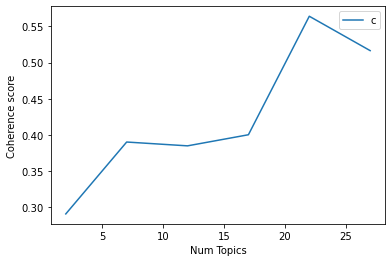

In [109]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [110]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  22

index: 0 | Num Topics = 2  has Coherence Value of 0.291
index: 1 | Num Topics = 7  has Coherence Value of 0.3903
index: 2 | Num Topics = 12  has Coherence Value of 0.385
index: 3 | Num Topics = 17  has Coherence Value of 0.4004
index: 4 | Num Topics = 22  has Coherence Value of 0.564
index: 5 | Num Topics = 27  has Coherence Value of 0.5165


In [202]:
# Select optimal number of topics
optimal_model_ph_score4 = model_list_ph_score4[4]

In [203]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score4 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score4, corpus_ph_score4, id2word_ph_score4)

In [204]:
print("pyLDAVis for ph topics for score=4:")
vis_ph_score4

pyLDAVis for ph topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.019375 -0.019699       1        1  16.225267
0     -0.140124  0.125734       2        1   8.357865
6      0.021540  0.152780       3        1   7.813297
16    -0.123122 -0.000004       4        1   6.128644
14    -0.079373 -0.011654       5        1   5.900225
4      0.002572  0.090923       6        1   5.548174
5     -0.042405  0.011784       7        1   5.435583
10    -0.061492 -0.051567       8        1   5.008260
18    -0.079190 -0.163940       9        1   4.594731
21     0.133056  0.045614      10        1   4.557646
13    -0.068412 -0.082232      11        1   3.886867
8      0.127503 -0.048250      12        1   3.877467
19     0.009248  0.005083      13        1   3.755622
12    -0.092419  0.050073      14        1   3.717589
20     0.005713 -0.021905      15        1   3.482828
11     0.054850 -0.073605      16        1   2.898891
15     0.055259  0.114273      17        1   2.569917
1      0.076611  0.018073      18        1   2.349201
17     0.035195 -0.038315      19        1   1.783872
9      0.062320 -0.046338      20        1   1.447116
7      0.041647 -0.028414      21        1   0.330469
3      0.041647 -0.028414      22        1   0.330469, topic_info=         Term       Freq      Total Category  logprob  loglift
12   snapchat  25.000000  25.000000  Default  30.0000  30.0000
60      video   9.000000   9.000000  Default  29.0000  29.0000
51        fix  14.000000  14.000000  Default  28.0000  28.0000
68       love  13.000000  13.000000  Default  27.0000  27.0000
59       time  12.000000  12.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
232      alot   0.008478   1.996056  Topic22  -5.8636   0.2509
310      blue   0.008478   1.385365  Topic22  -5.8636   0.6161
0      choose   0.008478   2.071959  Topic22  -5.8636   0.2136
1       emoji   0.008478   1.988744  Topic22  -5.8636   0.2546
2      emojis   0.008478   1.319592  Topic22  -5.8636   0.6648

[938 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
284       1  0.631191    account
284       2  0.157798    account
284      12  0.157798    account
19        5  0.708430   actually
117       1  0.282866        add
...     ...       ...        ...
198       1  0.456099      wrong
198      14  0.456099      wrong
184       9  0.732173         xr
351      12  0.732597       year
319      10  0.721832  yesterday

[665 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 7, 17, 15, 5, 6, 11, 19, 22, 14, 9, 20, 13, 21, 12, 16, 2, 18, 10, 8, 4])

## LDA Topic Modelling (Rating = 5)

In [114]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_ph_score5 = snapchat_ios_ph_review_YearMonth_score5.review.values.tolist()
review_words_ph_score5 = list(sent_to_words(review_ph_score5))
print(review_words_ph_score5[:1])

[['forgot', 'how', 'to', 'read', 'bye']]


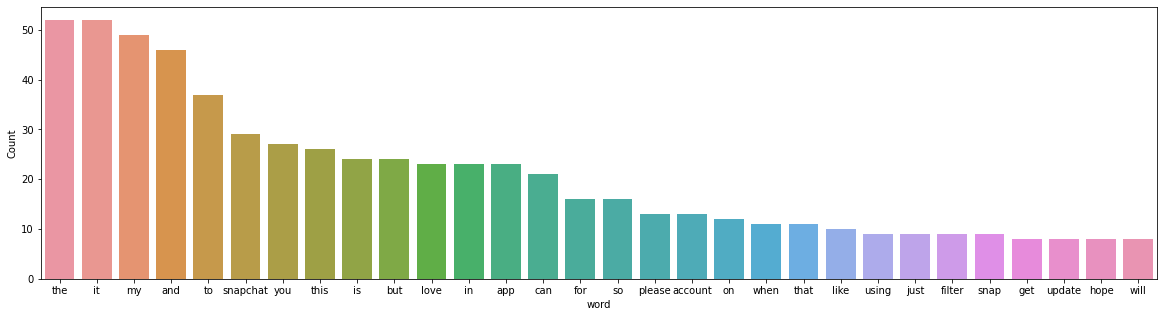

In [115]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score5))

In [116]:
# Clean text
review_ph_ready_score5 = process_words(review_words_ph_score5)  # processed Text Data! - move to each section

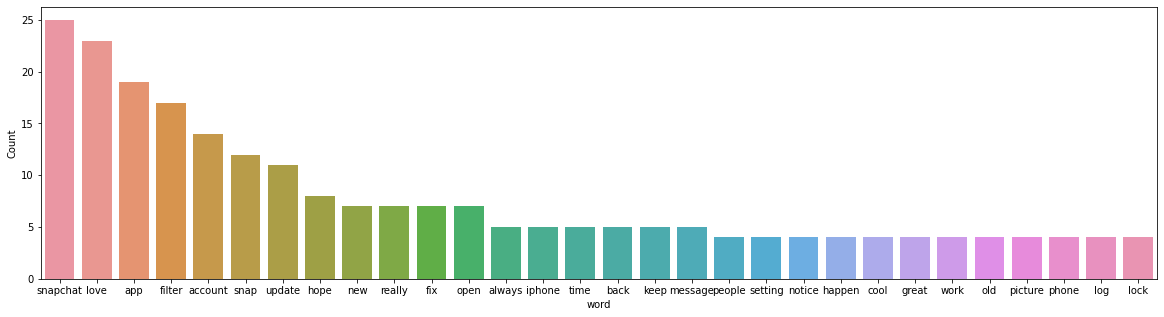

In [117]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score5))


In [118]:
# Create Dictionary
id2word_ph_score5 = corpora.Dictionary(review_ph_ready_score5)

2021-10-16 20:50:16,873 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:50:16,880 [INFO] gensim.corpora.dictionary - built Dictionary(311 unique tokens: ['read', 'medium', 'new', 'really', 'separate']...) from 79 documents (total 595 corpus positions)
2021-10-16 20:50:16,881 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(311 unique tokens: ['read', 'medium', 'new', 'really', 'separate']...) from 79 documents (total 595 corpus positions)", 'datetime': '2021-10-16T20:50:16.881916', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [119]:
# Create Corpus: Term Document Frequency
corpus_ph_score5 = [id2word_ph_score5.doc2bow(text) for text in review_ph_ready_score5]

In [120]:
# Training LDA model
model_list_ph_score5, coherence_values_ph_score5 = compute_coherence_values(dictionary=id2word_ph_score5, corpus=corpus_ph_score5, 
                                                              texts=review_ph_ready_score5, limit=30, start=2, step=5)


2021-10-16 20:50:16,906 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:50:16,909 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:50:16,911 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:50:16,915 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 79 documents, updating model once every 79 documents, evaluating perplexity every 79 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:50:17,392 [INFO] gensim.models.ldamodel - -6.533 per-word bound, 92.6 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:17,405 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #79/79
2021-10-16 20:50:17,823 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"app" + 0.035*"snapchat" + 0.024*"love" + 0.022*"filter" + 0.017*"update" + 0.014*"really" + 0.011*"time" 

2021-10-16 20:50:20,363 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"account" + 0.029*"love" + 0.027*"snap" + 0.023*"snapchat" + 0.015*"hope" + 0.013*"filter" + 0.012*"message" + 0.010*"back" + 0.010*"fix" + 0.010*"lock"
2021-10-16 20:50:20,366 [INFO] gensim.models.ldamodel - topic diff=0.005672, rho=0.301511
2021-10-16 20:50:20,537 [INFO] gensim.models.ldamodel - -5.808 per-word bound, 56.0 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:20,540 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #79/79
2021-10-16 20:50:20,589 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.039*"app" + 0.034*"snapchat" + 0.027*"filter" + 0.024*"love" + 0.019*"update" + 0.017*"really" + 0.012*"time" + 0.012*"iphone" + 0.012*"new" + 0.010*"great"
2021-10-16 20:50:20,590 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"account" + 0.029*"love" + 0.027*"snap" + 0.024*"snapchat" + 0.015*"hope" + 0.013*"filter" + 0.012*"message"

2021-10-16 20:50:22,577 [INFO] gensim.models.ldamodel - topic diff=0.000937, rho=0.218218
2021-10-16 20:50:22,724 [INFO] gensim.models.ldamodel - -5.806 per-word bound, 55.9 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:22,732 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #79/79
2021-10-16 20:50:22,785 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.032*"snapchat" + 0.027*"filter" + 0.025*"love" + 0.020*"update" + 0.017*"really" + 0.012*"iphone" + 0.012*"time" + 0.012*"new" + 0.010*"great"
2021-10-16 20:50:22,786 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"account" + 0.028*"love" + 0.027*"snap" + 0.025*"snapchat" + 0.015*"hope" + 0.013*"filter" + 0.012*"message" + 0.012*"fix" + 0.010*"back" + 0.010*"lock"
2021-10-16 20:50:22,789 [INFO] gensim.models.ldamodel - topic diff=0.000826, rho=0.213201
2021-10-16 20:50:22,954 [INFO] gensim.models.ldamodel - -5.806 per-word bound, 55.9 perplexity est

2021-10-16 20:50:24,785 [INFO] gensim.models.ldamodel - -5.806 per-word bound, 55.9 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:24,787 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #79/79
2021-10-16 20:50:24,884 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.032*"snapchat" + 0.027*"filter" + 0.025*"love" + 0.020*"update" + 0.017*"really" + 0.012*"iphone" + 0.012*"time" + 0.012*"new" + 0.010*"great"
2021-10-16 20:50:24,886 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"account" + 0.028*"love" + 0.027*"snap" + 0.026*"snapchat" + 0.015*"hope" + 0.013*"filter" + 0.012*"fix" + 0.012*"message" + 0.010*"back" + 0.010*"lock"
2021-10-16 20:50:24,887 [INFO] gensim.models.ldamodel - topic diff=0.000351, rho=0.176777
2021-10-16 20:50:25,060 [INFO] gensim.models.ldamodel - -5.805 per-word bound, 55.9 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:25,062 [I

2021-10-16 20:50:27,208 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #79/79
2021-10-16 20:50:27,319 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.032*"snapchat" + 0.027*"filter" + 0.025*"love" + 0.020*"update" + 0.017*"really" + 0.012*"iphone" + 0.012*"time" + 0.012*"new" + 0.010*"great"
2021-10-16 20:50:27,320 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"account" + 0.028*"love" + 0.027*"snap" + 0.026*"snapchat" + 0.015*"hope" + 0.013*"filter" + 0.012*"fix" + 0.012*"message" + 0.010*"back" + 0.010*"lock"
2021-10-16 20:50:27,322 [INFO] gensim.models.ldamodel - topic diff=0.000200, rho=0.154303
2021-10-16 20:50:27,474 [INFO] gensim.models.ldamodel - -5.805 per-word bound, 55.9 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:27,476 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #79/79
2021-10-16 20:50:27,574 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.032*

2021-10-16 20:50:29,357 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:50:35,681 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:50:35,708 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 64 virtual documents
2021-10-16 20:50:36,084 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:50:36,086 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:50:36,089 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:50:36,091 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 79 documents, updating model once every 79 documents, evaluating perplexity every 79 documents, iterating 50x with a converg

2021-10-16 20:50:37,308 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"snapchat" + 0.029*"fix" + 0.022*"message" + 0.022*"account" + 0.015*"setting" + 0.015*"back" + 0.015*"snap" + 0.015*"notification" + 0.015*"type" + 0.015*"app"
2021-10-16 20:50:37,311 [INFO] gensim.models.ldamodel - topic diff=0.034225, rho=0.408248
2021-10-16 20:50:37,500 [INFO] gensim.models.ldamodel - -6.178 per-word bound, 72.4 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:37,504 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #79/79
2021-10-16 20:50:37,603 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.078*"app" + 0.062*"love" + 0.024*"open" + 0.024*"really" + 0.024*"time" + 0.024*"pretty" + 0.016*"lag" + 0.016*"guy" + 0.016*"keep" + 0.009*"filter"
2021-10-16 20:50:37,614 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.058*"snapchat" + 0.025*"update" + 0.020*"app" + 0.016*"keep" + 0.016*"account" + 0.016*"hope" + 0.015*"great" + 0

2021-10-16 20:50:38,590 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.022*"happen" + 0.022*"ride" + 0.022*"notice" + 0.012*"mode" + 0.012*"ipad" + 0.012*"whyy" + 0.012*"pit" + 0.012*"conformation" + 0.012*"code" + 0.012*"iphone"
2021-10-16 20:50:38,593 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"love" + 0.028*"snapchat" + 0.028*"account" + 0.028*"snap" + 0.019*"lock" + 0.019*"wish" + 0.019*"unlock" + 0.019*"open" + 0.019*"thing" + 0.019*"new"
2021-10-16 20:50:38,595 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.110*"filter" + 0.051*"love" + 0.033*"cool" + 0.028*"snapchat" + 0.012*"update" + 0.012*"hope" + 0.012*"app" + 0.012*"super" + 0.012*"star" + 0.012*"always"
2021-10-16 20:50:38,599 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.081*"app" + 0.065*"love" + 0.025*"open" + 0.025*"really" + 0.025*"time" + 0.025*"pretty" + 0.017*"lag" + 0.017*"guy" + 0.010*"filter" + 0.009*"update"
2021-10-16 20:50:38,600 [INFO] gensim.models.ldamodel - topic diff=0.005888

2021-10-16 20:50:39,399 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"snap" + 0.034*"account" + 0.026*"filter" + 0.026*"new" + 0.018*"love" + 0.018*"back" + 0.018*"old" + 0.018*"wonder" + 0.018*"elephant" + 0.018*"lose"
2021-10-16 20:50:39,400 [INFO] gensim.models.ldamodel - topic diff=0.002527, rho=0.242536
2021-10-16 20:50:39,577 [INFO] gensim.models.ldamodel - -6.155 per-word bound, 71.3 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:39,578 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #79/79
2021-10-16 20:50:39,610 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"snapchat" + 0.025*"update" + 0.024*"keep" + 0.020*"app" + 0.020*"account" + 0.015*"hope" + 0.015*"great" + 0.015*"picture" + 0.015*"delete" + 0.015*"iphone"
2021-10-16 20:50:39,612 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"snap" + 0.034*"account" + 0.026*"filter" + 0.026*"new" + 0.018*"love" + 0.018*"back" + 0.018*"old" + 0.0

2021-10-16 20:50:40,974 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"snapchat" + 0.025*"update" + 0.024*"keep" + 0.020*"app" + 0.020*"account" + 0.015*"hope" + 0.015*"great" + 0.015*"picture" + 0.015*"iphone" + 0.015*"delete"
2021-10-16 20:50:40,976 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.114*"filter" + 0.051*"love" + 0.032*"cool" + 0.028*"snapchat" + 0.012*"hope" + 0.012*"super" + 0.012*"star" + 0.012*"always" + 0.012*"dog" + 0.012*"heart"
2021-10-16 20:50:40,978 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.022*"happen" + 0.022*"notice" + 0.022*"ride" + 0.011*"hope" + 0.011*"restart" + 0.011*"haha" + 0.011*"update" + 0.011*"app" + 0.011*"fine" + 0.011*"year"
2021-10-16 20:50:40,979 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"snap" + 0.034*"account" + 0.026*"new" + 0.026*"filter" + 0.018*"back" + 0.018*"love" + 0.018*"old" + 0.018*"wonder" + 0.018*"elephant" + 0.018*"lose"
2021-10-16 20:50:40,981 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 20:50:42,330 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"snapchat" + 0.029*"fix" + 0.022*"message" + 0.022*"account" + 0.015*"people" + 0.015*"setting" + 0.015*"back" + 0.015*"snap" + 0.015*"notification" + 0.015*"type"
2021-10-16 20:50:42,333 [INFO] gensim.models.ldamodel - topic diff=0.000327, rho=0.188982
2021-10-16 20:50:42,431 [INFO] gensim.models.ldamodel - -6.154 per-word bound, 71.2 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:42,435 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #79/79
2021-10-16 20:50:42,583 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.083*"app" + 0.066*"love" + 0.026*"really" + 0.026*"open" + 0.026*"time" + 0.026*"pretty" + 0.017*"lag" + 0.017*"guy" + 0.010*"filter" + 0.009*"bitmoji"
2021-10-16 20:50:42,584 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"love" + 0.028*"snapchat" + 0.028*"account" + 0.028*"snap" + 0.019*"open" + 0.019*"update" + 0.019*"al

2021-10-16 20:50:43,977 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"love" + 0.028*"snapchat" + 0.028*"snap" + 0.028*"account" + 0.019*"open" + 0.019*"update" + 0.019*"always" + 0.019*"new" + 0.019*"lock" + 0.019*"unlock"
2021-10-16 20:50:43,981 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.114*"filter" + 0.051*"love" + 0.032*"cool" + 0.028*"snapchat" + 0.012*"hope" + 0.012*"star" + 0.012*"super" + 0.012*"always" + 0.012*"dog" + 0.012*"heart"
2021-10-16 20:50:43,982 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"snapchat" + 0.024*"update" + 0.024*"keep" + 0.020*"app" + 0.020*"account" + 0.015*"hope" + 0.015*"great" + 0.015*"iphone" + 0.015*"delete" + 0.015*"picture"
2021-10-16 20:50:43,985 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.083*"app" + 0.066*"love" + 0.026*"really" + 0.026*"open" + 0.026*"time" + 0.026*"pretty" + 0.018*"lag" + 0.017*"guy" + 0.010*"filter" + 0.009*"bitmoji"
2021-10-16 20:50:43,987 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 20:50:45,357 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.083*"app" + 0.066*"love" + 0.026*"really" + 0.026*"open" + 0.026*"time" + 0.026*"pretty" + 0.018*"lag" + 0.017*"guy" + 0.010*"filter" + 0.009*"bitmoji"
2021-10-16 20:50:45,359 [INFO] gensim.models.ldamodel - topic diff=0.000038, rho=0.160128
2021-10-16 20:50:45,506 [INFO] gensim.models.ldamodel - -6.154 per-word bound, 71.2 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:45,521 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #79/79
2021-10-16 20:50:45,566 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.114*"filter" + 0.051*"love" + 0.032*"cool" + 0.028*"snapchat" + 0.012*"hope" + 0.012*"star" + 0.012*"super" + 0.012*"always" + 0.012*"dog" + 0.012*"fave"
2021-10-16 20:50:45,645 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"snapchat" + 0.024*"update" + 0.024*"keep" + 0.020*"app" + 0.020*"account" + 0.015*"hope" + 0.015*"great" + 0.015*"i

2021-10-16 20:50:46,748 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"snap" + 0.034*"account" + 0.026*"new" + 0.026*"filter" + 0.018*"back" + 0.018*"love" + 0.018*"old" + 0.018*"wonder" + 0.018*"elephant" + 0.018*"lose"
2021-10-16 20:50:46,749 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.114*"filter" + 0.051*"love" + 0.032*"cool" + 0.028*"snapchat" + 0.012*"hope" + 0.012*"star" + 0.012*"super" + 0.012*"always" + 0.012*"dog" + 0.012*"fave"
2021-10-16 20:50:46,752 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"snapchat" + 0.024*"update" + 0.024*"keep" + 0.020*"app" + 0.020*"account" + 0.015*"hope" + 0.015*"great" + 0.015*"iphone" + 0.015*"delete" + 0.015*"picture"
2021-10-16 20:50:46,754 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"love" + 0.028*"snapchat" + 0.028*"snap" + 0.028*"account" + 0.019*"open" + 0.019*"update" + 0.019*"always" + 0.019*"new" + 0.019*"lock" + 0.019*"unlock"
2021-10-16 20:50:46,761 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 20:50:47,832 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.083*"app" + 0.066*"love" + 0.026*"really" + 0.026*"open" + 0.026*"time" + 0.026*"pretty" + 0.018*"lag" + 0.017*"guy" + 0.010*"filter" + 0.009*"bitmoji"
2021-10-16 20:50:47,835 [INFO] gensim.models.ldamodel - topic diff=0.000006, rho=0.141421
2021-10-16 20:50:47,892 [INFO] gensim.models.ldamodel - -6.154 per-word bound, 71.2 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:47,895 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #79/79
2021-10-16 20:50:47,934 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.114*"filter" + 0.051*"love" + 0.032*"cool" + 0.028*"snapchat" + 0.012*"hope" + 0.012*"star" + 0.012*"super" + 0.012*"always" + 0.012*"dog" + 0.012*"fire"
2021-10-16 20:50:47,935 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"snapchat" + 0.024*"update" + 0.024*"keep" + 0.020*"app" + 0.020*"account" + 0.015*"hope" + 0.015*"great" + 0.015*"i

2021-10-16 20:50:57,236 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.089*"snapchat" + 0.037*"account" + 0.037*"back" + 0.020*"fix" + 0.020*"app" + 0.019*"thankful" + 0.019*"team" + 0.019*"wrong" + 0.019*"possible" + 0.019*"condition"
2021-10-16 20:50:57,238 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.041*"update" + 0.041*"picture" + 0.041*"delete" + 0.041*"old" + 0.024*"love" + 0.021*"coz" + 0.021*"whenever" + 0.021*"section" + 0.021*"keep" + 0.021*"roll"
2021-10-16 20:50:57,241 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.037*"snapchat" + 0.035*"filter" + 0.032*"account" + 0.030*"love" + 0.024*"fix" + 0.018*"message" + 0.018*"notice" + 0.017*"lock" + 0.017*"unlock" + 0.016*"snap"
2021-10-16 20:50:57,243 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.049*"snapchat" + 0.034*"app" + 0.034*"update" + 0.026*"new" + 0.017*"great" + 0.017*"work" + 0.017*"appearance" + 0.017*"story" + 0.017*"light" + 0.017*"blue"
2021-10-16 20:50:57,244 [INFO] gensim.models.ldamode

2021-10-16 20:50:58,106 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.092*"snapchat" + 0.038*"account" + 0.038*"back" + 0.020*"fix" + 0.020*"app" + 0.020*"lock" + 0.020*"thankful" + 0.020*"team" + 0.020*"wrong" + 0.020*"possible"
2021-10-16 20:50:58,107 [INFO] gensim.models.ldamodel - topic diff=0.008269, rho=0.316228
2021-10-16 20:50:58,205 [INFO] gensim.models.ldamodel - -6.305 per-word bound, 79.1 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:50:58,211 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #79/79
2021-10-16 20:50:58,244 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.098*"app" + 0.043*"love" + 0.040*"open" + 0.030*"time" + 0.030*"pretty" + 0.030*"really" + 0.020*"phone" + 0.020*"lag" + 0.020*"error" + 0.020*"show"
2021-10-16 20:50:58,245 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.092*"snapchat" + 0.038*"account" + 0.038*"back" + 0.020*"fix" + 0.020*"app" + 0.020*"lock" + 0.020*"thankful" + 0.020

2021-10-16 20:50:59,199 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.024*"theme" + 0.024*"hope" + 0.024*"fitting" + 0.024*"galaxy" + 0.024*"small" + 0.024*"suggestion" + 0.024*"tauru" + 0.024*"banner" + 0.024*"people" + 0.024*"accept"
2021-10-16 20:50:59,210 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"hope" + 0.030*"change" + 0.030*"setting" + 0.030*"stay" + 0.030*"message" + 0.030*"wil" + 0.030*"select" + 0.030*"chat" + 0.030*"forever" + 0.030*"delete"
2021-10-16 20:50:59,212 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.041*"update" + 0.041*"picture" + 0.041*"delete" + 0.041*"old" + 0.021*"love" + 0.021*"super" + 0.021*"keep" + 0.021*"new" + 0.021*"look" + 0.021*"crash"
2021-10-16 20:50:59,217 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.045*"snap" + 0.031*"always" + 0.031*"update" + 0.031*"thing" + 0.031*"wish" + 0.016*"love" + 0.016*"hope" + 0.016*"friend" + 0.016*"happen" + 0.016*"open"
2021-10-16 20:50:59,218 [INFO] gensim.models.ldamodel - topic

2021-10-16 20:51:00,049 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.049*"snapchat" + 0.034*"app" + 0.034*"update" + 0.026*"new" + 0.018*"work" + 0.018*"great" + 0.018*"fix" + 0.018*"light" + 0.018*"appearance" + 0.018*"dark"
2021-10-16 20:51:00,052 [INFO] gensim.models.ldamodel - topic diff=0.000701, rho=0.218218
2021-10-16 20:51:00,186 [INFO] gensim.models.ldamodel - -6.301 per-word bound, 78.9 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:00,192 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #79/79
2021-10-16 20:51:00,243 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.099*"app" + 0.043*"love" + 0.040*"open" + 0.030*"time" + 0.030*"pretty" + 0.030*"really" + 0.020*"phone" + 0.020*"lag" + 0.020*"error" + 0.020*"show"
2021-10-16 20:51:00,246 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.093*"snapchat" + 0.038*"account" + 0.038*"back" + 0.020*"fix" + 0.020*"app" + 0.020*"lock" + 0.020*"wrong" + 0.020*"pos

2021-10-16 20:51:01,075 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"snapchat" + 0.035*"filter" + 0.035*"account" + 0.029*"love" + 0.023*"fix" + 0.018*"message" + 0.018*"notice" + 0.018*"lock" + 0.018*"unlock" + 0.018*"snap"
2021-10-16 20:51:01,077 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.093*"snapchat" + 0.038*"account" + 0.038*"back" + 0.020*"fix" + 0.020*"app" + 0.020*"lock" + 0.020*"possible" + 0.020*"team" + 0.020*"wrong" + 0.020*"term"
2021-10-16 20:51:01,079 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.041*"update" + 0.041*"picture" + 0.041*"delete" + 0.041*"old" + 0.021*"love" + 0.021*"super" + 0.021*"keep" + 0.021*"new" + 0.021*"look" + 0.021*"crash"
2021-10-16 20:51:01,083 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.099*"app" + 0.043*"love" + 0.040*"open" + 0.030*"time" + 0.030*"pretty" + 0.030*"really" + 0.020*"phone" + 0.020*"lag" + 0.020*"error" + 0.020*"show"
2021-10-16 20:51:01,084 [INFO] gensim.models.ldamodel - topic diff=0.000206

2021-10-16 20:51:01,870 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.041*"update" + 0.041*"picture" + 0.041*"delete" + 0.041*"old" + 0.021*"love" + 0.021*"super" + 0.021*"keep" + 0.021*"new" + 0.021*"look" + 0.021*"crash"
2021-10-16 20:51:01,873 [INFO] gensim.models.ldamodel - topic diff=0.000074, rho=0.176777
2021-10-16 20:51:02,009 [INFO] gensim.models.ldamodel - -6.301 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:02,021 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #79/79
2021-10-16 20:51:02,089 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.041*"update" + 0.041*"picture" + 0.041*"delete" + 0.041*"old" + 0.021*"love" + 0.021*"super" + 0.021*"keep" + 0.021*"new" + 0.021*"look" + 0.021*"crash"
2021-10-16 20:51:02,090 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.049*"snapchat" + 0.034*"app" + 0.034*"update" + 0.026*"new" + 0.018*"work" + 0.018*"great" + 0.018*"fix" + 0.018*"light"

2021-10-16 20:51:02,811 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.093*"snapchat" + 0.038*"account" + 0.038*"back" + 0.020*"lock" + 0.020*"possible" + 0.020*"condition" + 0.020*"security" + 0.020*"term" + 0.020*"team" + 0.020*"soon"
2021-10-16 20:51:02,812 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.099*"app" + 0.043*"love" + 0.040*"open" + 0.030*"time" + 0.030*"pretty" + 0.030*"really" + 0.020*"phone" + 0.020*"lag" + 0.020*"error" + 0.020*"show"
2021-10-16 20:51:02,814 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.041*"update" + 0.041*"picture" + 0.041*"delete" + 0.041*"old" + 0.021*"love" + 0.021*"super" + 0.021*"keep" + 0.021*"new" + 0.021*"look" + 0.021*"crash"
2021-10-16 20:51:02,817 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.024*"hope" + 0.024*"theme" + 0.024*"banner" + 0.024*"fitting" + 0.024*"galaxy" + 0.024*"small" + 0.024*"tauru" + 0.024*"suggestion" + 0.024*"people" + 0.024*"accept"
2021-10-16 20:51:02,818 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:51:03,794 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"hope" + 0.030*"change" + 0.030*"setting" + 0.030*"stay" + 0.030*"message" + 0.030*"wil" + 0.030*"select" + 0.030*"forever" + 0.030*"chat" + 0.030*"delete"
2021-10-16 20:51:03,795 [INFO] gensim.models.ldamodel - topic diff=0.000009, rho=0.152499
2021-10-16 20:51:03,894 [INFO] gensim.models.ldamodel - -6.301 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:03,906 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #79/79
2021-10-16 20:51:03,966 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.098*"filter" + 0.051*"snapchat" + 0.034*"cool" + 0.034*"elephant" + 0.018*"create" + 0.018*"dog" + 0.018*"star" + 0.018*"especially" + 0.018*"animal" + 0.018*"cutesttttt"
2021-10-16 20:51:03,967 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.093*"snapchat" + 0.038*"account" + 0.038*"back" + 0.020*"lock" + 0.020*"possible" + 0.020*"cond

2021-10-16 20:51:04,704 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.129*"love" + 0.028*"filter" + 0.028*"snapchat" + 0.028*"sense" + 0.028*"non" + 0.028*"cool" + 0.014*"bug" + 0.014*"people" + 0.014*"bad" + 0.014*"talk"
2021-10-16 20:51:04,706 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.024*"hope" + 0.024*"theme" + 0.024*"banner" + 0.024*"fitting" + 0.024*"galaxy" + 0.024*"small" + 0.024*"tauru" + 0.024*"suggestion" + 0.024*"people" + 0.024*"accept"
2021-10-16 20:51:04,709 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"snapchat" + 0.035*"filter" + 0.035*"account" + 0.029*"love" + 0.023*"fix" + 0.018*"message" + 0.018*"notice" + 0.018*"unlock" + 0.018*"lock" + 0.018*"snap"
2021-10-16 20:51:04,711 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.041*"update" + 0.041*"picture" + 0.041*"delete" + 0.041*"old" + 0.021*"love" + 0.021*"super" + 0.021*"keep" + 0.021*"new" + 0.021*"look" + 0.021*"crash"
2021-10-16 20:51:04,715 [INFO] gensim.models.ldamodel - topic 

2021-10-16 20:51:14,210 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.063*"blue" + 0.063*"location" + 0.032*"setting" + 0.032*"appearance" + 0.032*"color" + 0.032*"update" + 0.032*"switch" + 0.032*"theme" + 0.032*"dark" + 0.032*"light"
2021-10-16 20:51:14,211 [INFO] gensim.models.ldamodel - topic diff=0.131362, rho=0.577350
2021-10-16 20:51:14,258 [INFO] gensim.models.ldamodel - -6.498 per-word bound, 90.4 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:14,259 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #79/79
2021-10-16 20:51:14,333 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.066*"ride" + 0.059*"haha" + 0.034*"fish" + 0.034*"hold" + 0.034*"eye" + 0.034*"dog" + 0.034*"erie" + 0.034*"sis" + 0.034*"chad" + 0.034*"true"
2021-10-16 20:51:14,335 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.157*"app" + 0.141*"love" + 0.017*"dark" + 0.017*"light" + 0.017*"update" + 0.017*"thumb" + 0.017*"fix" + 0.017*"app

2021-10-16 20:51:15,142 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.066*"ride" + 0.065*"haha" + 0.034*"fish" + 0.034*"eye" + 0.034*"hold" + 0.034*"dog" + 0.034*"erie" + 0.034*"chad" + 0.034*"sis" + 0.034*"true"
2021-10-16 20:51:15,144 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.107*"snap" + 0.090*"account" + 0.025*"𝚃𝙷𝙸𝚂" + 0.025*"𝙵𝙸𝚁" + 0.025*"𝙼𝙰𝙺𝙸𝙽𝙶" + 0.025*"mag" + 0.025*"open" + 0.024*"gimme" + 0.024*"put" + 0.024*"instal"
2021-10-16 20:51:15,146 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.058*"wish" + 0.030*"landscape" + 0.030*"filter" + 0.030*"shoot" + 0.030*"video" + 0.030*"straight" + 0.030*"baby" + 0.030*"thing" + 0.030*"minute" + 0.030*"never"
2021-10-16 20:51:15,147 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.064*"old" + 0.063*"new" + 0.050*"update" + 0.049*"picture" + 0.033*"delete" + 0.033*"open" + 0.033*"love" + 0.017*"people" + 0.017*"roll" + 0.017*"whenever"
2021-10-16 20:51:15,148 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.055*"

2021-10-16 20:51:16,077 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.078*"filter" + 0.073*"love" + 0.039*"snapchat" + 0.026*"elephant" + 0.026*"cool" + 0.026*"sense" + 0.026*"non" + 0.026*"dog" + 0.014*"totally" + 0.014*"wonder"
2021-10-16 20:51:16,078 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.067*"old" + 0.067*"new" + 0.051*"update" + 0.050*"picture" + 0.034*"delete" + 0.034*"open" + 0.034*"love" + 0.018*"people" + 0.017*"roll" + 0.017*"whenever"
2021-10-16 20:51:16,079 [INFO] gensim.models.ldamodel - topic diff=0.006516, rho=0.267261
2021-10-16 20:51:16,114 [INFO] gensim.models.ldamodel - -6.320 per-word bound, 79.9 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:16,116 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #79/79
2021-10-16 20:51:16,148 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.039*"notice" + 0.039*"happen" + 0.020*"seldom" + 0.020*"bug" + 0.020*"year" + 0.020*"device" + 0.020*"major" 

2021-10-16 20:51:17,025 [INFO] gensim.models.ldamodel - -6.319 per-word bound, 79.8 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:17,035 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #79/79
2021-10-16 20:51:17,100 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.049*"snapchat" + 0.037*"keep" + 0.037*"fix" + 0.037*"message" + 0.025*"error" + 0.025*"connection" + 0.025*"stop" + 0.025*"snap" + 0.025*"notification" + 0.025*"setting"
2021-10-16 20:51:17,103 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.097*"snapchat" + 0.058*"back" + 0.039*"account" + 0.020*"fix" + 0.020*"lock" + 0.020*"security" + 0.020*"soon" + 0.020*"team" + 0.020*"term" + 0.020*"condition"
2021-10-16 20:51:17,105 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.055*"iphone" + 0.028*"error" + 0.028*"snapchat" + 0.028*"login" + 0.028*"everytime" + 0.028*"connection" + 0.028*"strong" + 0.028*"show" + 0.028*"ipad" + 0.028*"pit"
2021-10-16 20:51:1

2021-10-16 20:51:18,110 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.049*"snapchat" + 0.037*"keep" + 0.037*"fix" + 0.037*"message" + 0.025*"error" + 0.025*"connection" + 0.025*"stop" + 0.025*"snap" + 0.025*"notification" + 0.025*"setting"
2021-10-16 20:51:18,112 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.039*"notice" + 0.039*"happen" + 0.020*"seldom" + 0.020*"bug" + 0.020*"year" + 0.020*"device" + 0.020*"major" + 0.020*"frequent" + 0.020*"update" + 0.020*"note"
2021-10-16 20:51:18,120 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.042*"code" + 0.042*"whyy" + 0.042*"send" + 0.042*"conformation" + 0.042*"olala" + 0.042*"daming" + 0.042*"app" + 0.002*"single" + 0.002*"𝙼𝙰𝙺𝙸𝙽𝙶" + 0.002*"𝙵𝙸𝚁"
2021-10-16 20:51:18,122 [INFO] gensim.models.ldamodel - topic diff=0.000425, rho=0.200000
2021-10-16 20:51:18,171 [INFO] gensim.models.ldamodel - -6.319 per-word bound, 79.8 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:18,173 [INFO]

2021-10-16 20:51:19,265 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.058*"wish" + 0.030*"landscape" + 0.030*"filter" + 0.030*"video" + 0.030*"shoot" + 0.030*"minute" + 0.030*"straight" + 0.030*"baby" + 0.030*"thing" + 0.030*"incredible"
2021-10-16 20:51:19,267 [INFO] gensim.models.ldamodel - topic diff=0.000138, rho=0.182574
2021-10-16 20:51:19,360 [INFO] gensim.models.ldamodel - -6.319 per-word bound, 79.8 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:19,361 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #79/79
2021-10-16 20:51:19,463 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.058*"filter" + 0.046*"snapchat" + 0.044*"pretty" + 0.030*"app" + 0.030*"guy" + 0.030*"love" + 0.030*"iphone" + 0.015*"phone" + 0.015*"download" + 0.015*"watch"
2021-10-16 20:51:19,467 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.067*"old" + 0.067*"new" + 0.051*"update" + 0.051*"picture" + 0.034*"delete" + 0.034*"open" + 0.034

2021-10-16 20:51:20,607 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.064*"blue" + 0.064*"location" + 0.033*"update" + 0.033*"appearance" + 0.033*"color" + 0.033*"theme" + 0.033*"light" + 0.033*"dark" + 0.033*"setting" + 0.033*"switch"
2021-10-16 20:51:20,609 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.042*"code" + 0.042*"whyy" + 0.042*"send" + 0.042*"conformation" + 0.042*"olala" + 0.042*"daming" + 0.042*"app" + 0.002*"single" + 0.002*"𝙼𝙰𝙺𝙸𝙽𝙶" + 0.002*"𝙵𝙸𝚁"
2021-10-16 20:51:20,613 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.061*"account" + 0.060*"snapchat" + 0.053*"filter" + 0.035*"hope" + 0.027*"lock" + 0.027*"unlock" + 0.018*"email" + 0.018*"log" + 0.018*"cool" + 0.018*"unlocked"
2021-10-16 20:51:20,615 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.054*"lag" + 0.054*"love" + 0.054*"always" + 0.054*"snap" + 0.037*"time" + 0.037*"open" + 0.019*"happen" + 0.019*"notice" + 0.019*"fine" + 0.019*"app"
2021-10-16 20:51:20,616 [INFO] gensim.models.ldamodel - t

2021-10-16 20:51:21,816 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.078*"filter" + 0.074*"love" + 0.039*"snapchat" + 0.026*"elephant" + 0.026*"cool" + 0.026*"sense" + 0.026*"non" + 0.026*"dog" + 0.014*"totally" + 0.014*"create"
2021-10-16 20:51:21,818 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.114*"snap" + 0.092*"account" + 0.024*"𝚃𝙷𝙸𝚂" + 0.024*"𝙵𝙸𝚁" + 0.024*"𝙼𝙰𝙺𝙸𝙽𝙶" + 0.024*"mag" + 0.024*"open" + 0.024*"gimme" + 0.024*"put" + 0.024*"instal"
2021-10-16 20:51:21,819 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.058*"wish" + 0.030*"landscape" + 0.030*"filter" + 0.030*"video" + 0.030*"shoot" + 0.030*"minute" + 0.030*"straight" + 0.030*"baby" + 0.030*"thing" + 0.030*"incredible"
2021-10-16 20:51:21,820 [INFO] gensim.models.ldamodel - topic diff=0.000394, rho=0.156174
2021-10-16 20:51:22,051 [INFO] gensim.models.ldamodel - -6.311 per-word bound, 79.4 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:22,052 [INFO] gensim.mod

2021-10-16 20:51:23,423 [INFO] gensim.models.ldamodel - topic diff=0.000327, rho=0.147442
2021-10-16 20:51:23,507 [INFO] gensim.models.ldamodel - -6.310 per-word bound, 79.4 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:23,509 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #79/79
2021-10-16 20:51:23,604 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.064*"blue" + 0.064*"location" + 0.033*"update" + 0.033*"appearance" + 0.033*"color" + 0.033*"theme" + 0.033*"light" + 0.033*"dark" + 0.033*"setting" + 0.033*"switch"
2021-10-16 20:51:23,609 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.058*"snapchat" + 0.046*"fix" + 0.035*"keep" + 0.035*"message" + 0.024*"error" + 0.024*"connection" + 0.024*"stop" + 0.024*"notification" + 0.024*"snap" + 0.024*"setting"
2021-10-16 20:51:23,611 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.055*"iphone" + 0.028*"error" + 0.028*"strong" + 0.028*"login" + 0.028*"everytime" + 0.02

2021-10-16 20:51:30,712 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:51:30,777 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 76 virtual documents
2021-10-16 20:51:37,077 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 20:51:37,081 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 20:51:37,103 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:51:37,108 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 79 documents, updating model once every 79 documents, evaluating perplexity every 79 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:51:37,285 [INFO] gensim.models.ldamodel - -26.675 per-word bound, 107145680.0 perplexity estimate based on a held-out corpus of 79 documents with 595 

2021-10-16 20:51:38,016 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.033*"message" + 0.033*"change" + 0.033*"unit" + 0.033*"forever" + 0.033*"filter" + 0.033*"select" + 0.033*"delete" + 0.033*"hope" + 0.033*"stay" + 0.033*"version"
2021-10-16 20:51:38,020 [INFO] gensim.models.ldamodel - topic diff=0.036374, rho=0.408248
2021-10-16 20:51:38,111 [INFO] gensim.models.ldamodel - -6.488 per-word bound, 89.8 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:38,116 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #79/79
2021-10-16 20:51:38,143 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.143*"filter" + 0.074*"love" + 0.043*"snapchat" + 0.028*"keep" + 0.028*"always" + 0.028*"fire" + 0.028*"super" + 0.028*"heart" + 0.028*"perfectly" + 0.028*"fave"
2021-10-16 20:51:38,145 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.063*"open" + 0.062*"pretty" + 0.043*"app" + 0.043*"keep" + 0.043*"guy" + 0.043*"phone" + 0.022*"restar

2021-10-16 20:51:38,991 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.080*"work" + 0.054*"story" + 0.029*"app" + 0.027*"always" + 0.027*"update" + 0.027*"friend" + 0.027*"cellphone" + 0.027*"great" + 0.027*"first" + 0.027*"load"
2021-10-16 20:51:38,993 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.151*"filter" + 0.076*"love" + 0.061*"snapchat" + 0.027*"keep" + 0.027*"always" + 0.027*"fire" + 0.027*"heart" + 0.027*"super" + 0.027*"fave" + 0.027*"dog"
2021-10-16 20:51:38,995 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.055*"accept" + 0.055*"update" + 0.055*"people" + 0.055*"new" + 0.055*"hope" + 0.002*"𝙼𝙰𝙺𝙸𝙽𝙶" + 0.002*"𝚃𝙷𝙸𝚂" + 0.002*"𝙵𝙸𝚁" + 0.002*"save" + 0.002*"next"
2021-10-16 20:51:38,998 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.054*"message" + 0.037*"notification" + 0.037*"snap" + 0.037*"setting" + 0.037*"fix" + 0.030*"snapchat" + 0.019*"important" + 0.019*"notice" + 0.019*"uninstall" + 0.019*"send"
2021-10-16 20:51:39,001 [INFO] gensim.models.ldamode

2021-10-16 20:51:39,700 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.102*"love" + 0.052*"internet" + 0.052*"snow" + 0.052*"cool" + 0.052*"snap" + 0.002*"instagram" + 0.002*"𝚃𝙷𝙸𝚂" + 0.002*"next" + 0.002*"single" + 0.002*"klzrnld"
2021-10-16 20:51:39,704 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.127*"love" + 0.112*"app" + 0.043*"update" + 0.029*"picture" + 0.029*"old" + 0.029*"delete" + 0.015*"bug" + 0.015*"dark" + 0.015*"reset" + 0.015*"light"
2021-10-16 20:51:39,705 [INFO] gensim.models.ldamodel - topic diff=0.001501, rho=0.242536
2021-10-16 20:51:39,742 [INFO] gensim.models.ldamodel - -6.466 per-word bound, 88.4 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:39,743 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #79/79
2021-10-16 20:51:39,834 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.045*"ride" + 0.045*"haha" + 0.045*"love" + 0.023*"app" + 0.023*"sis" + 0.023*"eye" + 0.023*"msg" + 0.023*"erie" 

2021-10-16 20:51:40,515 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #79/79
2021-10-16 20:51:40,544 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.080*"work" + 0.054*"story" + 0.029*"app" + 0.027*"always" + 0.027*"update" + 0.027*"friend" + 0.027*"cellphone" + 0.027*"great" + 0.027*"first" + 0.027*"load"
2021-10-16 20:51:40,547 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.003*"single" + 0.003*"toc" + 0.003*"instagram" + 0.003*"tiktok" + 0.003*"klzrnld" + 0.003*"𝚃𝙷𝙸𝚂" + 0.003*"𝙼𝙰𝙺𝙸𝙽𝙶" + 0.003*"𝙵𝙸𝚁" + 0.003*"save" + 0.003*"trend"
2021-10-16 20:51:40,550 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.045*"ride" + 0.045*"haha" + 0.045*"love" + 0.023*"app" + 0.023*"sis" + 0.023*"true" + 0.023*"msg" + 0.023*"erie" + 0.023*"fish" + 0.023*"hold"
2021-10-16 20:51:40,553 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.034*"hope" + 0.034*"delete" + 0.034*"wil" + 0.034*"change" + 0.034*"stay" + 0.034*"select" + 0.034*"forever" + 0.034*"chat" + 0.034*"setting

2021-10-16 20:51:41,432 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.073*"elephant" + 0.073*"filter" + 0.037*"especially" + 0.037*"dog" + 0.037*"animal" + 0.037*"create" + 0.037*"cutesttttt" + 0.037*"love" + 0.037*"totally" + 0.037*"wonder"
2021-10-16 20:51:41,434 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.034*"hope" + 0.034*"delete" + 0.034*"wil" + 0.034*"change" + 0.034*"stay" + 0.034*"select" + 0.034*"forever" + 0.034*"chat" + 0.034*"setting" + 0.034*"message"
2021-10-16 20:51:41,437 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.150*"filter" + 0.077*"snapchat" + 0.076*"love" + 0.026*"keep" + 0.026*"dog" + 0.026*"fave" + 0.026*"heart" + 0.026*"always" + 0.026*"fire" + 0.026*"super"
2021-10-16 20:51:41,439 [INFO] gensim.models.ldamodel - topic diff=0.000195, rho=0.188982
2021-10-16 20:51:41,499 [INFO] gensim.models.ldamodel - -6.466 per-word bound, 88.4 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:41,501 [INFO] g

2021-10-16 20:51:42,242 [INFO] gensim.models.ldamodel - topic diff=0.000066, rho=0.174078
2021-10-16 20:51:42,342 [INFO] gensim.models.ldamodel - -6.468 per-word bound, 88.5 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:42,346 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #79/79
2021-10-16 20:51:42,430 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.033*"new" + 0.033*"update" + 0.033*"hope" + 0.033*"happen" + 0.033*"notice" + 0.017*"ui" + 0.017*"medium" + 0.017*"really" + 0.017*"social" + 0.017*"wanna"
2021-10-16 20:51:42,436 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.003*"single" + 0.003*"toc" + 0.003*"instagram" + 0.003*"tiktok" + 0.003*"klzrnld" + 0.003*"𝚃𝙷𝙸𝚂" + 0.003*"𝙼𝙰𝙺𝙸𝙽𝙶" + 0.003*"𝙵𝙸𝚁" + 0.003*"save" + 0.003*"trend"
2021-10-16 20:51:42,442 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.055*"message" + 0.037*"snap" + 0.037*"setting" + 0.037*"notification" + 0.037*"fix" + 0.022*"snapchat" + 0.01

2021-10-16 20:51:43,331 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.062*"snapchat" + 0.051*"filter" + 0.051*"account" + 0.031*"lock" + 0.031*"unlock" + 0.031*"cool" + 0.021*"non" + 0.021*"sense" + 0.021*"people" + 0.021*"email"
2021-10-16 20:51:43,332 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.055*"update" + 0.055*"people" + 0.055*"new" + 0.055*"accept" + 0.055*"hope" + 0.002*"𝙼𝙰𝙺𝙸𝙽𝙶" + 0.002*"𝚃𝙷𝙸𝚂" + 0.002*"𝙵𝙸𝚁" + 0.002*"save" + 0.002*"next"
2021-10-16 20:51:43,333 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.033*"new" + 0.033*"update" + 0.033*"hope" + 0.033*"happen" + 0.033*"notice" + 0.017*"wanna" + 0.017*"ui" + 0.017*"medium" + 0.017*"separate" + 0.017*"social"
2021-10-16 20:51:43,335 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.049*"fix" + 0.049*"log" + 0.049*"wish" + 0.025*"banner" + 0.025*"fitting" + 0.025*"galaxy" + 0.025*"suggestion" + 0.025*"small" + 0.025*"theme" + 0.025*"tauru"
2021-10-16 20:51:43,336 [INFO] gensim.models.ldamodel - topic d

2021-10-16 20:51:44,105 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.034*"hope" + 0.034*"delete" + 0.034*"wil" + 0.034*"change" + 0.034*"stay" + 0.034*"select" + 0.034*"forever" + 0.034*"chat" + 0.034*"setting" + 0.034*"message"
2021-10-16 20:51:44,110 [INFO] gensim.models.ldamodel - topic diff=0.000040, rho=0.150756
2021-10-16 20:51:44,183 [INFO] gensim.models.ldamodel - -6.466 per-word bound, 88.4 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:44,185 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #79/79
2021-10-16 20:51:44,231 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.083*"snapchat" + 0.044*"update" + 0.029*"account" + 0.029*"back" + 0.029*"blue" + 0.029*"hope" + 0.029*"iphone" + 0.015*"wrong" + 0.015*"term" + 0.015*"thankful"
2021-10-16 20:51:44,236 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.033*"new" + 0.033*"update" + 0.033*"notice" + 0.033*"happen" + 0.033*"hope" + 0.017*"case" + 0.017*"so

2021-10-16 20:51:45,142 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #79/79
2021-10-16 20:51:45,221 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.055*"brooo" + 0.055*"anytime" + 0.055*"enjoy" + 0.055*"keeeeep" + 0.055*"panget" + 0.002*"love" + 0.002*"𝚃𝙷𝙸𝚂" + 0.002*"instagram" + 0.002*"𝙵𝙸𝚁" + 0.002*"klzrnld"
2021-10-16 20:51:45,223 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.034*"hope" + 0.034*"delete" + 0.034*"wil" + 0.034*"change" + 0.034*"stay" + 0.034*"select" + 0.034*"forever" + 0.034*"chat" + 0.034*"setting" + 0.034*"message"
2021-10-16 20:51:45,225 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.112*"snap" + 0.090*"account" + 0.045*"new" + 0.045*"old" + 0.023*"accidently" + 0.023*"atleast" + 0.023*"picture" + 0.023*"back" + 0.023*"love" + 0.023*"lose"
2021-10-16 20:51:45,228 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.065*"zooming" + 0.065*"lag" + 0.003*"single" + 0.003*"trend" + 0.003*"tiktok" + 0.003*"klzrnld" + 0.003*"𝚃𝙷𝙸𝚂" + 0.003*

2021-10-16 20:51:59,093 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.071*"fun" + 0.071*"app" + 0.071*"interesting" + 0.003*"𝚃𝙷𝙸𝚂" + 0.003*"𝙵𝙸𝚁" + 0.003*"next" + 0.003*"instagram" + 0.003*"tiktok" + 0.003*"klzrnld" + 0.003*"non"
2021-10-16 20:51:59,095 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.003*"single" + 0.003*"toc" + 0.003*"instagram" + 0.003*"tiktok" + 0.003*"klzrnld" + 0.003*"𝚃𝙷𝙸𝚂" + 0.003*"𝙼𝙰𝙺𝙸𝙽𝙶" + 0.003*"𝙵𝙸𝚁" + 0.003*"save" + 0.003*"trend"
2021-10-16 20:51:59,096 [INFO] gensim.models.ldamodel - topic diff=0.062615, rho=0.500000
2021-10-16 20:51:59,175 [INFO] gensim.models.ldamodel - -6.590 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:51:59,179 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #79/79
2021-10-16 20:51:59,227 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.042*"message" + 0.042*"forever" + 0.042*"setting" + 0.042*"select" + 0.042*"delete" + 0.042*"hope" + 0.042*"

2021-10-16 20:52:00,049 [INFO] gensim.models.ldamodel - -6.519 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:52:00,050 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #79/79
2021-10-16 20:52:00,082 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.170*"love" + 0.069*"snapchat" + 0.035*"account" + 0.035*"unit" + 0.035*"version" + 0.035*"filter" + 0.035*"show" + 0.035*"enjoy" + 0.035*"iphone" + 0.035*"lol"
2021-10-16 20:52:00,083 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.071*"open" + 0.036*"everytime" + 0.036*"show" + 0.036*"exact" + 0.036*"login" + 0.036*"really" + 0.036*"connection" + 0.036*"time" + 0.036*"snapchat" + 0.036*"app"
2021-10-16 20:52:00,084 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.056*"let" + 0.056*"anime" + 0.056*"add" + 0.056*"streak" + 0.056*"filter" + 0.056*"back" + 0.056*"kuvgvcvvxfb" + 0.002*"ride" + 0.002*"true" + 0.002*"dog"
2021-10-16 20:52:00,172 [INFO] gens

2021-10-16 20:52:01,002 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.083*"read" + 0.003*"snapchat" + 0.003*"𝙵𝙸𝚁" + 0.003*"save" + 0.003*"next" + 0.003*"instagram" + 0.003*"tiktok" + 0.003*"klzrnld" + 0.003*"𝚃𝙷𝙸𝚂" + 0.003*"𝙼𝙰𝙺𝙸𝙽𝙶"
2021-10-16 20:52:01,003 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.069*"keep" + 0.069*"blue" + 0.035*"wifi" + 0.035*"connection" + 0.035*"log" + 0.035*"error" + 0.035*"restart" + 0.035*"phone" + 0.035*"snapchat" + 0.035*"account"
2021-10-16 20:52:01,004 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.053*"snap" + 0.053*"snapchat" + 0.035*"always" + 0.035*"hope" + 0.018*"respond" + 0.018*"idk" + 0.018*"love" + 0.018*"message" + 0.018*"friend" + 0.018*"black"
2021-10-16 20:52:01,005 [INFO] gensim.models.ldamodel - topic diff=0.002561, rho=0.258199
2021-10-16 20:52:01,052 [INFO] gensim.models.ldamodel - -6.516 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:52:01,053 [INFO] gen

2021-10-16 20:52:01,921 [INFO] gensim.models.ldamodel - topic diff=0.000583, rho=0.223607
2021-10-16 20:52:02,086 [INFO] gensim.models.ldamodel - -6.516 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:52:02,088 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #79/79
2021-10-16 20:52:02,164 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.070*"snapchat" + 0.070*"filter" + 0.047*"cool" + 0.047*"new" + 0.047*"update" + 0.024*"hope" + 0.024*"medium" + 0.024*"really" + 0.024*"ui" + 0.024*"social"
2021-10-16 20:52:02,166 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.059*"brooo" + 0.059*"anytime" + 0.059*"keeeeep" + 0.059*"enjoy" + 0.059*"haha" + 0.059*"love" + 0.002*"instagram" + 0.002*"𝚃𝙷𝙸𝚂" + 0.002*"klzrnld" + 0.002*"𝙵𝙸𝚁"
2021-10-16 20:52:02,168 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.171*"love" + 0.069*"snapchat" + 0.035*"account" + 0.035*"unit" + 0.035*"version" + 0.035*"filter" + 0.035*

2021-10-16 20:52:03,214 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.056*"sense" + 0.056*"non" + 0.056*"filter" + 0.028*"people" + 0.028*"talk" + 0.028*"bug" + 0.028*"joke" + 0.028*"cool" + 0.028*"snapchat" + 0.028*"love"
2021-10-16 20:52:03,215 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.083*"app" + 0.063*"pretty" + 0.042*"great" + 0.042*"guy" + 0.021*"dark" + 0.021*"mode" + 0.021*"stay" + 0.021*"fix" + 0.021*"appearance" + 0.021*"bug"
2021-10-16 20:52:03,216 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.052*"message" + 0.035*"snapchat" + 0.035*"stop" + 0.035*"send" + 0.035*"snap" + 0.035*"setting" + 0.035*"fix" + 0.035*"notification" + 0.018*"ex" + 0.018*"open"
2021-10-16 20:52:03,217 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.077*"update" + 0.052*"delete" + 0.052*"new" + 0.052*"old" + 0.052*"picture" + 0.052*"story" + 0.026*"pic" + 0.026*"super" + 0.026*"crash" + 0.026*"roll"
2021-10-16 20:52:03,219 [INFO] gensim.models.ldamodel - topic diff=0.000125

2021-10-16 20:52:04,139 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.071*"app" + 0.071*"fun" + 0.071*"interesting" + 0.003*"𝚃𝙷𝙸𝚂" + 0.003*"𝙵𝙸𝚁" + 0.003*"next" + 0.003*"instagram" + 0.003*"tiktok" + 0.003*"klzrnld" + 0.003*"non"
2021-10-16 20:52:04,146 [INFO] gensim.models.ldamodel - topic diff=0.000040, rho=0.179605
2021-10-16 20:52:04,247 [INFO] gensim.models.ldamodel - -6.516 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:52:04,259 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #79/79
2021-10-16 20:52:04,301 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.100*"filter" + 0.050*"love" + 0.050*"dog" + 0.050*"ride" + 0.026*"fire" + 0.026*"fave" + 0.026*"heart" + 0.026*"super" + 0.026*"always" + 0.026*"plss"
2021-10-16 20:52:04,303 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.053*"snap" + 0.053*"snapchat" + 0.035*"always" + 0.035*"hope" + 0.018*"respond" + 0.018*"black" + 0.018*"important"

2021-10-16 20:52:05,100 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #79/79
2021-10-16 20:52:05,262 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.040*"notice" + 0.040*"happen" + 0.040*"love" + 0.020*"bug" + 0.020*"case" + 0.020*"call" + 0.020*"restart" + 0.020*"crash" + 0.020*"bit" + 0.020*"app"
2021-10-16 20:52:05,270 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.052*"message" + 0.035*"snapchat" + 0.035*"stop" + 0.035*"send" + 0.035*"snap" + 0.035*"setting" + 0.035*"fix" + 0.035*"notification" + 0.018*"ex" + 0.018*"open"
2021-10-16 20:52:05,274 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.100*"filter" + 0.050*"love" + 0.050*"dog" + 0.050*"ride" + 0.026*"fire" + 0.026*"fave" + 0.026*"heart" + 0.026*"super" + 0.026*"always" + 0.026*"plss"
2021-10-16 20:52:05,277 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.044*"delete" + 0.044*"forever" + 0.044*"select" + 0.044*"stay" + 0.044*"wil" + 0.044*"message" + 0.044*"change" + 0.044*"setting" + 0.04

2021-10-16 20:52:06,372 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.125*"snapchat" + 0.107*"account" + 0.054*"lock" + 0.036*"unlock" + 0.036*"log" + 0.036*"fix" + 0.018*"wrong" + 0.018*"back" + 0.018*"security" + 0.018*"team"
2021-10-16 20:52:06,374 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.065*"love" + 0.065*"filter" + 0.065*"snapchat" + 0.065*"really" + 0.033*"app" + 0.033*"theme" + 0.033*"ka" + 0.033*"fitting" + 0.033*"galaxy" + 0.033*"tauru"
2021-10-16 20:52:06,375 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.003*"single" + 0.003*"toc" + 0.003*"instagram" + 0.003*"tiktok" + 0.003*"klzrnld" + 0.003*"𝚃𝙷𝙸𝚂" + 0.003*"𝙼𝙰𝙺𝙸𝙽𝙶" + 0.003*"𝙵𝙸𝚁" + 0.003*"save" + 0.003*"trend"
2021-10-16 20:52:06,376 [INFO] gensim.models.ldamodel - topic diff=0.000005, rho=0.154303
2021-10-16 20:52:06,415 [INFO] gensim.models.ldamodel - -6.516 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:52:06,416 [INFO] gensim.models

2021-10-16 20:52:07,493 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.145865
2021-10-16 20:52:07,552 [INFO] gensim.models.ldamodel - -6.516 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 79 documents with 595 words
2021-10-16 20:52:07,553 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #79/79
2021-10-16 20:52:07,591 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.071*"open" + 0.036*"login" + 0.036*"app" + 0.036*"show" + 0.036*"action" + 0.036*"error" + 0.036*"connection" + 0.036*"everytime" + 0.036*"exact" + 0.036*"really"
2021-10-16 20:52:07,594 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.059*"brooo" + 0.059*"anytime" + 0.059*"keeeeep" + 0.059*"enjoy" + 0.059*"haha" + 0.059*"love" + 0.002*"instagram" + 0.002*"𝚃𝙷𝙸𝚂" + 0.002*"klzrnld" + 0.002*"𝙵𝙸𝚁"
2021-10-16 20:52:07,601 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.056*"back" + 0.056*"let" + 0.056*"add" + 0.056*"filter" + 0.056*"streak" + 0.056*"anime" + 0.056*"ku

In [121]:
%store model_list_ph_score5
%store coherence_values_ph_score5

Stored 'model_list_ph_score5' (list)
Stored 'coherence_values_ph_score5' (list)


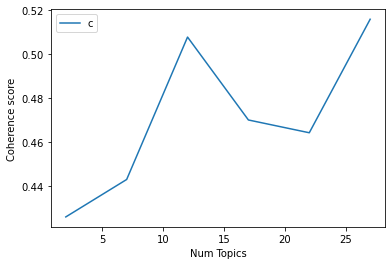

In [122]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [123]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.4261
index: 1 | Num Topics = 7  has Coherence Value of 0.4431
index: 2 | Num Topics = 12  has Coherence Value of 0.5078
index: 3 | Num Topics = 17  has Coherence Value of 0.4701
index: 4 | Num Topics = 22  has Coherence Value of 0.4643
index: 5 | Num Topics = 27  has Coherence Value of 0.5159


In [205]:
# Select optimal number of topics
optimal_model_ph_score5 = model_list_ph_score5[5]

In [206]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score5 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score5, corpus_ph_score5, id2word_ph_score5)

In [207]:
print("pyLDAVis for ph topics for score=5:")
vis_ph_score5

pyLDAVis for ph topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.032532 -0.137922       1        1  10.946359
18    -0.031347  0.145576       2        1   7.837225
10    -0.250641 -0.020961       3        1   7.286122
6     -0.067068  0.115910       4        1   7.222525
5      0.084737  0.106126       5        1   6.806595
23     0.082639  0.097945       6        1   5.919320
17     0.013904 -0.083583       7        1   5.174213
25     0.110652 -0.149108       8        1   4.810192
19     0.069701 -0.016106       9        1   4.787655
20    -0.193903 -0.011697      10        1   4.628229
2      0.036822 -0.096408      11        1   4.431308
21     0.077712  0.033733      12        1   3.710556
0      0.021687 -0.056925      13        1   3.211957
11    -0.116580  0.017716      14        1   3.114259
26    -0.038722 -0.083389      15        1   2.905235
24    -0.028093  0.049733      16        1   2.865552
7      0.059576  0.036067      17        1   2.605389
22     0.034372 -0.020901      18        1   2.555094
12     0.026032  0.047681      19        1   2.143204
13     0.044397  0.051000      20        1   1.857816
14     0.012508 -0.057737      21        1   1.231566
1      0.038292 -0.018159      22        1   1.153135
15     0.003777  0.002481      23        1   0.769382
9      0.029680  0.026913      24        1   0.769382
16     0.004920  0.011245      25        1   0.475265
8      0.003740  0.005385      26        1   0.391231
3      0.003740  0.005385      27        1   0.391231, topic_info=         Term       Freq      Total Category  logprob  loglift
27        app  12.000000  12.000000  Default  30.0000  30.0000
19       love  15.000000  15.000000  Default  29.0000  29.0000
16     filter  12.000000  12.000000  Default  28.0000  28.0000
124   account  11.000000  11.000000  Default  27.0000  27.0000
5    snapchat  18.000000  18.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
23    setting   0.007485   3.199719  Topic27  -5.7398  -0.5143
26        lol   0.007485   1.158484  Topic27  -5.7398   0.5017
27        app   0.007485  12.768499  Topic27  -5.7398  -1.8982
28        bit   0.007485   1.358991  Topic27  -5.7398   0.3420
29        bug   0.007485   2.806891  Topic27  -5.7398  -0.3833

[1225 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
191      11  0.772273        abot
10        1  0.718421      accept
229       1  0.718420  accidently
109       6  0.769949  accomplish
124       1  0.270400     account
...     ...       ...         ...
305       4  0.757570   ᵇᵉˢᵗᵗᵗᵗᵗᵗ
306       4  0.757570         ᵗʰᵉ
206       6  0.769950         𝙵𝙸𝚁
207       6  0.769950      𝙼𝙰𝙺𝙸𝙽𝙶
208       6  0.769950        𝚃𝙷𝙸𝚂

[468 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 19, 11, 7, 6, 24, 18, 26, 20, 21, 3, 22, 1, 12, 27, 25, 8, 23, 13, 14, 15, 2, 16, 10, 17, 9, 4])

## LDA Topic Modelling (Rating = 1,2,3)

In [127]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_ph_score1N2N3 = snapchat_ios_ph_review_YearMonth_score1N2N3.review.values.tolist()
review_words_ph_score1N2N3 = list(sent_to_words(review_ph_score1N2N3))
print(review_words_ph_score1N2N3[:1])

[['really', 'like', 'snapchat', 'but', 'it', 'messed', 'up', 'my', 'phone', 'everytime', 'and', 'dont', 'know', 'why', 'but', 'everytime', 'open', 'it', 'while', 'im', 'at', 'my', 'phone', 'randomly', 'shut', 'down', 'even', 'if', 'open', 'different', 'apps', 'it', 'shut', 'downs', 'randomly', 'but', 'when', 'deleted', 'it', 'everything', 'is', 'normal', 'don', 'know', 'why', 'this', 'happen']]


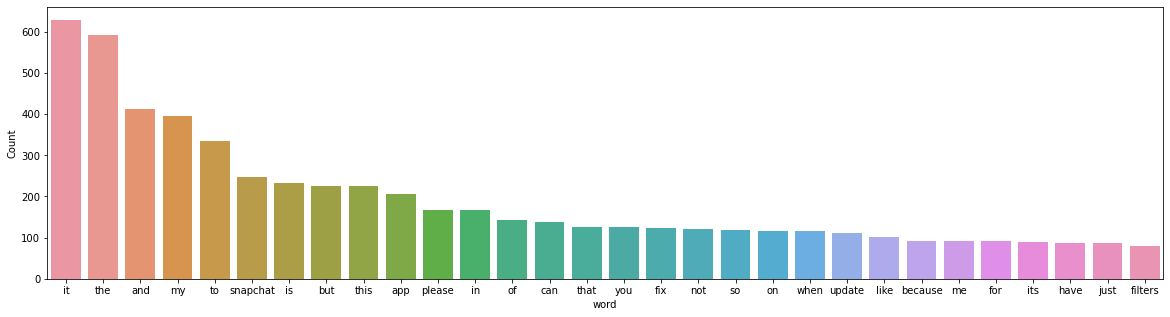

In [128]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score1N2N3))

In [129]:
# Clean text
review_ph_ready_score1N2N3 = process_words(review_words_ph_score1N2N3)  # processed Text Data! - move to each section

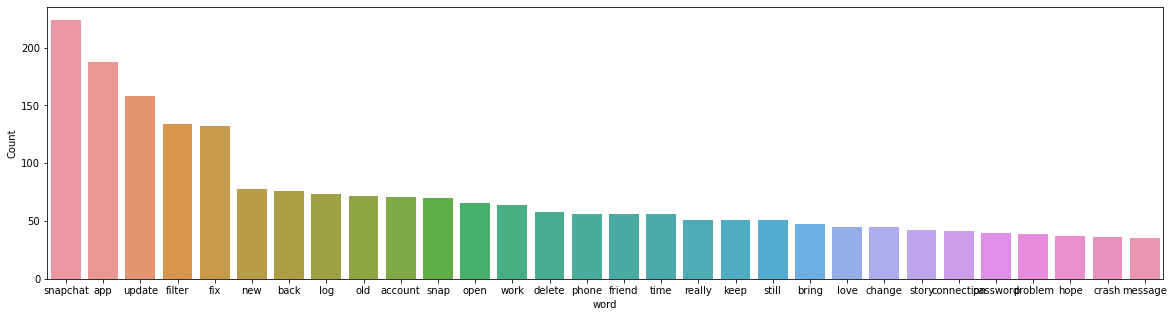

In [130]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score1N2N3))


In [131]:
# Create Dictionary
id2word_ph_score1N2N3 = corpora.Dictionary(review_ph_ready_score1N2N3)

2021-10-16 20:52:48,182 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:52:48,260 [INFO] gensim.corpora.dictionary - built Dictionary(1073 unique tokens: ['app', 'delete', 'different', 'everytime', 'happen']...) from 522 documents (total 5773 corpus positions)
2021-10-16 20:52:48,261 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1073 unique tokens: ['app', 'delete', 'different', 'everytime', 'happen']...) from 522 documents (total 5773 corpus positions)", 'datetime': '2021-10-16T20:52:48.261554', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [132]:
# Create Corpus: Term Document Frequency
corpus_ph_score1N2N3 = [id2word_ph_score1N2N3.doc2bow(text) for text in review_ph_ready_score1N2N3]

In [133]:
# Training LDA model
model_list_ph_score1N2N3, coherence_values_ph_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_score1N2N3, corpus=corpus_ph_score1N2N3, 
                                                              texts=review_ph_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-16 20:52:48,369 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:52:48,371 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:52:48,374 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:52:48,377 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 522 documents, updating model once every 522 documents, evaluating perplexity every 522 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:52:51,524 [INFO] gensim.models.ldamodel - -7.566 per-word bound, 189.5 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:52:51,531 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #522/522
2021-10-16 20:52:54,129 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"snapchat" + 0.032*"update" + 0.024*"fix" + 0.022*"filter" + 0.017*"app" + 0.017*"new" + 0.017*"ol

2021-10-16 20:53:16,739 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.026*"snapchat" + 0.023*"fix" + 0.018*"open" + 0.014*"time" + 0.014*"keep" + 0.014*"snap" + 0.014*"still" + 0.014*"phone" + 0.013*"delete"
2021-10-16 20:53:16,744 [INFO] gensim.models.ldamodel - topic diff=0.021885, rho=0.301511
2021-10-16 20:53:17,907 [INFO] gensim.models.ldamodel - -6.145 per-word bound, 70.8 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:53:17,911 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #522/522
2021-10-16 20:53:19,000 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"update" + 0.040*"snapchat" + 0.032*"filter" + 0.024*"new" + 0.022*"old" + 0.021*"back" + 0.015*"app" + 0.014*"bring" + 0.014*"fix" + 0.012*"story"
2021-10-16 20:53:19,018 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.026*"snapchat" + 0.024*"fix" + 0.018*"open" + 0.015*"time" + 0.014*"keep" + 0.014*"phone" + 0.014*"still

2021-10-16 20:53:38,402 [INFO] gensim.models.ldamodel - topic diff=0.016176, rho=0.218218
2021-10-16 20:53:39,433 [INFO] gensim.models.ldamodel - -6.117 per-word bound, 69.4 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:53:39,435 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #522/522
2021-10-16 20:53:40,174 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.047*"update" + 0.039*"filter" + 0.038*"snapchat" + 0.026*"new" + 0.024*"old" + 0.023*"back" + 0.016*"bring" + 0.014*"app" + 0.014*"story" + 0.013*"friend"
2021-10-16 20:53:40,175 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"app" + 0.028*"snapchat" + 0.027*"fix" + 0.017*"open" + 0.017*"log" + 0.014*"time" + 0.014*"account" + 0.014*"delete" + 0.014*"phone" + 0.013*"keep"
2021-10-16 20:53:40,178 [INFO] gensim.models.ldamodel - topic diff=0.015449, rho=0.213201
2021-10-16 20:53:41,255 [INFO] gensim.models.ldamodel - -6.115 per-word bound, 69.3 perplexity estim

2021-10-16 20:53:55,120 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #522/522
2021-10-16 20:53:55,660 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"update" + 0.043*"filter" + 0.038*"snapchat" + 0.027*"new" + 0.025*"old" + 0.024*"back" + 0.016*"bring" + 0.014*"story" + 0.014*"app" + 0.013*"friend"
2021-10-16 20:53:55,665 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"app" + 0.029*"snapchat" + 0.029*"fix" + 0.018*"log" + 0.017*"open" + 0.016*"account" + 0.014*"time" + 0.014*"delete" + 0.014*"phone" + 0.013*"keep"
2021-10-16 20:53:55,667 [INFO] gensim.models.ldamodel - topic diff=0.009583, rho=0.176777
2021-10-16 20:53:56,509 [INFO] gensim.models.ldamodel - -6.100 per-word bound, 68.6 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:53:56,510 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #522/522
2021-10-16 20:53:57,219 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"update" + 0.0

2021-10-16 20:54:11,379 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"update" + 0.045*"filter" + 0.037*"snapchat" + 0.027*"new" + 0.025*"old" + 0.025*"back" + 0.016*"bring" + 0.014*"story" + 0.014*"app" + 0.012*"friend"
2021-10-16 20:54:11,383 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"app" + 0.030*"snapchat" + 0.029*"fix" + 0.018*"log" + 0.017*"account" + 0.017*"open" + 0.014*"time" + 0.014*"delete" + 0.014*"phone" + 0.013*"keep"
2021-10-16 20:54:11,384 [INFO] gensim.models.ldamodel - topic diff=0.005746, rho=0.154303
2021-10-16 20:54:12,369 [INFO] gensim.models.ldamodel - -6.092 per-word bound, 68.2 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:54:12,370 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #522/522
2021-10-16 20:54:12,996 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"update" + 0.045*"filter" + 0.037*"snapchat" + 0.027*"new" + 0.025*"old" + 0.025*"back" + 0.016*"bring" + 0.01

2021-10-16 20:54:27,797 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:54:36,561 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:54:36,598 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 483 virtual documents
2021-10-16 20:54:37,100 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:54:37,101 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:54:37,108 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:54:37,113 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 522 documents, updating model once every 522 documents, evaluating perplexity every 522 documents, iterating 50x with a con

2021-10-16 20:54:47,917 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.055*"snapchat" + 0.048*"update" + 0.034*"new" + 0.029*"story" + 0.027*"filter" + 0.018*"old" + 0.015*"change" + 0.015*"really" + 0.014*"back" + 0.014*"friend"
2021-10-16 20:54:47,918 [INFO] gensim.models.ldamodel - topic diff=0.069356, rho=0.408248
2021-10-16 20:54:49,244 [INFO] gensim.models.ldamodel - -6.449 per-word bound, 87.4 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:54:49,245 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #522/522
2021-10-16 20:54:50,128 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"filter" + 0.025*"app" + 0.024*"keep" + 0.022*"save" + 0.020*"open" + 0.020*"time" + 0.019*"crash" + 0.017*"message" + 0.016*"snapchat" + 0.016*"still"
2021-10-16 20:54:50,130 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.034*"snapchat" + 0.029*"open" + 0.027*"app" + 0.020*"fix" + 0.020*"screen" + 0.019*"black" + 0.017*"log" + 0

2021-10-16 20:54:59,997 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.053*"app" + 0.032*"fix" + 0.032*"filter" + 0.031*"snapchat" + 0.020*"back" + 0.018*"snap" + 0.016*"old" + 0.016*"bring" + 0.013*"hope" + 0.010*"time"
2021-10-16 20:55:00,000 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.037*"snapchat" + 0.033*"log" + 0.029*"account" + 0.026*"password" + 0.024*"work" + 0.021*"app" + 0.021*"delete" + 0.019*"help" + 0.018*"friend" + 0.015*"phone"
2021-10-16 20:55:00,002 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.053*"update" + 0.030*"old" + 0.028*"back" + 0.022*"new" + 0.022*"snapchat" + 0.019*"bring" + 0.019*"filter" + 0.018*"app" + 0.015*"fix" + 0.013*"version"
2021-10-16 20:55:00,004 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"snapchat" + 0.051*"update" + 0.036*"new" + 0.032*"story" + 0.027*"filter" + 0.020*"old" + 0.017*"friend" + 0.016*"back" + 0.016*"really" + 0.015*"change"
2021-10-16 20:55:00,006 [INFO] gensim.models.ldamodel - topic diff=0.0229

2021-10-16 20:55:11,030 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"connection" + 0.029*"update" + 0.028*"app" + 0.026*"fix" + 0.026*"filter" + 0.024*"snapchat" + 0.024*"work" + 0.020*"internet" + 0.018*"log" + 0.017*"account"
2021-10-16 20:55:11,031 [INFO] gensim.models.ldamodel - topic diff=0.013043, rho=0.242536
2021-10-16 20:55:12,013 [INFO] gensim.models.ldamodel - -6.396 per-word bound, 84.2 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:55:12,014 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #522/522
2021-10-16 20:55:12,750 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"snapchat" + 0.034*"open" + 0.032*"black" + 0.032*"app" + 0.027*"fix" + 0.023*"screen" + 0.016*"update" + 0.014*"white" + 0.014*"really" + 0.013*"change"
2021-10-16 20:55:12,751 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.053*"update" + 0.053*"snapchat" + 0.037*"new" + 0.034*"story" + 0.028*"filter" + 0.020*"old" + 0.019

2021-10-16 20:55:28,417 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"connection" + 0.027*"update" + 0.026*"app" + 0.025*"fix" + 0.025*"filter" + 0.024*"work" + 0.024*"snapchat" + 0.022*"log" + 0.020*"internet" + 0.019*"account"
2021-10-16 20:55:28,419 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.055*"update" + 0.038*"old" + 0.035*"back" + 0.028*"snapchat" + 0.025*"bring" + 0.022*"new" + 0.021*"filter" + 0.019*"app" + 0.017*"fix" + 0.013*"version"
2021-10-16 20:55:28,422 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"snapchat" + 0.035*"open" + 0.034*"black" + 0.032*"app" + 0.028*"fix" + 0.024*"screen" + 0.015*"update" + 0.015*"really" + 0.015*"white" + 0.014*"chat"
2021-10-16 20:55:28,424 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.055*"update" + 0.052*"snapchat" + 0.039*"new" + 0.035*"story" + 0.028*"filter" + 0.020*"old" + 0.019*"friend" + 0.015*"change" + 0.015*"back" + 0.015*"really"
2021-10-16 20:55:28,425 [INFO] gensim.models.ldamodel - topic d

2021-10-16 20:55:36,920 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"connection" + 0.025*"fix" + 0.025*"update" + 0.025*"work" + 0.025*"app" + 0.024*"filter" + 0.024*"log" + 0.024*"snapchat" + 0.021*"account" + 0.020*"internet"
2021-10-16 20:55:36,923 [INFO] gensim.models.ldamodel - topic diff=0.005650, rho=0.188982
2021-10-16 20:55:38,280 [INFO] gensim.models.ldamodel - -6.379 per-word bound, 83.3 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:55:38,285 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #522/522
2021-10-16 20:55:39,063 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"log" + 0.037*"snapchat" + 0.034*"account" + 0.029*"password" + 0.022*"work" + 0.021*"delete" + 0.020*"help" + 0.018*"app" + 0.018*"number" + 0.017*"friend"
2021-10-16 20:55:39,064 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"snapchat" + 0.036*"open" + 0.035*"black" + 0.033*"app" + 0.028*"fix" + 0.025*"screen" + 0.01

2021-10-16 20:55:49,010 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.059*"update" + 0.051*"snapchat" + 0.042*"new" + 0.037*"story" + 0.029*"filter" + 0.020*"friend" + 0.018*"old" + 0.015*"change" + 0.014*"really" + 0.014*"back"
2021-10-16 20:55:49,013 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.055*"update" + 0.043*"old" + 0.041*"back" + 0.031*"bring" + 0.030*"snapchat" + 0.023*"new" + 0.022*"filter" + 0.018*"app" + 0.016*"fix" + 0.013*"version"
2021-10-16 20:55:49,014 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"keep" + 0.035*"crash" + 0.032*"app" + 0.029*"filter" + 0.024*"open" + 0.024*"save" + 0.021*"time" + 0.021*"snapchat" + 0.018*"message" + 0.017*"update"
2021-10-16 20:55:49,016 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.037*"snapchat" + 0.036*"black" + 0.036*"open" + 0.033*"app" + 0.028*"fix" + 0.025*"screen" + 0.017*"really" + 0.016*"chat" + 0.015*"white" + 0.015*"update"
2021-10-16 20:55:49,017 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 20:55:59,414 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.055*"update" + 0.044*"old" + 0.042*"back" + 0.032*"bring" + 0.031*"snapchat" + 0.023*"new" + 0.023*"filter" + 0.018*"app" + 0.016*"fix" + 0.014*"version"
2021-10-16 20:55:59,415 [INFO] gensim.models.ldamodel - topic diff=0.003560, rho=0.160128
2021-10-16 20:56:00,386 [INFO] gensim.models.ldamodel - -6.371 per-word bound, 82.8 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:56:00,391 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #522/522
2021-10-16 20:56:01,169 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"snapchat" + 0.037*"black" + 0.036*"open" + 0.032*"app" + 0.028*"fix" + 0.025*"screen" + 0.017*"really" + 0.017*"chat" + 0.015*"white" + 0.015*"update"
2021-10-16 20:56:01,175 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"app" + 0.034*"fix" + 0.031*"filter" + 0.027*"snapchat" + 0.019*"snap" + 0.014*"hope" + 0.012*"back" + 0.012

2021-10-16 20:56:11,053 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"snapchat" + 0.037*"black" + 0.036*"open" + 0.032*"app" + 0.028*"fix" + 0.025*"screen" + 0.017*"really" + 0.017*"chat" + 0.015*"white" + 0.014*"update"
2021-10-16 20:56:11,060 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"crash" + 0.039*"keep" + 0.033*"app" + 0.029*"filter" + 0.025*"open" + 0.024*"save" + 0.021*"snapchat" + 0.021*"time" + 0.018*"message" + 0.018*"update"
2021-10-16 20:56:11,068 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.060*"app" + 0.034*"fix" + 0.031*"filter" + 0.027*"snapchat" + 0.019*"snap" + 0.014*"hope" + 0.012*"delete" + 0.011*"back" + 0.010*"still" + 0.009*"old"
2021-10-16 20:56:11,076 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"log" + 0.037*"snapchat" + 0.035*"account" + 0.030*"password" + 0.022*"work" + 0.021*"delete" + 0.020*"help" + 0.018*"number" + 0.018*"app" + 0.018*"friend"
2021-10-16 20:56:11,078 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 20:56:21,174 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.041*"crash" + 0.039*"keep" + 0.033*"app" + 0.029*"filter" + 0.025*"open" + 0.024*"save" + 0.021*"time" + 0.021*"snapchat" + 0.018*"message" + 0.018*"update"
2021-10-16 20:56:21,176 [INFO] gensim.models.ldamodel - topic diff=0.002620, rho=0.141421
2021-10-16 20:56:22,031 [INFO] gensim.models.ldamodel - -6.365 per-word bound, 82.4 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:56:22,040 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #522/522
2021-10-16 20:56:22,646 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.062*"update" + 0.049*"snapchat" + 0.044*"new" + 0.038*"story" + 0.031*"filter" + 0.022*"friend" + 0.018*"old" + 0.016*"change" + 0.014*"really" + 0.013*"back"
2021-10-16 20:56:22,648 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.054*"update" + 0.047*"old" + 0.046*"back" + 0.035*"bring" + 0.032*"snapchat" + 0.024*"filter" + 0.023*"new

2021-10-16 20:56:40,352 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.042*"update" + 0.023*"snapchat" + 0.020*"message" + 0.020*"people" + 0.019*"delete" + 0.017*"app" + 0.017*"video" + 0.014*"problem" + 0.013*"account" + 0.012*"send"
2021-10-16 20:56:40,354 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"update" + 0.025*"snapchat" + 0.021*"app" + 0.019*"keep" + 0.018*"new" + 0.017*"ipad" + 0.014*"people" + 0.013*"fix" + 0.012*"account" + 0.011*"old"
2021-10-16 20:56:40,357 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.049*"open" + 0.043*"snapchat" + 0.041*"app" + 0.033*"screen" + 0.028*"black" + 0.019*"update" + 0.018*"white" + 0.017*"fix" + 0.016*"time" + 0.014*"crash"
2021-10-16 20:56:40,360 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.038*"fix" + 0.037*"app" + 0.027*"log" + 0.024*"snapchat" + 0.020*"work" + 0.016*"open" + 0.015*"love" + 0.015*"hope" + 0.014*"account" + 0.013*"time"
2021-10-16 20:56:40,362 [INFO] gensim.models.ldamodel - topic diff=0.1314

2021-10-16 20:56:49,712 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.044*"app" + 0.042*"fix" + 0.037*"connection" + 0.029*"update" + 0.022*"open" + 0.022*"always" + 0.021*"snap" + 0.020*"filter" + 0.020*"internet" + 0.017*"snapchat"
2021-10-16 20:56:49,713 [INFO] gensim.models.ldamodel - topic diff=0.049129, rho=0.316228
2021-10-16 20:56:50,816 [INFO] gensim.models.ldamodel - -6.541 per-word bound, 93.1 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:56:50,817 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #522/522
2021-10-16 20:56:51,441 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"open" + 0.045*"snapchat" + 0.044*"app" + 0.037*"black" + 0.034*"screen" + 0.022*"white" + 0.020*"fix" + 0.019*"update" + 0.017*"time" + 0.014*"love"
2021-10-16 20:56:51,443 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"snapchat" + 0.053*"update" + 0.032*"filter" + 0.019*"story" + 0.017*"new" + 0.017*"download" + 0.016

2021-10-16 20:57:00,200 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.043*"fix" + 0.043*"app" + 0.041*"connection" + 0.028*"update" + 0.023*"always" + 0.022*"snap" + 0.021*"open" + 0.021*"internet" + 0.019*"filter" + 0.018*"log"
2021-10-16 20:57:00,204 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"snapchat" + 0.053*"update" + 0.034*"filter" + 0.019*"story" + 0.017*"download" + 0.015*"old" + 0.015*"turn" + 0.014*"always" + 0.014*"change" + 0.014*"remove"
2021-10-16 20:57:00,206 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"app" + 0.026*"io" + 0.020*"filter" + 0.019*"look" + 0.015*"boy" + 0.015*"sometimes" + 0.015*"snapchat" + 0.013*"time" + 0.011*"allow" + 0.011*"username"
2021-10-16 20:57:00,209 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.090*"update" + 0.074*"new" + 0.032*"back" + 0.029*"snapchat" + 0.028*"story" + 0.028*"old" + 0.026*"friend" + 0.021*"really" + 0.020*"bring" + 0.018*"ever"
2021-10-16 20:57:00,213 [INFO] gensim.models.ldamodel - to

2021-10-16 20:57:07,327 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.026*"snapchat" + 0.022*"ipad" + 0.017*"people" + 0.014*"keep" + 0.013*"download" + 0.013*"lense" + 0.012*"update" + 0.012*"app" + 0.009*"love" + 0.009*"fix"
2021-10-16 20:57:07,332 [INFO] gensim.models.ldamodel - topic diff=0.012232, rho=0.218218
2021-10-16 20:57:08,162 [INFO] gensim.models.ldamodel - -6.504 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:57:08,165 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #522/522
2021-10-16 20:57:08,677 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"app" + 0.026*"io" + 0.020*"filter" + 0.019*"look" + 0.015*"boy" + 0.015*"sometimes" + 0.014*"snapchat" + 0.013*"time" + 0.011*"allow" + 0.011*"username"
2021-10-16 20:57:08,680 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"snapchat" + 0.052*"update" + 0.036*"filter" + 0.018*"story" + 0.017*"download" + 0.015*"remove" + 0.01

2021-10-16 20:57:14,927 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.042*"update" + 0.038*"message" + 0.028*"video" + 0.021*"people" + 0.020*"app" + 0.020*"snapchat" + 0.018*"delete" + 0.016*"send" + 0.015*"problem" + 0.014*"load"
2021-10-16 20:57:14,931 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.054*"filter" + 0.044*"crash" + 0.042*"keep" + 0.039*"work" + 0.036*"app" + 0.034*"fix" + 0.027*"whenever" + 0.026*"snapchat" + 0.024*"password" + 0.021*"save"
2021-10-16 20:57:14,934 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.061*"filter" + 0.026*"snapchat" + 0.019*"memory" + 0.013*"new" + 0.013*"look" + 0.013*"username" + 0.012*"let" + 0.012*"change" + 0.012*"lock" + 0.011*"save"
2021-10-16 20:57:14,936 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.045*"fix" + 0.044*"app" + 0.043*"connection" + 0.024*"always" + 0.023*"update" + 0.022*"internet" + 0.022*"snap" + 0.020*"open" + 0.018*"filter" + 0.017*"log"
2021-10-16 20:57:14,938 [INFO] gensim.models.ldamodel - t

2021-10-16 20:57:22,291 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.056*"log" + 0.054*"snapchat" + 0.052*"account" + 0.032*"delete" + 0.025*"help" + 0.024*"app" + 0.021*"password" + 0.021*"friend" + 0.018*"error" + 0.014*"time"
2021-10-16 20:57:22,294 [INFO] gensim.models.ldamodel - topic diff=0.005954, rho=0.176777
2021-10-16 20:57:23,262 [INFO] gensim.models.ldamodel - -6.487 per-word bound, 89.7 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:57:23,263 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #522/522
2021-10-16 20:57:23,904 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.049*"back" + 0.042*"app" + 0.037*"old" + 0.037*"snapchat" + 0.036*"bring" + 0.033*"filter" + 0.024*"snap" + 0.016*"phone" + 0.015*"fix" + 0.012*"send"
2021-10-16 20:57:23,906 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.027*"snapchat" + 0.022*"ipad" + 0.018*"people" + 0.014*"keep" + 0.014*"lol" + 0.013*"download" + 0.013*"lense" 

2021-10-16 20:57:30,576 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"app" + 0.026*"io" + 0.020*"filter" + 0.019*"look" + 0.015*"boy" + 0.015*"sometimes" + 0.014*"snapchat" + 0.013*"time" + 0.011*"allow" + 0.011*"username"
2021-10-16 20:57:30,578 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.045*"fix" + 0.045*"app" + 0.043*"connection" + 0.025*"always" + 0.022*"internet" + 0.022*"snap" + 0.021*"update" + 0.020*"open" + 0.018*"filter" + 0.016*"sign"
2021-10-16 20:57:30,580 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.062*"filter" + 0.023*"snapchat" + 0.019*"memory" + 0.013*"new" + 0.013*"look" + 0.013*"username" + 0.012*"let" + 0.012*"lock" + 0.011*"always" + 0.011*"change"
2021-10-16 20:57:30,582 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.106*"update" + 0.084*"new" + 0.031*"back" + 0.031*"story" + 0.030*"snapchat" + 0.029*"old" + 0.026*"friend" + 0.020*"really" + 0.020*"change" + 0.020*"bring"
2021-10-16 20:57:30,584 [INFO] gensim.models.ldamodel - to

2021-10-16 20:57:36,789 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.049*"back" + 0.043*"app" + 0.037*"old" + 0.037*"snapchat" + 0.036*"bring" + 0.033*"filter" + 0.025*"snap" + 0.016*"phone" + 0.015*"fix" + 0.012*"send"
2021-10-16 20:57:36,791 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"app" + 0.026*"io" + 0.020*"filter" + 0.019*"look" + 0.015*"boy" + 0.015*"sometimes" + 0.014*"snapchat" + 0.013*"time" + 0.011*"allow" + 0.011*"username"
2021-10-16 20:57:36,793 [INFO] gensim.models.ldamodel - topic diff=0.004141, rho=0.152499
2021-10-16 20:57:37,519 [INFO] gensim.models.ldamodel - -6.479 per-word bound, 89.2 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:57:37,525 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #522/522
2021-10-16 20:57:38,069 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.056*"log" + 0.054*"snapchat" + 0.053*"account" + 0.033*"delete" + 0.025*"help" + 0.024*"app" + 0.021*"password" +

2021-10-16 20:57:44,076 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #522/522
2021-10-16 20:57:44,723 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"app" + 0.026*"io" + 0.020*"filter" + 0.019*"look" + 0.015*"boy" + 0.015*"sometimes" + 0.014*"snapchat" + 0.013*"time" + 0.011*"allow" + 0.011*"username"
2021-10-16 20:57:44,726 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.056*"filter" + 0.046*"crash" + 0.043*"keep" + 0.040*"work" + 0.035*"fix" + 0.030*"app" + 0.027*"whenever" + 0.026*"snapchat" + 0.025*"password" + 0.022*"save"
2021-10-16 20:57:44,730 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.044*"connection" + 0.043*"fix" + 0.043*"app" + 0.026*"always" + 0.023*"internet" + 0.022*"snap" + 0.019*"filter" + 0.018*"sign" + 0.017*"open" + 0.017*"update"
2021-10-16 20:57:44,741 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.107*"update" + 0.084*"new" + 0.032*"story" + 0.031*"snapchat" + 0.031*"back" + 0.029*"old" + 0.026*"friend" + 0.021*"chang

2021-10-16 20:58:00,178 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.047*"snapchat" + 0.046*"open" + 0.029*"screen" + 0.026*"update" + 0.024*"app" + 0.022*"phone" + 0.020*"black" + 0.019*"connection" + 0.019*"uninstall" + 0.018*"log"
2021-10-16 20:58:00,179 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.023*"snapchat" + 0.019*"log" + 0.017*"place" + 0.017*"app" + 0.016*"fix" + 0.015*"sign" + 0.013*"hairstyle" + 0.013*"memory" + 0.013*"help" + 0.012*"time"
2021-10-16 20:58:00,180 [INFO] gensim.models.ldamodel - topic diff=0.166768, rho=0.577350
2021-10-16 20:58:00,979 [INFO] gensim.models.ldamodel - -6.812 per-word bound, 112.3 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:58:00,980 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #522/522
2021-10-16 20:58:01,526 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.055*"app" + 0.030*"snapchat" + 0.028*"download" + 0.021*"fix" + 0.018*"delete" + 0.018*"time" + 0.01

2021-10-16 20:58:07,562 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #522/522
2021-10-16 20:58:08,183 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.022*"log" + 0.021*"place" + 0.019*"snapchat" + 0.017*"app" + 0.017*"sign" + 0.015*"people" + 0.013*"time" + 0.013*"fix" + 0.013*"hairstyle" + 0.013*"memory"
2021-10-16 20:58:08,186 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.060*"open" + 0.052*"snapchat" + 0.035*"black" + 0.033*"screen" + 0.029*"app" + 0.023*"fix" + 0.022*"happen" + 0.022*"connection" + 0.022*"uninstall" + 0.022*"update"
2021-10-16 20:58:08,188 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.035*"password" + 0.031*"log" + 0.031*"send" + 0.023*"work" + 0.022*"app" + 0.022*"snapchat" + 0.020*"time" + 0.019*"still" + 0.017*"account" + 0.016*"snap"
2021-10-16 20:58:08,190 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.032*"fix" + 0.028*"app" + 0.028*"ipad" + 0.027*"show" + 0.020*"error" + 0.019*"last" + 0.017*"log" + 0.017*"chat" + 0.017

2021-10-16 20:58:14,934 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.029*"ipad" + 0.028*"app" + 0.028*"fix" + 0.025*"show" + 0.021*"last" + 0.021*"error" + 0.018*"log" + 0.018*"chat" + 0.018*"connection" + 0.018*"slow"
2021-10-16 20:58:14,935 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.074*"filter" + 0.044*"delete" + 0.043*"whenever" + 0.037*"work" + 0.035*"snapchat" + 0.032*"crash" + 0.031*"update" + 0.024*"fix" + 0.023*"video" + 0.020*"app"
2021-10-16 20:58:14,938 [INFO] gensim.models.ldamodel - topic diff=0.025216, rho=0.267261
2021-10-16 20:58:15,710 [INFO] gensim.models.ldamodel - -6.630 per-word bound, 99.1 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:58:15,716 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #522/522
2021-10-16 20:58:16,193 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.018*"keep" + 0.015*"leave" + 0.015*"deliver" + 0.015*"people" + 0.009*"time" + 0.009*"fix" + 0.008*"log" + 0.00

2021-10-16 20:58:23,298 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #522/522
2021-10-16 20:58:24,006 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.022*"place" + 0.018*"app" + 0.016*"log" + 0.015*"snapchat" + 0.015*"people" + 0.014*"fix" + 0.014*"sign" + 0.013*"hairstyle" + 0.013*"memory" + 0.013*"size"
2021-10-16 20:58:24,017 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.061*"update" + 0.058*"new" + 0.046*"story" + 0.033*"friend" + 0.033*"snapchat" + 0.029*"back" + 0.027*"old" + 0.024*"really" + 0.023*"snap" + 0.022*"interface"
2021-10-16 20:58:24,022 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.065*"crash" + 0.052*"keep" + 0.049*"app" + 0.037*"open" + 0.036*"time" + 0.028*"snapchat" + 0.020*"message" + 0.019*"fix" + 0.017*"receive" + 0.013*"update"
2021-10-16 20:58:24,029 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.052*"filter" + 0.024*"snapchat" + 0.020*"memory" + 0.019*"look" + 0.019*"app" + 0.013*"love" + 0.013*"work" + 0.013*"put" +

2021-10-16 20:58:30,893 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.016*"keep" + 0.016*"deliver" + 0.016*"leave" + 0.016*"people" + 0.008*"fix" + 0.008*"time" + 0.008*"log" + 0.008*"app" + 0.008*"bug" + 0.008*"help"
2021-10-16 20:58:30,895 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.059*"open" + 0.055*"snapchat" + 0.050*"black" + 0.037*"screen" + 0.034*"app" + 0.028*"fix" + 0.025*"white" + 0.024*"happen" + 0.023*"connection" + 0.020*"always"
2021-10-16 20:58:30,897 [INFO] gensim.models.ldamodel - topic diff=0.009175, rho=0.200000
2021-10-16 20:58:31,616 [INFO] gensim.models.ldamodel - -6.595 per-word bound, 96.7 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:58:31,618 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #522/522
2021-10-16 20:58:32,290 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.051*"snapchat" + 0.050*"log" + 0.042*"fix" + 0.035*"account" + 0.033*"app" + 0.023*"message" + 0.021*"hope" + 0

2021-10-16 20:58:39,285 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #522/522
2021-10-16 20:58:39,832 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.079*"phone" + 0.025*"app" + 0.022*"battery" + 0.021*"number" + 0.021*"email" + 0.021*"snapchat" + 0.018*"connect" + 0.017*"update" + 0.016*"delete" + 0.016*"iphone"
2021-10-16 20:58:39,837 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.040*"log" + 0.038*"password" + 0.034*"send" + 0.022*"app" + 0.022*"work" + 0.022*"account" + 0.021*"time" + 0.020*"snapchat" + 0.019*"still" + 0.016*"snap"
2021-10-16 20:58:39,840 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.059*"open" + 0.055*"snapchat" + 0.051*"black" + 0.038*"screen" + 0.034*"app" + 0.028*"fix" + 0.025*"white" + 0.024*"happen" + 0.023*"connection" + 0.021*"always"
2021-10-16 20:58:39,842 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.044*"update" + 0.034*"app" + 0.027*"fix" + 0.026*"problem" + 0.026*"video" + 0.019*"new" + 0.017*"picture" + 0.016*"s

2021-10-16 20:58:47,080 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.030*"ipad" + 0.027*"app" + 0.025*"fix" + 0.024*"last" + 0.018*"error" + 0.018*"log" + 0.018*"chat" + 0.018*"connection" + 0.018*"slow" + 0.014*"show"
2021-10-16 20:58:47,083 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.016*"keep" + 0.016*"leave" + 0.016*"people" + 0.016*"deliver" + 0.008*"fix" + 0.008*"time" + 0.008*"log" + 0.008*"app" + 0.008*"account" + 0.008*"chat"
2021-10-16 20:58:47,086 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.022*"place" + 0.018*"app" + 0.015*"people" + 0.014*"snapchat" + 0.014*"hairstyle" + 0.014*"memory" + 0.014*"size" + 0.013*"fix" + 0.010*"help" + 0.010*"time"
2021-10-16 20:58:47,089 [INFO] gensim.models.ldamodel - topic diff=0.004279, rho=0.166667
2021-10-16 20:58:47,917 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:58:47,918 [INFO] gensim.models.ldamodel - 

2021-10-16 20:58:53,876 [INFO] gensim.models.ldamodel - topic diff=0.003274, rho=0.156174
2021-10-16 20:58:54,653 [INFO] gensim.models.ldamodel - -6.581 per-word bound, 95.8 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:58:54,655 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #522/522
2021-10-16 20:58:55,184 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.071*"crash" + 0.053*"keep" + 0.051*"app" + 0.039*"open" + 0.037*"time" + 0.028*"snapchat" + 0.019*"message" + 0.019*"fix" + 0.016*"receive" + 0.015*"update"
2021-10-16 20:58:55,188 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.053*"app" + 0.040*"filter" + 0.033*"fix" + 0.031*"snapchat" + 0.024*"snap" + 0.018*"bug" + 0.013*"still" + 0.012*"hope" + 0.012*"post" + 0.012*"let"
2021-10-16 20:58:55,192 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.051*"snapchat" + 0.050*"log" + 0.041*"fix" + 0.038*"account" + 0.032*"app" + 0.023*"message" + 0.020*"hope" + 0.018*

2021-10-16 20:59:01,936 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.061*"update" + 0.052*"new" + 0.048*"story" + 0.040*"friend" + 0.033*"snapchat" + 0.032*"back" + 0.031*"old" + 0.028*"snap" + 0.025*"really" + 0.022*"view"
2021-10-16 20:59:01,951 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.059*"old" + 0.055*"back" + 0.055*"snapchat" + 0.055*"filter" + 0.036*"bring" + 0.030*"account" + 0.020*"fix" + 0.020*"connection" + 0.018*"face" + 0.016*"look"
2021-10-16 20:59:01,961 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.080*"app" + 0.041*"download" + 0.032*"snapchat" + 0.032*"fix" + 0.030*"update" + 0.026*"open" + 0.023*"turn" + 0.018*"really" + 0.018*"filter" + 0.016*"io"
2021-10-16 20:59:01,967 [INFO] gensim.models.ldamodel - topic diff=0.002644, rho=0.145865
2021-10-16 20:59:02,768 [INFO] gensim.models.ldamodel - -6.577 per-word bound, 95.5 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:59:02,788 [INFO] gensim.models

2021-10-16 20:59:16,559 [INFO] gensim.models.ldamodel - -15.007 per-word bound, 32921.1 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:59:16,561 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #522/522
2021-10-16 20:59:17,555 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.044*"app" + 0.041*"filter" + 0.040*"snapchat" + 0.021*"back" + 0.018*"update" + 0.016*"love" + 0.015*"story" + 0.015*"look" + 0.014*"change" + 0.014*"friend"
2021-10-16 20:59:17,564 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.057*"update" + 0.053*"snapchat" + 0.043*"new" + 0.022*"log" + 0.021*"friend" + 0.017*"story" + 0.013*"feature" + 0.013*"old" + 0.013*"change" + 0.013*"everytime"
2021-10-16 20:59:17,565 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.049*"update" + 0.034*"snapchat" + 0.023*"fix" + 0.023*"new" + 0.023*"back" + 0.021*"old" + 0.014*"lock" + 0.014*"filter" + 0.014*"bring" + 0.014*"hope"
2021-10-16 20:59:17,567 [INFO] gensi

2021-10-16 20:59:25,188 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.086*"back" + 0.078*"old" + 0.072*"bring" + 0.069*"update" + 0.039*"snapchat" + 0.036*"new" + 0.036*"filter" + 0.035*"app" + 0.021*"snap" + 0.018*"really"
2021-10-16 20:59:25,192 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.043*"delete" + 0.031*"snapchat" + 0.030*"app" + 0.028*"log" + 0.027*"update" + 0.020*"friend" + 0.019*"send" + 0.017*"still" + 0.016*"account" + 0.015*"new"
2021-10-16 20:59:25,194 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.034*"update" + 0.027*"people" + 0.022*"new" + 0.021*"error" + 0.019*"show" + 0.019*"old" + 0.019*"connection" + 0.018*"bad" + 0.018*"back" + 0.017*"version"
2021-10-16 20:59:25,196 [INFO] gensim.models.ldamodel - topic diff=0.097943, rho=0.377964
2021-10-16 20:59:26,205 [INFO] gensim.models.ldamodel - -6.770 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:59:26,210 [INFO] gensim.models.lda

2021-10-16 20:59:31,849 [INFO] gensim.models.ldamodel - topic diff=0.043494, rho=0.288675
2021-10-16 20:59:32,573 [INFO] gensim.models.ldamodel - -6.702 per-word bound, 104.1 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:59:32,575 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #522/522
2021-10-16 20:59:33,071 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.050*"filter" + 0.043*"snapchat" + 0.041*"app" + 0.031*"look" + 0.019*"love" + 0.017*"well" + 0.016*"fix" + 0.016*"phone" + 0.015*"back" + 0.015*"story"
2021-10-16 20:59:33,073 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.047*"delete" + 0.031*"log" + 0.030*"snapchat" + 0.026*"app" + 0.023*"send" + 0.021*"friend" + 0.019*"update" + 0.017*"still" + 0.015*"account" + 0.014*"time"
2021-10-16 20:59:33,074 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.048*"snapchat" + 0.038*"change" + 0.021*"filter" + 0.018*"picture" + 0.018*"conversation" + 0.017*"friend" + 

2021-10-16 20:59:40,190 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.033*"message" + 0.031*"fix" + 0.027*"work" + 0.025*"video" + 0.024*"app" + 0.023*"save" + 0.021*"problem" + 0.020*"snapchat" + 0.020*"account" + 0.019*"open"
2021-10-16 20:59:40,192 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.047*"delete" + 0.034*"log" + 0.029*"snapchat" + 0.026*"app" + 0.024*"send" + 0.021*"friend" + 0.017*"still" + 0.017*"update" + 0.015*"account" + 0.014*"time"
2021-10-16 20:59:40,194 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.034*"people" + 0.023*"show" + 0.017*"quit" + 0.017*"previous" + 0.017*"way" + 0.015*"story" + 0.015*"bad" + 0.013*"new" + 0.012*"error" + 0.011*"let"
2021-10-16 20:59:40,197 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.054*"app" + 0.036*"snapchat" + 0.035*"log" + 0.032*"fix" + 0.029*"really" + 0.023*"work" + 0.021*"love" + 0.021*"time" + 0.017*"ipad" + 0.016*"account"
2021-10-16 20:59:40,198 [INFO] gensim.models.ldamodel - topic diff=0.020220, 

2021-10-16 20:59:47,694 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.152*"update" + 0.097*"new" + 0.056*"story" + 0.051*"friend" + 0.037*"view" + 0.034*"snapchat" + 0.032*"change" + 0.023*"like" + 0.020*"filter" + 0.020*"always"
2021-10-16 20:59:47,696 [INFO] gensim.models.ldamodel - topic diff=0.012146, rho=0.208514
2021-10-16 20:59:48,681 [INFO] gensim.models.ldamodel - -6.651 per-word bound, 100.5 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 20:59:48,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #522/522
2021-10-16 20:59:49,324 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.050*"filter" + 0.043*"snapchat" + 0.040*"app" + 0.032*"look" + 0.020*"love" + 0.018*"well" + 0.017*"fix" + 0.017*"phone" + 0.015*"fast" + 0.015*"story"
2021-10-16 20:59:49,328 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.043*"snapchat" + 0.042*"snap" + 0.035*"app" + 0.019*"delete" + 0.019*"friend" + 0.019*"fix" + 0.018*"still" 

2021-10-16 20:59:56,558 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.036*"message" + 0.032*"fix" + 0.026*"work" + 0.025*"video" + 0.024*"save" + 0.024*"app" + 0.021*"problem" + 0.020*"account" + 0.019*"snapchat" + 0.019*"open"
2021-10-16 20:59:56,563 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.055*"app" + 0.037*"snapchat" + 0.033*"fix" + 0.031*"log" + 0.030*"really" + 0.024*"love" + 0.023*"work" + 0.021*"time" + 0.017*"ipad" + 0.015*"account"
2021-10-16 20:59:56,566 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.111*"old" + 0.107*"back" + 0.081*"bring" + 0.062*"update" + 0.047*"snapchat" + 0.045*"new" + 0.042*"filter" + 0.026*"app" + 0.021*"really" + 0.018*"snap"
2021-10-16 20:59:56,571 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.051*"snapchat" + 0.038*"change" + 0.022*"filter" + 0.018*"friend" + 0.018*"picture" + 0.018*"conversation" + 0.018*"offline" + 0.018*"people" + 0.017*"way" + 0.014*"update"
2021-10-16 20:59:56,584 [INFO] gensim.models.ldamodel - 

2021-10-16 21:00:03,576 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.112*"old" + 0.108*"back" + 0.081*"bring" + 0.062*"update" + 0.047*"snapchat" + 0.045*"new" + 0.042*"filter" + 0.026*"app" + 0.021*"really" + 0.017*"snap"
2021-10-16 21:00:03,579 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.037*"message" + 0.032*"fix" + 0.026*"work" + 0.025*"video" + 0.024*"save" + 0.024*"app" + 0.021*"problem" + 0.021*"account" + 0.019*"snapchat" + 0.018*"open"
2021-10-16 21:00:03,582 [INFO] gensim.models.ldamodel - topic diff=0.005609, rho=0.171499
2021-10-16 21:00:04,336 [INFO] gensim.models.ldamodel - -6.636 per-word bound, 99.4 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 21:00:04,343 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #522/522
2021-10-16 21:00:04,926 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.086*"open" + 0.067*"snapchat" + 0.055*"app" + 0.039*"fix" + 0.032*"crash" + 0.032*"update" + 0.028*"black" +

2021-10-16 21:00:11,175 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #522/522
2021-10-16 21:00:11,691 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.039*"snapchat" + 0.038*"update" + 0.037*"phone" + 0.026*"life" + 0.026*"battery" + 0.025*"snap" + 0.022*"picture" + 0.019*"app" + 0.018*"camera" + 0.018*"new"
2021-10-16 21:00:11,698 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.081*"filter" + 0.056*"crash" + 0.046*"app" + 0.040*"delete" + 0.036*"whenever" + 0.021*"help" + 0.018*"work" + 0.018*"happen" + 0.018*"time" + 0.017*"fix"
2021-10-16 21:00:11,715 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.100*"log" + 0.077*"connection" + 0.062*"account" + 0.039*"error" + 0.032*"always" + 0.031*"snapchat" + 0.030*"fix" + 0.030*"internet" + 0.028*"snap" + 0.024*"keep"
2021-10-16 21:00:11,718 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.041*"app" + 0.034*"interface" + 0.022*"fix" + 0.021*"still" + 0.021*"happen" + 0.016*"download" + 0.014*"bad" + 0.013*"c

2021-10-16 21:00:19,275 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.061*"update" + 0.042*"iphone" + 0.039*"io" + 0.036*"lock" + 0.034*"snapchat" + 0.031*"filter" + 0.029*"late" + 0.029*"fix" + 0.020*"permanently" + 0.020*"problem"
2021-10-16 21:00:19,280 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.038*"people" + 0.035*"show" + 0.027*"story" + 0.020*"quit" + 0.020*"previous" + 0.015*"post" + 0.011*"filter" + 0.010*"let" + 0.010*"swipe" + 0.010*"article"
2021-10-16 21:00:19,291 [INFO] gensim.models.ldamodel - topic diff=0.003865, rho=0.149071
2021-10-16 21:00:20,153 [INFO] gensim.models.ldamodel - -6.622 per-word bound, 98.5 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 21:00:20,155 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #522/522
2021-10-16 21:00:20,804 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.101*"log" + 0.077*"connection" + 0.062*"account" + 0.039*"error" + 0.032*"always" + 0.032*"snapchat" 

2021-10-16 21:00:27,484 [INFO] gensim.models.ldamodel - -6.618 per-word bound, 98.2 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 21:00:27,485 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #522/522
2021-10-16 21:00:28,025 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.028*"memory" + 0.025*"snapchat" + 0.024*"username" + 0.023*"log" + 0.023*"work" + 0.019*"app" + 0.019*"help" + 0.018*"friend" + 0.018*"account" + 0.017*"phone"
2021-10-16 21:00:28,028 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.166*"update" + 0.105*"new" + 0.060*"story" + 0.058*"friend" + 0.038*"view" + 0.036*"change" + 0.033*"snapchat" + 0.023*"like" + 0.021*"filter" + 0.020*"always"
2021-10-16 21:00:28,050 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.062*"app" + 0.057*"turn" + 0.037*"download" + 0.035*"snapchat" + 0.032*"fix" + 0.031*"black" + 0.024*"annoying" + 0.017*"filter" + 0.016*"datum" + 0.015*"reinstall"
2021-10-16 21:00:28,063 [

2021-10-16 21:00:44,587 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.036*"snapchat" + 0.035*"snap" + 0.034*"app" + 0.027*"phone" + 0.024*"work" + 0.020*"keep" + 0.020*"open" + 0.019*"fix" + 0.016*"update" + 0.016*"connect"
2021-10-16 21:00:44,589 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.075*"log" + 0.064*"fix" + 0.061*"connection" + 0.042*"internet" + 0.035*"account" + 0.027*"start" + 0.023*"error" + 0.021*"snapchat" + 0.020*"keep" + 0.020*"always"
2021-10-16 21:00:44,591 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.043*"crash" + 0.041*"open" + 0.040*"app" + 0.034*"snapchat" + 0.025*"still" + 0.021*"time" + 0.020*"delete" + 0.020*"fix" + 0.018*"phone" + 0.016*"happen"
2021-10-16 21:00:44,593 [INFO] gensim.models.ldamodel - topic diff=0.140584, rho=0.447214
2021-10-16 21:00:45,326 [INFO] gensim.models.ldamodel - -6.925 per-word bound, 121.6 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 21:00:45,327 [INFO] gensim.mod

2021-10-16 21:00:51,447 [INFO] gensim.models.ldamodel - topic diff=0.064961, rho=0.316228
2021-10-16 21:00:52,240 [INFO] gensim.models.ldamodel - -6.803 per-word bound, 111.7 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 21:00:52,241 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #522/522
2021-10-16 21:00:52,813 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.076*"filter" + 0.061*"work" + 0.052*"fix" + 0.034*"password" + 0.024*"snapchat" + 0.022*"snap" + 0.020*"fine" + 0.017*"put" + 0.016*"whenever" + 0.013*"sad"
2021-10-16 21:00:52,814 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.046*"snapchat" + 0.046*"screen" + 0.027*"white" + 0.026*"app" + 0.022*"update" + 0.021*"snap" + 0.020*"thing" + 0.018*"install" + 0.018*"help" + 0.018*"change"
2021-10-16 21:00:52,817 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.047*"filter" + 0.036*"bring" + 0.036*"back" + 0.033*"force" + 0.029*"update" + 0.024*"yet" + 0.024*"ear"

2021-10-16 21:00:59,705 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.138*"old" + 0.136*"back" + 0.100*"bring" + 0.076*"new" + 0.072*"update" + 0.055*"snapchat" + 0.027*"snap" + 0.026*"story" + 0.019*"version" + 0.018*"app"
2021-10-16 21:00:59,706 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.043*"app" + 0.025*"story" + 0.021*"love" + 0.020*"log" + 0.016*"snapchat" + 0.014*"chat" + 0.014*"account" + 0.014*"time" + 0.014*"outfit" + 0.014*"number"
2021-10-16 21:00:59,708 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.047*"filter" + 0.036*"bring" + 0.036*"back" + 0.035*"force" + 0.029*"update" + 0.024*"yet" + 0.024*"ear" + 0.024*"favorite" + 0.015*"close" + 0.012*"especially"
2021-10-16 21:00:59,713 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.077*"filter" + 0.044*"fix" + 0.030*"look" + 0.021*"snapchat" + 0.021*"face" + 0.021*"boy" + 0.016*"app" + 0.016*"back" + 0.016*"video" + 0.016*"hairstyle"
2021-10-16 21:00:59,717 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 21:01:06,140 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.040*"ipad" + 0.035*"update" + 0.032*"bad" + 0.024*"click" + 0.024*"happen" + 0.024*"chat" + 0.022*"delete" + 0.020*"app" + 0.019*"version" + 0.019*"reset"
2021-10-16 21:01:06,145 [INFO] gensim.models.ldamodel - topic diff=0.016907, rho=0.218218
2021-10-16 21:01:06,785 [INFO] gensim.models.ldamodel - -6.735 per-word bound, 106.5 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 21:01:06,786 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #522/522
2021-10-16 21:01:07,343 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.058*"crash" + 0.055*"app" + 0.046*"open" + 0.030*"time" + 0.029*"still" + 0.028*"snapchat" + 0.022*"keep" + 0.021*"phone" + 0.018*"everytime" + 0.018*"already"
2021-10-16 21:01:07,344 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.046*"password" + 0.044*"snapchat" + 0.037*"log" + 0.029*"work" + 0.024*"time" + 0.024*"app" + 0.020*"chan

2021-10-16 21:01:13,977 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.031*"receive" + 0.027*"app" + 0.024*"chat" + 0.024*"people" + 0.023*"bitmoji" + 0.023*"anymore" + 0.021*"fix" + 0.016*"unread" + 0.016*"read" + 0.016*"message"
2021-10-16 21:01:13,979 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.031*"update" + 0.030*"change" + 0.030*"filter" + 0.020*"snapchat" + 0.020*"username" + 0.020*"time" + 0.019*"still" + 0.010*"personal" + 0.010*"typo" + 0.010*"bcs"
2021-10-16 21:01:13,984 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.047*"filter" + 0.036*"bring" + 0.036*"back" + 0.036*"force" + 0.028*"update" + 0.024*"yet" + 0.024*"ear" + 0.024*"favorite" + 0.015*"close" + 0.012*"convenient"
2021-10-16 21:01:13,991 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.054*"update" + 0.049*"snapchat" + 0.040*"filter" + 0.037*"app" + 0.033*"really" + 0.032*"hate" + 0.024*"lock" + 0.024*"new" + 0.018*"much" + 0.016*"io"
2021-10-16 21:01:13,993 [INFO] gensim.models.ldamodel - 

2021-10-16 21:01:20,483 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.134*"sign" + 0.059*"delete" + 0.057*"snapchat" + 0.042*"lol" + 0.021*"reverse" + 0.021*"idk" + 0.021*"never" + 0.017*"love" + 0.012*"work" + 0.012*"update"
2021-10-16 21:01:20,487 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.043*"app" + 0.026*"story" + 0.022*"love" + 0.020*"log" + 0.015*"snapchat" + 0.015*"chat" + 0.014*"time" + 0.014*"outfit" + 0.014*"great" + 0.013*"account"
2021-10-16 21:01:20,490 [INFO] gensim.models.ldamodel - topic diff=0.007006, rho=0.176777
2021-10-16 21:01:21,229 [INFO] gensim.models.ldamodel - -6.711 per-word bound, 104.8 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 21:01:21,231 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #522/522
2021-10-16 21:01:21,769 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.031*"receive" + 0.027*"app" + 0.024*"chat" + 0.024*"people" + 0.023*"bitmoji" + 0.023*"anymore" + 0.021*"fix

2021-10-16 21:01:27,584 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #522/522
2021-10-16 21:01:28,080 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.047*"filter" + 0.036*"bring" + 0.036*"back" + 0.036*"force" + 0.028*"update" + 0.024*"ear" + 0.024*"favorite" + 0.024*"yet" + 0.015*"close" + 0.012*"convenient"
2021-10-16 21:01:28,082 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.125*"update" + 0.083*"filter" + 0.045*"snapchat" + 0.030*"app" + 0.027*"friend" + 0.025*"fix" + 0.025*"new" + 0.020*"ever" + 0.019*"really" + 0.015*"battery"
2021-10-16 21:01:28,085 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.037*"email" + 0.032*"phone" + 0.031*"number" + 0.027*"friend" + 0.024*"story" + 0.024*"password" + 0.022*"log" + 0.020*"username" + 0.018*"snapchat" + 0.017*"account"
2021-10-16 21:01:28,089 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.082*"filter" + 0.045*"fix" + 0.030*"look" + 0.021*"boy" + 0.021*"face" + 0.020*"video" + 0.020*"snapchat" + 0.

2021-10-16 21:01:34,348 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.051*"memory" + 0.035*"snapchat" + 0.028*"filter" + 0.023*"help" + 0.021*"save" + 0.017*"face" + 0.017*"let" + 0.017*"find" + 0.017*"follow" + 0.017*"person"
2021-10-16 21:01:34,352 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.103*"change" + 0.056*"snapchat" + 0.039*"app" + 0.037*"username" + 0.029*"filter" + 0.022*"account" + 0.020*"friend" + 0.020*"look" + 0.018*"download" + 0.017*"people"
2021-10-16 21:01:34,354 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.031*"update" + 0.031*"change" + 0.031*"filter" + 0.020*"snapchat" + 0.020*"username" + 0.020*"time" + 0.017*"still" + 0.010*"boring" + 0.010*"bcs" + 0.010*"typo"
2021-10-16 21:01:34,355 [INFO] gensim.models.ldamodel - topic diff=0.004108, rho=0.152499
2021-10-16 21:01:35,095 [INFO] gensim.models.ldamodel - -6.697 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 21:01:35,096 [INF

2021-10-16 21:01:40,698 [INFO] gensim.models.ldamodel - topic diff=0.003461, rho=0.144338
2021-10-16 21:01:41,372 [INFO] gensim.models.ldamodel - -6.691 per-word bound, 103.3 perplexity estimate based on a held-out corpus of 522 documents with 5773 words
2021-10-16 21:01:41,374 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #522/522
2021-10-16 21:01:41,861 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.118*"update" + 0.084*"filter" + 0.044*"snapchat" + 0.030*"app" + 0.027*"friend" + 0.026*"new" + 0.024*"fix" + 0.021*"really" + 0.020*"ever" + 0.015*"battery"
2021-10-16 21:01:41,863 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.140*"old" + 0.138*"back" + 0.101*"bring" + 0.079*"new" + 0.072*"update" + 0.056*"snapchat" + 0.028*"snap" + 0.025*"story" + 0.020*"version" + 0.018*"app"
2021-10-16 21:01:41,867 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.051*"memory" + 0.034*"snapchat" + 0.028*"filter" + 0.023*"help" + 0.022*"save" + 0.017*"face" + 0.017*"let

In [134]:
%store model_list_ph_score1N2N3
%store coherence_values_ph_score1N2N3

Stored 'model_list_ph_score1N2N3' (list)
Stored 'coherence_values_ph_score1N2N3' (list)


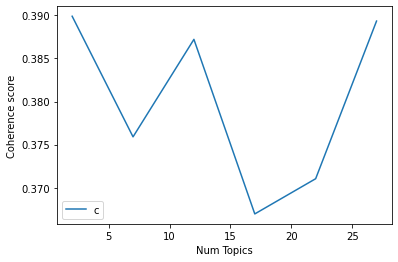

In [135]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [136]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.3899
index: 1 | Num Topics = 7  has Coherence Value of 0.3759
index: 2 | Num Topics = 12  has Coherence Value of 0.3872
index: 3 | Num Topics = 17  has Coherence Value of 0.367
index: 4 | Num Topics = 22  has Coherence Value of 0.3711
index: 5 | Num Topics = 27  has Coherence Value of 0.3893


In [137]:
# Select optimal number of topics
optimal_model_ph_score1N2N3 = model_list_ph_score1N2N3[2]

In [138]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score1N2N3, corpus_ph_score1N2N3, id2word_ph_score1N2N3)

In [139]:
print("pyLDAVis for ph topics for score=1,2,3:")
vis_ph_score1N2N3

pyLDAVis for ph topics for score=1,2,3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.231833 -0.132578       1        1  12.891584
3     -0.112247 -0.138625       2        1  12.700242
6      0.068132 -0.033121       3        1  12.283618
7     -0.062622 -0.069412       4        1   9.861243
5     -0.107798 -0.041359       5        1   9.669015
8     -0.131311  0.062711       6        1   8.826790
2     -0.069576  0.006442       7        1   7.982111
0      0.094720  0.091998       8        1   7.191018
11     0.053701  0.115166       9        1   6.811340
4      0.006283 -0.020192      10        1   5.426657
1      0.003760  0.068145      11        1   3.569339
9      0.025125  0.090824      12        1   2.787041, topic_info=         Term        Freq       Total Category  logprob  loglift
24     update  135.000000  135.000000  Default  30.0000  30.0000
64        new   68.000000   68.000000  Default  29.0000  29.0000
34     filter  112.000000  112.000000  Default  28.0000  28.0000
442       log   64.000000   64.000000  Default  27.0000  27.0000
7        open   56.000000   56.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
22   annoying    0.847343   14.978558  Topic12  -5.2464   0.7079
230     cause    0.828375   12.609876  Topic12  -5.2690   0.8574
800   restart    0.809728    6.486674  Topic12  -5.2918   1.4994
109    change    0.824703   39.205384  Topic12  -5.2735  -0.2814
121      time    0.796830   48.307621  Topic12  -5.3079  -0.5245

[765 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
898       2  0.771850     able
742       9  0.898022   accept
252       3  0.122614   access
252       4  0.122614   access
252       5  0.245228   access
...     ...       ...      ...
762       2  0.771866  youtube
802       7  0.596225       yr
561       1  0.702334     zoom
561       4  0.117056     zoom
561      11  0.117056     zoom

[1287 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 4, 7, 8, 6, 9, 3, 1, 12, 5, 2, 10])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [140]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_ph_2018_score1N2N3 = snapchat_ios_ph_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_ph_2018_score1N2N3 = list(sent_to_words(review_ph_2018_score1N2N3))
print(review_words_ph_2018_score1N2N3[:1])

[['really', 'like', 'snapchat', 'but', 'it', 'messed', 'up', 'my', 'phone', 'everytime', 'and', 'dont', 'know', 'why', 'but', 'everytime', 'open', 'it', 'while', 'im', 'at', 'my', 'phone', 'randomly', 'shut', 'down', 'even', 'if', 'open', 'different', 'apps', 'it', 'shut', 'downs', 'randomly', 'but', 'when', 'deleted', 'it', 'everything', 'is', 'normal', 'don', 'know', 'why', 'this', 'happen']]


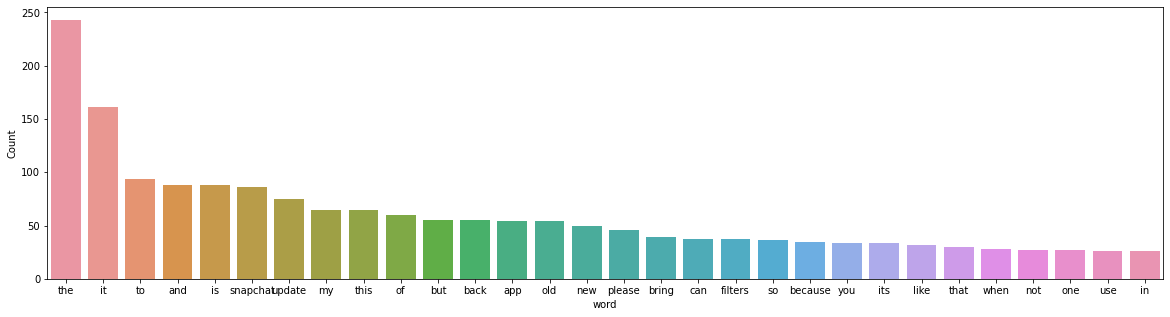

In [141]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2018_score1N2N3))

In [142]:
# Clean text
review_words_ph_ready_2018_score1N2N3 = process_words(review_words_ph_2018_score1N2N3)  # processed Text Data! - move to each section

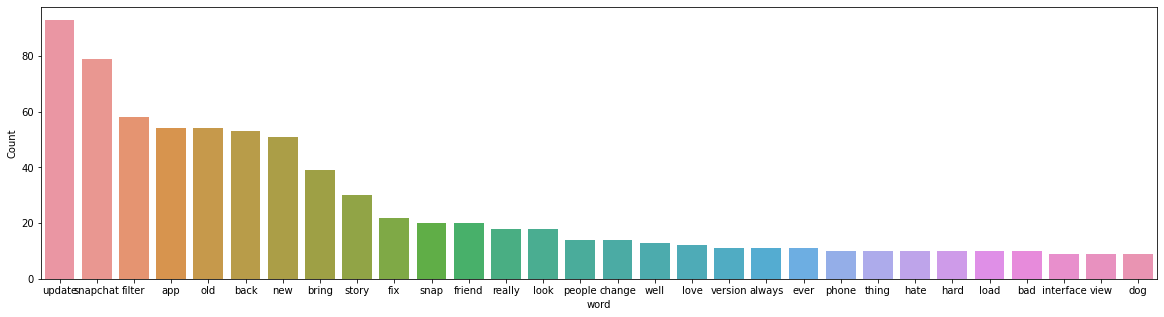

In [143]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2018_score1N2N3))


In [144]:
# Create Dictionary
id2word_ph_2018_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2018_score1N2N3)

2021-10-16 21:02:15,761 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 21:02:15,770 [INFO] gensim.corpora.dictionary - built Dictionary(513 unique tokens: ['app', 'delete', 'different', 'everytime', 'happen']...) from 158 documents (total 1696 corpus positions)
2021-10-16 21:02:15,775 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(513 unique tokens: ['app', 'delete', 'different', 'everytime', 'happen']...) from 158 documents (total 1696 corpus positions)", 'datetime': '2021-10-16T21:02:15.775378', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [145]:
# Create Corpus: Term Document Frequency
corpus_ph_2018_score1N2N3 = [id2word_ph_2018_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2018_score1N2N3]

In [146]:
# Training LDA model
model_list_ph_2018_score1N2N3, coherence_values_ph_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2018_score1N2N3, corpus=corpus_ph_2018_score1N2N3, 
                                                              texts=review_words_ph_ready_2018_score1N2N3, limit=30, start=2, step=5)


2021-10-16 21:02:15,815 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 21:02:15,817 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 21:02:15,881 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 21:02:15,945 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 158 documents, updating model once every 158 documents, evaluating perplexity every 158 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 21:02:16,505 [INFO] gensim.models.ldamodel - -6.884 per-word bound, 118.1 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:02:16,506 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #158/158
2021-10-16 21:02:17,085 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"update" + 0.043*"filter" + 0.038*"snapchat" + 0.030*"new" + 0.021*"old" + 0.017*"story" + 0.015*"

2021-10-16 21:02:22,535 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"app" + 0.040*"update" + 0.036*"back" + 0.033*"old" + 0.030*"snapchat" + 0.027*"bring" + 0.015*"fix" + 0.014*"new" + 0.011*"snap" + 0.011*"version"
2021-10-16 21:02:22,565 [INFO] gensim.models.ldamodel - topic diff=0.012914, rho=0.301511
2021-10-16 21:02:22,783 [INFO] gensim.models.ldamodel - -5.746 per-word bound, 53.7 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:02:22,785 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #158/158
2021-10-16 21:02:23,083 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"filter" + 0.045*"update" + 0.043*"snapchat" + 0.033*"new" + 0.022*"story" + 0.017*"old" + 0.015*"look" + 0.015*"friend" + 0.014*"back" + 0.013*"really"
2021-10-16 21:02:23,085 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"app" + 0.040*"update" + 0.036*"back" + 0.033*"old" + 0.029*"snapchat" + 0.027*"bring" + 0.016*"fix" + 0.014*

2021-10-16 21:02:27,919 [INFO] gensim.models.ldamodel - topic diff=0.004464, rho=0.218218
2021-10-16 21:02:28,202 [INFO] gensim.models.ldamodel - -5.740 per-word bound, 53.5 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:02:28,203 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #158/158
2021-10-16 21:02:28,392 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"filter" + 0.045*"update" + 0.044*"snapchat" + 0.034*"new" + 0.023*"story" + 0.019*"old" + 0.015*"friend" + 0.015*"look" + 0.014*"really" + 0.014*"back"
2021-10-16 21:02:28,395 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"app" + 0.040*"update" + 0.036*"back" + 0.032*"old" + 0.028*"snapchat" + 0.028*"bring" + 0.016*"fix" + 0.013*"new" + 0.011*"snap" + 0.011*"version"
2021-10-16 21:02:28,400 [INFO] gensim.models.ldamodel - topic diff=0.004307, rho=0.213201
2021-10-16 21:02:28,720 [INFO] gensim.models.ldamodel - -5.740 per-word bound, 53.4 perplexity esti

2021-10-16 21:02:33,375 [INFO] gensim.models.ldamodel - -5.738 per-word bound, 53.4 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:02:33,376 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #158/158
2021-10-16 21:02:33,592 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"filter" + 0.045*"update" + 0.044*"snapchat" + 0.034*"new" + 0.024*"story" + 0.019*"old" + 0.016*"friend" + 0.015*"really" + 0.015*"back" + 0.014*"look"
2021-10-16 21:02:33,595 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"app" + 0.040*"update" + 0.035*"back" + 0.031*"old" + 0.028*"snapchat" + 0.027*"bring" + 0.016*"fix" + 0.012*"new" + 0.011*"version" + 0.011*"snap"
2021-10-16 21:02:33,596 [INFO] gensim.models.ldamodel - topic diff=0.002310, rho=0.176777
2021-10-16 21:02:33,846 [INFO] gensim.models.ldamodel - -5.738 per-word bound, 53.4 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:02:33,847 [

2021-10-16 21:02:38,385 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #158/158
2021-10-16 21:02:38,587 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"filter" + 0.045*"update" + 0.044*"snapchat" + 0.035*"new" + 0.025*"story" + 0.020*"old" + 0.016*"friend" + 0.015*"really" + 0.015*"back" + 0.014*"look"
2021-10-16 21:02:38,591 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"app" + 0.040*"update" + 0.035*"back" + 0.030*"old" + 0.028*"snapchat" + 0.027*"bring" + 0.016*"fix" + 0.012*"new" + 0.011*"version" + 0.011*"snap"
2021-10-16 21:02:38,598 [INFO] gensim.models.ldamodel - topic diff=0.001901, rho=0.154303
2021-10-16 21:02:38,927 [INFO] gensim.models.ldamodel - -5.736 per-word bound, 53.3 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:02:38,933 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #158/158
2021-10-16 21:02:39,102 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"filter" + 0.

2021-10-16 21:02:43,097 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 21:02:47,924 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 21:02:47,955 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 149 virtual documents
2021-10-16 21:02:48,300 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 21:02:48,302 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 21:02:48,311 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 21:02:48,320 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 158 documents, updating model once every 158 documents, evaluating perplexity every 158 documents, iterating 50x with a con

2021-10-16 21:02:50,872 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.078*"filter" + 0.062*"back" + 0.060*"bring" + 0.058*"old" + 0.054*"snapchat" + 0.024*"look" + 0.013*"app" + 0.011*"boy" + 0.011*"new" + 0.011*"slow"
2021-10-16 21:02:50,875 [INFO] gensim.models.ldamodel - topic diff=0.069489, rho=0.408248
2021-10-16 21:02:51,118 [INFO] gensim.models.ldamodel - -5.998 per-word bound, 63.9 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:02:51,122 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #158/158
2021-10-16 21:02:51,266 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.050*"app" + 0.028*"update" + 0.024*"fix" + 0.024*"memory" + 0.017*"snapchat" + 0.016*"way" + 0.016*"filter" + 0.013*"old" + 0.013*"really" + 0.013*"load"
2021-10-16 21:02:51,272 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.072*"app" + 0.041*"update" + 0.019*"phone" + 0.019*"open" + 0.016*"new" + 0.016*"whenever" + 0.015*"outfit" + 0.015*"eve

2021-10-16 21:02:53,281 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.085*"update" + 0.055*"new" + 0.048*"snapchat" + 0.024*"back" + 0.023*"change" + 0.023*"story" + 0.021*"old" + 0.021*"really" + 0.015*"friend" + 0.015*"hate"
2021-10-16 21:02:53,283 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"story" + 0.037*"snapchat" + 0.036*"friend" + 0.036*"update" + 0.024*"fix" + 0.024*"new" + 0.020*"view" + 0.017*"ever" + 0.016*"snap" + 0.013*"filter"
2021-10-16 21:02:53,284 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.063*"filter" + 0.039*"update" + 0.037*"app" + 0.022*"snapchat" + 0.020*"io" + 0.018*"dog" + 0.018*"always" + 0.015*"fix" + 0.014*"turn" + 0.014*"datum"
2021-10-16 21:02:53,286 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.076*"filter" + 0.070*"back" + 0.065*"old" + 0.064*"bring" + 0.055*"snapchat" + 0.023*"look" + 0.013*"new" + 0.013*"app" + 0.011*"snap" + 0.011*"boy"
2021-10-16 21:02:53,290 [INFO] gensim.models.ldamodel - topic diff=0.015098, rho=0.

2021-10-16 21:02:55,466 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.048*"story" + 0.037*"snapchat" + 0.035*"update" + 0.032*"friend" + 0.025*"fix" + 0.023*"new" + 0.016*"view" + 0.016*"ever" + 0.014*"snap" + 0.013*"filter"
2021-10-16 21:02:55,467 [INFO] gensim.models.ldamodel - topic diff=0.006572, rho=0.242536
2021-10-16 21:02:55,681 [INFO] gensim.models.ldamodel - -5.967 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:02:55,705 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #158/158
2021-10-16 21:02:55,837 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.048*"story" + 0.037*"snapchat" + 0.035*"update" + 0.032*"friend" + 0.025*"fix" + 0.022*"new" + 0.016*"view" + 0.016*"ever" + 0.014*"snap" + 0.013*"filter"
2021-10-16 21:02:55,838 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.087*"update" + 0.057*"new" + 0.048*"snapchat" + 0.023*"back" + 0.022*"change" + 0.022*"story" + 0.022*"old" + 0.

2021-10-16 21:02:57,697 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.062*"filter" + 0.040*"app" + 0.036*"update" + 0.021*"snapchat" + 0.021*"io" + 0.018*"always" + 0.018*"dog" + 0.016*"fix" + 0.014*"turn" + 0.014*"datum"
2021-10-16 21:02:57,706 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.072*"app" + 0.041*"update" + 0.020*"phone" + 0.020*"open" + 0.016*"whenever" + 0.016*"everytime" + 0.016*"outfit" + 0.016*"bad" + 0.013*"new" + 0.012*"happen"
2021-10-16 21:02:57,716 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.048*"story" + 0.037*"snapchat" + 0.034*"update" + 0.029*"friend" + 0.025*"fix" + 0.021*"new" + 0.015*"ever" + 0.015*"view" + 0.014*"snap" + 0.013*"filter"
2021-10-16 21:02:57,725 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.075*"filter" + 0.074*"back" + 0.068*"bring" + 0.068*"old" + 0.055*"snapchat" + 0.022*"look" + 0.015*"new" + 0.013*"app" + 0.012*"update" + 0.011*"snap"
2021-10-16 21:02:57,732 [INFO] gensim.models.ldamodel - topic diff=0.003474, r

2021-10-16 21:02:59,825 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.051*"snapchat" + 0.047*"old" + 0.037*"update" + 0.032*"back" + 0.024*"new" + 0.023*"snap" + 0.023*"people" + 0.023*"interface" + 0.019*"version" + 0.015*"bring"
2021-10-16 21:02:59,827 [INFO] gensim.models.ldamodel - topic diff=0.002759, rho=0.188982
2021-10-16 21:03:00,053 [INFO] gensim.models.ldamodel - -5.963 per-word bound, 62.4 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:00,056 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #158/158
2021-10-16 21:03:00,160 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.088*"update" + 0.059*"new" + 0.047*"snapchat" + 0.025*"really" + 0.022*"back" + 0.022*"story" + 0.022*"change" + 0.021*"old" + 0.020*"friend" + 0.015*"hate"
2021-10-16 21:03:00,162 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.048*"story" + 0.036*"snapchat" + 0.034*"update" + 0.026*"friend" + 0.025*"fix" + 0.020*"new" + 0.015*"ev

2021-10-16 21:03:02,527 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.051*"snapchat" + 0.046*"old" + 0.037*"update" + 0.030*"back" + 0.023*"new" + 0.023*"snap" + 0.023*"people" + 0.023*"interface" + 0.019*"version" + 0.016*"story"
2021-10-16 21:03:02,530 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"filter" + 0.040*"app" + 0.036*"update" + 0.021*"io" + 0.021*"snapchat" + 0.019*"always" + 0.017*"dog" + 0.016*"fix" + 0.014*"turn" + 0.014*"datum"
2021-10-16 21:03:02,534 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.076*"filter" + 0.075*"back" + 0.070*"bring" + 0.069*"old" + 0.054*"snapchat" + 0.022*"look" + 0.015*"new" + 0.013*"app" + 0.013*"update" + 0.011*"snap"
2021-10-16 21:03:02,537 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.088*"update" + 0.059*"new" + 0.047*"snapchat" + 0.026*"really" + 0.022*"story" + 0.022*"back" + 0.022*"change" + 0.021*"old" + 0.021*"friend" + 0.015*"hate"
2021-10-16 21:03:02,540 [INFO] gensim.models.ldamodel - topic diff=0.00189

2021-10-16 21:03:05,051 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.088*"update" + 0.059*"new" + 0.047*"snapchat" + 0.027*"really" + 0.022*"story" + 0.022*"back" + 0.022*"change" + 0.022*"friend" + 0.021*"old" + 0.015*"hate"
2021-10-16 21:03:05,055 [INFO] gensim.models.ldamodel - topic diff=0.001372, rho=0.160128
2021-10-16 21:03:05,368 [INFO] gensim.models.ldamodel - -5.959 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:05,374 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #158/158
2021-10-16 21:03:05,516 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"app" + 0.026*"memory" + 0.025*"fix" + 0.022*"update" + 0.017*"snapchat" + 0.017*"filter" + 0.016*"way" + 0.015*"save" + 0.013*"old" + 0.013*"well"
2021-10-16 21:03:05,519 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.088*"update" + 0.059*"new" + 0.047*"snapchat" + 0.027*"really" + 0.022*"story" + 0.022*"back" + 0.022*"friend" + 

2021-10-16 21:03:07,826 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.060*"filter" + 0.040*"app" + 0.035*"update" + 0.021*"io" + 0.020*"snapchat" + 0.019*"always" + 0.017*"dog" + 0.016*"fix" + 0.014*"turn" + 0.014*"datum"
2021-10-16 21:03:07,830 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"app" + 0.026*"memory" + 0.025*"fix" + 0.022*"update" + 0.017*"snapchat" + 0.017*"filter" + 0.016*"way" + 0.015*"save" + 0.013*"old" + 0.013*"well"
2021-10-16 21:03:07,831 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"story" + 0.036*"snapchat" + 0.033*"update" + 0.025*"fix" + 0.022*"friend" + 0.018*"new" + 0.015*"ever" + 0.014*"snap" + 0.014*"well" + 0.014*"load"
2021-10-16 21:03:07,833 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.088*"update" + 0.060*"new" + 0.047*"snapchat" + 0.027*"really" + 0.023*"story" + 0.022*"friend" + 0.022*"back" + 0.021*"change" + 0.021*"old" + 0.015*"hate"
2021-10-16 21:03:07,834 [INFO] gensim.models.ldamodel - topic diff=0.000896, rho=0

2021-10-16 21:03:09,738 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.071*"app" + 0.041*"update" + 0.020*"phone" + 0.020*"open" + 0.016*"whenever" + 0.016*"bad" + 0.016*"everytime" + 0.016*"outfit" + 0.013*"new" + 0.012*"happen"
2021-10-16 21:03:09,739 [INFO] gensim.models.ldamodel - topic diff=0.000591, rho=0.141421
2021-10-16 21:03:09,960 [INFO] gensim.models.ldamodel - -5.958 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:09,962 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #158/158
2021-10-16 21:03:10,078 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.088*"update" + 0.060*"new" + 0.047*"snapchat" + 0.027*"really" + 0.023*"story" + 0.022*"friend" + 0.022*"back" + 0.021*"change" + 0.021*"old" + 0.015*"hate"
2021-10-16 21:03:10,083 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.046*"story" + 0.036*"snapchat" + 0.033*"update" + 0.026*"fix" + 0.021*"friend" + 0.018*"new" + 0.015*"ever

2021-10-16 21:03:17,877 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.043*"snapchat" + 0.031*"filter" + 0.030*"ipad" + 0.030*"fix" + 0.023*"update" + 0.020*"story" + 0.016*"sc" + 0.016*"end" + 0.016*"ever" + 0.015*"well"
2021-10-16 21:03:17,879 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.083*"app" + 0.069*"update" + 0.024*"new" + 0.021*"bad" + 0.020*"time" + 0.020*"change" + 0.020*"thing" + 0.020*"open" + 0.013*"happen" + 0.013*"layout"
2021-10-16 21:03:17,880 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.048*"update" + 0.045*"friend" + 0.045*"new" + 0.032*"snapchat" + 0.030*"story" + 0.024*"filter" + 0.024*"view" + 0.021*"snap" + 0.013*"really" + 0.013*"ever"
2021-10-16 21:03:17,882 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.069*"filter" + 0.061*"look" + 0.049*"snapchat" + 0.038*"back" + 0.038*"old" + 0.031*"bring" + 0.027*"boy" + 0.021*"app" + 0.021*"weird" + 0.015*"update"
2021-10-16 21:03:17,884 [INFO] gensim.models.ldamodel - topic diff=0.081127, rho=

2021-10-16 21:03:19,759 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.064*"filter" + 0.043*"outfit" + 0.022*"app" + 0.022*"add" + 0.022*"continue" + 0.012*"favorite" + 0.012*"original" + 0.012*"always" + 0.012*"remove" + 0.012*"feature"
2021-10-16 21:03:19,763 [INFO] gensim.models.ldamodel - topic diff=0.021102, rho=0.316228
2021-10-16 21:03:19,981 [INFO] gensim.models.ldamodel - -6.124 per-word bound, 69.8 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:19,982 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #158/158
2021-10-16 21:03:20,083 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.064*"filter" + 0.044*"outfit" + 0.022*"app" + 0.022*"add" + 0.022*"continue" + 0.012*"favorite" + 0.012*"original" + 0.012*"always" + 0.012*"remove" + 0.012*"feature"
2021-10-16 21:03:20,103 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.045*"app" + 0.041*"update" + 0.032*"interface" + 0.026*"download" + 0.025*"story" + 0.024

2021-10-16 21:03:21,972 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.107*"back" + 0.100*"old" + 0.082*"bring" + 0.063*"update" + 0.058*"new" + 0.043*"snapchat" + 0.027*"really" + 0.023*"version" + 0.020*"hate" + 0.017*"confuse"
2021-10-16 21:03:21,974 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.070*"filter" + 0.063*"look" + 0.049*"snapchat" + 0.035*"old" + 0.034*"back" + 0.029*"boy" + 0.027*"bring" + 0.022*"weird" + 0.020*"app" + 0.015*"snap"
2021-10-16 21:03:21,975 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.048*"friend" + 0.041*"new" + 0.040*"update" + 0.034*"story" + 0.033*"snapchat" + 0.026*"view" + 0.026*"filter" + 0.022*"snap" + 0.013*"really" + 0.013*"ever"
2021-10-16 21:03:21,976 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.048*"app" + 0.041*"update" + 0.033*"interface" + 0.027*"download" + 0.025*"story" + 0.022*"whenever" + 0.022*"new" + 0.020*"fix" + 0.017*"battery" + 0.017*"problem"
2021-10-16 21:03:21,977 [INFO] gensim.models.ldamodel - topic

2021-10-16 21:03:23,604 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.073*"filter" + 0.066*"look" + 0.049*"snapchat" + 0.031*"old" + 0.030*"boy" + 0.029*"back" + 0.022*"weird" + 0.022*"bring" + 0.017*"app" + 0.015*"snap"
2021-10-16 21:03:23,607 [INFO] gensim.models.ldamodel - topic diff=0.005042, rho=0.218218
2021-10-16 21:03:23,817 [INFO] gensim.models.ldamodel - -6.107 per-word bound, 69.0 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:23,819 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #158/158
2021-10-16 21:03:24,010 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.073*"snapchat" + 0.054*"update" + 0.028*"story" + 0.028*"delete" + 0.019*"well" + 0.019*"great" + 0.019*"fast" + 0.011*"old" + 0.010*"people" + 0.010*"mean"
2021-10-16 21:03:24,013 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.052*"app" + 0.027*"way" + 0.027*"memory" + 0.023*"really" + 0.023*"fix" + 0.020*"love" + 0.020*"old" + 0.020*"snap

2021-10-16 21:03:25,727 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.088*"app" + 0.080*"update" + 0.026*"bad" + 0.020*"new" + 0.019*"change" + 0.019*"thing" + 0.019*"time" + 0.019*"open" + 0.019*"still" + 0.013*"happen"
2021-10-16 21:03:25,728 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.075*"filter" + 0.045*"update" + 0.036*"snapchat" + 0.035*"app" + 0.023*"io" + 0.019*"hope" + 0.019*"late" + 0.016*"fix" + 0.016*"turn" + 0.014*"dog"
2021-10-16 21:03:25,737 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"update" + 0.055*"snapchat" + 0.043*"new" + 0.028*"change" + 0.024*"story" + 0.020*"back" + 0.020*"old" + 0.016*"find" + 0.016*"look" + 0.016*"like"
2021-10-16 21:03:25,740 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.110*"back" + 0.103*"old" + 0.086*"bring" + 0.063*"update" + 0.057*"new" + 0.045*"snapchat" + 0.026*"really" + 0.022*"version" + 0.019*"hate" + 0.017*"snap"
2021-10-16 21:03:25,744 [INFO] gensim.models.ldamodel - topic diff=0.002796, rho=0.192

2021-10-16 21:03:27,498 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.075*"filter" + 0.045*"update" + 0.036*"snapchat" + 0.035*"app" + 0.023*"io" + 0.019*"hope" + 0.019*"late" + 0.016*"fix" + 0.016*"turn" + 0.014*"dog"
2021-10-16 21:03:27,499 [INFO] gensim.models.ldamodel - topic diff=0.001879, rho=0.176777
2021-10-16 21:03:27,651 [INFO] gensim.models.ldamodel - -6.099 per-word bound, 68.5 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:27,653 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #158/158
2021-10-16 21:03:27,835 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.088*"app" + 0.080*"update" + 0.026*"bad" + 0.019*"new" + 0.019*"change" + 0.019*"thing" + 0.019*"open" + 0.019*"time" + 0.019*"still" + 0.013*"happen"
2021-10-16 21:03:27,839 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.055*"app" + 0.041*"update" + 0.033*"interface" + 0.028*"download" + 0.026*"story" + 0.022*"whenever" + 0.021*"fix" + 0.020

2021-10-16 21:03:29,629 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.044*"snapchat" + 0.032*"filter" + 0.032*"fix" + 0.032*"ipad" + 0.017*"end" + 0.017*"sc" + 0.017*"well" + 0.017*"message" + 0.017*"ever" + 0.017*"bad"
2021-10-16 21:03:29,632 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.074*"snapchat" + 0.055*"update" + 0.028*"story" + 0.028*"delete" + 0.019*"well" + 0.019*"great" + 0.019*"fast" + 0.011*"old" + 0.010*"slow" + 0.010*"people"
2021-10-16 21:03:29,634 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.075*"filter" + 0.045*"update" + 0.036*"snapchat" + 0.035*"app" + 0.023*"io" + 0.019*"hope" + 0.019*"late" + 0.016*"fix" + 0.016*"turn" + 0.014*"dog"
2021-10-16 21:03:29,636 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.048*"friend" + 0.041*"new" + 0.040*"update" + 0.035*"story" + 0.032*"snapchat" + 0.026*"view" + 0.025*"filter" + 0.023*"snap" + 0.013*"really" + 0.013*"ever"
2021-10-16 21:03:29,638 [INFO] gensim.models.ldamodel - topic diff=0.001139, rho=

2021-10-16 21:03:31,480 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"app" + 0.027*"memory" + 0.027*"way" + 0.023*"really" + 0.023*"fix" + 0.021*"thing" + 0.021*"load" + 0.021*"old" + 0.021*"love" + 0.021*"snapchat"
2021-10-16 21:03:31,482 [INFO] gensim.models.ldamodel - topic diff=0.000758, rho=0.152499
2021-10-16 21:03:31,666 [INFO] gensim.models.ldamodel - -6.096 per-word bound, 68.4 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:31,672 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #158/158
2021-10-16 21:03:31,798 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"app" + 0.027*"memory" + 0.027*"way" + 0.023*"really" + 0.023*"fix" + 0.021*"thing" + 0.021*"load" + 0.021*"old" + 0.021*"love" + 0.021*"snapchat"
2021-10-16 21:03:31,800 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.072*"filter" + 0.043*"outfit" + 0.022*"add" + 0.022*"continue" + 0.022*"app" + 0.022*"remove" + 0.011*"feature" + 0.011*

2021-10-16 21:03:33,601 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"update" + 0.055*"snapchat" + 0.043*"new" + 0.028*"change" + 0.024*"story" + 0.020*"back" + 0.020*"old" + 0.016*"find" + 0.016*"look" + 0.016*"like"
2021-10-16 21:03:33,604 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.044*"snapchat" + 0.032*"fix" + 0.032*"filter" + 0.032*"ipad" + 0.017*"message" + 0.017*"end" + 0.017*"well" + 0.017*"sc" + 0.017*"ever" + 0.017*"bad"
2021-10-16 21:03:33,605 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.057*"snapchat" + 0.040*"update" + 0.038*"filter" + 0.016*"fix" + 0.016*"story" + 0.016*"one" + 0.016*"work" + 0.016*"anymore" + 0.016*"view" + 0.016*"issue"
2021-10-16 21:03:33,606 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.075*"filter" + 0.045*"update" + 0.036*"snapchat" + 0.035*"app" + 0.023*"io" + 0.021*"hope" + 0.019*"late" + 0.016*"fix" + 0.016*"turn" + 0.014*"dog"
2021-10-16 21:03:33,607 [INFO] gensim.models.ldamodel - topic diff=0.001002, rho=0.1428

2021-10-16 21:03:42,622 [INFO] gensim.models.ldamodel - topic diff=0.147787, rho=0.577350
2021-10-16 21:03:42,884 [INFO] gensim.models.ldamodel - -6.388 per-word bound, 83.8 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:42,885 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #158/158
2021-10-16 21:03:43,071 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.074*"update" + 0.067*"new" + 0.050*"friend" + 0.036*"story" + 0.031*"snapchat" + 0.024*"view" + 0.021*"ever" + 0.018*"like" + 0.018*"snap" + 0.017*"hate"
2021-10-16 21:03:43,074 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.043*"back" + 0.041*"number" + 0.041*"phone" + 0.037*"change" + 0.027*"bring" + 0.027*"old" + 0.025*"new" + 0.021*"log" + 0.021*"password" + 0.021*"help"
2021-10-16 21:03:43,078 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.062*"app" + 0.045*"update" + 0.040*"filter" + 0.035*"new" + 0.033*"fix" + 0.022*"happen" + 0.022*"whenever" + 0.0

2021-10-16 21:03:44,871 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.055*"update" + 0.050*"snapchat" + 0.037*"story" + 0.034*"new" + 0.030*"filter" + 0.020*"hard" + 0.020*"back" + 0.016*"find" + 0.016*"friend" + 0.016*"look"
2021-10-16 21:03:44,874 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.055*"look" + 0.036*"app" + 0.034*"filter" + 0.032*"snapchat" + 0.031*"phone" + 0.025*"boy" + 0.019*"sometimes" + 0.019*"open" + 0.019*"everytime" + 0.019*"thing"
2021-10-16 21:03:44,875 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.117*"update" + 0.065*"app" + 0.031*"snapchat" + 0.029*"bad" + 0.023*"new" + 0.022*"old" + 0.021*"back" + 0.016*"fun" + 0.016*"fix" + 0.016*"face"
2021-10-16 21:03:44,878 [INFO] gensim.models.ldamodel - topic diff=0.031480, rho=0.333333
2021-10-16 21:03:45,027 [INFO] gensim.models.ldamodel - -6.274 per-word bound, 77.4 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:45,029 [INFO] gensim.models.ldamode

2021-10-16 21:03:46,680 [INFO] gensim.models.ldamodel - topic diff=0.013176, rho=0.267261
2021-10-16 21:03:46,880 [INFO] gensim.models.ldamodel - -6.251 per-word bound, 76.2 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:46,881 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #158/158
2021-10-16 21:03:46,954 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.056*"look" + 0.034*"app" + 0.033*"filter" + 0.032*"phone" + 0.031*"snapchat" + 0.025*"boy" + 0.019*"sometimes" + 0.019*"everytime" + 0.019*"open" + 0.019*"thing"
2021-10-16 21:03:46,956 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.058*"update" + 0.046*"snapchat" + 0.031*"old" + 0.027*"really" + 0.026*"filter" + 0.022*"people" + 0.020*"snap" + 0.019*"new" + 0.016*"well" + 0.011*"delete"
2021-10-16 21:03:46,957 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.047*"app" + 0.036*"snap" + 0.027*"old" + 0.024*"fix" + 0.024*"way" + 0.024*"love" + 0.024*"filter" +

2021-10-16 21:03:48,806 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.088*"filter" + 0.058*"snapchat" + 0.047*"update" + 0.031*"hope" + 0.023*"app" + 0.016*"fix" + 0.016*"company" + 0.016*"click" + 0.016*"button" + 0.008*"way"
2021-10-16 21:03:48,809 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.059*"outfit" + 0.044*"update" + 0.030*"messy" + 0.030*"new" + 0.030*"offline" + 0.015*"thing" + 0.015*"add" + 0.015*"love" + 0.015*"job" + 0.015*"artist"
2021-10-16 21:03:48,811 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.130*"update" + 0.076*"app" + 0.032*"bad" + 0.026*"snapchat" + 0.024*"annoying" + 0.016*"fun" + 0.016*"fix" + 0.016*"face" + 0.016*"seriously" + 0.016*"complicate"
2021-10-16 21:03:48,812 [INFO] gensim.models.ldamodel - topic diff=0.006563, rho=0.223607
2021-10-16 21:03:48,942 [INFO] gensim.models.ldamodel - -6.236 per-word bound, 75.4 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:48,943 [INFO] gensim.model

2021-10-16 21:03:50,395 [INFO] gensim.models.ldamodel - topic diff=0.004085, rho=0.200000
2021-10-16 21:03:50,601 [INFO] gensim.models.ldamodel - -6.226 per-word bound, 74.9 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:50,602 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #158/158
2021-10-16 21:03:50,774 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.044*"app" + 0.041*"turn" + 0.038*"update" + 0.028*"io" + 0.028*"filter" + 0.025*"datum" + 0.025*"fix" + 0.025*"wait" + 0.025*"always" + 0.025*"snap"
2021-10-16 21:03:50,780 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.063*"app" + 0.045*"time" + 0.031*"crash" + 0.031*"keep" + 0.031*"still" + 0.031*"iphone" + 0.016*"message" + 0.016*"update" + 0.016*"uninstall" + 0.016*"install"
2021-10-16 21:03:50,787 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.055*"app" + 0.051*"update" + 0.039*"filter" + 0.034*"fix" + 0.030*"new" + 0.023*"whenever" + 0.023*"really" + 

2021-10-16 21:03:52,594 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.048*"app" + 0.036*"snap" + 0.027*"old" + 0.024*"fix" + 0.024*"way" + 0.024*"love" + 0.024*"filter" + 0.024*"really" + 0.024*"people" + 0.024*"follow"
2021-10-16 21:03:52,597 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.072*"snapchat" + 0.052*"interface" + 0.028*"update" + 0.026*"change" + 0.024*"story" + 0.018*"fast" + 0.018*"always" + 0.018*"well" + 0.018*"load" + 0.018*"page"
2021-10-16 21:03:52,599 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.059*"outfit" + 0.044*"update" + 0.030*"new" + 0.030*"messy" + 0.030*"offline" + 0.015*"thing" + 0.015*"artist" + 0.015*"add" + 0.015*"love" + 0.015*"job"
2021-10-16 21:03:52,601 [INFO] gensim.models.ldamodel - topic diff=0.002547, rho=0.179605
2021-10-16 21:03:52,844 [INFO] gensim.models.ldamodel - -6.221 per-word bound, 74.6 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:52,846 [INFO] gensim.models.ldamod

2021-10-16 21:03:54,357 [INFO] gensim.models.ldamodel - topic diff=0.001581, rho=0.166667
2021-10-16 21:03:54,516 [INFO] gensim.models.ldamodel - -6.219 per-word bound, 74.5 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:54,519 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #158/158
2021-10-16 21:03:54,712 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.083*"new" + 0.080*"update" + 0.057*"friend" + 0.043*"story" + 0.028*"view" + 0.028*"hate" + 0.028*"snapchat" + 0.022*"snap" + 0.020*"like" + 0.017*"version"
2021-10-16 21:03:54,713 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.056*"look" + 0.034*"app" + 0.033*"filter" + 0.032*"phone" + 0.031*"snapchat" + 0.025*"boy" + 0.019*"sometimes" + 0.019*"everytime" + 0.019*"open" + 0.019*"thing"
2021-10-16 21:03:54,715 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.043*"app" + 0.042*"turn" + 0.038*"update" + 0.028*"io" + 0.026*"filter" + 0.025*"datum" + 0.025*"fix"

2021-10-16 21:03:56,389 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.060*"update" + 0.046*"snapchat" + 0.028*"really" + 0.027*"filter" + 0.023*"people" + 0.021*"snap" + 0.017*"well" + 0.015*"new" + 0.012*"delete" + 0.012*"anymore"
2021-10-16 21:03:56,391 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.047*"phone" + 0.047*"number" + 0.047*"change" + 0.024*"help" + 0.024*"log" + 0.024*"password" + 0.024*"forgot" + 0.024*"dog" + 0.024*"effect" + 0.024*"hate"
2021-10-16 21:03:56,392 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.047*"app" + 0.039*"download" + 0.031*"snapchat" + 0.030*"fix" + 0.030*"problem" + 0.020*"hour" + 0.020*"whenever" + 0.020*"redownloade" + 0.020*"sticker" + 0.020*"love"
2021-10-16 21:03:56,393 [INFO] gensim.models.ldamodel - topic diff=0.000758, rho=0.154303
2021-10-16 21:03:56,601 [INFO] gensim.models.ldamodel - -6.219 per-word bound, 74.5 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:56,603 [INF

2021-10-16 21:03:58,065 [INFO] gensim.models.ldamodel - topic diff=0.000377, rho=0.145865
2021-10-16 21:03:58,187 [INFO] gensim.models.ldamodel - -6.219 per-word bound, 74.5 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:03:58,188 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #158/158
2021-10-16 21:03:58,359 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.059*"outfit" + 0.044*"update" + 0.030*"new" + 0.030*"messy" + 0.030*"offline" + 0.015*"add" + 0.015*"love" + 0.015*"job" + 0.015*"basic" + 0.015*"work"
2021-10-16 21:03:58,361 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.063*"app" + 0.045*"time" + 0.031*"crash" + 0.031*"still" + 0.031*"keep" + 0.031*"iphone" + 0.016*"update" + 0.016*"handphone" + 0.016*"everytime" + 0.016*"heating"
2021-10-16 21:03:58,362 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.048*"app" + 0.036*"snap" + 0.026*"old" + 0.024*"way" + 0.024*"fix" + 0.024*"love" + 0.024*"filter" + 0.024

2021-10-16 21:04:08,489 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.052*"back" + 0.027*"boi" + 0.027*"decide" + 0.027*"new" + 0.027*"problem" + 0.027*"app" + 0.027*"confuse" + 0.027*"turn" + 0.027*"update" + 0.027*"save"
2021-10-16 21:04:08,491 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.063*"filter" + 0.057*"update" + 0.044*"app" + 0.040*"snapchat" + 0.027*"hope" + 0.014*"well" + 0.014*"company" + 0.014*"story" + 0.014*"time" + 0.014*"bad"
2021-10-16 21:04:08,492 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.070*"filter" + 0.056*"update" + 0.056*"new" + 0.042*"back" + 0.028*"continue" + 0.028*"fix" + 0.028*"delete" + 0.028*"app" + 0.028*"bring" + 0.028*"whole"
2021-10-16 21:04:08,494 [INFO] gensim.models.ldamodel - topic diff=17.998598, rho=1.000000
2021-10-16 21:04:08,719 [INFO] gensim.models.ldamodel - -6.609 per-word bound, 97.6 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:08,720 [INFO] gensim.models.ldamod

2021-10-16 21:04:10,381 [INFO] gensim.models.ldamodel - topic diff=0.046629, rho=0.377964
2021-10-16 21:04:10,596 [INFO] gensim.models.ldamodel - -6.439 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:10,598 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #158/158
2021-10-16 21:04:10,658 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.050*"update" + 0.035*"app" + 0.035*"snapchat" + 0.027*"back" + 0.023*"open" + 0.023*"sticker" + 0.023*"rlly" + 0.023*"redownloade" + 0.023*"fix" + 0.023*"annoying"
2021-10-16 21:04:10,659 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.071*"update" + 0.063*"new" + 0.041*"snapchat" + 0.037*"hate" + 0.029*"filter" + 0.028*"story" + 0.019*"change" + 0.018*"look" + 0.016*"blush" + 0.014*"old"
2021-10-16 21:04:10,660 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.088*"snapchat" + 0.030*"update" + 0.030*"story" + 0.030*"new" + 0.030*"interface" + 0.029*"old" + 0.027

2021-10-16 21:04:12,455 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.063*"friend" + 0.059*"update" + 0.051*"new" + 0.048*"story" + 0.035*"view" + 0.034*"snap" + 0.025*"snapchat" + 0.019*"really" + 0.018*"like" + 0.015*"filter"
2021-10-16 21:04:12,456 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.182*"back" + 0.159*"old" + 0.156*"bring" + 0.098*"snapchat" + 0.023*"version" + 0.020*"update" + 0.017*"ipad" + 0.014*"change" + 0.013*"weird" + 0.013*"user"
2021-10-16 21:04:12,457 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.056*"update" + 0.056*"keep" + 0.038*"thing" + 0.019*"filter" + 0.019*"new" + 0.019*"story" + 0.019*"eventho" + 0.019*"friend" + 0.019*"automatic" + 0.019*"snap"
2021-10-16 21:04:12,458 [INFO] gensim.models.ldamodel - topic diff=0.016054, rho=0.277350
2021-10-16 21:04:12,738 [INFO] gensim.models.ldamodel - -6.394 per-word bound, 84.1 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:12,739 [INFO] gensim.mo

2021-10-16 21:04:14,488 [INFO] gensim.models.ldamodel - topic diff=0.008883, rho=0.235702
2021-10-16 21:04:14,663 [INFO] gensim.models.ldamodel - -6.372 per-word bound, 82.8 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:14,665 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #158/158
2021-10-16 21:04:14,821 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.029*"app" + 0.029*"number" + 0.029*"phone" + 0.015*"update" + 0.015*"late" + 0.015*"snapchat" + 0.015*"filter" + 0.015*"version" + 0.015*"ever" + 0.015*"end"
2021-10-16 21:04:14,824 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.047*"update" + 0.043*"app" + 0.030*"outfit" + 0.023*"snapchat" + 0.023*"io" + 0.023*"iphone" + 0.015*"hour" + 0.015*"download" + 0.015*"picture" + 0.015*"always"
2021-10-16 21:04:14,826 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.072*"filter" + 0.055*"update" + 0.043*"app" + 0.043*"snapchat" + 0.029*"hope" + 0.015*"well" + 0.015

2021-10-16 21:04:16,523 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.049*"update" + 0.037*"app" + 0.037*"snapchat" + 0.025*"open" + 0.025*"rlly" + 0.025*"sticker" + 0.025*"redownloade" + 0.025*"fix" + 0.015*"back" + 0.014*"annoying"
2021-10-16 21:04:16,526 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.034*"snap" + 0.034*"leave" + 0.034*"app" + 0.034*"whenever" + 0.034*"understand" + 0.018*"snapchat" + 0.017*"cause" + 0.017*"people" + 0.017*"start" + 0.017*"everyday"
2021-10-16 21:04:16,527 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.190*"filter" + 0.125*"look" + 0.057*"boy" + 0.037*"snapchat" + 0.029*"weird" + 0.029*"awful" + 0.029*"sometimes" + 0.028*"cute" + 0.017*"old" + 0.015*"man"
2021-10-16 21:04:16,530 [INFO] gensim.models.ldamodel - topic diff=0.004492, rho=0.204124
2021-10-16 21:04:16,751 [INFO] gensim.models.ldamodel - -6.363 per-word bound, 82.3 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:16,752 [INFO

2021-10-16 21:04:18,379 [INFO] gensim.models.ldamodel - topic diff=0.002542, rho=0.185695
2021-10-16 21:04:18,601 [INFO] gensim.models.ldamodel - -6.361 per-word bound, 82.2 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:18,603 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #158/158
2021-10-16 21:04:18,735 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.191*"filter" + 0.125*"look" + 0.056*"boy" + 0.037*"snapchat" + 0.031*"weird" + 0.028*"awful" + 0.028*"sometimes" + 0.028*"cute" + 0.017*"old" + 0.015*"justice"
2021-10-16 21:04:18,736 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.079*"update" + 0.077*"new" + 0.049*"hate" + 0.040*"snapchat" + 0.031*"filter" + 0.025*"story" + 0.018*"change" + 0.018*"blush" + 0.018*"look" + 0.012*"like"
2021-10-16 21:04:18,737 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.072*"filter" + 0.055*"update" + 0.043*"app" + 0.043*"snapchat" + 0.029*"hope" + 0.015*"company" + 0.015*

2021-10-16 21:04:20,268 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.056*"filter" + 0.040*"fix" + 0.040*"app" + 0.032*"snapchat" + 0.032*"snap" + 0.024*"io" + 0.024*"dog" + 0.020*"old" + 0.016*"way" + 0.016*"well"
2021-10-16 21:04:20,270 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.123*"update" + 0.044*"app" + 0.030*"wifi" + 0.028*"load" + 0.026*"filter" + 0.024*"snapchat" + 0.021*"snap" + 0.020*"story" + 0.019*"new" + 0.016*"always"
2021-10-16 21:04:20,271 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.191*"filter" + 0.125*"look" + 0.056*"boy" + 0.037*"snapchat" + 0.031*"weird" + 0.028*"awful" + 0.028*"sometimes" + 0.028*"cute" + 0.017*"old" + 0.015*"man"
2021-10-16 21:04:20,273 [INFO] gensim.models.ldamodel - topic diff=0.001805, rho=0.169031
2021-10-16 21:04:20,498 [INFO] gensim.models.ldamodel - -6.360 per-word bound, 82.1 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:20,499 [INFO] gensim.models.ldamodel - PROG

2021-10-16 21:04:21,983 [INFO] gensim.models.ldamodel - topic diff=0.001305, rho=0.158114
2021-10-16 21:04:22,147 [INFO] gensim.models.ldamodel - -6.359 per-word bound, 82.1 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:22,148 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #158/158
2021-10-16 21:04:22,285 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.191*"filter" + 0.124*"look" + 0.056*"boy" + 0.037*"snapchat" + 0.032*"weird" + 0.028*"awful" + 0.028*"sometimes" + 0.028*"cute" + 0.017*"old" + 0.015*"justice"
2021-10-16 21:04:22,341 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.035*"turn" + 0.035*"snapchat" + 0.034*"app" + 0.030*"update" + 0.027*"datum" + 0.027*"phone" + 0.020*"story" + 0.019*"new" + 0.018*"fix" + 0.018*"everytime"
2021-10-16 21:04:22,343 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.065*"memory" + 0.039*"thing" + 0.039*"app" + 0.039*"video" + 0.039*"save" + 0.026*"back" + 0.026*"long" 

2021-10-16 21:04:24,348 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.214*"back" + 0.179*"old" + 0.175*"bring" + 0.091*"snapchat" + 0.030*"version" + 0.017*"change" + 0.016*"update" + 0.015*"ipad" + 0.013*"user" + 0.010*"work"
2021-10-16 21:04:24,349 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.081*"new" + 0.079*"update" + 0.049*"hate" + 0.040*"snapchat" + 0.031*"filter" + 0.024*"story" + 0.018*"change" + 0.018*"blush" + 0.018*"look" + 0.012*"like"
2021-10-16 21:04:24,351 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.068*"memory" + 0.041*"thing" + 0.041*"video" + 0.041*"save" + 0.034*"app" + 0.028*"look" + 0.028*"long" + 0.028*"load" + 0.028*"back" + 0.021*"fix"
2021-10-16 21:04:24,352 [INFO] gensim.models.ldamodel - topic diff=0.001495, rho=0.147442
2021-10-16 21:04:24,559 [INFO] gensim.models.ldamodel - -6.355 per-word bound, 81.8 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:24,563 [INFO] gensim.models.ldamodel - 

2021-10-16 21:04:26,113 [INFO] gensim.models.ldamodel - topic diff=0.001495, rho=0.140028
2021-10-16 21:04:26,116 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=513, num_topics=22, decay=0.5, chunksize=1000) in 18.38s', 'datetime': '2021-10-16T21:04:26.116483', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 21:04:26,124 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 21:04:30,907 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 21:04:30,976 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 154 virtual documents
2021-10-16 21:04:35,276 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-1

2021-10-16 21:04:37,316 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.032*"decide" + 0.032*"back" + 0.032*"boi" + 0.032*"confuse" + 0.032*"new" + 0.032*"turn" + 0.032*"takteee" + 0.032*"download" + 0.032*"amazing" + 0.032*"update"
2021-10-16 21:04:37,319 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.158*"filter" + 0.088*"look" + 0.048*"boy" + 0.036*"remove" + 0.035*"snapchat" + 0.024*"continue" + 0.024*"awful" + 0.024*"sometimes" + 0.022*"weird" + 0.015*"old"
2021-10-16 21:04:37,321 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.062*"friend" + 0.057*"update" + 0.055*"new" + 0.037*"story" + 0.031*"view" + 0.031*"snapchat" + 0.025*"really" + 0.025*"snap" + 0.019*"ever" + 0.018*"confusing"
2021-10-16 21:04:37,322 [INFO] gensim.models.ldamodel - topic diff=0.094562, rho=0.408248
2021-10-16 21:04:37,481 [INFO] gensim.models.ldamodel - -6.462 per-word bound, 88.2 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:37,484 [INFO] 

2021-10-16 21:04:39,075 [INFO] gensim.models.ldamodel - topic diff=0.028468, rho=0.301511
2021-10-16 21:04:39,278 [INFO] gensim.models.ldamodel - -6.409 per-word bound, 85.0 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:39,280 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #158/158
2021-10-16 21:04:39,399 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.161*"filter" + 0.093*"look" + 0.047*"boy" + 0.044*"snapchat" + 0.035*"remove" + 0.024*"continue" + 0.024*"awful" + 0.024*"sometimes" + 0.024*"weird" + 0.015*"old"
2021-10-16 21:04:39,404 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.067*"interface" + 0.054*"old" + 0.036*"back" + 0.034*"snapchat" + 0.034*"update" + 0.034*"confusing" + 0.034*"story" + 0.034*"listen" + 0.034*"user" + 0.019*"new"
2021-10-16 21:04:39,407 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.045*"bring" + 0.044*"back" + 0.042*"filter" + 0.032*"old" + 0.021*"update" + 0.021*"app" + 0.0

2021-10-16 21:04:41,459 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.227*"back" + 0.202*"old" + 0.182*"bring" + 0.125*"new" + 0.082*"update" + 0.045*"hate" + 0.012*"save" + 0.006*"problem" + 0.006*"conversation" + 0.000*"confusing"
2021-10-16 21:04:41,460 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.054*"snap" + 0.036*"snapchat" + 0.036*"leave" + 0.019*"update" + 0.019*"ever" + 0.019*"friend" + 0.019*"story" + 0.019*"cause" + 0.019*"start" + 0.019*"everyday"
2021-10-16 21:04:41,462 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.115*"update" + 0.058*"app" + 0.058*"snapchat" + 0.029*"different" + 0.015*"long" + 0.015*"instagram" + 0.015*"well" + 0.015*"fix" + 0.015*"start" + 0.015*"messy"
2021-10-16 21:04:41,464 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.065*"friend" + 0.060*"new" + 0.058*"update" + 0.040*"story" + 0.031*"view" + 0.031*"snapchat" + 0.025*"really" + 0.025*"snap" + 0.018*"ever" + 0.018*"confusing"
2021-10-16 21:04:41,468 [INFO] gensim.models.

2021-10-16 21:04:43,264 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.063*"update" + 0.059*"outfit" + 0.059*"change" + 0.055*"new" + 0.043*"like" + 0.030*"add" + 0.030*"feature" + 0.015*"snapchat" + 0.015*"love" + 0.015*"less"
2021-10-16 21:04:43,265 [INFO] gensim.models.ldamodel - topic diff=0.006343, rho=0.213201
2021-10-16 21:04:43,509 [INFO] gensim.models.ldamodel - -6.376 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:43,512 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #158/158
2021-10-16 21:04:43,587 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.063*"app" + 0.042*"snapchat" + 0.042*"find" + 0.042*"uninstall" + 0.042*"story" + 0.022*"filter" + 0.022*"hot" + 0.022*"love" + 0.022*"download" + 0.022*"college"
2021-10-16 21:04:43,588 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.046*"app" + 0.046*"interface" + 0.031*"whenever" + 0.031*"fix" + 0.031*"story" + 0.031*"friend" + 0.0

2021-10-16 21:04:45,222 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #158/158
2021-10-16 21:04:45,362 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.176*"filter" + 0.089*"look" + 0.057*"snapchat" + 0.045*"boy" + 0.034*"remove" + 0.033*"weird" + 0.023*"continue" + 0.023*"awful" + 0.023*"sometimes" + 0.014*"old"
2021-10-16 21:04:45,366 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.060*"app" + 0.040*"disappoint" + 0.040*"hour" + 0.040*"download" + 0.040*"people" + 0.040*"slow" + 0.020*"filter" + 0.020*"pls" + 0.020*"picture" + 0.020*"capture"
2021-10-16 21:04:45,369 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.036*"takteee" + 0.036*"snapchat" + 0.036*"download" + 0.036*"app" + 0.036*"amazing" + 0.036*"old" + 0.036*"confuse" + 0.036*"boi" + 0.036*"turn" + 0.036*"decide"
2021-10-16 21:04:45,372 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.047*"update" + 0.037*"help" + 0.037*"memory" + 0.037*"number" + 0.037*"phone" + 0.037*"open" + 0.037*"app" +

2021-10-16 21:04:47,142 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.043*"app" + 0.043*"update" + 0.043*"thing" + 0.043*"iphone" + 0.022*"reinstall" + 0.022*"snappy" + 0.022*"time" + 0.022*"heat" + 0.022*"handphone" + 0.022*"still"
2021-10-16 21:04:47,144 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.060*"app" + 0.040*"disappoint" + 0.040*"hour" + 0.040*"download" + 0.040*"people" + 0.040*"slow" + 0.020*"filter" + 0.020*"pls" + 0.020*"picture" + 0.020*"capture"
2021-10-16 21:04:47,146 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.036*"takteee" + 0.036*"snapchat" + 0.036*"download" + 0.036*"app" + 0.036*"amazing" + 0.036*"old" + 0.036*"confuse" + 0.036*"boi" + 0.036*"turn" + 0.036*"decide"
2021-10-16 21:04:47,148 [INFO] gensim.models.ldamodel - topic diff=0.003168, rho=0.174078
2021-10-16 21:04:47,348 [INFO] gensim.models.ldamodel - -6.358 per-word bound, 82.1 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:47,356 [IN

2021-10-16 21:04:48,885 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.072*"interface" + 0.047*"old" + 0.042*"snapchat" + 0.038*"confusing" + 0.036*"story" + 0.036*"listen" + 0.036*"user" + 0.024*"back" + 0.024*"hard" + 0.018*"battery"
2021-10-16 21:04:48,886 [INFO] gensim.models.ldamodel - topic diff=0.002174, rho=0.162221
2021-10-16 21:04:49,057 [INFO] gensim.models.ldamodel - -6.355 per-word bound, 81.8 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:49,058 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #158/158
2021-10-16 21:04:49,236 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.063*"app" + 0.042*"snapchat" + 0.042*"find" + 0.042*"story" + 0.042*"uninstall" + 0.022*"filter" + 0.022*"download" + 0.022*"annoying" + 0.022*"college" + 0.022*"icon"
2021-10-16 21:04:49,239 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.036*"takteee" + 0.036*"snapchat" + 0.036*"download" + 0.036*"app" + 0.036*"amazing" + 

2021-10-16 21:04:51,007 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.074*"app" + 0.046*"update" + 0.033*"snapchat" + 0.033*"battery" + 0.032*"delete" + 0.022*"phone" + 0.022*"change" + 0.022*"redownloade" + 0.022*"sticker" + 0.022*"download"
2021-10-16 21:04:51,009 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.105*"version" + 0.071*"update" + 0.048*"snapchat" + 0.036*"bad" + 0.036*"ever" + 0.025*"old" + 0.018*"slow" + 0.018*"urselve" + 0.018*"big" + 0.018*"well"
2021-10-16 21:04:51,010 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.176*"filter" + 0.089*"look" + 0.057*"snapchat" + 0.045*"boy" + 0.034*"remove" + 0.034*"weird" + 0.023*"continue" + 0.023*"awful" + 0.023*"sometimes" + 0.014*"old"
2021-10-16 21:04:51,011 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.061*"snapchat" + 0.047*"really" + 0.033*"story" + 0.031*"update" + 0.029*"look" + 0.029*"filter" + 0.021*"friend" + 0.019*"issue" + 0.019*"view" + 0.019*"complicate"
2021-10-16 21:04:51,012 [INFO] gensim

2021-10-16 21:04:52,745 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.046*"app" + 0.046*"interface" + 0.031*"whenever" + 0.031*"fix" + 0.031*"story" + 0.031*"friend" + 0.020*"update" + 0.016*"problem" + 0.016*"crash" + 0.016*"keep"
2021-10-16 21:04:52,746 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.060*"update" + 0.044*"app" + 0.043*"snapchat" + 0.022*"io" + 0.022*"understand" + 0.016*"filter" + 0.015*"version" + 0.015*"software" + 0.015*"late" + 0.015*"comment"
2021-10-16 21:04:52,750 [INFO] gensim.models.ldamodel - topic diff=0.000857, rho=0.142857
2021-10-16 21:04:52,974 [INFO] gensim.models.ldamodel - -6.351 per-word bound, 81.6 perplexity estimate based on a held-out corpus of 158 documents with 1696 words
2021-10-16 21:04:52,975 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #158/158
2021-10-16 21:04:53,109 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.105*"version" + 0.070*"update" + 0.048*"snapchat" + 0.036*"bad" + 0.036*"ever" + 0.025*"old"

In [147]:
%store model_list_ph_2018_score1N2N3
%store coherence_values_ph_2018_score1N2N3

Stored 'model_list_ph_2018_score1N2N3' (list)
Stored 'coherence_values_ph_2018_score1N2N3' (list)


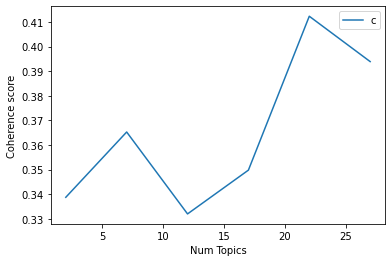

In [148]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [149]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3388
index: 1 | Num Topics = 7  has Coherence Value of 0.3653
index: 2 | Num Topics = 12  has Coherence Value of 0.332
index: 3 | Num Topics = 17  has Coherence Value of 0.3498
index: 4 | Num Topics = 22  has Coherence Value of 0.4123
index: 5 | Num Topics = 27  has Coherence Value of 0.3939


In [150]:
# Select optimal number of topics
optimal_model_ph_2018_score1N2N3 = model_list_ph_2018_score1N2N3[4]

In [151]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2018_score1N2N3, corpus_ph_2018_score1N2N3, id2word_ph_2018_score1N2N3)

In [152]:
print("pyLDAVis for ph topics for score=1,2,3 in 2018:")
vis_ph_2018_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.068120  0.161156       1        1  11.653245
1      0.355293 -0.048793       2        1  10.435765
0      0.036215  0.150688       3        1   8.059852
19    -0.020919 -0.016909       4        1   6.596768
21     0.044061 -0.042067       5        1   6.442621
18    -0.033265  0.084540       6        1   6.306426
17     0.009342 -0.020695       7        1   5.820335
11     0.080406  0.093913       8        1   5.649430
14    -0.056980  0.032255       9        1   5.433933
16     0.041972  0.043983      10        1   4.358541
9      0.046745  0.074790      11        1   4.267645
7     -0.004423  0.028637      12        1   3.538908
5      0.040670 -0.106489      13        1   3.072475
4      0.019260 -0.111942      14        1   3.044960
2     -0.041748 -0.043118      15        1   2.834594
15    -0.045681  0.012274      16        1   2.640197
13    -0.050605  0.057034      17        1   2.570153
20    -0.082822 -0.117363      18        1   2.398031
3     -0.093581  0.011939      19        1   2.006590
12    -0.080730 -0.119912      20        1   1.225504
6     -0.033106 -0.048396      21        1   1.015914
8     -0.061985 -0.075527      22        1   0.628114, topic_info=           Term       Freq      Total Category  logprob  loglift
25         back  44.000000  44.000000  Default  30.0000  30.0000
29        bring  33.000000  33.000000  Default  29.0000  29.0000
34       filter  44.000000  44.000000  Default  28.0000  28.0000
88          old  45.000000  45.000000  Default  27.0000  27.0000
24       update  73.000000  73.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
20       outfit   0.017099   3.965415  Topic22  -6.4346  -0.3761
21         work   0.017099   4.777477  Topic22  -6.4346  -0.5624
22     annoying   0.017099   5.686530  Topic22  -6.4346  -0.7366
23  frustrating   0.017099   2.988885  Topic22  -6.4346  -0.0934
24       update   0.017099  73.633269  Topic22  -6.4346  -3.2976

[1008 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
252      17  0.718060    access
289       9  0.453112   account
289      15  0.453112   account
102       1  0.629929  actually
267       5  0.654580        ad
...     ...       ...       ...
300       6  0.651831     wrong
311       3  0.445114      year
311      14  0.445114      year
147       4  0.648504       yet
471       8  0.670840     young

[969 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 2, 1, 20, 22, 19, 18, 12, 15, 17, 10, 8, 6, 5, 3, 16, 14, 21, 4, 13, 7, 9])

## By-rating of 2019 (Rating=1,2,3)

In [153]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_ph_2019_score1N2N3 = snapchat_ios_ph_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_ph_2019_score1N2N3 = list(sent_to_words(review_ph_2019_score1N2N3))
print(review_words_ph_2019_score1N2N3[:1])

[['my', 'app', 'is', 'alway', 'force', 'close', 'when', 'open', 'it', 'but', 'its', 'update']]


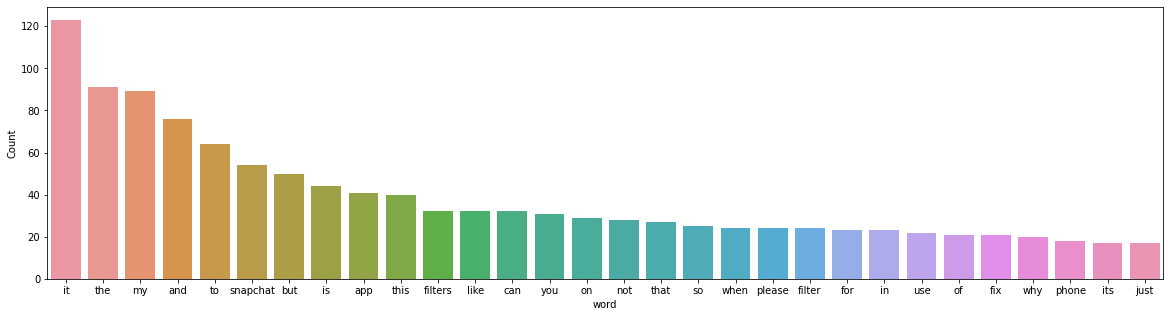

In [154]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2019_score1N2N3))

In [155]:
# Clean text
review_words_ph_ready_2019_score1N2N3 = process_words(review_words_ph_2019_score1N2N3)  # processed Text Data! - move to each section

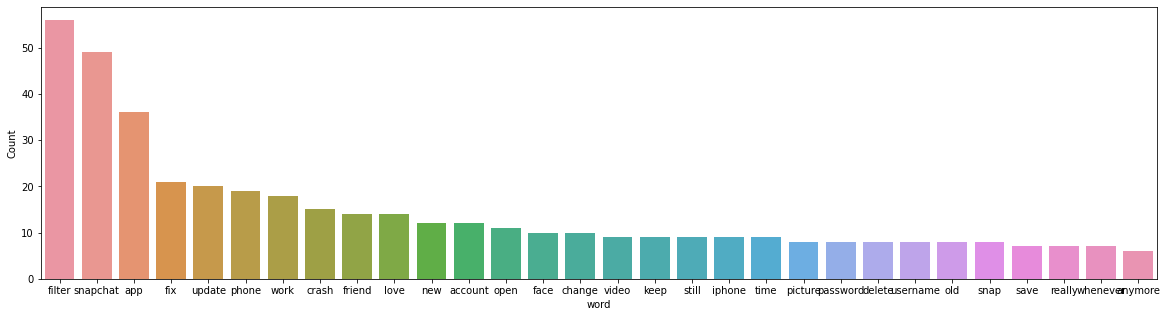

In [156]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2019_score1N2N3))


In [157]:
# Create Dictionary
id2word_ph_2019_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2019_score1N2N3)

2021-10-16 21:05:14,429 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 21:05:14,437 [INFO] gensim.corpora.dictionary - built Dictionary(410 unique tokens: ['alway', 'close', 'force', 'open', 'update']...) from 108 documents (total 1079 corpus positions)
2021-10-16 21:05:14,438 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(410 unique tokens: ['alway', 'close', 'force', 'open', 'update']...) from 108 documents (total 1079 corpus positions)", 'datetime': '2021-10-16T21:05:14.438881', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [158]:
# Create Corpus: Term Document Frequency
corpus_ph_2019_score1N2N3 = [id2word_ph_2019_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2019_score1N2N3]

In [159]:
# Training LDA model
model_list_ph_2019_score1N2N3, coherence_values_ph_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2019_score1N2N3, corpus=corpus_ph_2019_score1N2N3, 
                                                              texts=review_words_ph_ready_2019_score1N2N3, limit=30, start=2, step=5)


2021-10-16 21:05:14,503 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 21:05:14,508 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 21:05:14,511 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 21:05:14,515 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 108 documents, updating model once every 108 documents, evaluating perplexity every 108 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 21:05:14,984 [INFO] gensim.models.ldamodel - -6.718 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:14,985 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #108/108
2021-10-16 21:05:15,409 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"filter" + 0.030*"snapchat" + 0.026*"app" + 0.017*"fix" + 0.016*"crash" + 0.014*"update" + 0.013*"

2021-10-16 21:05:19,126 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"snapchat" + 0.020*"filter" + 0.016*"work" + 0.016*"update" + 0.015*"friend" + 0.015*"app" + 0.015*"new" + 0.013*"change" + 0.013*"account" + 0.013*"phone"
2021-10-16 21:05:19,129 [INFO] gensim.models.ldamodel - topic diff=0.011309, rho=0.301511
2021-10-16 21:05:19,353 [INFO] gensim.models.ldamodel - -5.854 per-word bound, 57.8 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:19,357 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #108/108
2021-10-16 21:05:19,491 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"filter" + 0.033*"app" + 0.027*"snapchat" + 0.022*"fix" + 0.019*"crash" + 0.014*"phone" + 0.012*"face" + 0.012*"update" + 0.012*"keep" + 0.010*"work"
2021-10-16 21:05:19,492 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"snapchat" + 0.020*"filter" + 0.016*"update" + 0.016*"work" + 0.015*"friend" + 0.015*"new" + 0.015*"app"

2021-10-16 21:05:22,975 [INFO] gensim.models.ldamodel - topic diff=0.006789, rho=0.218218
2021-10-16 21:05:23,114 [INFO] gensim.models.ldamodel - -5.844 per-word bound, 57.4 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:23,115 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #108/108
2021-10-16 21:05:23,275 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"filter" + 0.035*"app" + 0.027*"snapchat" + 0.025*"fix" + 0.019*"crash" + 0.016*"phone" + 0.013*"face" + 0.012*"keep" + 0.010*"love" + 0.010*"work"
2021-10-16 21:05:23,311 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"snapchat" + 0.019*"update" + 0.017*"friend" + 0.017*"new" + 0.016*"filter" + 0.016*"work" + 0.014*"account" + 0.012*"password" + 0.012*"app" + 0.012*"username"
2021-10-16 21:05:23,321 [INFO] gensim.models.ldamodel - topic diff=0.006645, rho=0.213201
2021-10-16 21:05:23,491 [INFO] gensim.models.ldamodel - -5.843 per-word bound, 57.4 perplex

2021-10-16 21:05:26,481 [INFO] gensim.models.ldamodel - topic diff=0.006236, rho=0.179605
2021-10-16 21:05:26,650 [INFO] gensim.models.ldamodel - -5.832 per-word bound, 57.0 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:26,655 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #108/108
2021-10-16 21:05:26,842 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.059*"filter" + 0.037*"app" + 0.026*"fix" + 0.026*"snapchat" + 0.019*"crash" + 0.017*"phone" + 0.013*"face" + 0.012*"keep" + 0.011*"work" + 0.011*"love"
2021-10-16 21:05:26,849 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"snapchat" + 0.020*"update" + 0.018*"friend" + 0.017*"new" + 0.015*"work" + 0.015*"account" + 0.014*"filter" + 0.012*"password" + 0.012*"username" + 0.011*"change"
2021-10-16 21:05:26,850 [INFO] gensim.models.ldamodel - topic diff=0.006210, rho=0.176777
2021-10-16 21:05:26,939 [INFO] gensim.models.ldamodel - -5.831 per-word bound, 56.9 perp

2021-10-16 21:05:29,754 [INFO] gensim.models.ldamodel - topic diff=0.003441, rho=0.156174
2021-10-16 21:05:29,895 [INFO] gensim.models.ldamodel - -5.825 per-word bound, 56.7 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:29,899 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #108/108
2021-10-16 21:05:30,054 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.061*"filter" + 0.037*"app" + 0.027*"fix" + 0.026*"snapchat" + 0.019*"crash" + 0.018*"phone" + 0.013*"face" + 0.012*"keep" + 0.011*"work" + 0.011*"love"
2021-10-16 21:05:30,061 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"snapchat" + 0.020*"update" + 0.018*"friend" + 0.017*"new" + 0.016*"account" + 0.014*"work" + 0.013*"filter" + 0.012*"password" + 0.012*"username" + 0.011*"change"
2021-10-16 21:05:30,064 [INFO] gensim.models.ldamodel - topic diff=0.003285, rho=0.154303
2021-10-16 21:05:30,245 [INFO] gensim.models.ldamodel - -5.824 per-word bound, 56.7 perp

2021-10-16 21:05:32,789 [INFO] gensim.models.ldamodel - topic diff=0.003162, rho=0.140028
2021-10-16 21:05:32,791 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=410, num_topics=2, decay=0.5, chunksize=1000) in 18.28s', 'datetime': '2021-10-16T21:05:32.791071', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 21:05:32,794 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 21:05:37,629 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 21:05:37,655 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 102 virtual documents
2021-10-16 21:05:37,958 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 

2021-10-16 21:05:39,511 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"update" + 0.024*"download" + 0.017*"time" + 0.017*"keep" + 0.017*"fix" + 0.017*"happen" + 0.017*"nga" + 0.017*"crash" + 0.016*"connection" + 0.010*"app"
2021-10-16 21:05:39,512 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"filter" + 0.040*"work" + 0.033*"face" + 0.026*"snapchat" + 0.026*"iphone" + 0.021*"update" + 0.021*"app" + 0.019*"fix" + 0.018*"swap" + 0.016*"phone"
2021-10-16 21:05:39,515 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"update" + 0.031*"open" + 0.027*"snapchat" + 0.026*"picture" + 0.023*"filter" + 0.022*"fix" + 0.019*"save" + 0.019*"photo" + 0.019*"work" + 0.013*"new"
2021-10-16 21:05:39,517 [INFO] gensim.models.ldamodel - topic diff=0.057741, rho=0.408248
2021-10-16 21:05:39,645 [INFO] gensim.models.ldamodel - -6.182 per-word bound, 72.6 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:39,646 [INFO] gensim.models.ldam

2021-10-16 21:05:40,758 [INFO] gensim.models.ldamodel - topic diff=0.010045, rho=0.301511
2021-10-16 21:05:40,891 [INFO] gensim.models.ldamodel - -6.170 per-word bound, 72.0 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:40,892 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #108/108
2021-10-16 21:05:41,004 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"update" + 0.025*"download" + 0.017*"keep" + 0.017*"time" + 0.017*"fix" + 0.017*"happen" + 0.017*"nga" + 0.017*"crash" + 0.017*"connection" + 0.010*"app"
2021-10-16 21:05:41,005 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.061*"snapchat" + 0.029*"change" + 0.018*"app" + 0.018*"crash" + 0.018*"video" + 0.018*"baby" + 0.018*"people" + 0.018*"account" + 0.016*"fix" + 0.016*"filter"
2021-10-16 21:05:41,008 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.076*"filter" + 0.053*"app" + 0.032*"snapchat" + 0.020*"old" + 0.017*"phone" + 0.017*"love" + 0.014*"fix" 

2021-10-16 21:05:42,178 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"update" + 0.025*"download" + 0.017*"keep" + 0.017*"time" + 0.017*"fix" + 0.017*"happen" + 0.017*"nga" + 0.017*"crash" + 0.017*"connection" + 0.010*"app"
2021-10-16 21:05:42,179 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"filter" + 0.028*"snapchat" + 0.024*"app" + 0.024*"still" + 0.016*"phone" + 0.016*"password" + 0.016*"time" + 0.016*"fix" + 0.012*"friend" + 0.012*"delete"
2021-10-16 21:05:42,181 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"snapchat" + 0.043*"friend" + 0.026*"username" + 0.019*"chat" + 0.019*"delete" + 0.019*"log" + 0.019*"remember" + 0.019*"phone" + 0.015*"new" + 0.015*"account"
2021-10-16 21:05:42,182 [INFO] gensim.models.ldamodel - topic diff=0.001759, rho=0.242536
2021-10-16 21:05:42,377 [INFO] gensim.models.ldamodel - -6.168 per-word bound, 71.9 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:42,378 [INFO] gensi

2021-10-16 21:05:43,502 [INFO] gensim.models.ldamodel - topic diff=0.000495, rho=0.213201
2021-10-16 21:05:43,666 [INFO] gensim.models.ldamodel - -6.168 per-word bound, 71.9 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:43,667 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #108/108
2021-10-16 21:05:43,770 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.063*"filter" + 0.040*"work" + 0.035*"face" + 0.027*"snapchat" + 0.025*"iphone" + 0.025*"update" + 0.025*"fix" + 0.020*"app" + 0.020*"swap" + 0.015*"crash"
2021-10-16 21:05:43,776 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"filter" + 0.028*"snapchat" + 0.024*"app" + 0.024*"still" + 0.016*"phone" + 0.016*"time" + 0.016*"password" + 0.016*"fix" + 0.012*"snap" + 0.012*"delete"
2021-10-16 21:05:43,779 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.061*"snapchat" + 0.029*"change" + 0.018*"crash" + 0.018*"video" + 0.018*"app" + 0.018*"baby" + 0.018*"people"

2021-10-16 21:05:45,150 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"snapchat" + 0.043*"friend" + 0.025*"username" + 0.019*"log" + 0.019*"delete" + 0.019*"chat" + 0.019*"remember" + 0.019*"phone" + 0.015*"new" + 0.015*"account"
2021-10-16 21:05:45,152 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"filter" + 0.028*"snapchat" + 0.024*"still" + 0.024*"app" + 0.016*"phone" + 0.016*"time" + 0.016*"password" + 0.016*"fix" + 0.012*"snap" + 0.012*"delete"
2021-10-16 21:05:45,155 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.061*"snapchat" + 0.029*"change" + 0.018*"crash" + 0.018*"video" + 0.018*"baby" + 0.018*"app" + 0.018*"people" + 0.018*"account" + 0.016*"fix" + 0.016*"filter"
2021-10-16 21:05:45,155 [INFO] gensim.models.ldamodel - topic diff=0.000143, rho=0.188982
2021-10-16 21:05:45,293 [INFO] gensim.models.ldamodel - -6.168 per-word bound, 71.9 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:45,309 [INFO] gensim

2021-10-16 21:05:46,369 [INFO] gensim.models.ldamodel - topic diff=0.000731, rho=0.174078
2021-10-16 21:05:46,519 [INFO] gensim.models.ldamodel - -6.168 per-word bound, 71.9 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:46,520 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #108/108
2021-10-16 21:05:46,624 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"filter" + 0.028*"snapchat" + 0.024*"still" + 0.024*"app" + 0.016*"phone" + 0.016*"time" + 0.016*"password" + 0.016*"fix" + 0.012*"snap" + 0.012*"delete"
2021-10-16 21:05:46,626 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"update" + 0.033*"open" + 0.027*"snapchat" + 0.026*"picture" + 0.020*"work" + 0.020*"save" + 0.020*"photo" + 0.015*"fix" + 0.015*"filter" + 0.014*"new"
2021-10-16 21:05:46,628 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.077*"filter" + 0.053*"app" + 0.032*"snapchat" + 0.020*"old" + 0.017*"love" + 0.017*"phone" + 0.014*"fix" + 0

2021-10-16 21:05:47,859 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.061*"snapchat" + 0.029*"change" + 0.018*"crash" + 0.018*"video" + 0.018*"baby" + 0.018*"people" + 0.018*"app" + 0.018*"account" + 0.016*"fix" + 0.016*"filter"
2021-10-16 21:05:47,863 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.077*"filter" + 0.053*"app" + 0.032*"snapchat" + 0.020*"old" + 0.017*"love" + 0.017*"phone" + 0.014*"fix" + 0.012*"lense" + 0.012*"find" + 0.012*"available"
2021-10-16 21:05:47,865 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"filter" + 0.028*"snapchat" + 0.024*"still" + 0.024*"app" + 0.016*"phone" + 0.016*"time" + 0.016*"password" + 0.016*"fix" + 0.012*"snap" + 0.012*"delete"
2021-10-16 21:05:47,866 [INFO] gensim.models.ldamodel - topic diff=0.000305, rho=0.160128
2021-10-16 21:05:47,990 [INFO] gensim.models.ldamodel - -6.166 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:47,992 [INFO] gensim.models.

2021-10-16 21:05:49,078 [INFO] gensim.models.ldamodel - topic diff=0.000188, rho=0.150756
2021-10-16 21:05:49,267 [INFO] gensim.models.ldamodel - -6.166 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:49,269 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #108/108
2021-10-16 21:05:49,369 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"update" + 0.025*"download" + 0.017*"keep" + 0.017*"time" + 0.017*"fix" + 0.017*"happen" + 0.017*"nga" + 0.017*"connection" + 0.017*"crash" + 0.010*"app"
2021-10-16 21:05:49,372 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.062*"filter" + 0.040*"work" + 0.035*"face" + 0.027*"snapchat" + 0.025*"iphone" + 0.025*"update" + 0.025*"fix" + 0.020*"app" + 0.020*"swap" + 0.015*"crash"
2021-10-16 21:05:49,373 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"snapchat" + 0.043*"friend" + 0.025*"username" + 0.019*"log" + 0.019*"delete" + 0.019*"chat" + 0.019*"rem

2021-10-16 21:05:50,650 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"update" + 0.025*"download" + 0.017*"keep" + 0.017*"time" + 0.017*"fix" + 0.017*"happen" + 0.017*"nga" + 0.017*"connection" + 0.017*"crash" + 0.010*"app"
2021-10-16 21:05:50,653 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"update" + 0.033*"open" + 0.027*"snapchat" + 0.026*"picture" + 0.020*"work" + 0.020*"save" + 0.020*"photo" + 0.015*"fix" + 0.015*"filter" + 0.014*"new"
2021-10-16 21:05:50,657 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.061*"filter" + 0.040*"work" + 0.035*"face" + 0.027*"snapchat" + 0.025*"iphone" + 0.025*"update" + 0.025*"fix" + 0.020*"app" + 0.020*"swap" + 0.015*"crash"
2021-10-16 21:05:50,660 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"filter" + 0.028*"snapchat" + 0.024*"still" + 0.024*"app" + 0.016*"time" + 0.016*"password" + 0.016*"phone" + 0.016*"fix" + 0.012*"snap" + 0.012*"delete"
2021-10-16 21:05:50,662 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 21:05:58,242 [INFO] gensim.models.ldamodel - topic diff=0.092934, rho=0.500000
2021-10-16 21:05:58,375 [INFO] gensim.models.ldamodel - -6.379 per-word bound, 83.2 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:58,379 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #108/108
2021-10-16 21:05:58,485 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.055*"snapchat" + 0.053*"filter" + 0.034*"fix" + 0.026*"update" + 0.023*"face" + 0.023*"app" + 0.018*"place" + 0.018*"crash" + 0.018*"lense" + 0.015*"work"
2021-10-16 21:05:58,486 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"fix" + 0.036*"zoom" + 0.036*"problem" + 0.022*"app" + 0.020*"video" + 0.020*"keep" + 0.020*"max" + 0.020*"wrong" + 0.020*"face" + 0.020*"ask"
2021-10-16 21:05:58,487 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.053*"old" + 0.046*"filter" + 0.036*"snapchat" + 0.026*"app" + 0.016*"love" + 0.016*"lense" + 0.016*"fix" + 0.015*"wish" +

2021-10-16 21:05:59,726 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"app" + 0.027*"time" + 0.027*"nga" + 0.027*"screenshot" + 0.027*"filter" + 0.014*"snap" + 0.014*"drain" + 0.014*"fast" + 0.014*"find" + 0.014*"battery"
2021-10-16 21:05:59,729 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.054*"snapchat" + 0.053*"filter" + 0.035*"fix" + 0.026*"update" + 0.024*"face" + 0.024*"app" + 0.018*"place" + 0.018*"crash" + 0.018*"lense" + 0.013*"work"
2021-10-16 21:05:59,730 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"filter" + 0.040*"snapchat" + 0.040*"delete" + 0.020*"snap" + 0.020*"still" + 0.020*"message" + 0.020*"app" + 0.014*"friend" + 0.014*"woman" + 0.014*"back"
2021-10-16 21:05:59,731 [INFO] gensim.models.ldamodel - topic diff=0.016070, rho=0.316228
2021-10-16 21:05:59,859 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:05:59,862 [INFO] gensim.models.l

2021-10-16 21:06:00,804 [INFO] gensim.models.ldamodel - topic diff=0.004253, rho=0.258199
2021-10-16 21:06:00,987 [INFO] gensim.models.ldamodel - -6.310 per-word bound, 79.4 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:00,988 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #108/108
2021-10-16 21:06:01,112 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.054*"old" + 0.047*"filter" + 0.035*"snapchat" + 0.025*"app" + 0.016*"love" + 0.016*"lense" + 0.016*"fix" + 0.016*"wish" + 0.016*"retrieve" + 0.016*"number"
2021-10-16 21:06:01,113 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.061*"snapchat" + 0.046*"change" + 0.037*"update" + 0.037*"chat" + 0.036*"new" + 0.035*"friend" + 0.028*"people" + 0.027*"filter" + 0.019*"app" + 0.019*"active"
2021-10-16 21:06:01,114 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.067*"app" + 0.037*"filter" + 0.031*"phone" + 0.026*"whenever" + 0.026*"download" + 0.024*"work" + 0.024*"s

2021-10-16 21:06:02,335 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.037*"connection" + 0.019*"keep" + 0.019*"happen" + 0.019*"sign" + 0.019*"update" + 0.019*"check" + 0.019*"fast" + 0.019*"fix" + 0.019*"black" + 0.019*"icon"
2021-10-16 21:06:02,336 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.081*"filter" + 0.039*"love" + 0.039*"phone" + 0.033*"app" + 0.026*"crash" + 0.026*"snapchat" + 0.026*"available" + 0.020*"keep" + 0.013*"save" + 0.013*"fave"
2021-10-16 21:06:02,339 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.046*"open" + 0.043*"update" + 0.028*"snapchat" + 0.028*"save" + 0.028*"photo" + 0.028*"close" + 0.019*"new" + 0.019*"snap" + 0.019*"picture" + 0.019*"wrong"
2021-10-16 21:06:02,341 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.054*"old" + 0.047*"filter" + 0.035*"snapchat" + 0.025*"app" + 0.016*"love" + 0.016*"lense" + 0.016*"fix" + 0.016*"wish" + 0.016*"retrieve" + 0.016*"number"
2021-10-16 21:06:02,345 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 21:06:03,655 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.061*"snapchat" + 0.047*"change" + 0.037*"update" + 0.037*"chat" + 0.036*"new" + 0.035*"friend" + 0.028*"people" + 0.027*"filter" + 0.019*"app" + 0.019*"active"
2021-10-16 21:06:03,656 [INFO] gensim.models.ldamodel - topic diff=0.000347, rho=0.196116
2021-10-16 21:06:03,774 [INFO] gensim.models.ldamodel - -6.310 per-word bound, 79.3 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:03,776 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #108/108
2021-10-16 21:06:03,864 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.069*"filter" + 0.066*"work" + 0.033*"iphone" + 0.033*"phone" + 0.022*"crash" + 0.022*"gender" + 0.022*"lens" + 0.012*"swap" + 0.012*"problem" + 0.012*"hope"
2021-10-16 21:06:03,868 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"app" + 0.027*"time" + 0.027*"filter" + 0.027*"nga" + 0.027*"screenshot" + 0.014*"snap" + 0.014*"fas

2021-10-16 21:06:04,968 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.067*"app" + 0.037*"filter" + 0.031*"phone" + 0.026*"whenever" + 0.026*"download" + 0.024*"work" + 0.024*"snapchat" + 0.021*"password" + 0.016*"still" + 0.016*"fix"
2021-10-16 21:06:04,970 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"app" + 0.027*"time" + 0.027*"nga" + 0.027*"filter" + 0.027*"screenshot" + 0.014*"snap" + 0.014*"drain" + 0.014*"find" + 0.014*"fast" + 0.014*"battery"
2021-10-16 21:06:04,971 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.045*"filter" + 0.041*"snapchat" + 0.041*"delete" + 0.021*"snap" + 0.021*"still" + 0.021*"message" + 0.021*"app" + 0.014*"friend" + 0.014*"woman" + 0.014*"keep"
2021-10-16 21:06:04,974 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.037*"connection" + 0.019*"keep" + 0.019*"happen" + 0.019*"sign" + 0.019*"update" + 0.019*"check" + 0.019*"fix" + 0.019*"fast" + 0.019*"black" + 0.019*"icon"
2021-10-16 21:06:04,975 [INFO] gensim.models.ldamodel - to

2021-10-16 21:06:06,259 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.067*"app" + 0.037*"filter" + 0.031*"phone" + 0.026*"whenever" + 0.026*"download" + 0.024*"work" + 0.024*"snapchat" + 0.021*"password" + 0.016*"still" + 0.016*"open"
2021-10-16 21:06:06,261 [INFO] gensim.models.ldamodel - topic diff=0.000665, rho=0.164399
2021-10-16 21:06:06,375 [INFO] gensim.models.ldamodel - -6.304 per-word bound, 79.0 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:06,378 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #108/108
2021-10-16 21:06:06,500 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"app" + 0.027*"time" + 0.027*"filter" + 0.027*"nga" + 0.027*"screenshot" + 0.014*"snap" + 0.014*"find" + 0.014*"drain" + 0.014*"fast" + 0.014*"fix"
2021-10-16 21:06:06,501 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.053*"old" + 0.051*"filter" + 0.033*"snapchat" + 0.024*"app" + 0.015*"love" + 0.015*"lense" + 0.015*"fix"

2021-10-16 21:06:07,742 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.069*"filter" + 0.067*"work" + 0.033*"iphone" + 0.033*"phone" + 0.022*"crash" + 0.022*"gender" + 0.022*"lens" + 0.012*"problem" + 0.012*"swap" + 0.012*"hope"
2021-10-16 21:06:07,743 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.054*"snapchat" + 0.053*"filter" + 0.035*"fix" + 0.026*"update" + 0.024*"face" + 0.024*"app" + 0.018*"crash" + 0.018*"lense" + 0.018*"place" + 0.012*"work"
2021-10-16 21:06:07,747 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.052*"old" + 0.052*"filter" + 0.033*"snapchat" + 0.024*"app" + 0.015*"love" + 0.015*"lense" + 0.015*"wish" + 0.015*"fix" + 0.015*"retrieve" + 0.015*"number"
2021-10-16 21:06:07,749 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.062*"snapchat" + 0.047*"change" + 0.037*"update" + 0.037*"chat" + 0.036*"new" + 0.035*"friend" + 0.028*"people" + 0.027*"filter" + 0.019*"active" + 0.019*"app"
2021-10-16 21:06:07,749 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 21:06:08,880 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.054*"snapchat" + 0.053*"filter" + 0.035*"fix" + 0.026*"update" + 0.024*"face" + 0.024*"app" + 0.018*"crash" + 0.018*"place" + 0.018*"lense" + 0.012*"work"
2021-10-16 21:06:08,882 [INFO] gensim.models.ldamodel - topic diff=0.000409, rho=0.144338
2021-10-16 21:06:08,945 [INFO] gensim.models.ldamodel - -6.303 per-word bound, 78.9 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:08,947 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #108/108
2021-10-16 21:06:09,112 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.042*"filter" + 0.042*"delete" + 0.042*"snapchat" + 0.021*"snap" + 0.021*"still" + 0.021*"message" + 0.021*"app" + 0.014*"woman" + 0.014*"much" + 0.014*"fake"
2021-10-16 21:06:09,114 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.067*"app" + 0.037*"filter" + 0.031*"phone" + 0.026*"whenever" + 0.026*"download" + 0.024*"work" + 0.024*"snap

2021-10-16 21:06:17,509 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.042*"photo" + 0.042*"work" + 0.042*"save" + 0.029*"phone" + 0.028*"memory" + 0.028*"iphone" + 0.028*"choose" + 0.028*"camera" + 0.028*"problem" + 0.028*"filter"
2021-10-16 21:06:17,510 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.065*"crash" + 0.057*"snapchat" + 0.029*"love" + 0.029*"phone" + 0.029*"filter" + 0.029*"fix" + 0.029*"app" + 0.023*"keep" + 0.015*"disappoint" + 0.015*"second"
2021-10-16 21:06:17,511 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.049*"zoom" + 0.032*"ask" + 0.032*"face" + 0.032*"iphone" + 0.032*"app" + 0.032*"max" + 0.032*"problem" + 0.032*"fix" + 0.014*"snapchat" + 0.014*"work"
2021-10-16 21:06:17,512 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.044*"snapchat" + 0.043*"app" + 0.033*"filter" + 0.033*"old" + 0.033*"phone" + 0.022*"iphone" + 0.022*"number" + 0.022*"work" + 0.022*"retrieve" + 0.022*"everytime"
2021-10-16 21:06:17,513 [INFO] gensim.models.ldamodel - t

2021-10-16 21:06:18,789 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.036*"update" + 0.035*"friend" + 0.035*"username" + 0.029*"open" + 0.029*"snapchat" + 0.029*"new" + 0.028*"remember" + 0.028*"log" + 0.021*"account" + 0.021*"click"
2021-10-16 21:06:18,790 [INFO] gensim.models.ldamodel - topic diff=0.033244, rho=0.353553
2021-10-16 21:06:18,902 [INFO] gensim.models.ldamodel - -6.440 per-word bound, 86.8 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:18,920 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #108/108
2021-10-16 21:06:19,007 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.032*"fast" + 0.032*"happen" + 0.032*"keep" + 0.032*"check" + 0.032*"sign" + 0.032*"fix" + 0.032*"acc" + 0.032*"connection" + 0.032*"nt" + 0.002*"filter"
2021-10-16 21:06:19,009 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.052*"filter" + 0.027*"add" + 0.027*"look" + 0.027*"minimize" + 0.027*"black" + 0.027*"ghost" + 0.027*"tac

2021-10-16 21:06:20,260 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.092*"snapchat" + 0.058*"change" + 0.035*"people" + 0.024*"username" + 0.024*"account" + 0.024*"new" + 0.024*"video" + 0.024*"baby" + 0.024*"face" + 0.012*"friend"
2021-10-16 21:06:20,265 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.060*"snapchat" + 0.036*"friend" + 0.024*"much" + 0.024*"message" + 0.024*"picture" + 0.024*"great" + 0.024*"app" + 0.024*"chat" + 0.024*"active" + 0.024*"offline"
2021-10-16 21:06:20,267 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.077*"crash" + 0.067*"snapchat" + 0.039*"love" + 0.039*"keep" + 0.034*"phone" + 0.028*"fix" + 0.028*"app" + 0.018*"minute" + 0.015*"filter" + 0.015*"disappoint"
2021-10-16 21:06:20,269 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.060*"app" + 0.040*"filter" + 0.030*"time" + 0.030*"download" + 0.025*"crash" + 0.020*"appear" + 0.020*"find" + 0.020*"much" + 0.020*"snap" + 0.020*"still"
2021-10-16 21:06:20,274 [INFO] gensim.models.ldamodel

2021-10-16 21:06:21,375 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.126*"filter" + 0.050*"work" + 0.044*"update" + 0.040*"snapchat" + 0.033*"face" + 0.033*"fix" + 0.031*"iphone" + 0.022*"female" + 0.022*"really" + 0.022*"new"
2021-10-16 21:06:21,376 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.045*"snapchat" + 0.045*"app" + 0.034*"old" + 0.034*"phone" + 0.023*"retrieve" + 0.023*"number" + 0.023*"everytime" + 0.014*"iphone" + 0.013*"work" + 0.013*"filter"
2021-10-16 21:06:21,378 [INFO] gensim.models.ldamodel - topic diff=0.002717, rho=0.229416
2021-10-16 21:06:21,484 [INFO] gensim.models.ldamodel - -6.421 per-word bound, 85.7 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:21,488 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #108/108
2021-10-16 21:06:21,536 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.039*"snapchat" + 0.039*"work" + 0.036*"filter" + 0.036*"password" + 0.027*"whenever" + 0.027*"fix" +

2021-10-16 21:06:22,771 [INFO] gensim.models.ldamodel - -6.418 per-word bound, 85.5 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:22,772 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #108/108
2021-10-16 21:06:22,886 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.037*"snapchat" + 0.037*"work" + 0.036*"filter" + 0.036*"password" + 0.027*"whenever" + 0.027*"fix" + 0.027*"put" + 0.027*"love" + 0.018*"anymore" + 0.018*"fun"
2021-10-16 21:06:22,888 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.129*"filter" + 0.052*"work" + 0.043*"snapchat" + 0.043*"update" + 0.032*"face" + 0.032*"fix" + 0.031*"iphone" + 0.022*"female" + 0.022*"really" + 0.022*"new"
2021-10-16 21:06:22,889 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.059*"filter" + 0.040*"fix" + 0.030*"app" + 0.030*"place" + 0.030*"crash" + 0.020*"snapchat" + 0.020*"find" + 0.020*"picture" + 0.020*"photo" + 0.020*"lense"
2021-10-16 21:06:22,890 [INFO] gensim

2021-10-16 21:06:23,999 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.131*"filter" + 0.050*"work" + 0.045*"update" + 0.043*"snapchat" + 0.032*"face" + 0.032*"fix" + 0.030*"iphone" + 0.022*"female" + 0.022*"really" + 0.022*"new"
2021-10-16 21:06:24,001 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.041*"snap" + 0.032*"filter" + 0.031*"snapchat" + 0.031*"still" + 0.021*"delete" + 0.021*"nga" + 0.021*"lens" + 0.021*"woman" + 0.011*"phone" + 0.011*"view"
2021-10-16 21:06:24,002 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.053*"filter" + 0.027*"look" + 0.027*"add" + 0.027*"minimize" + 0.027*"ghost" + 0.027*"update" + 0.027*"icon" + 0.027*"tacky" + 0.027*"black" + 0.027*"outline"
2021-10-16 21:06:24,003 [INFO] gensim.models.ldamodel - topic diff=0.000658, rho=0.182574
2021-10-16 21:06:24,146 [INFO] gensim.models.ldamodel - -6.417 per-word bound, 85.4 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:24,147 [INFO] gensim.models

2021-10-16 21:06:25,178 [INFO] gensim.models.ldamodel - topic diff=0.000827, rho=0.169031
2021-10-16 21:06:25,366 [INFO] gensim.models.ldamodel - -6.416 per-word bound, 85.4 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:25,368 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #108/108
2021-10-16 21:06:25,404 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.093*"snapchat" + 0.058*"change" + 0.035*"people" + 0.024*"username" + 0.024*"account" + 0.024*"new" + 0.024*"video" + 0.024*"face" + 0.024*"baby" + 0.012*"friend"
2021-10-16 21:06:25,405 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.043*"photo" + 0.043*"save" + 0.043*"work" + 0.029*"phone" + 0.029*"choose" + 0.029*"memory" + 0.029*"camera" + 0.029*"iphone" + 0.029*"filter" + 0.029*"problem"
2021-10-16 21:06:25,407 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.053*"filter" + 0.027*"look" + 0.027*"add" + 0.027*"minimize" + 0.027*"ghost" + 0.027*"update" + 

2021-10-16 21:06:26,612 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.057*"filter" + 0.049*"app" + 0.025*"snapchat" + 0.025*"exit" + 0.017*"reason" + 0.017*"beautify" + 0.017*"look" + 0.017*"hope" + 0.017*"much" + 0.017*"cause"
2021-10-16 21:06:26,620 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.053*"filter" + 0.027*"look" + 0.027*"add" + 0.027*"minimize" + 0.027*"ghost" + 0.027*"update" + 0.027*"icon" + 0.027*"tacky" + 0.027*"black" + 0.027*"outline"
2021-10-16 21:06:26,623 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.046*"app" + 0.043*"snapchat" + 0.035*"old" + 0.035*"phone" + 0.023*"number" + 0.023*"retrieve" + 0.023*"everytime" + 0.014*"iphone" + 0.013*"work" + 0.012*"forgot"
2021-10-16 21:06:26,630 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.062*"zoom" + 0.032*"ask" + 0.032*"max" + 0.032*"fix" + 0.032*"app" + 0.032*"problem" + 0.032*"iphone" + 0.032*"face" + 0.002*"work" + 0.002*"snapchat"
2021-10-16 21:06:26,634 [INFO] gensim.models.ldamodel - topic

2021-10-16 21:06:27,776 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.135*"filter" + 0.059*"work" + 0.044*"snapchat" + 0.041*"update" + 0.040*"fix" + 0.031*"face" + 0.029*"iphone" + 0.029*"phone" + 0.021*"female" + 0.021*"really"
2021-10-16 21:06:27,777 [INFO] gensim.models.ldamodel - topic diff=0.000456, rho=0.147442
2021-10-16 21:06:27,876 [INFO] gensim.models.ldamodel - -6.413 per-word bound, 85.2 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:27,921 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #108/108
2021-10-16 21:06:28,005 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.056*"update" + 0.042*"app" + 0.029*"hate" + 0.029*"snapchat" + 0.029*"screenshot" + 0.029*"wrong" + 0.029*"always" + 0.015*"filter" + 0.015*"fix" + 0.015*"rate"
2021-10-16 21:06:28,009 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.037*"username" + 0.037*"friend" + 0.029*"update" + 0.029*"new" + 0.029*"snapchat" + 0.029*"open" + 0.

2021-10-16 21:06:29,001 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 21:06:33,865 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 21:06:33,927 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 105 virtual documents
2021-10-16 21:06:37,282 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 21:06:37,284 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 21:06:37,287 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 21:06:37,292 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 108 documents, updating model once every 108 documents, evaluating perplexity every 108 documents, iterating 50x with a 

2021-10-16 21:06:38,807 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.065*"zoom" + 0.034*"ask" + 0.034*"face" + 0.034*"iphone" + 0.034*"max" + 0.034*"app" + 0.034*"problem" + 0.034*"add" + 0.034*"fix" + 0.034*"beautiful"
2021-10-16 21:06:38,808 [INFO] gensim.models.ldamodel - topic diff=0.077304, rho=0.408248
2021-10-16 21:06:38,896 [INFO] gensim.models.ldamodel - -6.598 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:38,898 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #108/108
2021-10-16 21:06:39,004 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.051*"much" + 0.034*"microphone" + 0.034*"work" + 0.034*"love" + 0.034*"whenever" + 0.034*"snapchat" + 0.034*"filter" + 0.033*"connection" + 0.033*"fix" + 0.033*"check"
2021-10-16 21:06:39,006 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.038*"new" + 0.033*"selfie" + 0.033*"low" + 0.033*"enjoy" + 0.033*"camera" + 0.033*"especially" + 0.033

2021-10-16 21:06:40,249 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.097*"filter" + 0.065*"work" + 0.043*"iphone" + 0.033*"phone" + 0.032*"picture" + 0.032*"baby" + 0.026*"fix" + 0.022*"lens" + 0.021*"record" + 0.021*"girl"
2021-10-16 21:06:40,250 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.073*"snapchat" + 0.052*"username" + 0.042*"friend" + 0.037*"change" + 0.030*"account" + 0.030*"remember" + 0.030*"log" + 0.023*"people" + 0.022*"click" + 0.022*"work"
2021-10-16 21:06:40,252 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.128*"filter" + 0.065*"update" + 0.056*"crash" + 0.054*"snapchat" + 0.038*"face" + 0.038*"fix" + 0.026*"turn" + 0.026*"female" + 0.024*"gender" + 0.014*"work"
2021-10-16 21:06:40,253 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.057*"phone" + 0.057*"screenshot" + 0.029*"love" + 0.029*"hit" + 0.029*"fast" + 0.029*"change" + 0.029*"chatmate" + 0.029*"app" + 0.029*"drain" + 0.029*"notify"
2021-10-16 21:06:40,255 [INFO] gensim.models.ldamodel 

2021-10-16 21:06:41,379 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.057*"screenshot" + 0.057*"phone" + 0.029*"love" + 0.029*"hit" + 0.029*"fast" + 0.029*"change" + 0.029*"app" + 0.029*"remove" + 0.029*"drain" + 0.029*"chatmate"
2021-10-16 21:06:41,380 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.073*"snapchat" + 0.052*"username" + 0.043*"friend" + 0.037*"change" + 0.030*"account" + 0.030*"remember" + 0.030*"log" + 0.022*"people" + 0.022*"click" + 0.022*"work"
2021-10-16 21:06:41,385 [INFO] gensim.models.ldamodel - topic diff=0.007650, rho=0.242536
2021-10-16 21:06:41,500 [INFO] gensim.models.ldamodel - -6.504 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:41,502 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #108/108
2021-10-16 21:06:41,618 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.073*"snapchat" + 0.052*"username" + 0.043*"friend" + 0.037*"change" + 0.030*"account" + 0.030*

2021-10-16 21:06:42,625 [INFO] gensim.models.ldamodel - -6.501 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:42,627 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #108/108
2021-10-16 21:06:42,730 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.054*"filter" + 0.053*"love" + 0.040*"snapchat" + 0.040*"app" + 0.027*"lense" + 0.027*"old" + 0.027*"put" + 0.027*"fix" + 0.014*"iphone" + 0.014*"somewhere"
2021-10-16 21:06:42,737 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.050*"much" + 0.034*"work" + 0.034*"microphone" + 0.034*"snapchat" + 0.034*"whenever" + 0.034*"love" + 0.034*"filter" + 0.034*"connection" + 0.034*"fix" + 0.034*"check"
2021-10-16 21:06:42,738 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.067*"zoom" + 0.034*"iphone" + 0.034*"max" + 0.034*"problem" + 0.034*"ask" + 0.034*"fix" + 0.034*"app" + 0.034*"face" + 0.034*"filter" + 0.034*"add"
2021-10-16 21:06:42,740 [INFO] gensim.

2021-10-16 21:06:43,824 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.036*"snapchat" + 0.029*"fix" + 0.029*"video" + 0.029*"update" + 0.029*"picture" + 0.029*"love" + 0.029*"exit" + 0.016*"app" + 0.015*"whenever" + 0.015*"asap"
2021-10-16 21:06:43,827 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.033*"new" + 0.033*"camera" + 0.033*"blurry" + 0.033*"become" + 0.033*"especially" + 0.033*"iphone" + 0.033*"low" + 0.033*"really" + 0.033*"selfie" + 0.033*"enjoy"
2021-10-16 21:06:43,830 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.133*"filter" + 0.063*"update" + 0.054*"crash" + 0.053*"snapchat" + 0.038*"face" + 0.038*"fix" + 0.026*"female" + 0.026*"turn" + 0.026*"gender" + 0.014*"work"
2021-10-16 21:06:43,837 [INFO] gensim.models.ldamodel - topic diff=0.001027, rho=0.188982
2021-10-16 21:06:44,002 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:44,004 [INFO] gensim.m

2021-10-16 21:06:45,378 [INFO] gensim.models.ldamodel - topic diff=0.000397, rho=0.174078
2021-10-16 21:06:45,522 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:45,524 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #108/108
2021-10-16 21:06:45,633 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.051*"place" + 0.034*"find" + 0.034*"eye" + 0.034*"lense" + 0.034*"guy" + 0.018*"account" + 0.018*"effect" + 0.018*"obsess" + 0.018*"shot" + 0.018*"fix"
2021-10-16 21:06:45,654 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.037*"back" + 0.037*"swap" + 0.037*"bring" + 0.037*"face" + 0.037*"filter" + 0.037*"wrong" + 0.037*"always" + 0.037*"location" + 0.037*"bitmoji" + 0.037*"我信你个鬼"
2021-10-16 21:06:45,657 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.080*"filter" + 0.053*"app" + 0.042*"snapchat" + 0.028*"crash" + 0.024*"time" + 0.024*"keep" + 0.019*"friend

2021-10-16 21:06:47,011 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.080*"filter" + 0.053*"app" + 0.042*"snapchat" + 0.028*"crash" + 0.024*"time" + 0.024*"keep" + 0.019*"friend" + 0.017*"fix" + 0.015*"snap" + 0.015*"still"
2021-10-16 21:06:47,013 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.057*"screenshot" + 0.057*"phone" + 0.029*"hit" + 0.029*"fast" + 0.029*"app" + 0.029*"drain" + 0.029*"change" + 0.029*"love" + 0.029*"chatmate" + 0.029*"conversation"
2021-10-16 21:06:47,016 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.057*"save" + 0.047*"photo" + 0.047*"open" + 0.032*"choose" + 0.032*"memory" + 0.032*"filter" + 0.032*"phone" + 0.032*"available" + 0.032*"crush" + 0.032*"wrong"
2021-10-16 21:06:47,019 [INFO] gensim.models.ldamodel - topic diff=0.000514, rho=0.160128
2021-10-16 21:06:47,196 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:47,198 [INFO] gens

2021-10-16 21:06:48,585 [INFO] gensim.models.ldamodel - topic diff=0.000102, rho=0.150756
2021-10-16 21:06:48,804 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:06:48,806 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #108/108
2021-10-16 21:06:48,859 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.089*"app" + 0.072*"download" + 0.054*"problem" + 0.037*"update" + 0.027*"snapchat" + 0.019*"click" + 0.019*"star" + 0.019*"work" + 0.019*"phone" + 0.019*"rate"
2021-10-16 21:06:48,917 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.057*"phone" + 0.057*"screenshot" + 0.029*"hit" + 0.029*"fast" + 0.029*"app" + 0.029*"drain" + 0.029*"change" + 0.029*"love" + 0.029*"chatmate" + 0.029*"conversation"
2021-10-16 21:06:48,940 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.036*"snapchat" + 0.029*"fix" + 0.029*"video" + 0.029*"update" + 0.029*"love" + 0.029*"exit" + 

2021-10-16 21:06:50,282 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.045*"snapchat" + 0.045*"delete" + 0.034*"message" + 0.023*"crash" + 0.023*"filter" + 0.023*"app" + 0.023*"phone" + 0.023*"great" + 0.023*"icon" + 0.023*"update"
2021-10-16 21:06:50,291 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.037*"face" + 0.037*"filter" + 0.037*"bring" + 0.037*"swap" + 0.037*"back" + 0.037*"bitmoji" + 0.037*"wrong" + 0.037*"location" + 0.037*"always" + 0.037*"我信你个鬼"
2021-10-16 21:06:50,293 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.002*"year" + 0.002*"annoying" + 0.002*"ago" + 0.002*"never" + 0.002*"uninstalled" + 0.002*"sc" + 0.002*"press" + 0.002*"move" + 0.002*"quality" + 0.002*"button"
2021-10-16 21:06:50,294 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.133*"filter" + 0.063*"update" + 0.054*"crash" + 0.053*"snapchat" + 0.038*"face" + 0.038*"fix" + 0.026*"turn" + 0.026*"female" + 0.026*"gender" + 0.014*"work"
2021-10-16 21:06:50,295 [INFO] gensim.models.ldamodel

2021-10-16 21:07:00,510 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.063*"time" + 0.044*"bitmoji" + 0.044*"always" + 0.044*"location" + 0.044*"wrong" + 0.040*"actual" + 0.039*"sync" + 0.036*"change" + 0.009*"filter" + 0.002*"blue"
2021-10-16 21:07:00,514 [INFO] gensim.models.ldamodel - topic diff=0.123805, rho=0.500000
2021-10-16 21:07:00,624 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:07:00,626 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #108/108
2021-10-16 21:07:00,754 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.084*"work" + 0.076*"microphone" + 0.072*"whenever" + 0.036*"phone" + 0.034*"snapchat" + 0.034*"filter" + 0.033*"fix" + 0.030*"cute" + 0.030*"frustrating" + 0.030*"perfectly"
2021-10-16 21:07:00,756 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.061*"snapchat" + 0.040*"lense" + 0.040*"old" + 0.039*"open" + 0.021*"love" + 0.021*"re

2021-10-16 21:07:01,754 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #108/108
2021-10-16 21:07:01,863 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.116*"filter" + 0.045*"snapchat" + 0.044*"app" + 0.043*"time" + 0.021*"face" + 0.017*"crash" + 0.014*"keep" + 0.014*"fix" + 0.014*"save" + 0.014*"woman"
2021-10-16 21:07:01,865 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.094*"filter" + 0.063*"baby" + 0.032*"update" + 0.032*"team" + 0.032*"crash" + 0.032*"iphone" + 0.032*"unable" + 0.032*"work" + 0.032*"app" + 0.032*"gender"
2021-10-16 21:07:01,867 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.096*"phone" + 0.096*"available" + 0.049*"update" + 0.049*"filter" + 0.002*"button" + 0.002*"uninstalled" + 0.002*"year" + 0.002*"annoying" + 0.002*"ago" + 0.002*"move"
2021-10-16 21:07:01,869 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.103*"app" + 0.057*"instal" + 0.045*"crash" + 0.029*"wonder" + 0.029*"newly" + 0.029*"bug" + 0.029*"shut" + 0.029*"stay" + 

2021-10-16 21:07:02,994 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.060*"old" + 0.041*"account" + 0.041*"retrieve" + 0.041*"number" + 0.021*"typo" + 0.021*"yeaaaaaar" + 0.021*"change" + 0.021*"reason" + 0.021*"boring" + 0.021*"error"
2021-10-16 21:07:02,995 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.055*"update" + 0.028*"friend" + 0.028*"new" + 0.028*"application" + 0.028*"modify" + 0.028*"extremely" + 0.028*"drastically" + 0.028*"disgusting" + 0.028*"decrease" + 0.028*"picture"
2021-10-16 21:07:02,996 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.053*"nga" + 0.053*"zoom" + 0.027*"nakakalerka" + 0.027*"ayun" + 0.027*"problemie" + 0.027*"aking" + 0.027*"nakakavakla" + 0.027*"kayo" + 0.027*"snap" + 0.027*"dete"
2021-10-16 21:07:02,997 [INFO] gensim.models.ldamodel - topic diff=0.007613, rho=0.258199
2021-10-16 21:07:03,133 [INFO] gensim.models.ldamodel - -6.507 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2

2021-10-16 21:07:04,256 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.123*"snapchat" + 0.088*"change" + 0.053*"people" + 0.036*"account" + 0.036*"filter" + 0.036*"username" + 0.018*"disgust" + 0.018*"log" + 0.018*"shame" + 0.018*"check"
2021-10-16 21:07:04,256 [INFO] gensim.models.ldamodel - topic diff=0.002577, rho=0.223607
2021-10-16 21:07:04,387 [INFO] gensim.models.ldamodel - -6.503 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:07:04,388 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #108/108
2021-10-16 21:07:04,496 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.094*"filter" + 0.063*"baby" + 0.032*"team" + 0.032*"crash" + 0.032*"snapchat" + 0.032*"app" + 0.032*"unable" + 0.032*"update" + 0.032*"keep" + 0.032*"work"
2021-10-16 21:07:04,498 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.078*"snapchat" + 0.073*"update" + 0.055*"new" + 0.037*"snap" + 0.037*"much" + 0.037*"filter" + 0.03

2021-10-16 21:07:05,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #108/108
2021-10-16 21:07:05,625 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.036*"back" + 0.036*"please" + 0.036*"bring" + 0.036*"one" + 0.036*"old" + 0.036*"font" + 0.036*"beautiful" + 0.036*"text" + 0.036*"new" + 0.036*"open"
2021-10-16 21:07:05,627 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.125*"filter" + 0.076*"crash" + 0.026*"boy" + 0.026*"black" + 0.026*"fix" + 0.026*"turn" + 0.026*"hate" + 0.026*"whenever" + 0.026*"girl" + 0.026*"annoy"
2021-10-16 21:07:05,629 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.095*"filter" + 0.041*"fix" + 0.041*"update" + 0.027*"much" + 0.027*"beautify" + 0.027*"look" + 0.027*"snapchat" + 0.027*"long" + 0.027*"anymore" + 0.014*"love"
2021-10-16 21:07:05,632 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.165*"work" + 0.072*"microphone" + 0.071*"phone" + 0.071*"whenever" + 0.059*"snapchat" + 0.035*"fix" + 0.029*"filter" + 0.025*"cute" 

2021-10-16 21:07:07,202 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.038*"place" + 0.038*"face" + 0.038*"filter" + 0.038*"update" + 0.030*"snapchat" + 0.025*"fix" + 0.025*"eye" + 0.025*"lense" + 0.025*"find" + 0.025*"female"
2021-10-16 21:07:07,203 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.096*"phone" + 0.096*"available" + 0.049*"update" + 0.049*"filter" + 0.002*"button" + 0.002*"uninstalled" + 0.002*"year" + 0.002*"annoying" + 0.002*"ago" + 0.002*"move"
2021-10-16 21:07:07,206 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.094*"filter" + 0.063*"baby" + 0.032*"team" + 0.032*"crash" + 0.032*"snapchat" + 0.032*"app" + 0.032*"unable" + 0.032*"update" + 0.032*"keep" + 0.032*"work"
2021-10-16 21:07:07,207 [INFO] gensim.models.ldamodel - topic diff=0.000409, rho=0.179605
2021-10-16 21:07:07,388 [INFO] gensim.models.ldamodel - -6.501 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:07:07,394 [INFO] gensim

2021-10-16 21:07:08,632 [INFO] gensim.models.ldamodel - topic diff=0.000330, rho=0.166667
2021-10-16 21:07:08,683 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:07:08,685 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #108/108
2021-10-16 21:07:08,782 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.096*"phone" + 0.096*"available" + 0.049*"update" + 0.049*"filter" + 0.002*"button" + 0.002*"uninstalled" + 0.002*"year" + 0.002*"annoying" + 0.002*"ago" + 0.002*"move"
2021-10-16 21:07:08,783 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.047*"photo" + 0.047*"iphone" + 0.047*"app" + 0.035*"work" + 0.035*"filter" + 0.035*"save" + 0.035*"camera" + 0.027*"phone" + 0.024*"choose" + 0.024*"video"
2021-10-16 21:07:08,791 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.074*"keep" + 0.074*"crash" + 0.067*"snapchat" + 0.055*"video" + 0.055*"fix" + 0.055*"love" + 0.

2021-10-16 21:07:10,023 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.053*"username" + 0.053*"friend" + 0.043*"remember" + 0.043*"log" + 0.032*"click" + 0.032*"account" + 0.022*"add" + 0.022*"password" + 0.022*"post" + 0.022*"work"
2021-10-16 21:07:10,024 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.055*"update" + 0.028*"friend" + 0.028*"new" + 0.028*"application" + 0.028*"modify" + 0.028*"extremely" + 0.028*"drastically" + 0.028*"disgusting" + 0.028*"decrease" + 0.028*"picture"
2021-10-16 21:07:10,026 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.053*"nga" + 0.053*"zoom" + 0.027*"buttsssss" + 0.027*"aking" + 0.027*"ayun" + 0.027*"problemie" + 0.027*"chor" + 0.027*"nakakavakla" + 0.027*"dittow" + 0.027*"nag"
2021-10-16 21:07:10,028 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.061*"old" + 0.041*"account" + 0.041*"retrieve" + 0.041*"number" + 0.021*"typo" + 0.021*"yeaaaaaar" + 0.021*"username" + 0.021*"change" + 0.021*"error" + 0.021*"bout"
2021-10-16 21:07:

2021-10-16 21:07:11,166 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.123*"snapchat" + 0.088*"change" + 0.053*"people" + 0.036*"username" + 0.036*"account" + 0.036*"filter" + 0.018*"love" + 0.018*"twitter" + 0.018*"new" + 0.018*"user"
2021-10-16 21:07:11,177 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.054*"app" + 0.036*"phone" + 0.036*"snapchat" + 0.036*"open" + 0.036*"exit" + 0.018*"soon" + 0.018*"hope" + 0.018*"store" + 0.018*"download" + 0.018*"duh"
2021-10-16 21:07:11,180 [INFO] gensim.models.ldamodel - topic diff=0.000134, rho=0.145865
2021-10-16 21:07:11,288 [INFO] gensim.models.ldamodel - -6.498 per-word bound, 90.4 perplexity estimate based on a held-out corpus of 108 documents with 1079 words
2021-10-16 21:07:11,289 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #108/108
2021-10-16 21:07:11,378 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.078*"delete" + 0.059*"message" + 0.057*"snapchat" + 0.039*"filter" + 0.033*"phone" + 0.020*"thingy" + 

In [160]:
%store model_list_ph_2019_score1N2N3
%store coherence_values_ph_2019_score1N2N3

Stored 'model_list_ph_2019_score1N2N3' (list)
Stored 'coherence_values_ph_2019_score1N2N3' (list)


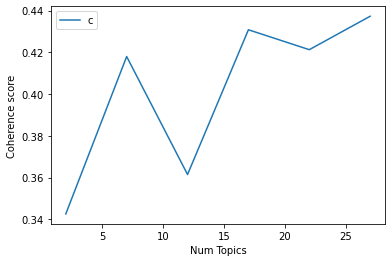

In [161]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [162]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.3426
index: 1 | Num Topics = 7  has Coherence Value of 0.418
index: 2 | Num Topics = 12  has Coherence Value of 0.3615
index: 3 | Num Topics = 17  has Coherence Value of 0.4308
index: 4 | Num Topics = 22  has Coherence Value of 0.4213
index: 5 | Num Topics = 27  has Coherence Value of 0.4373


In [208]:
# Select optimal number of topics
optimal_model_ph_2019_score1N2N3 = model_list_ph_2019_score1N2N3[3]

In [209]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2019_score1N2N3, corpus_ph_2019_score1N2N3, id2word_ph_2019_score1N2N3)

In [210]:
print("pyLDAVis for ph topics for score=1,2,3 in 2019:")
vis_ph_2019_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.225213  0.007450       1        1  10.583217
14     0.068119  0.118518       2        1   9.967546
15     0.048675  0.026333       3        1   9.243804
7     -0.017220  0.096302       4        1   7.988852
8      0.079544 -0.028139       5        1   7.223236
2      0.000092 -0.148267       6        1   6.761468
16     0.107484  0.026612       7        1   6.613408
6      0.044140  0.067332       8        1   6.603679
4     -0.031250  0.057639       9        1   5.925905
0     -0.103696 -0.036741      10        1   5.923857
1     -0.079302  0.007437      11        1   5.560345
10     0.009029  0.087343      12        1   4.609245
13     0.084381 -0.105491      13        1   4.453187
9     -0.016421  0.045159      14        1   4.429052
12     0.013825 -0.073019      15        1   1.661802
3     -0.003402 -0.081063      16        1   1.248354
11     0.021215 -0.067405      17        1   1.203044, topic_info=        Term       Freq      Total Category  logprob  loglift
6     filter  42.000000  42.000000  Default  30.0000  30.0000
8      crash  11.000000  11.000000  Default  29.0000  29.0000
29       app  27.000000  27.000000  Default  28.0000  28.0000
12  snapchat  37.000000  37.000000  Default  27.0000  27.0000
22      work  13.000000  13.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
16   anymore   0.023057   5.252172  Topic17  -6.3333  -1.0081
17    effect   0.023057   3.622940  Topic17  -6.3333  -0.6368
18      hate   0.023057   2.770478  Topic17  -6.3333  -0.3685
19     lense   0.023057   4.422316  Topic17  -6.3333  -0.8362
20      long   0.023057   2.846111  Topic17  -6.3333  -0.3954

[771 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
70        2  0.444461        access
70        4  0.444461        access
231       6  0.694890  accidentally
95        1  0.303077       account
95        2  0.202051       account
...     ...       ...           ...
275       1  0.458537          year
275      12  0.458537          year
305       4  0.686163         young
152      17  0.682306          zoom
199       6  0.694900         我信你个鬼

[722 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 15, 16, 8, 9, 3, 17, 7, 5, 1, 2, 11, 14, 10, 13, 4, 12])

## By-rating of 2020 (Rating=1,2,3)

In [166]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_ph_2020_score1N2N3 = snapchat_ios_ph_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_ph_2020_score1N2N3 = list(sent_to_words(review_ph_2020_score1N2N3))
print(review_words_ph_2020_score1N2N3[:1])

[['just', 'uninstall', 'my', 'snapchat', 'and', 'when', 'install', 'it', 'again', 'all', 'of', 'my', 'snaps', 'are', 'gone']]


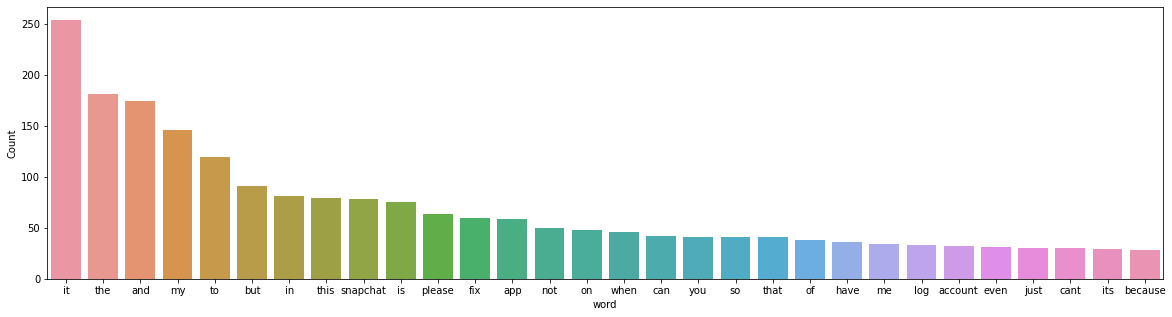

In [167]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2020_score1N2N3))

In [168]:
# Clean text
review_words_ph_ready_2020_score1N2N3 = process_words(review_words_ph_2020_score1N2N3)  # processed Text Data! - move to each section

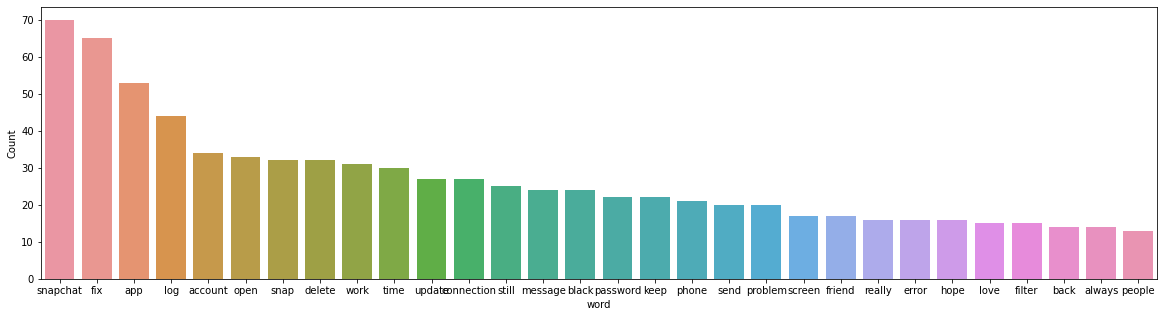

In [169]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2020_score1N2N3))


In [170]:
# Create Dictionary
id2word_ph_2020_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2020_score1N2N3)

2021-10-16 21:07:32,252 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 21:07:32,261 [INFO] gensim.corpora.dictionary - built Dictionary(558 unique tokens: ['install', 'snap', 'snapchat', 'uninstall', 'app']...) from 167 documents (total 2044 corpus positions)
2021-10-16 21:07:32,262 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(558 unique tokens: ['install', 'snap', 'snapchat', 'uninstall', 'app']...) from 167 documents (total 2044 corpus positions)", 'datetime': '2021-10-16T21:07:32.262148', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [171]:
# Create Corpus: Term Document Frequency
corpus_ph_2020_score1N2N3 = [id2word_ph_2020_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2020_score1N2N3]

In [172]:
# Training LDA model
model_list_ph_2020_score1N2N3, coherence_values_ph_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2020_score1N2N3, corpus=corpus_ph_2020_score1N2N3, 
                                                              texts=review_words_ph_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-16 21:07:32,866 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 21:07:32,903 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 21:07:32,933 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 21:07:32,960 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 167 documents, updating model once every 167 documents, evaluating perplexity every 167 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 21:07:33,554 [INFO] gensim.models.ldamodel - -6.953 per-word bound, 123.9 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:07:33,556 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #167/167
2021-10-16 21:07:34,119 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"fix" + 0.032*"snapchat" + 0.023*"app" + 0.019*"log" + 0.016*"work" + 0.015*"keep" + 0.013*"black"

2021-10-16 21:07:40,065 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"snapchat" + 0.019*"app" + 0.017*"message" + 0.017*"account" + 0.016*"snap" + 0.015*"delete" + 0.015*"fix" + 0.012*"open" + 0.011*"friend" + 0.011*"log"
2021-10-16 21:07:40,067 [INFO] gensim.models.ldamodel - topic diff=0.016860, rho=0.301511
2021-10-16 21:07:40,397 [INFO] gensim.models.ldamodel - -5.967 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:07:40,398 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #167/167
2021-10-16 21:07:40,654 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"fix" + 0.030*"snapchat" + 0.025*"log" + 0.022*"app" + 0.017*"keep" + 0.016*"work" + 0.016*"black" + 0.015*"password" + 0.015*"open" + 0.014*"time"
2021-10-16 21:07:40,655 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"snapchat" + 0.019*"app" + 0.018*"message" + 0.017*"account" + 0.016*"snap" + 0.016*"delete" + 0.015*"fix" + 

2021-10-16 21:07:45,895 [INFO] gensim.models.ldamodel - topic diff=0.008944, rho=0.218218
2021-10-16 21:07:46,168 [INFO] gensim.models.ldamodel - -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:07:46,169 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #167/167
2021-10-16 21:07:46,453 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"fix" + 0.032*"snapchat" + 0.028*"log" + 0.022*"app" + 0.017*"black" + 0.017*"open" + 0.017*"keep" + 0.016*"work" + 0.015*"connection" + 0.015*"password"
2021-10-16 21:07:46,455 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"snapchat" + 0.020*"app" + 0.019*"message" + 0.016*"delete" + 0.016*"snap" + 0.015*"account" + 0.015*"fix" + 0.012*"friend" + 0.010*"phone" + 0.010*"time"
2021-10-16 21:07:46,457 [INFO] gensim.models.ldamodel - topic diff=0.008090, rho=0.213201
2021-10-16 21:07:46,774 [INFO] gensim.models.ldamodel - -5.952 per-word bound, 61.9 perplex

2021-10-16 21:07:51,274 [INFO] gensim.models.ldamodel - topic diff=0.004395, rho=0.179605
2021-10-16 21:07:51,559 [INFO] gensim.models.ldamodel - -5.949 per-word bound, 61.8 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:07:51,560 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #167/167
2021-10-16 21:07:51,783 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"fix" + 0.033*"snapchat" + 0.029*"log" + 0.022*"app" + 0.018*"open" + 0.017*"black" + 0.016*"connection" + 0.016*"keep" + 0.015*"work" + 0.015*"password"
2021-10-16 21:07:51,785 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.021*"snapchat" + 0.020*"app" + 0.020*"message" + 0.016*"delete" + 0.016*"snap" + 0.014*"fix" + 0.014*"account" + 0.013*"friend" + 0.010*"phone" + 0.010*"download"
2021-10-16 21:07:51,788 [INFO] gensim.models.ldamodel - topic diff=0.004242, rho=0.176777
2021-10-16 21:07:52,151 [INFO] gensim.models.ldamodel - -5.948 per-word bound, 61.8 per

2021-10-16 21:07:56,680 [INFO] gensim.models.ldamodel - topic diff=0.003451, rho=0.156174
2021-10-16 21:07:56,934 [INFO] gensim.models.ldamodel - -5.946 per-word bound, 61.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:07:56,936 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #167/167
2021-10-16 21:07:57,168 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"fix" + 0.034*"snapchat" + 0.029*"log" + 0.022*"app" + 0.018*"open" + 0.017*"connection" + 0.017*"black" + 0.016*"keep" + 0.015*"work" + 0.015*"password"
2021-10-16 21:07:57,172 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"message" + 0.020*"snapchat" + 0.020*"app" + 0.016*"delete" + 0.016*"snap" + 0.014*"fix" + 0.013*"friend" + 0.013*"account" + 0.010*"phone" + 0.010*"download"
2021-10-16 21:07:57,173 [INFO] gensim.models.ldamodel - topic diff=0.003381, rho=0.154303
2021-10-16 21:07:57,502 [INFO] gensim.models.ldamodel - -5.946 per-word bound, 61.7 per

2021-10-16 21:08:01,667 [INFO] gensim.models.ldamodel - topic diff=0.002861, rho=0.140028
2021-10-16 21:08:01,669 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=558, num_topics=2, decay=0.5, chunksize=1000) in 28.71s', 'datetime': '2021-10-16T21:08:01.669339', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 21:08:01,672 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 21:08:06,348 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 21:08:06,378 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 155 virtual documents
2021-10-16 21:08:06,664 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 

2021-10-16 21:08:09,547 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.048*"snapchat" + 0.034*"fix" + 0.025*"open" + 0.021*"work" + 0.019*"password" + 0.019*"log" + 0.018*"app" + 0.018*"black" + 0.013*"white" + 0.012*"phone"
2021-10-16 21:08:09,548 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"delete" + 0.028*"fix" + 0.026*"update" + 0.020*"account" + 0.018*"app" + 0.017*"problem" + 0.017*"time" + 0.017*"snapchat" + 0.017*"still" + 0.015*"snap"
2021-10-16 21:08:09,552 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.050*"log" + 0.045*"connection" + 0.035*"account" + 0.032*"app" + 0.027*"error" + 0.019*"password" + 0.017*"internet" + 0.016*"number" + 0.016*"keep" + 0.016*"send"
2021-10-16 21:08:09,553 [INFO] gensim.models.ldamodel - topic diff=0.059486, rho=0.408248
2021-10-16 21:08:09,814 [INFO] gensim.models.ldamodel - -6.270 per-word bound, 77.2 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:09,816 [INFO] gensim.mod

2021-10-16 21:08:11,841 [INFO] gensim.models.ldamodel - topic diff=0.017169, rho=0.301511
2021-10-16 21:08:12,109 [INFO] gensim.models.ldamodel - -6.247 per-word bound, 75.9 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:12,111 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #167/167
2021-10-16 21:08:12,294 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.031*"snap" + 0.020*"chat" + 0.016*"open" + 0.016*"receive" + 0.016*"fix" + 0.016*"datum" + 0.014*"keep" + 0.012*"screen" + 0.012*"back" + 0.012*"phone"
2021-10-16 21:08:12,300 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.032*"snapchat" + 0.021*"filter" + 0.021*"bug" + 0.018*"update" + 0.017*"snap" + 0.017*"video" + 0.013*"fix" + 0.013*"app" + 0.013*"receive" + 0.013*"battery"
2021-10-16 21:08:12,303 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"fix" + 0.039*"app" + 0.034*"snapchat" + 0.028*"open" + 0.026*"update" + 0.020*"work" + 0.018*"black" + 0.01

2021-10-16 21:08:14,655 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.032*"snapchat" + 0.021*"filter" + 0.021*"bug" + 0.018*"update" + 0.017*"snap" + 0.017*"video" + 0.013*"fix" + 0.013*"app" + 0.013*"receive" + 0.013*"battery"
2021-10-16 21:08:14,657 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.031*"snap" + 0.020*"chat" + 0.016*"open" + 0.016*"receive" + 0.016*"fix" + 0.016*"datum" + 0.014*"keep" + 0.012*"back" + 0.012*"screen" + 0.012*"phone"
2021-10-16 21:08:14,661 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"snapchat" + 0.035*"fix" + 0.027*"open" + 0.022*"work" + 0.020*"black" + 0.019*"password" + 0.018*"app" + 0.016*"log" + 0.015*"white" + 0.013*"phone"
2021-10-16 21:08:14,662 [INFO] gensim.models.ldamodel - topic diff=0.006434, rho=0.242536
2021-10-16 21:08:14,832 [INFO] gensim.models.ldamodel - -6.235 per-word bound, 75.3 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:14,850 [INFO] gensim.models.ldamodel 

2021-10-16 21:08:16,915 [INFO] gensim.models.ldamodel - topic diff=0.005177, rho=0.213201
2021-10-16 21:08:17,154 [INFO] gensim.models.ldamodel - -6.230 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:17,155 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #167/167
2021-10-16 21:08:17,328 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.055*"fix" + 0.038*"app" + 0.035*"snapchat" + 0.029*"open" + 0.028*"update" + 0.021*"work" + 0.018*"black" + 0.017*"snap" + 0.015*"keep" + 0.015*"issue"
2021-10-16 21:08:17,338 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.074*"log" + 0.063*"connection" + 0.052*"account" + 0.039*"error" + 0.029*"app" + 0.023*"internet" + 0.020*"password" + 0.018*"sign" + 0.016*"fix" + 0.015*"keep"
2021-10-16 21:08:17,350 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"delete" + 0.024*"update" + 0.024*"fix" + 0.020*"app" + 0.019*"still" + 0.019*"message" + 0.017*"time" + 

2021-10-16 21:08:19,475 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"delete" + 0.024*"update" + 0.024*"fix" + 0.021*"app" + 0.019*"still" + 0.019*"message" + 0.017*"time" + 0.016*"snap" + 0.015*"send" + 0.014*"snapchat"
2021-10-16 21:08:19,480 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.078*"log" + 0.062*"connection" + 0.053*"account" + 0.039*"error" + 0.029*"app" + 0.023*"internet" + 0.020*"password" + 0.019*"sign" + 0.016*"fix" + 0.015*"keep"
2021-10-16 21:08:19,491 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"snapchat" + 0.035*"fix" + 0.028*"open" + 0.022*"work" + 0.021*"black" + 0.018*"password" + 0.018*"app" + 0.015*"white" + 0.013*"phone" + 0.013*"screen"
2021-10-16 21:08:19,503 [INFO] gensim.models.ldamodel - topic diff=0.004679, rho=0.188982
2021-10-16 21:08:19,671 [INFO] gensim.models.ldamodel - -6.222 per-word bound, 74.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:19,672 [INFO] gensim.models

2021-10-16 21:08:21,537 [INFO] gensim.models.ldamodel - topic diff=0.003642, rho=0.174078
2021-10-16 21:08:21,766 [INFO] gensim.models.ldamodel - -6.217 per-word bound, 74.4 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:21,768 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #167/167
2021-10-16 21:08:21,903 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"snap" + 0.020*"chat" + 0.016*"receive" + 0.016*"datum" + 0.015*"keep" + 0.013*"open" + 0.013*"fix" + 0.012*"back" + 0.012*"phone" + 0.012*"wifi"
2021-10-16 21:08:21,913 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"snapchat" + 0.035*"fix" + 0.029*"open" + 0.022*"black" + 0.021*"work" + 0.018*"password" + 0.018*"app" + 0.015*"white" + 0.014*"phone" + 0.014*"screen"
2021-10-16 21:08:21,915 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.080*"log" + 0.061*"connection" + 0.055*"account" + 0.039*"error" + 0.029*"app" + 0.022*"internet" + 0.021*"password

2021-10-16 21:08:23,945 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.055*"fix" + 0.038*"app" + 0.035*"snapchat" + 0.029*"open" + 0.028*"update" + 0.021*"work" + 0.018*"black" + 0.017*"snap" + 0.016*"keep" + 0.015*"issue"
2021-10-16 21:08:23,949 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"snapchat" + 0.035*"fix" + 0.029*"open" + 0.022*"black" + 0.021*"work" + 0.018*"password" + 0.018*"app" + 0.015*"white" + 0.014*"screen" + 0.014*"phone"
2021-10-16 21:08:23,953 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.031*"snapchat" + 0.021*"filter" + 0.021*"bug" + 0.018*"update" + 0.017*"snap" + 0.017*"video" + 0.014*"fix" + 0.013*"app" + 0.013*"receive" + 0.013*"battery"
2021-10-16 21:08:23,956 [INFO] gensim.models.ldamodel - topic diff=0.002391, rho=0.160128
2021-10-16 21:08:24,157 [INFO] gensim.models.ldamodel - -6.214 per-word bound, 74.3 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:24,159 [INFO] gensim.models.ldamod

2021-10-16 21:08:25,978 [INFO] gensim.models.ldamodel - topic diff=0.001910, rho=0.150756
2021-10-16 21:08:26,162 [INFO] gensim.models.ldamodel - -6.213 per-word bound, 74.2 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:26,167 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #167/167
2021-10-16 21:08:26,324 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.031*"snapchat" + 0.021*"filter" + 0.021*"bug" + 0.018*"update" + 0.017*"snap" + 0.017*"video" + 0.014*"fix" + 0.013*"app" + 0.013*"receive" + 0.013*"battery"
2021-10-16 21:08:26,327 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.055*"fix" + 0.038*"app" + 0.035*"snapchat" + 0.029*"open" + 0.028*"update" + 0.021*"work" + 0.018*"black" + 0.017*"snap" + 0.016*"keep" + 0.015*"problem"
2021-10-16 21:08:26,334 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.081*"log" + 0.059*"connection" + 0.056*"account" + 0.038*"error" + 0.029*"app" + 0.022*"password" + 0.022*"int

2021-10-16 21:08:28,160 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.081*"log" + 0.059*"connection" + 0.056*"account" + 0.038*"error" + 0.029*"app" + 0.022*"password" + 0.022*"internet" + 0.018*"sign" + 0.018*"fix" + 0.015*"keep"
2021-10-16 21:08:28,162 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"snap" + 0.020*"chat" + 0.016*"receive" + 0.016*"datum" + 0.015*"keep" + 0.013*"open" + 0.012*"fix" + 0.012*"back" + 0.012*"phone" + 0.012*"wifi"
2021-10-16 21:08:28,163 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"delete" + 0.024*"fix" + 0.024*"update" + 0.023*"message" + 0.021*"app" + 0.018*"still" + 0.016*"time" + 0.016*"send" + 0.016*"snap" + 0.014*"friend"
2021-10-16 21:08:28,164 [INFO] gensim.models.ldamodel - topic diff=0.001340, rho=0.141421
2021-10-16 21:08:28,396 [INFO] gensim.models.ldamodel - -6.212 per-word bound, 74.1 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:28,397 [INFO] gensim.models.ldamodel

2021-10-16 21:08:36,177 [INFO] gensim.models.ldamodel - -6.455 per-word bound, 87.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:36,220 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #167/167
2021-10-16 21:08:36,309 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.031*"fix" + 0.029*"streak" + 0.026*"snapchat" + 0.024*"work" + 0.022*"issue" + 0.017*"log" + 0.016*"send" + 0.016*"update" + 0.016*"iphone" + 0.016*"count"
2021-10-16 21:08:36,310 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.037*"time" + 0.028*"log" + 0.025*"app" + 0.023*"still" + 0.019*"password" + 0.018*"let" + 0.017*"connection" + 0.015*"keep" + 0.015*"send" + 0.014*"people"
2021-10-16 21:08:36,312 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.042*"connection" + 0.031*"fix" + 0.026*"snapchat" + 0.025*"error" + 0.022*"problem" + 0.022*"log" + 0.022*"update" + 0.022*"account" + 0.020*"work" + 0.020*"snap"
2021-10-16 21:08:36,314 [INFO] gensim

2021-10-16 21:08:38,582 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.050*"snapchat" + 0.041*"black" + 0.029*"screen" + 0.029*"phone" + 0.028*"white" + 0.027*"fix" + 0.022*"friend" + 0.021*"delete" + 0.019*"turn" + 0.019*"email"
2021-10-16 21:08:38,587 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.041*"time" + 0.027*"log" + 0.025*"app" + 0.024*"still" + 0.021*"password" + 0.019*"let" + 0.018*"keep" + 0.017*"connection" + 0.015*"send" + 0.015*"people"
2021-10-16 21:08:38,590 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.041*"sign" + 0.040*"keep" + 0.028*"app" + 0.021*"face" + 0.021*"reinstall" + 0.020*"fix" + 0.020*"video" + 0.016*"always" + 0.015*"log" + 0.014*"snapchat"
2021-10-16 21:08:38,591 [INFO] gensim.models.ldamodel - topic diff=0.030155, rho=0.316228
2021-10-16 21:08:38,885 [INFO] gensim.models.ldamodel - -6.361 per-word bound, 82.2 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:38,887 [INFO] gensim.models.lda

2021-10-16 21:08:40,770 [INFO] gensim.models.ldamodel - topic diff=0.011504, rho=0.258199
2021-10-16 21:08:40,956 [INFO] gensim.models.ldamodel - -6.345 per-word bound, 81.3 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:40,957 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #167/167
2021-10-16 21:08:41,121 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.032*"fix" + 0.032*"streak" + 0.025*"snapchat" + 0.024*"work" + 0.024*"issue" + 0.016*"log" + 0.016*"update" + 0.016*"send" + 0.016*"iphone" + 0.016*"count"
2021-10-16 21:08:41,125 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"snap" + 0.027*"datum" + 0.027*"chat" + 0.027*"receive" + 0.020*"fix" + 0.020*"connect" + 0.020*"account" + 0.014*"add" + 0.014*"quick" + 0.014*"hope"
2021-10-16 21:08:41,128 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.061*"snapchat" + 0.028*"fix" + 0.025*"app" + 0.023*"password" + 0.023*"message" + 0.020*"work" + 0.020*"open" +

2021-10-16 21:08:43,000 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.045*"log" + 0.028*"app" + 0.028*"connect" + 0.028*"send" + 0.015*"account" + 0.015*"snap" + 0.014*"snapchat" + 0.014*"password" + 0.014*"check" + 0.014*"suddenly"
2021-10-16 21:08:43,003 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.032*"fix" + 0.032*"streak" + 0.025*"snapchat" + 0.024*"work" + 0.024*"issue" + 0.016*"log" + 0.016*"update" + 0.016*"send" + 0.016*"iphone" + 0.016*"count"
2021-10-16 21:08:43,006 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.036*"fix" + 0.031*"people" + 0.021*"still" + 0.020*"work" + 0.017*"app" + 0.017*"time" + 0.015*"log" + 0.015*"send" + 0.015*"well" + 0.015*"uninstall"
2021-10-16 21:08:43,008 [INFO] gensim.models.ldamodel - topic diff=0.004996, rho=0.218218
2021-10-16 21:08:43,261 [INFO] gensim.models.ldamodel - -6.338 per-word bound, 80.9 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:43,264 [INFO] gensim.models.lda

2021-10-16 21:08:45,161 [INFO] gensim.models.ldamodel - topic diff=0.002759, rho=0.196116
2021-10-16 21:08:45,414 [INFO] gensim.models.ldamodel - -6.334 per-word bound, 80.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:45,416 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #167/167
2021-10-16 21:08:45,546 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.036*"fix" + 0.031*"people" + 0.022*"still" + 0.020*"work" + 0.017*"app" + 0.016*"log" + 0.016*"send" + 0.015*"well" + 0.015*"time" + 0.015*"uninstall"
2021-10-16 21:08:45,547 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.058*"connection" + 0.036*"account" + 0.034*"error" + 0.033*"log" + 0.029*"update" + 0.027*"fix" + 0.025*"problem" + 0.024*"snapchat" + 0.020*"always" + 0.018*"snap"
2021-10-16 21:08:45,549 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.059*"snapchat" + 0.043*"black" + 0.029*"screen" + 0.028*"fix" + 0.028*"white" + 0.028*"phone" + 0.026*"op

2021-10-16 21:08:47,706 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.039*"snapchat" + 0.029*"bug" + 0.029*"snap" + 0.027*"fix" + 0.022*"filter" + 0.022*"effect" + 0.022*"update" + 0.017*"open" + 0.015*"thing" + 0.015*"much"
2021-10-16 21:08:47,710 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.039*"snap" + 0.027*"chat" + 0.027*"datum" + 0.027*"receive" + 0.021*"connect" + 0.021*"account" + 0.019*"fix" + 0.014*"add" + 0.014*"quick" + 0.014*"hope"
2021-10-16 21:08:47,713 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.036*"fix" + 0.031*"people" + 0.022*"still" + 0.020*"work" + 0.017*"app" + 0.016*"log" + 0.016*"send" + 0.015*"well" + 0.015*"uninstall" + 0.015*"snap"
2021-10-16 21:08:47,715 [INFO] gensim.models.ldamodel - topic diff=0.001336, rho=0.176777
2021-10-16 21:08:47,909 [INFO] gensim.models.ldamodel - -6.333 per-word bound, 80.6 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:47,912 [INFO] gensim.models.ldamodel - P

2021-10-16 21:08:49,693 [INFO] gensim.models.ldamodel - topic diff=0.000802, rho=0.164399
2021-10-16 21:08:50,003 [INFO] gensim.models.ldamodel - -6.332 per-word bound, 80.6 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:50,008 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #167/167
2021-10-16 21:08:50,091 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"time" + 0.026*"log" + 0.025*"app" + 0.025*"still" + 0.023*"password" + 0.021*"keep" + 0.019*"let" + 0.017*"connection" + 0.015*"send" + 0.015*"people"
2021-10-16 21:08:50,093 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.076*"app" + 0.061*"open" + 0.041*"black" + 0.031*"fix" + 0.029*"keep" + 0.026*"account" + 0.024*"whenever" + 0.022*"screen" + 0.020*"still" + 0.014*"show"
2021-10-16 21:08:50,094 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.042*"log" + 0.028*"app" + 0.028*"connect" + 0.028*"send" + 0.015*"account" + 0.015*"snap" + 0.014*"snapchat" +

2021-10-16 21:08:52,160 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.039*"snap" + 0.027*"chat" + 0.027*"receive" + 0.027*"datum" + 0.021*"connect" + 0.021*"account" + 0.019*"fix" + 0.014*"hope" + 0.014*"add" + 0.014*"wifi"
2021-10-16 21:08:52,162 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.058*"connection" + 0.037*"account" + 0.035*"error" + 0.034*"log" + 0.028*"update" + 0.027*"fix" + 0.025*"problem" + 0.024*"snapchat" + 0.020*"always" + 0.018*"snap"
2021-10-16 21:08:52,165 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.036*"fix" + 0.031*"people" + 0.022*"still" + 0.020*"work" + 0.017*"app" + 0.016*"log" + 0.016*"send" + 0.015*"well" + 0.015*"uninstall" + 0.015*"snap"
2021-10-16 21:08:52,165 [INFO] gensim.models.ldamodel - topic diff=0.000493, rho=0.152499
2021-10-16 21:08:52,391 [INFO] gensim.models.ldamodel - -6.332 per-word bound, 80.6 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:52,393 [INFO] gensim.models.ld

2021-10-16 21:08:54,149 [INFO] gensim.models.ldamodel - topic diff=0.000305, rho=0.144338
2021-10-16 21:08:54,384 [INFO] gensim.models.ldamodel - -6.332 per-word bound, 80.5 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:08:54,385 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #167/167
2021-10-16 21:08:54,524 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.043*"log" + 0.028*"app" + 0.028*"connect" + 0.028*"send" + 0.015*"snap" + 0.015*"account" + 0.014*"password" + 0.014*"check" + 0.014*"email" + 0.014*"snapchat"
2021-10-16 21:08:54,526 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.060*"snapchat" + 0.042*"black" + 0.029*"screen" + 0.029*"fix" + 0.028*"white" + 0.027*"phone" + 0.027*"open" + 0.024*"delete" + 0.021*"friend" + 0.020*"turn"
2021-10-16 21:08:54,527 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.059*"snapchat" + 0.028*"password" + 0.027*"fix" + 0.025*"app" + 0.024*"work" + 0.023*"message" + 0.019*"

2021-10-16 21:09:04,183 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.055*"app" + 0.041*"fix" + 0.040*"delete" + 0.018*"love" + 0.017*"eye" + 0.017*"face" + 0.017*"slow" + 0.017*"help" + 0.016*"connection" + 0.015*"snap"
2021-10-16 21:09:04,185 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.046*"log" + 0.043*"app" + 0.025*"account" + 0.025*"time" + 0.018*"snap" + 0.017*"delete" + 0.017*"still" + 0.017*"let" + 0.017*"day" + 0.017*"record"
2021-10-16 21:09:04,187 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.035*"update" + 0.028*"people" + 0.027*"work" + 0.024*"still" + 0.019*"send" + 0.019*"app" + 0.019*"fix" + 0.017*"problem" + 0.015*"snap" + 0.015*"tell"
2021-10-16 21:09:04,190 [INFO] gensim.models.ldamodel - topic diff=0.160965, rho=0.577350
2021-10-16 21:09:04,421 [INFO] gensim.models.ldamodel - -6.624 per-word bound, 98.6 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:04,433 [INFO] gensim.models.ldamodel - PROGRESS:

2021-10-16 21:09:06,296 [INFO] gensim.models.ldamodel - topic diff=0.045772, rho=0.353553
2021-10-16 21:09:06,529 [INFO] gensim.models.ldamodel - -6.502 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:06,530 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #167/167
2021-10-16 21:09:06,645 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.049*"keep" + 0.031*"log" + 0.026*"connection" + 0.023*"app" + 0.023*"open" + 0.023*"account" + 0.023*"snapchat" + 0.023*"password" + 0.022*"reinstall" + 0.021*"time"
2021-10-16 21:09:06,647 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.029*"snap" + 0.029*"snapchat" + 0.029*"install" + 0.029*"uninstall" + 0.002*"chat" + 0.002*"receive" + 0.002*"back" + 0.002*"camera" + 0.002*"iphone" + 0.002*"front"
2021-10-16 21:09:06,653 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.036*"receive" + 0.029*"people" + 0.022*"problem" + 0.022*"chat" + 0.021*"time" + 0.020*"co

2021-10-16 21:09:08,769 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.047*"password" + 0.032*"fix" + 0.032*"work" + 0.032*"snap" + 0.032*"datum" + 0.024*"correct" + 0.024*"connect" + 0.024*"compatible" + 0.016*"snapchat" + 0.016*"friend"
2021-10-16 21:09:08,771 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.063*"snapchat" + 0.032*"fix" + 0.032*"turn" + 0.032*"still" + 0.032*"open" + 0.032*"black" + 0.031*"iphone" + 0.016*"issue" + 0.016*"photo" + 0.016*"picture"
2021-10-16 21:09:08,774 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.054*"snapchat" + 0.040*"snap" + 0.039*"fix" + 0.029*"camera" + 0.022*"work" + 0.018*"delete" + 0.018*"white" + 0.018*"phone" + 0.016*"problem" + 0.015*"back"
2021-10-16 21:09:08,777 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.029*"snap" + 0.029*"snapchat" + 0.029*"install" + 0.029*"uninstall" + 0.002*"chat" + 0.002*"receive" + 0.002*"back" + 0.002*"camera" + 0.002*"iphone" + 0.002*"front"
2021-10-16 21:09:08,778 [INFO] gensim.models

2021-10-16 21:09:10,790 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.047*"snapchat" + 0.029*"app" + 0.029*"open" + 0.025*"fix" + 0.024*"account" + 0.021*"message" + 0.020*"log" + 0.019*"connection" + 0.018*"time" + 0.018*"tell"
2021-10-16 21:09:10,791 [INFO] gensim.models.ldamodel - topic diff=0.009558, rho=0.229416
2021-10-16 21:09:11,035 [INFO] gensim.models.ldamodel - -6.467 per-word bound, 88.5 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:11,036 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #167/167
2021-10-16 21:09:11,164 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.047*"email" + 0.039*"download" + 0.039*"phone" + 0.025*"fix" + 0.024*"number" + 0.024*"account" + 0.024*"zoom" + 0.016*"quick" + 0.016*"add" + 0.016*"send"
2021-10-16 21:09:11,165 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.029*"snap" + 0.029*"snapchat" + 0.029*"install" + 0.029*"uninstall" + 0.002*"chat" + 0.002*"receive" + 0.0

2021-10-16 21:09:13,150 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.040*"still" + 0.030*"time" + 0.020*"password" + 0.020*"clearly" + 0.020*"storage" + 0.020*"set" + 0.020*"nt" + 0.020*"keep" + 0.020*"thick" + 0.020*"happen"
2021-10-16 21:09:13,153 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.029*"snap" + 0.029*"snapchat" + 0.029*"install" + 0.029*"uninstall" + 0.002*"chat" + 0.002*"receive" + 0.002*"back" + 0.002*"camera" + 0.002*"iphone" + 0.002*"front"
2021-10-16 21:09:13,156 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.048*"snapchat" + 0.044*"filter" + 0.041*"log" + 0.039*"fix" + 0.026*"message" + 0.026*"sign" + 0.024*"update" + 0.021*"hope" + 0.021*"bring" + 0.021*"back"
2021-10-16 21:09:13,157 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.087*"open" + 0.066*"black" + 0.065*"app" + 0.053*"fix" + 0.035*"keep" + 0.033*"snapchat" + 0.033*"screen" + 0.031*"update" + 0.028*"delete" + 0.023*"whenever"
2021-10-16 21:09:13,159 [INFO] gensim.models.ldamodel - 

2021-10-16 21:09:15,181 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.037*"receive" + 0.030*"people" + 0.029*"problem" + 0.022*"chat" + 0.022*"always" + 0.021*"time" + 0.015*"hoop" + 0.015*"accept" + 0.015*"capture" + 0.015*"unread"
2021-10-16 21:09:15,187 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.050*"email" + 0.041*"download" + 0.041*"phone" + 0.025*"number" + 0.025*"account" + 0.025*"zoom" + 0.021*"fix" + 0.017*"quick" + 0.017*"add" + 0.017*"send"
2021-10-16 21:09:15,190 [INFO] gensim.models.ldamodel - topic diff=0.006616, rho=0.182574
2021-10-16 21:09:15,359 [INFO] gensim.models.ldamodel - -6.440 per-word bound, 86.8 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:15,360 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #167/167
2021-10-16 21:09:15,585 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.029*"snap" + 0.029*"snapchat" + 0.029*"install" + 0.029*"uninstall" + 0.002*"chat" + 0.002*"receive" +

2021-10-16 21:09:17,516 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #167/167
2021-10-16 21:09:17,651 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.041*"update" + 0.036*"work" + 0.032*"people" + 0.023*"still" + 0.022*"problem" + 0.021*"app" + 0.020*"fix" + 0.018*"send" + 0.018*"snap" + 0.017*"time"
2021-10-16 21:09:17,653 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.052*"snapchat" + 0.042*"snap" + 0.040*"fix" + 0.031*"camera" + 0.022*"work" + 0.020*"delete" + 0.020*"phone" + 0.018*"white" + 0.016*"problem" + 0.016*"back"
2021-10-16 21:09:17,654 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.051*"snapchat" + 0.034*"fix" + 0.034*"turn" + 0.034*"still" + 0.034*"black" + 0.034*"open" + 0.034*"iphone" + 0.017*"photo" + 0.017*"resolve" + 0.017*"picture"
2021-10-16 21:09:17,656 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.050*"snapchat" + 0.031*"open" + 0.030*"app" + 0.027*"fix" + 0.022*"message" + 0.019*"tell" + 0.019*"time" + 0.016*"black" + 0.01

2021-10-16 21:09:19,903 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"snapchat" + 0.028*"snap" + 0.028*"much" + 0.021*"story" + 0.021*"thing" + 0.021*"friend" + 0.021*"bug" + 0.014*"keep" + 0.014*"number" + 0.014*"view"
2021-10-16 21:09:19,905 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.047*"password" + 0.032*"fix" + 0.032*"work" + 0.032*"snap" + 0.032*"datum" + 0.024*"correct" + 0.024*"connect" + 0.024*"compatible" + 0.016*"snapchat" + 0.016*"friend"
2021-10-16 21:09:19,909 [INFO] gensim.models.ldamodel - topic diff=0.003542, rho=0.156174
2021-10-16 21:09:20,146 [INFO] gensim.models.ldamodel - -6.420 per-word bound, 85.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:20,148 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #167/167
2021-10-16 21:09:20,282 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.050*"snapchat" + 0.031*"open" + 0.030*"app" + 0.027*"fix" + 0.022*"message" + 0.020*"tell" + 0.01

2021-10-16 21:09:22,180 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #167/167
2021-10-16 21:09:22,321 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.088*"open" + 0.076*"black" + 0.066*"app" + 0.054*"fix" + 0.043*"screen" + 0.037*"snapchat" + 0.036*"keep" + 0.030*"delete" + 0.028*"update" + 0.020*"whenever"
2021-10-16 21:09:22,329 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"snapchat" + 0.028*"snap" + 0.028*"much" + 0.021*"story" + 0.021*"thing" + 0.021*"friend" + 0.021*"bug" + 0.014*"keep" + 0.014*"view" + 0.014*"number"
2021-10-16 21:09:22,353 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.062*"account" + 0.047*"log" + 0.030*"fix" + 0.028*"snapchat" + 0.027*"delete" + 0.022*"friend" + 0.019*"app" + 0.016*"phone" + 0.016*"appear" + 0.016*"password"
2021-10-16 21:09:22,357 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.049*"snapchat" + 0.046*"filter" + 0.042*"log" + 0.039*"fix" + 0.026*"message" + 0.026*"sign" + 0.024*"update" + 0.021*"hope

2021-10-16 21:09:32,284 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 21:09:32,290 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 21:09:32,299 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 21:09:32,307 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 167 documents, updating model once every 167 documents, evaluating perplexity every 167 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 21:09:32,715 [INFO] gensim.models.ldamodel - -17.634 per-word bound, 203402.5 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:32,716 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #167/167
2021-10-16 21:09:33,067 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.034*"message" + 0.033*"update" + 0.030*"delete" + 0.024*"still"

2021-10-16 21:09:34,870 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:34,871 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #167/167
2021-10-16 21:09:35,018 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.061*"connection" + 0.048*"error" + 0.044*"snapchat" + 0.037*"open" + 0.032*"log" + 0.025*"video" + 0.025*"always" + 0.025*"account" + 0.013*"stop" + 0.013*"keep"
2021-10-16 21:09:35,020 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.032*"chat" + 0.032*"load" + 0.032*"download" + 0.021*"app" + 0.021*"fix" + 0.021*"update" + 0.021*"work" + 0.021*"reinstall" + 0.021*"show" + 0.021*"new"
2021-10-16 21:09:35,021 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.043*"password" + 0.039*"work" + 0.039*"number" + 0.030*"story" + 0.020*"correct" + 0.020*"day" + 0.020*"view" + 0.020*"sad" + 0.020*"put" + 0.020*"picture"
2021-10-16 21:09:35,023 [INFO] gensim.m

2021-10-16 21:09:36,736 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.040*"log" + 0.040*"fix" + 0.040*"app" + 0.027*"let" + 0.027*"time" + 0.027*"memory" + 0.027*"save" + 0.027*"crash" + 0.014*"snap" + 0.014*"month"
2021-10-16 21:09:36,741 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.058*"snapchat" + 0.049*"account" + 0.042*"black" + 0.038*"app" + 0.037*"open" + 0.035*"log" + 0.030*"fix" + 0.019*"delete" + 0.017*"work" + 0.016*"find"
2021-10-16 21:09:36,751 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.027*"work" + 0.027*"snap" + 0.027*"connection" + 0.027*"account" + 0.023*"password" + 0.018*"app" + 0.018*"capture" + 0.018*"ask" + 0.018*"receive" + 0.018*"log"
2021-10-16 21:09:36,757 [INFO] gensim.models.ldamodel - topic diff=0.019740, rho=0.288675
2021-10-16 21:09:36,932 [INFO] gensim.models.ldamodel - -6.542 per-word bound, 93.2 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:36,935 [INFO] gensim.models.ldamodel -

2021-10-16 21:09:38,526 [INFO] gensim.models.ldamodel - topic diff=0.005978, rho=0.242536
2021-10-16 21:09:38,775 [INFO] gensim.models.ldamodel - -6.538 per-word bound, 92.9 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:38,776 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #167/167
2021-10-16 21:09:38,856 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.071*"open" + 0.034*"message" + 0.034*"keep" + 0.034*"mode" + 0.034*"dark" + 0.033*"app" + 0.032*"update" + 0.023*"time" + 0.023*"phone" + 0.023*"life"
2021-10-16 21:09:38,858 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.046*"update" + 0.038*"message" + 0.031*"still" + 0.031*"problem" + 0.023*"delete" + 0.023*"fix" + 0.023*"people" + 0.023*"app" + 0.023*"sometimes" + 0.023*"work"
2021-10-16 21:09:38,860 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.060*"snapchat" + 0.052*"log" + 0.040*"password" + 0.025*"message" + 0.025*"help" + 0.025*"filter" + 0.020*"s

2021-10-16 21:09:40,781 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.043*"fix" + 0.041*"snapchat" + 0.041*"snap" + 0.032*"back" + 0.023*"screen" + 0.023*"log" + 0.018*"camera" + 0.018*"white" + 0.018*"black" + 0.018*"bring"
2021-10-16 21:09:40,782 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.060*"snapchat" + 0.052*"log" + 0.040*"password" + 0.025*"message" + 0.025*"help" + 0.025*"filter" + 0.020*"save" + 0.018*"app" + 0.015*"fix" + 0.015*"eye"
2021-10-16 21:09:40,784 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.032*"snap" + 0.032*"snapchat" + 0.032*"archive" + 0.032*"pls" + 0.032*"old" + 0.032*"woala" + 0.032*"papansin" + 0.001*"datum" + 0.001*"connect" + 0.001*"keep"
2021-10-16 21:09:40,786 [INFO] gensim.models.ldamodel - topic diff=0.001707, rho=0.208514
2021-10-16 21:09:41,129 [INFO] gensim.models.ldamodel - -6.536 per-word bound, 92.8 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:41,130 [INFO] gensim.models.l

2021-10-16 21:09:43,039 [INFO] gensim.models.ldamodel - topic diff=0.000708, rho=0.188982
2021-10-16 21:09:43,275 [INFO] gensim.models.ldamodel - -6.536 per-word bound, 92.8 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:43,277 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #167/167
2021-10-16 21:09:43,412 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.040*"log" + 0.040*"fix" + 0.040*"app" + 0.027*"let" + 0.027*"time" + 0.027*"save" + 0.027*"memory" + 0.027*"crash" + 0.014*"snap" + 0.014*"delete"
2021-10-16 21:09:43,413 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.087*"snapchat" + 0.052*"fix" + 0.035*"black" + 0.035*"open" + 0.026*"still" + 0.026*"turn" + 0.026*"iphone" + 0.018*"nt" + 0.018*"app" + 0.018*"annoying"
2021-10-16 21:09:43,415 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.032*"load" + 0.032*"chat" + 0.032*"download" + 0.021*"app" + 0.021*"fix" + 0.021*"work" + 0.021*"update" + 0.021*"reinst

2021-10-16 21:09:45,446 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.043*"fix" + 0.041*"snapchat" + 0.041*"snap" + 0.032*"back" + 0.023*"screen" + 0.023*"log" + 0.018*"white" + 0.018*"camera" + 0.018*"black" + 0.018*"bring"
2021-10-16 21:09:45,452 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.046*"update" + 0.038*"message" + 0.031*"still" + 0.031*"problem" + 0.023*"delete" + 0.023*"fix" + 0.023*"people" + 0.023*"app" + 0.023*"sometimes" + 0.023*"work"
2021-10-16 21:09:45,454 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.070*"open" + 0.035*"message" + 0.035*"keep" + 0.035*"mode" + 0.035*"dark" + 0.033*"update" + 0.030*"app" + 0.023*"time" + 0.023*"phone" + 0.023*"life"
2021-10-16 21:09:45,455 [INFO] gensim.models.ldamodel - topic diff=0.000306, rho=0.171499
2021-10-16 21:09:45,694 [INFO] gensim.models.ldamodel - -6.535 per-word bound, 92.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:45,698 [INFO] gensim.models.lda

2021-10-16 21:09:47,526 [INFO] gensim.models.ldamodel - topic diff=0.000184, rho=0.160128
2021-10-16 21:09:47,783 [INFO] gensim.models.ldamodel - -6.535 per-word bound, 92.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:47,791 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #167/167
2021-10-16 21:09:47,968 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.049*"tell" + 0.049*"really" + 0.037*"app" + 0.037*"snapchat" + 0.025*"friend" + 0.025*"work" + 0.025*"zoom" + 0.013*"rude" + 0.013*"scared" + 0.013*"turn"
2021-10-16 21:09:47,971 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.027*"work" + 0.027*"snap" + 0.027*"connection" + 0.027*"account" + 0.024*"password" + 0.018*"app" + 0.018*"capture" + 0.018*"ask" + 0.018*"receive" + 0.018*"log"
2021-10-16 21:09:47,974 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.046*"update" + 0.038*"message" + 0.031*"still" + 0.031*"problem" + 0.023*"delete" + 0.023*"fix" + 0.023

2021-10-16 21:09:50,343 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.032*"fix" + 0.021*"snap" + 0.021*"still" + 0.021*"snapchat" + 0.021*"send" + 0.021*"tell" + 0.021*"back" + 0.021*"thing" + 0.021*"memory" + 0.021*"keep"
2021-10-16 21:09:50,346 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.043*"phone" + 0.038*"email" + 0.035*"work" + 0.028*"account" + 0.025*"keep" + 0.023*"fix" + 0.020*"snapchat" + 0.019*"camera" + 0.019*"snap" + 0.019*"iphone"
2021-10-16 21:09:50,348 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.037*"update" + 0.037*"receive" + 0.028*"chat" + 0.028*"gon" + 0.019*"message" + 0.019*"change" + 0.019*"fix" + 0.019*"look" + 0.019*"long" + 0.019*"read"
2021-10-16 21:09:50,350 [INFO] gensim.models.ldamodel - topic diff=0.000113, rho=0.149071
2021-10-16 21:09:50,577 [INFO] gensim.models.ldamodel - -6.535 per-word bound, 92.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:50,579 [INFO] gensim.models.ldamod

2021-10-16 21:09:52,341 [INFO] gensim.models.ldamodel - topic diff=0.000086, rho=0.141421
2021-10-16 21:09:52,676 [INFO] gensim.models.ldamodel - -6.535 per-word bound, 92.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:09:52,678 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #167/167
2021-10-16 21:09:52,894 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.062*"connection" + 0.050*"error" + 0.044*"snapchat" + 0.037*"open" + 0.031*"log" + 0.025*"always" + 0.025*"video" + 0.025*"account" + 0.013*"love" + 0.013*"last"
2021-10-16 21:09:52,900 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.029*"update" + 0.029*"keep" + 0.029*"error" + 0.029*"app" + 0.029*"connection" + 0.029*"connect" + 0.029*"issue" + 0.029*"still" + 0.029*"username" + 0.029*"let"
2021-10-16 21:09:52,902 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.040*"log" + 0.040*"fix" + 0.040*"app" + 0.027*"let" + 0.027*"time" + 0.027*"save" + 0.027*"memory"

2021-10-16 21:10:05,036 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.045*"always" + 0.032*"keep" + 0.032*"video" + 0.032*"open" + 0.032*"black" + 0.031*"icon" + 0.017*"love" + 0.017*"stop" + 0.017*"start" + 0.017*"scroll"
2021-10-16 21:10:05,045 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.036*"time" + 0.028*"work" + 0.028*"face" + 0.027*"still" + 0.026*"app" + 0.019*"rate" + 0.019*"number" + 0.019*"clearly" + 0.019*"last" + 0.019*"keep"
2021-10-16 21:10:05,047 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.034*"fix" + 0.023*"memory" + 0.023*"lose" + 0.023*"snap" + 0.023*"open" + 0.023*"snapchat" + 0.023*"time" + 0.023*"app" + 0.023*"happen" + 0.022*"start"
2021-10-16 21:10:05,048 [INFO] gensim.models.ldamodel - topic diff=0.149931, rho=0.447214
2021-10-16 21:10:05,328 [INFO] gensim.models.ldamodel - -6.655 per-word bound, 100.8 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:10:05,332 [INFO] gensim.models.ldamodel - PR

2021-10-16 21:10:07,307 [INFO] gensim.models.ldamodel - topic diff=0.050935, rho=0.316228
2021-10-16 21:10:07,613 [INFO] gensim.models.ldamodel - -6.556 per-word bound, 94.1 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:10:07,615 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #167/167
2021-10-16 21:10:07,794 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.038*"app" + 0.032*"time" + 0.022*"fix" + 0.021*"first" + 0.021*"download" + 0.021*"work" + 0.021*"hope" + 0.021*"respond" + 0.021*"day" + 0.021*"people"
2021-10-16 21:10:07,797 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.037*"snapchat" + 0.037*"friend" + 0.032*"account" + 0.031*"delete" + 0.025*"gon" + 0.022*"problem" + 0.019*"connection" + 0.019*"accidentally" + 0.019*"find" + 0.019*"accept"
2021-10-16 21:10:07,802 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.049*"fix" + 0.046*"snapchat" + 0.040*"log" + 0.034*"password" + 0.024*"screen" + 0.020*"time"

2021-10-16 21:10:09,861 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.140*"log" + 0.092*"connection" + 0.062*"error" + 0.054*"account" + 0.038*"internet" + 0.033*"app" + 0.030*"fix" + 0.030*"send" + 0.022*"snap" + 0.021*"snapchat"
2021-10-16 21:10:09,864 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.037*"always" + 0.035*"video" + 0.035*"keep" + 0.035*"icon" + 0.020*"open" + 0.019*"black" + 0.018*"love" + 0.018*"stop" + 0.018*"start" + 0.018*"last"
2021-10-16 21:10:09,869 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.074*"email" + 0.074*"password" + 0.049*"phone" + 0.037*"fix" + 0.037*"picture" + 0.037*"work" + 0.037*"number" + 0.037*"put" + 0.025*"correct" + 0.025*"sad"
2021-10-16 21:10:09,871 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.044*"snapchat" + 0.043*"delete" + 0.034*"snap" + 0.032*"bug" + 0.022*"message" + 0.022*"update" + 0.022*"sign" + 0.022*"friend" + 0.022*"receive" + 0.022*"duplicate"
2021-10-16 21:10:09,872 [INFO] gensim.models.ldamodel - to

2021-10-16 21:10:12,162 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.048*"fix" + 0.044*"snapchat" + 0.041*"log" + 0.035*"password" + 0.025*"screen" + 0.021*"time" + 0.020*"memory" + 0.020*"snap" + 0.018*"keep" + 0.017*"white"
2021-10-16 21:10:12,163 [INFO] gensim.models.ldamodel - topic diff=0.006572, rho=0.218218
2021-10-16 21:10:12,407 [INFO] gensim.models.ldamodel - -6.519 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:10:12,409 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #167/167
2021-10-16 21:10:12,523 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.072*"back" + 0.060*"bring" + 0.046*"filter" + 0.045*"old" + 0.033*"app" + 0.031*"screen" + 0.031*"crash" + 0.030*"way" + 0.016*"snapchat" + 0.016*"black"
2021-10-16 21:10:12,525 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.032*"terrible" + 0.032*"recovery" + 0.032*"email" + 0.032*"username" + 0.016*"app" + 0.016*"message" + 0.016*"

2021-10-16 21:10:14,479 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.043*"snapchat" + 0.043*"delete" + 0.033*"snap" + 0.032*"bug" + 0.022*"message" + 0.022*"update" + 0.022*"sign" + 0.022*"friend" + 0.022*"receive" + 0.022*"duplicate"
2021-10-16 21:10:14,481 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.035*"video" + 0.035*"keep" + 0.035*"icon" + 0.035*"always" + 0.019*"open" + 0.019*"black" + 0.018*"love" + 0.018*"start" + 0.018*"last" + 0.018*"delete"
2021-10-16 21:10:14,483 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.044*"end" + 0.025*"snapchat" + 0.024*"connection" + 0.023*"fix" + 0.023*"sign" + 0.023*"complete" + 0.023*"acceptable" + 0.023*"whenever" + 0.023*"information" + 0.023*"internet"
2021-10-16 21:10:14,485 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.077*"delete" + 0.051*"streak" + 0.026*"phone" + 0.026*"send" + 0.026*"count" + 0.026*"still" + 0.026*"like" + 0.026*"single" + 0.026*"day" + 0.026*"work"
2021-10-16 21:10:14,486 [INFO] gensim.mode

2021-10-16 21:10:16,505 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.138*"log" + 0.093*"connection" + 0.062*"account" + 0.060*"error" + 0.037*"internet" + 0.035*"app" + 0.031*"fix" + 0.029*"send" + 0.022*"snap" + 0.020*"snapchat"
2021-10-16 21:10:16,509 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.031*"fix" + 0.026*"snapchat" + 0.025*"open" + 0.024*"happen" + 0.024*"time" + 0.024*"memory" + 0.024*"lose" + 0.024*"start" + 0.024*"reset" + 0.024*"restart"
2021-10-16 21:10:16,512 [INFO] gensim.models.ldamodel - topic diff=0.002616, rho=0.176777
2021-10-16 21:10:16,742 [INFO] gensim.models.ldamodel - -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:10:16,744 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #167/167
2021-10-16 21:10:16,918 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.138*"log" + 0.093*"connection" + 0.062*"account" + 0.060*"error" + 0.037*"internet" + 0.035*"app" + 

2021-10-16 21:10:18,813 [INFO] gensim.models.ldamodel - -6.503 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:10:18,819 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #167/167
2021-10-16 21:10:19,010 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.093*"snapchat" + 0.036*"app" + 0.024*"later" + 0.024*"fix" + 0.024*"love" + 0.024*"open" + 0.024*"picture" + 0.024*"camera" + 0.024*"matter" + 0.024*"filter"
2021-10-16 21:10:19,017 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.058*"keep" + 0.053*"download" + 0.035*"still" + 0.029*"fix" + 0.026*"time" + 0.018*"wait" + 0.018*"hour" + 0.018*"reinstall" + 0.018*"additional" + 0.018*"already"
2021-10-16 21:10:19,022 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.114*"open" + 0.105*"black" + 0.080*"snapchat" + 0.066*"app" + 0.043*"fix" + 0.035*"white" + 0.030*"account" + 0.029*"turn" + 0.029*"delete" + 0.025*"still"
2021-10-16 21:10:19,024 [INFO] 

2021-10-16 21:10:20,907 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.032*"terrible" + 0.032*"recovery" + 0.032*"email" + 0.032*"username" + 0.016*"app" + 0.016*"message" + 0.016*"phone" + 0.016*"account" + 0.016*"website" + 0.016*"twitter"
2021-10-16 21:10:20,908 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.043*"snapchat" + 0.043*"delete" + 0.034*"bug" + 0.032*"snap" + 0.024*"update" + 0.022*"message" + 0.022*"sign" + 0.022*"friend" + 0.022*"receive" + 0.022*"duplicate"
2021-10-16 21:10:20,909 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.116*"open" + 0.105*"black" + 0.080*"snapchat" + 0.065*"app" + 0.044*"fix" + 0.036*"white" + 0.029*"turn" + 0.029*"delete" + 0.028*"account" + 0.025*"still"
2021-10-16 21:10:20,910 [INFO] gensim.models.ldamodel - topic diff=0.001368, rho=0.152499
2021-10-16 21:10:21,158 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:10:21,159

2021-10-16 21:10:22,895 [INFO] gensim.models.ldamodel - topic diff=0.000946, rho=0.144338
2021-10-16 21:10:23,157 [INFO] gensim.models.ldamodel - -6.498 per-word bound, 90.4 perplexity estimate based on a held-out corpus of 167 documents with 2044 words
2021-10-16 21:10:23,158 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #167/167
2021-10-16 21:10:23,284 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.042*"send" + 0.033*"still" + 0.031*"app" + 0.022*"sometimes" + 0.022*"people" + 0.022*"tell" + 0.022*"connect" + 0.017*"fix" + 0.017*"snap" + 0.017*"update"
2021-10-16 21:10:23,286 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.050*"fix" + 0.024*"snapchat" + 0.023*"update" + 0.023*"snap" + 0.023*"story" + 0.023*"delete" + 0.023*"work" + 0.023*"love" + 0.021*"account" + 0.019*"much"
2021-10-16 21:10:23,288 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.032*"terrible" + 0.032*"recovery" + 0.032*"email" + 0.032*"username" + 0.016*"message" + 0.016*"phone" + 0.

In [173]:
%store model_list_ph_2020_score1N2N3
%store coherence_values_ph_2020_score1N2N3

Stored 'model_list_ph_2020_score1N2N3' (list)
Stored 'coherence_values_ph_2020_score1N2N3' (list)


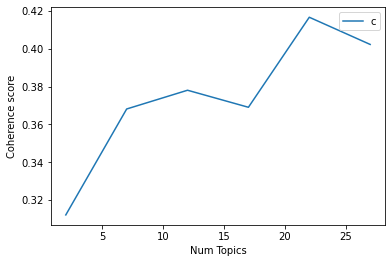

In [174]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [175]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3122
index: 1 | Num Topics = 7  has Coherence Value of 0.3682
index: 2 | Num Topics = 12  has Coherence Value of 0.3781
index: 3 | Num Topics = 17  has Coherence Value of 0.3691
index: 4 | Num Topics = 22  has Coherence Value of 0.4167
index: 5 | Num Topics = 27  has Coherence Value of 0.4023


In [176]:
# Select optimal number of topics
optimal_model_ph_2020_score1N2N3 = model_list_ph_2020_score1N2N3[4]

In [177]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2020_score1N2N3, corpus_ph_2020_score1N2N3, id2word_ph_2020_score1N2N3)

In [178]:
print("pyLDAVis for ph topics for score=1,2,3 in 2020:")
vis_ph_2020_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.171189  0.024722       1        1  10.935975
11    -0.114933  0.004288       2        1   9.187889
14    -0.020858  0.097643       3        1   8.313082
6     -0.081743  0.095850       4        1   8.278845
1      0.053525  0.094345       5        1   6.784826
7     -0.020494  0.084952       6        1   6.399313
3     -0.007630 -0.042196       7        1   5.275446
13     0.111629  0.125589       8        1   4.429105
0     -0.130735 -0.100097       9        1   4.318797
17     0.031770 -0.192020      10        1   4.156654
18    -0.082453 -0.068446      11        1   4.155403
21     0.082369  0.118669      12        1   3.881922
20    -0.019074  0.044475      13        1   3.484506
12     0.001679 -0.008264      14        1   3.482477
10     0.059975 -0.068353      15        1   3.094271
19     0.021342  0.014455      16        1   2.982344
9     -0.010976 -0.021536      17        1   2.873489
2     -0.043146  0.006615      18        1   2.609503
8     -0.031087 -0.045869      19        1   2.449200
5      0.168177 -0.080652      20        1   1.537068
4      0.103329 -0.055710      21        1   0.778130
16     0.100523 -0.028460      22        1   0.591754, topic_info=           Term       Freq      Total Category  logprob  loglift
2      snapchat  57.000000  57.000000  Default  30.0000  30.0000
4           app  41.000000  41.000000  Default  29.0000  29.0000
152        open  26.000000  26.000000  Default  28.0000  28.0000
134  connection  22.000000  22.000000  Default  27.0000  27.0000
110         log  36.000000  36.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
242        chat   0.016988   8.605970  Topic22  -6.5681  -1.0979
332      rarely   0.016988   1.586721  Topic22  -6.5681   0.5929
47         time   0.016988  24.704370  Topic22  -6.5681  -2.1524
161   sometimes   0.016988   8.746704  Topic22  -6.5681  -1.1141
326        coul   0.016988   1.586721  Topic22  -6.5681   0.5929

[1080 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
455      18  0.695898        able
424      11  0.657844         acc
130       3  0.619170      accept
130       8  0.309585      accept
229       3  0.629138  acceptable
...     ...       ...         ...
300       1  0.627386          yr
165       5  0.368424        zoom
165       6  0.184212        zoom
165      16  0.368424        zoom
165      18  0.184212        zoom

[1233 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 12, 15, 7, 2, 8, 4, 14, 1, 18, 19, 22, 21, 13, 11, 20, 10, 3, 9, 6, 5, 17])

## By-rating of 2021 (Rating=1,2,3)

In [179]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_ph_2021_score1N2N3 = snapchat_ios_ph_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_ph_2021_score1N2N3 = list(sent_to_words(review_ph_2021_score1N2N3))
print(review_words_ph_2021_score1N2N3[:1])

[['no']]


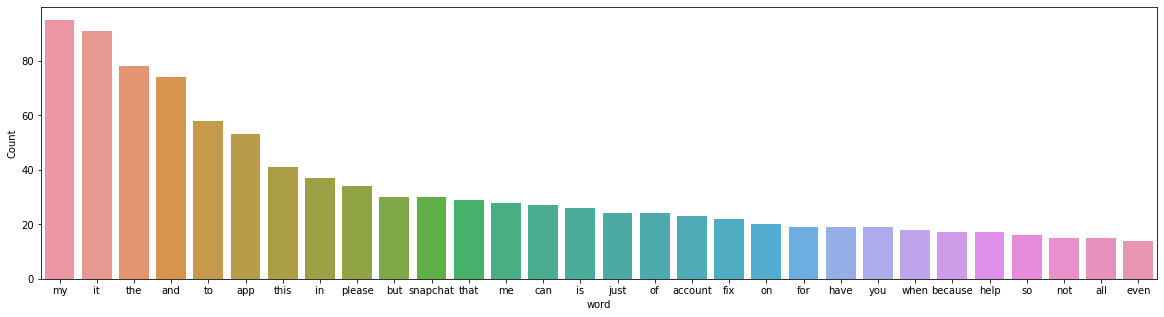

In [180]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2021_score1N2N3))

In [181]:
# Clean text
review_words_ph_ready_2021_score1N2N3 = process_words(review_words_ph_2021_score1N2N3)  # processed Text Data! - move to each section

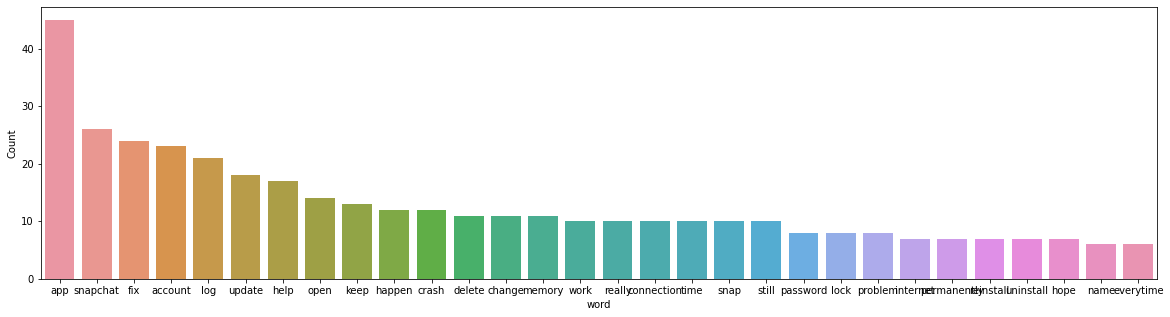

In [182]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2021_score1N2N3))


In [183]:
# Create Dictionary
id2word_ph_2021_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2021_score1N2N3)

2021-10-16 21:10:48,101 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 21:10:48,119 [INFO] gensim.corpora.dictionary - built Dictionary(369 unique tokens: ['always', 'app', 'delete', 'download', 'drop']...) from 89 documents (total 954 corpus positions)
2021-10-16 21:10:48,126 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(369 unique tokens: ['always', 'app', 'delete', 'download', 'drop']...) from 89 documents (total 954 corpus positions)", 'datetime': '2021-10-16T21:10:48.125967', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [184]:
# Create Corpus: Term Document Frequency
corpus_ph_2021_score1N2N3 = [id2word_ph_2021_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2021_score1N2N3]

In [185]:
# Training LDA model
model_list_ph_2021_score1N2N3, coherence_values_ph_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2021_score1N2N3, corpus=corpus_ph_2021_score1N2N3, 
                                                              texts=review_words_ph_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-16 21:10:48,172 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 21:10:48,176 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 21:10:48,180 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 21:10:48,182 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 89 documents, updating model once every 89 documents, evaluating perplexity every 89 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 21:10:48,526 [INFO] gensim.models.ldamodel - -6.608 per-word bound, 97.5 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:10:48,528 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #89/89
2021-10-16 21:10:48,830 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.019*"log" + 0.018*"fix" + 0.018*"account" + 0.014*"update" + 0.013*"connection" + 0.013*"snapcha

2021-10-16 21:10:51,319 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"snapchat" + 0.026*"help" + 0.024*"app" + 0.021*"account" + 0.017*"memory" + 0.016*"fix" + 0.015*"time" + 0.014*"log" + 0.012*"keep" + 0.012*"delete"
2021-10-16 21:10:51,321 [INFO] gensim.models.ldamodel - topic diff=0.008262, rho=0.301511
2021-10-16 21:10:51,431 [INFO] gensim.models.ldamodel - -5.809 per-word bound, 56.0 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:10:51,434 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #89/89
2021-10-16 21:10:51,553 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"app" + 0.022*"fix" + 0.019*"log" + 0.017*"update" + 0.017*"open" + 0.015*"account" + 0.015*"connection" + 0.014*"happen" + 0.013*"crash" + 0.013*"still"
2021-10-16 21:10:51,560 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"snapchat" + 0.026*"help" + 0.024*"app" + 0.021*"account" + 0.018*"memory" + 0.016*"fix" + 0.015*"time" + 0.01

2021-10-16 21:10:53,675 [INFO] gensim.models.ldamodel - topic diff=0.004256, rho=0.218218
2021-10-16 21:10:53,818 [INFO] gensim.models.ldamodel - -5.801 per-word bound, 55.8 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:10:53,820 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #89/89
2021-10-16 21:10:53,921 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.024*"fix" + 0.021*"update" + 0.018*"log" + 0.018*"open" + 0.017*"crash" + 0.015*"connection" + 0.015*"account" + 0.014*"happen" + 0.012*"still"
2021-10-16 21:10:53,925 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"snapchat" + 0.028*"help" + 0.023*"app" + 0.022*"account" + 0.018*"memory" + 0.015*"log" + 0.014*"time" + 0.014*"fix" + 0.012*"delete" + 0.011*"keep"
2021-10-16 21:10:53,929 [INFO] gensim.models.ldamodel - topic diff=0.004029, rho=0.213201
2021-10-16 21:10:54,068 [INFO] gensim.models.ldamodel - -5.801 per-word bound, 55.7 perplexity estim

2021-10-16 21:10:56,069 [INFO] gensim.models.ldamodel - -5.798 per-word bound, 55.6 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:10:56,074 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #89/89
2021-10-16 21:10:56,177 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.025*"fix" + 0.023*"update" + 0.018*"log" + 0.018*"open" + 0.018*"crash" + 0.015*"account" + 0.015*"connection" + 0.013*"happen" + 0.012*"still"
2021-10-16 21:10:56,178 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.034*"snapchat" + 0.028*"help" + 0.022*"app" + 0.022*"account" + 0.019*"memory" + 0.015*"log" + 0.013*"time" + 0.013*"delete" + 0.012*"fix" + 0.011*"password"
2021-10-16 21:10:56,179 [INFO] gensim.models.ldamodel - topic diff=0.002541, rho=0.176777
2021-10-16 21:10:56,289 [INFO] gensim.models.ldamodel - -5.798 per-word bound, 55.6 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:10:56,293 

2021-10-16 21:10:58,325 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #89/89
2021-10-16 21:10:58,415 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.025*"fix" + 0.025*"update" + 0.018*"log" + 0.018*"open" + 0.018*"crash" + 0.015*"account" + 0.015*"connection" + 0.013*"happen" + 0.012*"still"
2021-10-16 21:10:58,417 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.034*"snapchat" + 0.028*"help" + 0.022*"app" + 0.022*"account" + 0.019*"memory" + 0.015*"log" + 0.013*"time" + 0.013*"delete" + 0.011*"fix" + 0.011*"password"
2021-10-16 21:10:58,418 [INFO] gensim.models.ldamodel - topic diff=0.002105, rho=0.154303
2021-10-16 21:10:58,547 [INFO] gensim.models.ldamodel - -5.796 per-word bound, 55.6 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:10:58,548 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #89/89
2021-10-16 21:10:58,656 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.02

2021-10-16 21:11:00,449 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 21:11:05,290 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 21:11:05,351 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 78 virtual documents
2021-10-16 21:11:05,683 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 21:11:05,686 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 21:11:05,703 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 21:11:05,705 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 89 documents, updating model once every 89 documents, evaluating perplexity every 89 documents, iterating 50x with a converg

2021-10-16 21:11:07,051 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.038*"connection" + 0.036*"log" + 0.030*"app" + 0.029*"happen" + 0.029*"internet" + 0.025*"fix" + 0.018*"still" + 0.015*"snapchat" + 0.015*"name" + 0.015*"lol"
2021-10-16 21:11:07,052 [INFO] gensim.models.ldamodel - topic diff=0.046894, rho=0.408248
2021-10-16 21:11:07,172 [INFO] gensim.models.ldamodel - -6.041 per-word bound, 65.9 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:07,174 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #89/89
2021-10-16 21:11:07,224 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.038*"connection" + 0.035*"log" + 0.030*"app" + 0.029*"happen" + 0.029*"internet" + 0.025*"fix" + 0.018*"still" + 0.015*"snapchat" + 0.015*"name" + 0.015*"lol"
2021-10-16 21:11:07,226 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.042*"account" + 0.040*"help" + 0.030*"password" + 0.030*"snapchat" + 0.026*"app" + 0.018*"change" + 0.018*"nu

2021-10-16 21:11:08,188 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.039*"connection" + 0.034*"log" + 0.030*"app" + 0.029*"happen" + 0.029*"internet" + 0.025*"fix" + 0.017*"still" + 0.015*"snapchat" + 0.015*"name" + 0.015*"lol"
2021-10-16 21:11:08,189 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.036*"update" + 0.035*"app" + 0.030*"filter" + 0.024*"snapchat" + 0.022*"delete" + 0.018*"close" + 0.013*"log" + 0.013*"open" + 0.013*"username" + 0.013*"change"
2021-10-16 21:11:08,191 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"memory" + 0.037*"help" + 0.033*"snapchat" + 0.029*"lock" + 0.021*"permanently" + 0.019*"app" + 0.018*"delete" + 0.018*"account" + 0.017*"picture" + 0.017*"happen"
2021-10-16 21:11:08,192 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"account" + 0.041*"help" + 0.030*"snapchat" + 0.030*"password" + 0.025*"app" + 0.018*"change" + 0.018*"number" + 0.018*"snap" + 0.013*"permanently" + 0.013*"wrong"
2021-10-16 21:11:08,194 [INFO] gensim.mo

2021-10-16 21:11:09,129 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.045*"update" + 0.028*"snapchat" + 0.028*"hairstyle" + 0.019*"really" + 0.019*"work" + 0.019*"fix" + 0.019*"account" + 0.019*"friend" + 0.019*"send" + 0.019*"clothe"
2021-10-16 21:11:09,132 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.039*"connection" + 0.034*"log" + 0.030*"app" + 0.029*"happen" + 0.029*"internet" + 0.025*"fix" + 0.017*"still" + 0.015*"snapchat" + 0.015*"name" + 0.015*"lol"
2021-10-16 21:11:09,133 [INFO] gensim.models.ldamodel - topic diff=0.001750, rho=0.242536
2021-10-16 21:11:09,286 [INFO] gensim.models.ldamodel - -6.026 per-word bound, 65.2 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:09,287 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #89/89
2021-10-16 21:11:09,325 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"help" + 0.038*"memory" + 0.033*"snapchat" + 0.029*"lock" + 0.021*"permanently" + 0.019*"app" + 0.

2021-10-16 21:11:10,289 [INFO] gensim.models.ldamodel - -6.025 per-word bound, 65.1 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:10,290 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #89/89
2021-10-16 21:11:10,369 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.045*"update" + 0.028*"snapchat" + 0.028*"hairstyle" + 0.019*"really" + 0.019*"work" + 0.019*"fix" + 0.019*"account" + 0.019*"friend" + 0.019*"send" + 0.019*"clothe"
2021-10-16 21:11:10,372 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"account" + 0.044*"help" + 0.031*"snapchat" + 0.030*"password" + 0.025*"app" + 0.018*"change" + 0.018*"number" + 0.018*"snap" + 0.013*"permanently" + 0.013*"chat"
2021-10-16 21:11:10,378 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.039*"help" + 0.038*"memory" + 0.033*"snapchat" + 0.029*"lock" + 0.021*"permanently" + 0.019*"app" + 0.019*"account" + 0.018*"delete" + 0.017*"picture" + 0.017*"happen"
2021-10-16 21:11

2021-10-16 21:11:11,301 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"help" + 0.038*"memory" + 0.033*"snapchat" + 0.030*"lock" + 0.021*"permanently" + 0.019*"app" + 0.019*"account" + 0.018*"delete" + 0.017*"picture" + 0.017*"happen"
2021-10-16 21:11:11,303 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.073*"app" + 0.039*"fix" + 0.036*"open" + 0.036*"crash" + 0.036*"log" + 0.033*"time" + 0.022*"account" + 0.020*"update" + 0.017*"everytime" + 0.016*"keep"
2021-10-16 21:11:11,304 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.045*"update" + 0.028*"snapchat" + 0.028*"hairstyle" + 0.019*"really" + 0.019*"work" + 0.019*"fix" + 0.019*"account" + 0.019*"friend" + 0.019*"send" + 0.019*"clothe"
2021-10-16 21:11:11,305 [INFO] gensim.models.ldamodel - topic diff=0.000369, rho=0.188982
2021-10-16 21:11:11,425 [INFO] gensim.models.ldamodel - -6.025 per-word bound, 65.1 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:11,426 [INFO] ge

2021-10-16 21:11:12,254 [INFO] gensim.models.ldamodel - topic diff=0.000414, rho=0.174078
2021-10-16 21:11:12,361 [INFO] gensim.models.ldamodel - -6.025 per-word bound, 65.1 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:12,365 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #89/89
2021-10-16 21:11:12,429 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.039*"connection" + 0.034*"log" + 0.030*"app" + 0.029*"happen" + 0.029*"internet" + 0.025*"fix" + 0.017*"still" + 0.015*"name" + 0.015*"lol" + 0.015*"check"
2021-10-16 21:11:12,431 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"help" + 0.044*"account" + 0.032*"snapchat" + 0.030*"password" + 0.025*"app" + 0.018*"change" + 0.018*"number" + 0.018*"snap" + 0.012*"chat" + 0.012*"allow"
2021-10-16 21:11:12,433 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"update" + 0.028*"snapchat" + 0.028*"hairstyle" + 0.019*"really" + 0.019*"work" + 0.019*"fix" + 0.019*"ac

2021-10-16 21:11:13,354 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.036*"update" + 0.035*"app" + 0.030*"filter" + 0.024*"snapchat" + 0.023*"delete" + 0.018*"close" + 0.013*"play" + 0.013*"username" + 0.013*"open" + 0.013*"log"
2021-10-16 21:11:13,356 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.074*"app" + 0.039*"fix" + 0.036*"crash" + 0.036*"open" + 0.036*"log" + 0.033*"time" + 0.022*"account" + 0.020*"update" + 0.017*"everytime" + 0.016*"uninstall"
2021-10-16 21:11:13,357 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"help" + 0.044*"account" + 0.032*"snapchat" + 0.030*"password" + 0.025*"app" + 0.018*"change" + 0.018*"number" + 0.018*"snap" + 0.013*"chat" + 0.013*"allow"
2021-10-16 21:11:13,359 [INFO] gensim.models.ldamodel - topic diff=0.000298, rho=0.160128
2021-10-16 21:11:13,484 [INFO] gensim.models.ldamodel - -6.025 per-word bound, 65.1 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:13,487 [INFO] gensim.mod

2021-10-16 21:11:14,330 [INFO] gensim.models.ldamodel - topic diff=0.000178, rho=0.150756
2021-10-16 21:11:14,439 [INFO] gensim.models.ldamodel - -6.024 per-word bound, 65.1 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:14,442 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #89/89
2021-10-16 21:11:14,490 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"post" + 0.020*"people" + 0.020*"game" + 0.020*"low" + 0.020*"size" + 0.011*"crush" + 0.011*"update" + 0.011*"storage" + 0.011*"love" + 0.011*"back"
2021-10-16 21:11:14,492 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.039*"help" + 0.038*"memory" + 0.033*"snapchat" + 0.030*"lock" + 0.021*"permanently" + 0.019*"app" + 0.019*"account" + 0.018*"delete" + 0.017*"picture" + 0.017*"happen"
2021-10-16 21:11:14,494 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.074*"app" + 0.039*"fix" + 0.036*"crash" + 0.036*"open" + 0.036*"log" + 0.033*"time" + 0.022*"account" + 0

2021-10-16 21:11:15,315 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.034*"update" + 0.033*"app" + 0.030*"filter" + 0.025*"snapchat" + 0.023*"delete" + 0.019*"close" + 0.013*"play" + 0.013*"username" + 0.013*"open" + 0.013*"screenshot"
2021-10-16 21:11:15,318 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.045*"update" + 0.028*"snapchat" + 0.028*"hairstyle" + 0.019*"work" + 0.019*"really" + 0.019*"fix" + 0.019*"account" + 0.019*"friend" + 0.019*"send" + 0.019*"clothe"
2021-10-16 21:11:15,320 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"help" + 0.044*"account" + 0.032*"snapchat" + 0.030*"password" + 0.025*"app" + 0.018*"change" + 0.018*"number" + 0.018*"snap" + 0.012*"chat" + 0.012*"allow"
2021-10-16 21:11:15,324 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.074*"app" + 0.039*"fix" + 0.036*"crash" + 0.036*"open" + 0.036*"log" + 0.033*"time" + 0.022*"account" + 0.021*"update" + 0.017*"everytime" + 0.016*"uninstall"
2021-10-16 21:11:15,327 [INFO] gensim.models.

2021-10-16 21:11:22,101 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"connection" + 0.051*"account" + 0.034*"check" + 0.034*"log" + 0.034*"happen" + 0.034*"filter" + 0.026*"username" + 0.026*"change" + 0.026*"really" + 0.022*"update"
2021-10-16 21:11:22,103 [INFO] gensim.models.ldamodel - topic diff=0.122706, rho=0.500000
2021-10-16 21:11:22,179 [INFO] gensim.models.ldamodel - -6.212 per-word bound, 74.1 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:22,195 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #89/89
2021-10-16 21:11:22,305 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"connection" + 0.051*"account" + 0.034*"check" + 0.034*"happen" + 0.034*"log" + 0.034*"filter" + 0.026*"username" + 0.026*"really" + 0.026*"change" + 0.021*"update"
2021-10-16 21:11:22,307 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.050*"public" + 0.050*"profile" + 0.026*"snap" + 0.026*"section" + 0.026*"sign" + 0.026*"

2021-10-16 21:11:23,285 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"app" + 0.038*"permanently" + 0.031*"log" + 0.031*"lock" + 0.023*"snapchat" + 0.023*"account" + 0.016*"open" + 0.016*"reinstall" + 0.016*"memory" + 0.016*"fix"
2021-10-16 21:11:23,286 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.060*"snapchat" + 0.034*"password" + 0.034*"help" + 0.034*"account" + 0.027*"change" + 0.020*"post" + 0.020*"picture" + 0.018*"fix" + 0.014*"lock" + 0.014*"reason"
2021-10-16 21:11:23,287 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.039*"fix" + 0.038*"turn" + 0.020*"snapchat" + 0.020*"video" + 0.020*"io" + 0.020*"iphone" + 0.020*"freeze" + 0.020*"dunno" + 0.020*"heat" + 0.020*"second"
2021-10-16 21:11:23,289 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.033*"app" + 0.033*"change" + 0.033*"name" + 0.033*"whenever" + 0.022*"love" + 0.022*"instal" + 0.022*"delete" + 0.012*"open" + 0.012*"people" + 0.012*"really"
2021-10-16 21:11:23,290 [INFO] gensim.models.ldamodel 

2021-10-16 21:11:24,189 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"account" + 0.051*"connection" + 0.042*"happen" + 0.042*"log" + 0.034*"check" + 0.034*"filter" + 0.026*"really" + 0.026*"username" + 0.026*"change" + 0.017*"update"
2021-10-16 21:11:24,191 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.060*"snapchat" + 0.034*"password" + 0.034*"help" + 0.034*"account" + 0.027*"change" + 0.020*"post" + 0.020*"picture" + 0.017*"fix" + 0.014*"lock" + 0.014*"permanently"
2021-10-16 21:11:24,192 [INFO] gensim.models.ldamodel - topic diff=0.004455, rho=0.258199
2021-10-16 21:11:24,252 [INFO] gensim.models.ldamodel - -6.154 per-word bound, 71.2 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:24,253 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #89/89
2021-10-16 21:11:24,314 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.057*"app" + 0.035*"play" + 0.023*"help" + 0.023*"let" + 0.023*"instal" + 0.023*"install" 

2021-10-16 21:11:25,089 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #89/89
2021-10-16 21:11:25,229 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.047*"log" + 0.046*"keep" + 0.037*"internet" + 0.028*"connection" + 0.026*"still" + 0.020*"app" + 0.019*"happen" + 0.019*"fix" + 0.019*"login" + 0.019*"account"
2021-10-16 21:11:25,257 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.056*"work" + 0.042*"name" + 0.029*"screenshot" + 0.029*"drop" + 0.029*"remove" + 0.029*"notifie" + 0.029*"lol" + 0.017*"update" + 0.015*"app" + 0.015*"download"
2021-10-16 21:11:25,272 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.060*"snapchat" + 0.034*"password" + 0.034*"help" + 0.034*"account" + 0.027*"change" + 0.020*"post" + 0.020*"picture" + 0.017*"fix" + 0.014*"lock" + 0.014*"permanently"
2021-10-16 21:11:25,278 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.045*"app" + 0.038*"permanently" + 0.035*"lock" + 0.030*"log" + 0.025*"snapchat" + 0.025*"account" + 0.020*"team" 

2021-10-16 21:11:26,085 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.060*"snapchat" + 0.034*"password" + 0.034*"help" + 0.034*"account" + 0.027*"change" + 0.020*"post" + 0.020*"picture" + 0.017*"fix" + 0.014*"lock" + 0.014*"reason"
2021-10-16 21:11:26,086 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.088*"app" + 0.062*"crash" + 0.051*"open" + 0.040*"time" + 0.037*"fix" + 0.035*"update" + 0.026*"log" + 0.021*"bug" + 0.021*"everytime" + 0.016*"mobile"
2021-10-16 21:11:26,090 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.042*"memory" + 0.040*"app" + 0.031*"help" + 0.031*"snapchat" + 0.030*"update" + 0.024*"happen" + 0.024*"download" + 0.020*"fix" + 0.018*"recover" + 0.017*"still"
2021-10-16 21:11:26,092 [INFO] gensim.models.ldamodel - topic diff=0.001433, rho=0.196116
2021-10-16 21:11:26,149 [INFO] gensim.models.ldamodel - -6.149 per-word bound, 71.0 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:26,150 [INFO] gensim.model

2021-10-16 21:11:26,912 [INFO] gensim.models.ldamodel - topic diff=0.000875, rho=0.179605
2021-10-16 21:11:27,019 [INFO] gensim.models.ldamodel - -6.148 per-word bound, 70.9 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:27,020 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #89/89
2021-10-16 21:11:27,167 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.039*"fix" + 0.039*"turn" + 0.020*"snapchat" + 0.020*"video" + 0.020*"io" + 0.020*"iphone" + 0.020*"freeze" + 0.020*"bug" + 0.020*"dunno" + 0.020*"record"
2021-10-16 21:11:27,175 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"account" + 0.051*"connection" + 0.042*"happen" + 0.042*"log" + 0.034*"check" + 0.034*"filter" + 0.026*"really" + 0.026*"username" + 0.026*"change" + 0.017*"update"
2021-10-16 21:11:27,178 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.042*"memory" + 0.039*"app" + 0.034*"help" + 0.032*"snapchat" + 0.030*"update" + 0.024*"happen" + 0.024

2021-10-16 21:11:28,204 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"account" + 0.051*"connection" + 0.042*"happen" + 0.042*"log" + 0.034*"check" + 0.034*"filter" + 0.026*"really" + 0.026*"username" + 0.026*"change" + 0.017*"app"
2021-10-16 21:11:28,205 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.044*"app" + 0.037*"permanently" + 0.037*"lock" + 0.030*"log" + 0.028*"account" + 0.026*"snapchat" + 0.022*"team" + 0.015*"open" + 0.015*"close" + 0.015*"delete"
2021-10-16 21:11:28,208 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.033*"app" + 0.033*"change" + 0.033*"name" + 0.033*"whenever" + 0.022*"love" + 0.022*"delete" + 0.022*"instal" + 0.012*"open" + 0.012*"people" + 0.012*"help"
2021-10-16 21:11:28,210 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.057*"app" + 0.035*"play" + 0.023*"help" + 0.023*"let" + 0.023*"instal" + 0.023*"install" + 0.023*"game" + 0.023*"fix" + 0.023*"low" + 0.023*"size"
2021-10-16 21:11:28,212 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 21:11:29,058 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.090*"app" + 0.063*"crash" + 0.052*"open" + 0.042*"time" + 0.038*"fix" + 0.036*"update" + 0.026*"log" + 0.021*"bug" + 0.021*"everytime" + 0.016*"mobile"
2021-10-16 21:11:29,062 [INFO] gensim.models.ldamodel - topic diff=0.000429, rho=0.154303
2021-10-16 21:11:29,176 [INFO] gensim.models.ldamodel - -6.145 per-word bound, 70.7 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:29,177 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #89/89
2021-10-16 21:11:29,215 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"memory" + 0.040*"help" + 0.039*"app" + 0.032*"snapchat" + 0.030*"update" + 0.024*"happen" + 0.024*"download" + 0.020*"fix" + 0.018*"recover" + 0.018*"break"
2021-10-16 21:11:29,216 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.057*"app" + 0.035*"play" + 0.023*"help" + 0.023*"let" + 0.023*"install" + 0.023*"instal" + 0.023*"game" + 0.023*

2021-10-16 21:11:30,058 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"account" + 0.051*"connection" + 0.042*"happen" + 0.042*"log" + 0.034*"check" + 0.034*"filter" + 0.026*"really" + 0.026*"username" + 0.026*"change" + 0.017*"app"
2021-10-16 21:11:30,059 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.033*"change" + 0.033*"app" + 0.033*"name" + 0.033*"whenever" + 0.022*"delete" + 0.022*"love" + 0.022*"instal" + 0.012*"open" + 0.012*"anymore" + 0.012*"snap"
2021-10-16 21:11:30,061 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.060*"snapchat" + 0.034*"help" + 0.034*"account" + 0.034*"password" + 0.027*"change" + 0.020*"picture" + 0.020*"post" + 0.017*"fix" + 0.014*"lock" + 0.014*"reason"
2021-10-16 21:11:30,064 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.039*"fix" + 0.039*"turn" + 0.020*"work" + 0.020*"video" + 0.020*"everytime" + 0.020*"snapchat" + 0.020*"hope" + 0.020*"uninstall" + 0.020*"iphone" + 0.020*"io"
2021-10-16 21:11:30,066 [INFO] gensim.models.lda

2021-10-16 21:11:37,440 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.068*"app" + 0.053*"log" + 0.045*"account" + 0.034*"crash" + 0.029*"fix" + 0.026*"number" + 0.025*"help" + 0.021*"time" + 0.020*"old" + 0.019*"update"
2021-10-16 21:11:37,441 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.038*"yet" + 0.038*"account" + 0.038*"lock" + 0.038*"permanently" + 0.019*"fix" + 0.019*"block" + 0.019*"send" + 0.019*"dunno" + 0.019*"hour" + 0.019*"video"
2021-10-16 21:11:37,442 [INFO] gensim.models.ldamodel - topic diff=13.243023, rho=1.000000
2021-10-16 21:11:37,541 [INFO] gensim.models.ldamodel - -6.646 per-word bound, 100.1 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:37,543 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #89/89
2021-10-16 21:11:37,575 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.038*"internet" + 0.037*"happen" + 0.026*"account" + 0.026*"connection" + 0.025*"snap" + 0.025*"send" + 0.023*"bitmoj

2021-10-16 21:11:38,426 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:38,428 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #89/89
2021-10-16 21:11:38,465 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.059*"log" + 0.049*"app" + 0.039*"happen" + 0.030*"fix" + 0.030*"snapchat" + 0.029*"help" + 0.020*"keep" + 0.020*"still" + 0.020*"reinstall" + 0.020*"connection"
2021-10-16 21:11:38,466 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.050*"post" + 0.050*"filter" + 0.034*"photo" + 0.034*"fix" + 0.034*"really" + 0.017*"plrase" + 0.017*"day" + 0.017*"pic" + 0.017*"still" + 0.017*"lag"
2021-10-16 21:11:38,468 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.096*"crash" + 0.095*"update" + 0.050*"open" + 0.044*"keep" + 0.043*"snapchat" + 0.040*"fix" + 0.038*"app" + 0.031*"friend" + 0.016*"look" + 0.016*"mine"
2021-10-16 21:11:38,470 [INFO] gensim.models.ldamode

2021-10-16 21:11:39,354 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.063*"connection" + 0.051*"update" + 0.051*"check" + 0.038*"app" + 0.038*"fix" + 0.038*"internet" + 0.026*"problem" + 0.026*"snap" + 0.026*"last" + 0.024*"account"
2021-10-16 21:11:39,356 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.059*"log" + 0.049*"app" + 0.040*"happen" + 0.030*"fix" + 0.030*"snapchat" + 0.030*"help" + 0.020*"keep" + 0.020*"still" + 0.020*"reinstall" + 0.020*"connection"
2021-10-16 21:11:39,357 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.065*"turn" + 0.033*"work" + 0.033*"everytime" + 0.033*"hope" + 0.033*"fix" + 0.033*"black" + 0.033*"uninstall" + 0.033*"automatically" + 0.033*"time" + 0.002*"permanently"
2021-10-16 21:11:39,358 [INFO] gensim.models.ldamodel - topic diff=0.009846, rho=0.277350
2021-10-16 21:11:39,435 [INFO] gensim.models.ldamodel - -6.294 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:39,437 

2021-10-16 21:11:40,291 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.063*"connection" + 0.051*"update" + 0.051*"check" + 0.038*"app" + 0.038*"fix" + 0.038*"internet" + 0.026*"problem" + 0.026*"snap" + 0.026*"last" + 0.026*"account"
2021-10-16 21:11:40,292 [INFO] gensim.models.ldamodel - topic diff=0.003527, rho=0.235702
2021-10-16 21:11:40,366 [INFO] gensim.models.ldamodel - -6.291 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:40,370 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #89/89
2021-10-16 21:11:40,426 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.037*"hairstyle" + 0.025*"screenshot" + 0.025*"remove" + 0.025*"notifie" + 0.025*"play" + 0.025*"snapchat" + 0.025*"kind" + 0.025*"clothe" + 0.025*"annoying" + 0.025*"message"
2021-10-16 21:11:40,428 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.050*"post" + 0.050*"filter" + 0.034*"fix" + 0.034*"photo" + 0.034*"really" + 0.017*"day

2021-10-16 21:11:41,338 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #89/89
2021-10-16 21:11:41,382 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.063*"connection" + 0.050*"update" + 0.050*"check" + 0.038*"app" + 0.038*"fix" + 0.038*"internet" + 0.027*"account" + 0.026*"problem" + 0.026*"snap" + 0.026*"last"
2021-10-16 21:11:41,384 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.078*"snapchat" + 0.063*"account" + 0.047*"password" + 0.047*"help" + 0.032*"number" + 0.032*"change" + 0.032*"allow" + 0.016*"recive" + 0.016*"rate" + 0.016*"icloud"
2021-10-16 21:11:41,386 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.056*"log" + 0.050*"app" + 0.040*"happen" + 0.030*"fix" + 0.030*"snapchat" + 0.030*"help" + 0.020*"still" + 0.020*"reinstall" + 0.020*"connection" + 0.020*"uninstall"
2021-10-16 21:11:41,387 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.065*"turn" + 0.033*"everytime" + 0.033*"work" + 0.033*"fix" + 0.033*"time" + 0.033*"black" + 0.033*"uninst

2021-10-16 21:11:42,263 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.037*"hairstyle" + 0.025*"play" + 0.025*"screenshot" + 0.025*"remove" + 0.025*"notifie" + 0.025*"snapchat" + 0.025*"kind" + 0.025*"clothe" + 0.025*"annoying" + 0.025*"message"
2021-10-16 21:11:42,266 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.092*"app" + 0.058*"log" + 0.034*"fix" + 0.033*"account" + 0.029*"open" + 0.028*"number" + 0.028*"time" + 0.021*"old" + 0.021*"mobile" + 0.021*"everytime"
2021-10-16 21:11:42,268 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.058*"log" + 0.049*"app" + 0.040*"happen" + 0.030*"fix" + 0.030*"snapchat" + 0.030*"help" + 0.020*"still" + 0.020*"reinstall" + 0.020*"connection" + 0.020*"uninstall"
2021-10-16 21:11:42,269 [INFO] gensim.models.ldamodel - topic diff=0.000819, rho=0.185695
2021-10-16 21:11:42,423 [INFO] gensim.models.ldamodel - -6.291 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:42,424 [

2021-10-16 21:11:43,174 [INFO] gensim.models.ldamodel - topic diff=0.000564, rho=0.171499
2021-10-16 21:11:43,301 [INFO] gensim.models.ldamodel - -6.290 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:43,302 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #89/89
2021-10-16 21:11:43,332 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.063*"connection" + 0.050*"update" + 0.050*"check" + 0.038*"app" + 0.038*"fix" + 0.038*"internet" + 0.028*"account" + 0.025*"problem" + 0.025*"snap" + 0.025*"last"
2021-10-16 21:11:43,334 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.047*"name" + 0.036*"app" + 0.036*"password" + 0.036*"work" + 0.024*"automatically" + 0.024*"drop" + 0.024*"change" + 0.024*"wrong" + 0.024*"today" + 0.024*"lol"
2021-10-16 21:11:43,336 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.065*"turn" + 0.033*"everytime" + 0.033*"work" + 0.033*"time" + 0.033*"fix" + 0.033*"black" + 0.033*"un

2021-10-16 21:11:44,274 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.109*"update" + 0.097*"crash" + 0.061*"open" + 0.052*"app" + 0.049*"fix" + 0.043*"keep" + 0.042*"snapchat" + 0.029*"friend" + 0.015*"account" + 0.015*"updating"
2021-10-16 21:11:44,279 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.058*"help" + 0.058*"whenever" + 0.039*"delete" + 0.039*"story" + 0.039*"snap" + 0.021*"snapchat" + 0.021*"open" + 0.020*"store" + 0.020*"sure" + 0.020*"report"
2021-10-16 21:11:44,290 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.038*"lock" + 0.038*"yet" + 0.038*"permanently" + 0.038*"account" + 0.019*"friend" + 0.019*"block" + 0.019*"message" + 0.019*"create" + 0.019*"send" + 0.019*"hour"
2021-10-16 21:11:44,292 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.089*"app" + 0.057*"log" + 0.033*"account" + 0.032*"fix" + 0.028*"number" + 0.028*"time" + 0.026*"open" + 0.022*"crash" + 0.021*"old" + 0.021*"mobile"
2021-10-16 21:11:44,293 [INFO] gensim.models.ldamodel - topic

2021-10-16 21:11:45,093 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.078*"snapchat" + 0.063*"account" + 0.047*"password" + 0.047*"help" + 0.032*"number" + 0.032*"allow" + 0.032*"change" + 0.016*"recive" + 0.016*"rate" + 0.016*"expire"
2021-10-16 21:11:45,095 [INFO] gensim.models.ldamodel - topic diff=0.000561, rho=0.149071
2021-10-16 21:11:45,271 [INFO] gensim.models.ldamodel - -6.288 per-word bound, 78.1 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:45,274 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #89/89
2021-10-16 21:11:45,328 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.038*"yet" + 0.038*"permanently" + 0.038*"account" + 0.038*"lock" + 0.019*"friend" + 0.019*"block" + 0.019*"message" + 0.019*"create" + 0.019*"send" + 0.019*"hour"
2021-10-16 21:11:45,334 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.088*"app" + 0.056*"log" + 0.033*"account" + 0.031*"fix" + 0.028*"number" + 0.028*"time" + 0.025

2021-10-16 21:11:46,304 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.038*"internet" + 0.038*"happen" + 0.026*"connection" + 0.026*"app" + 0.026*"bitmoji" + 0.026*"account" + 0.026*"keep" + 0.026*"still" + 0.026*"send" + 0.026*"snap"
2021-10-16 21:11:46,306 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.050*"update" + 0.034*"name" + 0.034*"change" + 0.034*"snapchat" + 0.034*"new" + 0.034*"public" + 0.034*"profile" + 0.017*"app" + 0.017*"fix" + 0.017*"helpful"
2021-10-16 21:11:46,307 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.087*"app" + 0.057*"log" + 0.032*"account" + 0.031*"fix" + 0.028*"number" + 0.028*"time" + 0.024*"crash" + 0.024*"open" + 0.021*"old" + 0.021*"mobile"
2021-10-16 21:11:46,308 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.050*"post" + 0.050*"filter" + 0.034*"fix" + 0.034*"photo" + 0.034*"really" + 0.017*"day" + 0.017*"snapmap" + 0.017*"plrase" + 0.017*"map" + 0.017*"sometimes"
2021-10-16 21:11:46,309 [INFO] gensim.models.ldamodel - topic 

2021-10-16 21:11:54,924 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.059*"app" + 0.055*"log" + 0.043*"time" + 0.032*"number" + 0.032*"last" + 0.032*"mobile" + 0.032*"fix" + 0.032*"connection" + 0.032*"account" + 0.032*"problem"
2021-10-16 21:11:54,927 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.116*"lock" + 0.091*"permanently" + 0.048*"start" + 0.046*"reason" + 0.028*"account" + 0.026*"snapchat" + 0.026*"picture" + 0.025*"keep" + 0.025*"spam" + 0.025*"today"
2021-10-16 21:11:54,931 [INFO] gensim.models.ldamodel - topic diff=0.103171, rho=0.447214
2021-10-16 21:11:55,044 [INFO] gensim.models.ldamodel - -6.425 per-word bound, 85.9 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:55,046 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #89/89
2021-10-16 21:11:55,079 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.116*"app" + 0.073*"update" + 0.072*"open" + 0.058*"time" + 0.042*"crush" + 0.039*"work" + 0.036*"fix

2021-10-16 21:11:55,922 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #89/89
2021-10-16 21:11:55,961 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.068*"memory" + 0.030*"happen" + 0.029*"snapchat" + 0.029*"help" + 0.029*"recover" + 0.024*"app" + 0.020*"chat" + 0.020*"issue" + 0.020*"automatically" + 0.020*"keep"
2021-10-16 21:11:55,965 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.054*"crash" + 0.048*"snapchat" + 0.048*"whenever" + 0.048*"delete" + 0.048*"help" + 0.032*"story" + 0.032*"keep" + 0.032*"open" + 0.032*"snap" + 0.016*"troubleshoot"
2021-10-16 21:11:55,971 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.032*"app" + 0.022*"help" + 0.022*"message" + 0.022*"snap" + 0.022*"keep" + 0.022*"delete" + 0.022*"update" + 0.022*"find" + 0.022*"profile" + 0.022*"public"
2021-10-16 21:11:55,973 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.058*"snapchat" + 0.039*"app" + 0.039*"friend" + 0.039*"delete" + 0.039*"account" + 0.039*"update" + 0.020*"reaso

2021-10-16 21:11:56,932 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.032*"app" + 0.022*"help" + 0.022*"message" + 0.022*"snap" + 0.022*"keep" + 0.022*"delete" + 0.022*"update" + 0.022*"find" + 0.022*"profile" + 0.022*"public"
2021-10-16 21:11:56,934 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.078*"log" + 0.052*"app" + 0.050*"account" + 0.049*"connection" + 0.041*"time" + 0.041*"check" + 0.031*"number" + 0.031*"mobile" + 0.031*"last" + 0.031*"fix"
2021-10-16 21:11:56,935 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.058*"snapchat" + 0.039*"app" + 0.039*"delete" + 0.039*"update" + 0.039*"account" + 0.039*"friend" + 0.020*"reason" + 0.020*"fix" + 0.020*"phone" + 0.020*"device"
2021-10-16 21:11:56,936 [INFO] gensim.models.ldamodel - topic diff=0.007527, rho=0.250000
2021-10-16 21:11:57,050 [INFO] gensim.models.ldamodel - -6.331 per-word bound, 80.5 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:57,051 [INFO] gensim.mode

2021-10-16 21:11:57,923 [INFO] gensim.models.ldamodel - topic diff=0.002931, rho=0.218218
2021-10-16 21:11:57,973 [INFO] gensim.models.ldamodel - -6.327 per-word bound, 80.3 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:57,975 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #89/89
2021-10-16 21:11:58,009 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.061*"name" + 0.061*"username" + 0.050*"change" + 0.047*"internet" + 0.032*"connection" + 0.031*"work" + 0.031*"drop" + 0.031*"lol" + 0.016*"app" + 0.016*"happen"
2021-10-16 21:11:58,010 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.050*"snap" + 0.050*"sign" + 0.050*"verify" + 0.050*"chat" + 0.002*"help" + 0.002*"crash" + 0.002*"person" + 0.002*"add" + 0.002*"bitmoji" + 0.002*"enter"
2021-10-16 21:11:58,012 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.051*"crash" + 0.048*"snapchat" + 0.048*"whenever" + 0.048*"delete" + 0.048*"help" + 0.032*"story" + 0.032*"

2021-10-16 21:11:58,930 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.070*"app" + 0.040*"fix" + 0.040*"log" + 0.030*"post" + 0.020*"help" + 0.020*"let" + 0.020*"install" + 0.020*"reinstall" + 0.020*"instal" + 0.020*"close"
2021-10-16 21:11:58,933 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.058*"snapchat" + 0.039*"app" + 0.039*"delete" + 0.039*"update" + 0.039*"friend" + 0.039*"account" + 0.020*"reason" + 0.020*"fix" + 0.020*"phone" + 0.020*"device"
2021-10-16 21:11:58,936 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.078*"log" + 0.052*"app" + 0.051*"account" + 0.050*"connection" + 0.041*"time" + 0.041*"check" + 0.031*"number" + 0.031*"mobile" + 0.031*"fix" + 0.031*"problem"
2021-10-16 21:11:58,939 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.051*"crash" + 0.048*"snapchat" + 0.048*"whenever" + 0.048*"delete" + 0.048*"help" + 0.032*"story" + 0.032*"keep" + 0.032*"open" + 0.032*"snap" + 0.017*"watch"
2021-10-16 21:11:58,941 [INFO] gensim.models.ldamodel - top

2021-10-16 21:11:59,806 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.079*"filter" + 0.027*"floor" + 0.027*"camera" + 0.027*"contact" + 0.027*"multiple" + 0.027*"smash" + 0.027*"water" + 0.027*"time" + 0.027*"fix" + 0.027*"bug"
2021-10-16 21:11:59,807 [INFO] gensim.models.ldamodel - topic diff=0.000391, rho=0.176777
2021-10-16 21:11:59,932 [INFO] gensim.models.ldamodel - -6.325 per-word bound, 80.2 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:11:59,933 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #89/89
2021-10-16 21:11:59,961 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.050*"snap" + 0.050*"sign" + 0.050*"verify" + 0.050*"chat" + 0.002*"help" + 0.002*"crash" + 0.002*"person" + 0.002*"add" + 0.002*"bitmoji" + 0.002*"enter"
2021-10-16 21:11:59,963 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.061*"name" + 0.061*"username" + 0.050*"change" + 0.046*"internet" + 0.031*"connection" + 0.031*"work" + 0.031*"

2021-10-16 21:12:00,920 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.050*"snap" + 0.050*"sign" + 0.050*"verify" + 0.050*"chat" + 0.002*"help" + 0.002*"crash" + 0.002*"person" + 0.002*"add" + 0.002*"bitmoji" + 0.002*"enter"
2021-10-16 21:12:00,922 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.062*"account" + 0.062*"snapchat" + 0.041*"help" + 0.031*"password" + 0.021*"play" + 0.021*"lock" + 0.021*"app" + 0.021*"hope" + 0.021*"yet" + 0.021*"permanently"
2021-10-16 21:12:00,925 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.051*"crash" + 0.048*"snapchat" + 0.048*"whenever" + 0.048*"delete" + 0.048*"help" + 0.032*"story" + 0.032*"open" + 0.032*"keep" + 0.032*"snap" + 0.017*"watch"
2021-10-16 21:12:00,926 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.155*"crash" + 0.088*"app" + 0.074*"update" + 0.062*"open" + 0.054*"fix" + 0.028*"everytime" + 0.028*"camera" + 0.028*"photo" + 0.028*"allow" + 0.028*"setting"
2021-10-16 21:12:00,927 [INFO] gensim.models.ldamodel - top

2021-10-16 21:12:01,807 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.121*"app" + 0.082*"update" + 0.071*"open" + 0.058*"time" + 0.058*"work" + 0.039*"crush" + 0.039*"reinstall" + 0.039*"fix" + 0.039*"close" + 0.034*"still"
2021-10-16 21:12:01,808 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.155*"crash" + 0.087*"app" + 0.074*"update" + 0.062*"open" + 0.054*"fix" + 0.028*"everytime" + 0.028*"camera" + 0.028*"allow" + 0.028*"setting" + 0.028*"photo"
2021-10-16 21:12:01,810 [INFO] gensim.models.ldamodel - topic diff=0.000066, rho=0.152499
2021-10-16 21:12:01,864 [INFO] gensim.models.ldamodel - -6.326 per-word bound, 80.2 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:12:01,865 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #89/89
2021-10-16 21:12:01,922 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.069*"memory" + 0.030*"happen" + 0.030*"snapchat" + 0.030*"help" + 0.030*"recover" + 0.023*"app" + 0.020*"chat" + 

2021-10-16 21:12:02,808 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #89/89
2021-10-16 21:12:02,840 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.064*"low" + 0.064*"size" + 0.033*"stop" + 0.033*"offload" + 0.033*"people" + 0.033*"space" + 0.033*"big" + 0.033*"suggest" + 0.033*"way" + 0.033*"free"
2021-10-16 21:12:02,842 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.032*"app" + 0.022*"help" + 0.022*"message" + 0.022*"snap" + 0.022*"keep" + 0.022*"update" + 0.022*"delete" + 0.022*"annoying" + 0.022*"crash" + 0.022*"find"
2021-10-16 21:12:02,845 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.070*"app" + 0.040*"log" + 0.040*"fix" + 0.030*"post" + 0.020*"help" + 0.020*"close" + 0.020*"open" + 0.020*"let" + 0.020*"install" + 0.020*"instal"
2021-10-16 21:12:02,847 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.051*"happen" + 0.041*"app" + 0.031*"still" + 0.031*"download" + 0.028*"account" + 0.021*"fix" + 0.021*"connection" + 0.021*"reinstall" + 0.021

2021-10-16 21:12:12,814 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.054*"app" + 0.041*"close" + 0.041*"log" + 0.027*"reinstall" + 0.027*"fix" + 0.027*"open" + 0.027*"start" + 0.027*"lock" + 0.027*"reason" + 0.026*"permanently"
2021-10-16 21:12:12,816 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.003*"cellular" + 0.003*"thingy" + 0.003*"boi" + 0.003*"sudden" + 0.003*"enter" + 0.003*"add" + 0.003*"person" + 0.003*"bitmoji" + 0.003*"restart" + 0.003*"datum"
2021-10-16 21:12:12,817 [INFO] gensim.models.ldamodel - topic diff=0.145084, rho=0.577350
2021-10-16 21:12:13,052 [INFO] gensim.models.ldamodel - -6.728 per-word bound, 106.0 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:12:13,053 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #89/89
2021-10-16 21:12:13,083 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.081*"account" + 0.072*"log" + 0.072*"happen" + 0.041*"people" + 0.041*"add" + 0.041*"sudden" + 0.041*"

2021-10-16 21:12:13,780 [INFO] gensim.models.ldamodel - -6.491 per-word bound, 89.9 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:12:13,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #89/89
2021-10-16 21:12:13,926 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.003*"cellular" + 0.003*"thingy" + 0.003*"boi" + 0.003*"sudden" + 0.003*"enter" + 0.003*"add" + 0.003*"person" + 0.003*"bitmoji" + 0.003*"restart" + 0.003*"datum"
2021-10-16 21:12:13,928 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.051*"connection" + 0.051*"internet" + 0.028*"account" + 0.028*"password" + 0.026*"login" + 0.026*"wrong" + 0.026*"log" + 0.026*"happen" + 0.025*"bitmoji" + 0.025*"keep"
2021-10-16 21:12:13,929 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.037*"app" + 0.037*"name" + 0.037*"happen" + 0.036*"lol" + 0.025*"fix" + 0.025*"drop" + 0.025*"work" + 0.025*"still" + 0.025*"connection" + 0.013*"look"
2021-10-16 21:12:13,930 [INFO] 

2021-10-16 21:12:14,823 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.096*"post" + 0.064*"fix" + 0.064*"app" + 0.033*"snapmap" + 0.033*"day" + 0.033*"map" + 0.033*"plrase" + 0.033*"pic" + 0.033*"accurate" + 0.033*"sometimes"
2021-10-16 21:12:14,824 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.073*"fix" + 0.049*"bug" + 0.049*"update" + 0.049*"account" + 0.025*"floor" + 0.025*"multiple" + 0.025*"time" + 0.025*"water" + 0.025*"snapchat" + 0.025*"work"
2021-10-16 21:12:14,825 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.054*"app" + 0.041*"log" + 0.041*"close" + 0.027*"reinstall" + 0.027*"open" + 0.027*"fix" + 0.027*"start" + 0.027*"lock" + 0.027*"reason" + 0.027*"permanently"
2021-10-16 21:12:14,826 [INFO] gensim.models.ldamodel - topic diff=0.010771, rho=0.267261
2021-10-16 21:12:14,932 [INFO] gensim.models.ldamodel - -6.468 per-word bound, 88.5 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:12:14,933 [INFO] gensim.models.

2021-10-16 21:12:15,690 [INFO] gensim.models.ldamodel - topic diff=0.004444, rho=0.229416
2021-10-16 21:12:15,804 [INFO] gensim.models.ldamodel - -6.464 per-word bound, 88.3 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:12:15,805 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #89/89
2021-10-16 21:12:15,835 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.044*"problem" + 0.044*"message" + 0.044*"keep" + 0.030*"really" + 0.030*"app" + 0.030*"check" + 0.030*"crash" + 0.030*"annoying" + 0.030*"open" + 0.030*"connection"
2021-10-16 21:12:15,836 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.037*"app" + 0.037*"name" + 0.037*"happen" + 0.037*"lol" + 0.025*"fix" + 0.025*"work" + 0.025*"drop" + 0.025*"still" + 0.025*"connection" + 0.013*"look"
2021-10-16 21:12:15,838 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.048*"photo" + 0.048*"full" + 0.048*"delete" + 0.048*"crash" + 0.048*"coz" + 0.048*"still" + 0.048*"lag" + 0

2021-10-16 21:12:16,774 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.071*"reverse" + 0.003*"happen" + 0.003*"connection" + 0.003*"log" + 0.003*"hope" + 0.003*"restart" + 0.003*"snapchat" + 0.003*"lol" + 0.003*"phone" + 0.003*"cause"
2021-10-16 21:12:16,780 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.096*"post" + 0.064*"fix" + 0.064*"app" + 0.033*"snapmap" + 0.033*"day" + 0.033*"map" + 0.033*"plrase" + 0.033*"pic" + 0.033*"accurate" + 0.033*"sometimes"
2021-10-16 21:12:16,798 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.107*"update" + 0.054*"app" + 0.054*"work" + 0.028*"still" + 0.028*"happen" + 0.028*"last" + 0.028*"snap" + 0.028*"fix" + 0.028*"version" + 0.028*"suddenly"
2021-10-16 21:12:16,800 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.102*"username" + 0.095*"change" + 0.037*"sc" + 0.037*"planning" + 0.037*"hope" + 0.037*"update" + 0.037*"lose" + 0.037*"twice" + 0.037*"snap" + 0.037*"streak"
2021-10-16 21:12:16,805 [INFO] gensim.models.ldamodel - topi

2021-10-16 21:12:17,613 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.107*"update" + 0.054*"app" + 0.054*"work" + 0.028*"still" + 0.028*"happen" + 0.028*"last" + 0.028*"snap" + 0.028*"fix" + 0.028*"version" + 0.028*"whenever"
2021-10-16 21:12:17,614 [INFO] gensim.models.ldamodel - topic diff=0.000843, rho=0.182574
2021-10-16 21:12:17,697 [INFO] gensim.models.ldamodel - -6.455 per-word bound, 87.7 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:12:17,707 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #89/89
2021-10-16 21:12:17,754 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.038*"app" + 0.038*"name" + 0.038*"happen" + 0.038*"lol" + 0.025*"fix" + 0.025*"work" + 0.025*"drop" + 0.025*"still" + 0.025*"connection" + 0.013*"really"
2021-10-16 21:12:17,756 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.040*"open" + 0.040*"chat" + 0.040*"update" + 0.040*"snapchat" + 0.040*"keep" + 0.040*"crash" + 0.020*"whenever" + 

2021-10-16 21:12:18,672 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.003*"cellular" + 0.003*"thingy" + 0.003*"boi" + 0.003*"sudden" + 0.003*"enter" + 0.003*"add" + 0.003*"person" + 0.003*"bitmoji" + 0.003*"restart" + 0.003*"datum"
2021-10-16 21:12:18,676 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.054*"app" + 0.041*"log" + 0.041*"close" + 0.027*"reinstall" + 0.027*"open" + 0.027*"fix" + 0.027*"start" + 0.027*"lock" + 0.027*"reason" + 0.027*"permanently"
2021-10-16 21:12:18,678 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.052*"connection" + 0.052*"internet" + 0.026*"account" + 0.026*"password" + 0.026*"login" + 0.026*"log" + 0.026*"wrong" + 0.026*"happen" + 0.026*"bitmoji" + 0.026*"keep"
2021-10-16 21:12:18,686 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.067*"memory" + 0.038*"snapchat" + 0.029*"app" + 0.029*"help" + 0.019*"notifie" + 0.019*"remove" + 0.019*"screenshot" + 0.019*"find" + 0.019*"happen" + 0.019*"treasure"
2021-10-16 21:12:18,687 [INFO] gen

2021-10-16 21:12:19,593 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.114*"log" + 0.076*"account" + 0.076*"happen" + 0.039*"people" + 0.039*"enter" + 0.039*"sudden" + 0.039*"add" + 0.039*"crush" + 0.039*"update" + 0.001*"bitmoji"
2021-10-16 21:12:19,595 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.066*"game" + 0.066*"crash" + 0.066*"today" + 0.034*"mom" + 0.034*"play" + 0.034*"snake" + 0.034*"bring" + 0.034*"back" + 0.034*"wrong" + 0.034*"wifi"
2021-10-16 21:12:19,598 [INFO] gensim.models.ldamodel - topic diff=0.000311, rho=0.156174
2021-10-16 21:12:19,681 [INFO] gensim.models.ldamodel - -6.454 per-word bound, 87.7 perplexity estimate based on a held-out corpus of 89 documents with 954 words
2021-10-16 21:12:19,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #89/89
2021-10-16 21:12:19,753 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.003*"cellular" + 0.003*"thingy" + 0.003*"boi" + 0.003*"sudden" + 0.003*"enter" + 0.003*"add" + 0.003*"person" + 0.

2021-10-16 21:12:20,561 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #89/89
2021-10-16 21:12:20,671 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.096*"post" + 0.064*"fix" + 0.064*"app" + 0.033*"snapmap" + 0.033*"day" + 0.033*"map" + 0.033*"plrase" + 0.033*"pic" + 0.033*"accurate" + 0.033*"sometimes"
2021-10-16 21:12:20,673 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.038*"help" + 0.038*"delete" + 0.038*"picture" + 0.038*"account" + 0.019*"username" + 0.019*"change" + 0.019*"device" + 0.019*"log" + 0.019*"contact" + 0.019*"sudden"
2021-10-16 21:12:20,676 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.070*"app" + 0.047*"install" + 0.047*"fix" + 0.047*"help" + 0.047*"let" + 0.047*"instal" + 0.024*"able" + 0.024*"team" + 0.024*"soon" + 0.024*"snapchat"
2021-10-16 21:12:20,678 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.045*"problem" + 0.045*"message" + 0.040*"keep" + 0.030*"app" + 0.030*"really" + 0.030*"check" + 0.030*"crash" + 0.030*"annoyin

In [186]:
%store model_list_ph_2021_score1N2N3
%store coherence_values_ph_2021_score1N2N3

Stored 'model_list_ph_2021_score1N2N3' (list)
Stored 'coherence_values_ph_2021_score1N2N3' (list)


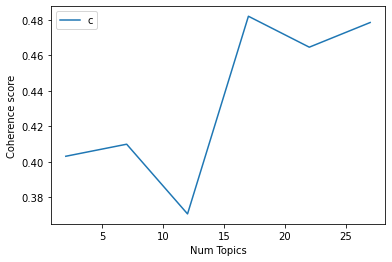

In [187]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [188]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.4031
index: 1 | Num Topics = 7  has Coherence Value of 0.4099
index: 2 | Num Topics = 12  has Coherence Value of 0.3705
index: 3 | Num Topics = 17  has Coherence Value of 0.4822
index: 4 | Num Topics = 22  has Coherence Value of 0.4647
index: 5 | Num Topics = 27  has Coherence Value of 0.4786


In [211]:
# Select optimal number of topics
optimal_model_ph_2021_score1N2N3 = model_list_ph_2021_score1N2N3[3]

In [212]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2021_score1N2N3, corpus_ph_2021_score1N2N3, id2word_ph_2021_score1N2N3)

In [213]:
print("pyLDAVis for ph topics for score=1,2,3 in 2021:")
vis_ph_2021_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.157493 -0.025999       1        1  12.843823
4      0.059070 -0.057938       2        1  12.129011
6      0.125756 -0.031156       3        1   8.099073
7      0.061000  0.115391       4        1   6.597202
16     0.072411 -0.030698       5        1   6.166563
0      0.101138  0.060702       6        1   6.164317
9     -0.137148  0.101537       7        1   6.139281
8     -0.039680 -0.150127       8        1   5.888200
1      0.058274  0.032498       9        1   5.131647
11    -0.045819 -0.052094      10        1   4.866829
13    -0.033931  0.029969      11        1   4.812141
5     -0.108980 -0.084150      12        1   4.553034
15    -0.052284  0.107716      13        1   4.088100
14    -0.067237  0.054546      14        1   4.012556
10    -0.061477 -0.089986      15        1   3.635991
12    -0.063343 -0.007374      16        1   3.457375
3     -0.025243  0.027162      17        1   1.414857, topic_info=         Term       Freq      Total Category  logprob  loglift
40     update  13.000000  13.000000  Default  30.0000  30.0000
146     crash   9.000000   9.000000  Default  29.0000  29.0000
44       help  13.000000  13.000000  Default  28.0000  28.0000
69     change   8.000000   8.000000  Default  27.0000  27.0000
18   snapchat  19.000000  19.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
15     blurry   0.025042   1.334467  Topic17  -6.2897   0.2824
17       face   0.025042   1.334467  Topic17  -6.2897   0.2824
18   snapchat   0.025042  19.307539  Topic17  -6.2897  -2.3895
19       zoom   0.025042   1.334467  Topic17  -6.2897   0.2824
20       else   0.025042   1.373838  Topic17  -6.2897   0.2533

[700 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
215       3  0.690856       able
30        1  0.227342    account
30        2  0.056835    account
30        3  0.056835    account
30        5  0.113671    account
...     ...       ...        ...
180      16  0.496913  yesterday
273      15  0.510161        yet
63       16  0.759647    youtube
320       2  0.653000         yt
19       13  0.749363       zoom

[669 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 7, 8, 17, 1, 10, 9, 2, 12, 14, 6, 16, 15, 11, 13, 4])

# Export pyLDAvis as html

In [214]:
# Overall
pyLDAvis.save_html(vis_ph,'snapchat_vis_ph.html')

# By-rating 
pyLDAvis.save_html(vis_ph_score1,'snapchat_vis_ph_score1.html')
pyLDAvis.save_html(vis_ph_score2,'snapchat_vis_ph_score2.html')
pyLDAvis.save_html(vis_ph_score3,'snapchat_vis_ph_score3.html')
pyLDAvis.save_html(vis_ph_score4,'snapchat_vis_ph_score4.html')
pyLDAvis.save_html(vis_ph_score5,'snapchat_vis_ph_score5.html')
pyLDAvis.save_html(vis_ph_score1N2N3,'snapchat_vis_ph_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_ph_2021_score1N2N3,'snapchat_vis_ph_2021_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2020_score1N2N3,'snapchat_vis_ph_2020_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2019_score1N2N3,'snapchat_vis_ph_2019_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2018_score1N2N3,'snapchat_vis_ph_2018_score1N2N3.html')

